# Searching for Kilonova
## This notebook is meant to cross match the LIGO skymaps with the ZTF alerts
### This involves:
- Get the skymap of GW event -> build probability contours for ras and decs involved in skymap
- Obtain the events located with specific contour (based on requirement)
- Select the events having t_gw > t_ztf
- Select the SN events from amongst all the alerts based on the image stamp, probablity etc
- Can check for fast rising events
- Make sure events are of galactic origin using stellar/sg score
- Based on the location of event get the galactic attenuation and discard ones with high attenuation (A>1)/     in the solar system plane unless we have few detections
- crossmatch with NED,SIMBAD,HECATE using custom queries and DELIGHT


### import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from IPython.core.display import display, HTML
from matplotlib.cm import viridis
#!pip install pyephem
import ephem
#!pip install psycopg2-binary
import psycopg2
import requests
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import crossmatch
from astropy.utils.data import download_file
import healpy as hp
import numpy as np
from delight.delight import *
from alerce.core import Alerce
client = Alerce()

## Download the specific skymap for  corresponding event, preferably bayestar

In [2]:

url = ('https://gracedb.ligo.org/apiweb/superevents/S230927be/files/bayestar.fits.gz,1')
gw_skymap = download_file(url, cache=True)

prob, header = hp.read_map(gw_skymap, h=True)

ipix_max = np.argmax(prob)
highest_probability = prob[ipix_max]

In [3]:
nside = hp.get_nside(prob) # calculate the healpix resolution - nside

theta, phi = hp.pix2ang(nside, ipix_max)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)

ra = round(ra,5); dec = round(dec,5);
print("The sky coordinates of the highest probability pixel are:", "ra =",ra,"dec =",dec, "(ICRS coordinates in degrees)")
nside

The sky coordinates of the highest probability pixel are: ra = 305.85938 dec = -7.85802 (ICRS coordinates in degrees)


512

## Build contours based on probability value of each pixel in skymap

In [4]:
from ligo.skymap.postprocess import contour
import astropy_healpix as ah

i = np.flipud(np.argsort(prob))
sorted_credible_levels = np.cumsum(prob[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels
credible_levels

array([1., 1., 1., ..., 1., 1., 1.])

### Can get contour value for each pixel

In [6]:
idx=np.where(credible_levels < 0.9)
arr=np.asarray(idx)
cd=credible_levels
#selected=cd[cd<0.95]
selected_elements = [x for x in cd if x < 0.90]

In [7]:
#def pix2radec(ipix_array, nside):
    #theta, phi = hp.pix2ang(nside, ipix_array)
    #ra = np.rad2deg(phi)
    #dec = np.rad2deg(0.5 * np.pi - theta)
    #return ra, dec
%run functions.ipynb
pix2radec_vec = np.vectorize(pix2radec)

## Finally get the ra and dec of the LIGO skymap

In [8]:
ipix_array = arr
ra2, dec2 = pix2radec_vec(arr, nside=512)

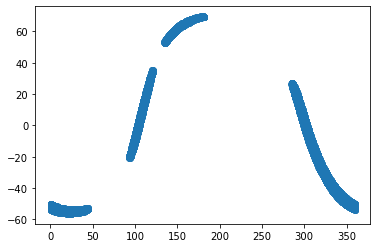

In [9]:
plt.scatter(ra2,dec2)

### Can check the area of skymap in degrees square for a given contour region

In [10]:
a=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
b=y="%.2f" % a
print(f"Skymap area is {b} square degrees")

Skymap area is 527.14 square degrees


### Obtain a dataframe of ra,dec,contour value of the skymap

In [11]:
import pandas as pd
skymap = pd.DataFrame({'meanra': ra2.flatten(),'meandec': dec2.flatten(),'pixel_no':arr.flatten(),'prob_countour':selected_elements})

In [12]:
skymap

meanra    meandec  pixel_no  prob_countour
0      178.167421  69.701077     97677       0.895628
1      179.796380  69.701077     97681       0.894525
2      180.203620  69.701077     97682       0.899578
3      177.770270  69.608247     98562       0.895679
4      178.175676  69.608247     98563       0.895689
...           ...        ...       ...            ...
40192   23.991713 -56.446381   2883012       0.890681
40193   24.240331 -56.446381   2883013       0.890655
40194   20.069252 -56.541802   2884444       0.892660
40195   22.063712 -56.541802   2884452       0.886896
40196   24.058172 -56.541802   2884460       0.890697

[40197 rows x 4 columns]

## Divide the skymap into multiple regions, using KMeans

/home/mayhem/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


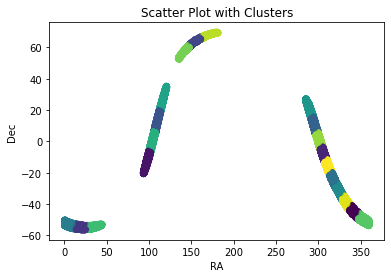

Processing Region 0 with 2339 points
Processing Region 1 with 2034 points
Processing Region 2 with 2558 points
Processing Region 3 with 1641 points
Processing Region 4 with 768 points
Processing Region 5 with 2260 points
Processing Region 6 with 2813 points
Processing Region 7 with 2517 points
Processing Region 8 with 1885 points
Processing Region 9 with 2385 points
Processing Region 10 with 2549 points
Processing Region 11 with 1642 points
Processing Region 12 with 2368 points
Processing Region 13 with 1279 points
Processing Region 14 with 2203 points
Processing Region 15 with 790 points
Processing Region 16 with 2716 points
Processing Region 17 with 554 points
Processing Region 18 with 2301 points
Processing Region 19 with 2595 points


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create a DataFrame with 'ra' and 'dec' columns (replace this with your data)


# Number of regions (clusters) you want to select
num_regions = 20

# Fit a K-Means model
kmeans = KMeans(n_clusters=num_regions)
kmeans.fit(skymap[['meanra', 'meandec']])

# Add cluster labels to the DataFrame
skymap['cluster_label'] = kmeans.labels_

# Plot the scatter plot with points colored by their cluster
plt.scatter(skymap['meanra'], skymap['meandec'], c=skymap['cluster_label'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Scatter Plot with Clusters')
plt.savefig('skymap.jpg')
plt.show()

# Iterate over clusters and process each region
for cluster_label in range(num_regions):
    region_data = skymap[skymap['cluster_label'] == cluster_label]
    # Process region_data as needed
    print(f"Processing Region {cluster_label} with {len(region_data)} points")


# In this part we query the skymap regions spatially. This involves:
- Using alpha shape module to get boundaries of the earlier divided regions(concave hull)
- adjusting its parameters, so that the shape is retained
- perform spatial query using q3c_poly_query
- get the resulting data frame consisting of all ZTF events(timeframe of 5 days) within the skymap

In [14]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])



39


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
31


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abgejni  100.501510  -7.001078  60209.492697    False     1
1    ZTF23abgeizw   96.359707 -13.998115  60209.493171    False     1
2    ZTF23abgejnj  100.943148  -7.246148  60209.492697    False     1
3    ZTF19acvaqip  100.867215  -7.642979  60209.492697     True     1
4    ZTF23abgejnk  100.322016  -7.154914  60209.492697    False     1
..            ...         ...        ...           ...      ...   ...
145  ZTF21aaduclh   97.189549 -13.025342  60211.500833    False     4
146  ZTF23abmglvn   98.667746 -12.676346  60211.500833     True     4
147  ZTF23abmydqz   99.092167  -9.598577  60211.467604     True     6
148  ZTF23abmyvmr   96.604240 -13.197749  60211.500833    False     4
149  ZTF23abmyxls   97.682347 -11.454567  60211.500833    False     3

[150 rows x 6 columns]
30


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra   meandec      firstmjd  stellar  ndet
0    ZTF23abgbemy  303.930479 -5.112332  60209.204560    False     1
1    ZTF23abgbent  304.979426 -5.016020  60209.204560    False     1
2    ZTF23abgbens  305.318443 -5.154208  60209.204560    False     1
3    ZTF23abgbfjw  306.445794 -5.711427  60209.204560    False     1
4    ZTF23abgbeys  305.302724 -4.169575  60209.204560    False     1
..            ...         ...       ...           ...      ...   ...
270  ZTF23abgxapn  305.187522 -7.014948  60213.190313    False     1
271  ZTF23abjaddq  306.476884 -6.919054  60211.169815    False     3
272  ZTF20acyyoge  305.397344 -3.903804  60209.286887    False     3
273  ZTF23aarwesb  304.395158 -6.748477  60209.287350     True     2
274  ZTF23ablzrrs  306.180161 -6.420479  60211.169815    False     4

[275 rows x 6 columns]
27


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
29


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
40


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF18accdcyk  112.595253  17.295370  60213.449768    False    37
1    ZTF23abgehvt  108.908339  12.601063  60209.501678    False     1
2    ZTF23abgeiek  108.470547   9.491590  60209.501678    False     1
3    ZTF23abgehwk  107.309354   6.940321  60209.501204    False     1
4    ZTF23abgeiby  110.347330  13.161847  60209.501678    False     1
..            ...         ...        ...           ...      ...   ...
425  ZTF21aacrolt  108.501471   9.291313  60213.501042     True     6
426  ZTF23abnbzla  108.447301   8.190747  60213.448831     True     3
427  ZTF19aarmoyu  111.327903  15.395550  60211.499873     True    22
428  ZTF18adrzukl  108.404913  10.568690  60213.449294    False    20
429  ZTF18adrztiy  108.312804  10.903634  60213.449294     True     5

[430 rows x 6 columns]
27


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abgbfeq  297.226454  10.119637  60209.203113    False     1
1    ZTF23abgbgab  296.339767   8.411830  60209.203113    False     1
2    ZTF22aaauhug  296.950291   9.339178  60209.203113     True     1
3    ZTF23abgbgio  296.429807  10.879959  60209.203113    False     1
4    ZTF23abgbgis  296.356983  11.644894  60209.203113     True     1
..            ...         ...        ...           ...      ...   ...
252  ZTF23ablfhhu  296.012547   6.157565  60213.132917     True     3
253  ZTF23ablfinq  295.565964   9.489247  60213.184479    False     2
254  ZTF18adqodgg  295.664899   7.889558  60211.147569    False     6
255  ZTF23abmsxfz  295.574806   7.912610  60211.232153     True     2
256  ZTF19adljkjr  297.108472   4.828486  60211.232153    False     4

[257 rows x 6 columns]
44


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abggbix  317.619651 -21.633924  60211.167928    False     1
1    ZTF23abggazc  319.789343 -27.402170  60211.167928    False     1
2    ZTF23abggbce  318.581842 -24.076805  60211.167928    False     1
3    ZTF23abggbcp  320.784355 -27.442217  60211.167928    False     1
4    ZTF23abggazb  319.583145 -27.359979  60211.167928    False     1
..            ...         ...        ...           ...      ...   ...
269  ZTF23abghtxg  321.842327 -26.643197  60211.294572    False     1
270  ZTF23abghtnl  320.675970 -25.393357  60211.294572    False     1
271  ZTF23abghvas  320.923885 -26.604588  60211.294572    False     1
272  ZTF23abifijn  314.017949 -21.908234  60211.167928    False     4
273  ZTF18adsaihf  318.266877 -22.987132  60211.230486    False     5

[274 rows x 6 columns]
26


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
54
Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


34


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abgaxgx  292.724271  17.451532  60209.166620    False     1
1    ZTF23abgaxjr  286.388953  26.295572  60209.165197     True     1
2    ZTF23abgaxjs  286.206595  26.362619  60209.165197     True     1
3    ZTF19abkpqib  285.904177  26.592900  60209.165197     True     1
4    ZTF19admrywj  285.904311  26.580715  60209.165197     True     1
..            ...         ...        ...           ...      ...   ...
309  ZTF23abgphhu  293.365422  15.494648  60212.244768    False     1
310  ZTF23abgphhv  293.315029  15.962102  60212.244768    False     1
311  ZTF21abfwyjf  287.288127  25.404070  60212.173484     True     2
312  ZTF22abyqjfn  287.951948  23.695179  60209.165197    False    15
313  ZTF23aapieed  286.288320  25.598449  60212.173484    False     5

[314 rows x 6 columns]
35


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abmplrc  119.519599  32.816358  60213.502014    False    18
1    ZTF18aaewsvp  113.371975  22.177369  60209.502153     True     1
2    ZTF23abgeikt  113.348520  19.201441  60209.502153    False     1
3    ZTF18aaexhuw  113.363491  21.909810  60209.502153     True     1
4    ZTF23abgejkv  112.425981  19.572731  60209.502153    False     1
..            ...         ...        ...           ...      ...   ...
366  ZTF20aaeexyp  114.534194  22.288929  60212.454931     True     2
367  ZTF23abkgqxb  117.611519  27.641281  60211.499387    False    25
368  ZTF23abkgvzv  115.571709  24.911366  60211.469988    False    12
369  ZTF23abkhkxm  113.969794  20.610805  60212.454931    False    15
370  ZTF18adojoqv  113.585606  22.447494  60211.499387    False     3

[371 rows x 6 columns]
29


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra   meandec      firstmjd  stellar  ndet
0    ZTF23abgehvo  106.571333  2.968376  60209.501204    False     1
1    ZTF23abgehvp  106.605822  3.086142  60209.501204    False     1
2    ZTF18adsknpe  104.749931 -0.117986  60209.492234     True     1
3    ZTF18acthqae  105.046126  0.071931  60209.492234     True     1
4    ZTF23abgekts  101.474066 -5.095927  60209.491759    False     1
..            ...         ...       ...           ...      ...   ...
270  ZTF23abnbpig  106.751696  5.091012  60211.500359    False     4
271  ZTF23abnbpvh  106.757102  3.526615  60213.448831     True     4
272  ZTF23abnbyyu  104.897129  2.260482  60211.500359     True     2
273  ZTF23abnbiby  103.553186  0.899976  60211.500359    False    60
274  ZTF23abguamo  102.573625 -5.100026  60212.457789    False     9

[275 rows x 6 columns]
31


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
35
Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


38


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
31


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


              oid      meanra   meandec      firstmjd  stellar  ndet
0    ZTF23abgbemw  303.771484 -3.998042  60209.204560    False     1
1    ZTF23abgbemx  304.337085 -3.877757  60209.204560     True     1
2    ZTF18aciftsz  304.279066 -3.855043  60209.204560     True     1
3    ZTF18acaqtcu  304.332338 -3.288442  60209.204560     True     1
4    ZTF18acileqf  302.607442 -2.026833  60209.204560     True     1
..            ...         ...       ...           ...      ...   ...
192  ZTF20acwrdkj  302.097615 -2.953463  60209.286887    False     2
193  ZTF18acjbxig  302.130278  0.621475  60209.286887     True     2
194  ZTF23abjfoma  302.984763 -3.313833  60209.286887    False     4
195  ZTF23abmaqgn  299.386294  4.385279  60211.222674     True     4
196  ZTF20acycpwl  298.630708  3.523947  60213.186377     True     2

[197 rows x 6 columns]
33


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []
37
Empty DataFrame
Columns: [oid, meanra, meandec, firstmjd, stellar, ndet]
Index: []


/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)
/tmp/ipykernel_2695/1956191073.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/tmp/ipykernel_2695/1956191073.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  results1= pd.read_sql_query(query, conn)


29
              oid      meanra    meandec      firstmjd  stellar  ndet
0    ZTF23abgastt  312.802032 -21.050090  60209.146944     True     1
1    ZTF21acajmnz  313.233166 -20.525539  60209.146944     True     1
2    ZTF23abgasts  312.531403 -20.724048  60209.146944     True     1
3    ZTF23abgastu  312.857462 -21.237958  60209.146944     True     1
4    ZTF23abgastr  312.787746 -20.798782  60209.146944     True     1
..            ...         ...        ...           ...      ...   ...
454  ZTF23abggzdx  315.872986 -19.413968  60211.231146    False     2
455  ZTF23abifjtc  315.715857 -19.031316  60211.168403     True     2
456  ZTF23abktryo  315.188778 -20.402996  60211.231620    False     4
457  ZTF23ablnmnv  314.460179 -21.048092  60211.167928    False     5
458  ZTF23ablnoqe  311.451762 -16.473407  60211.169340    False     3

[459 rows x 6 columns]


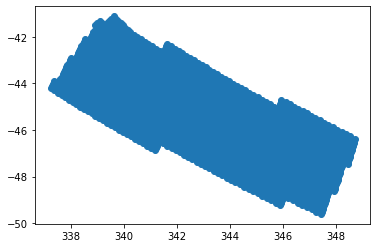

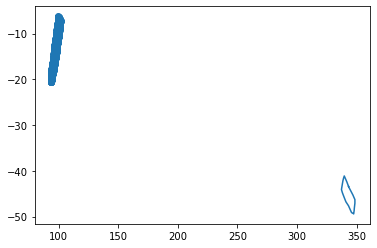

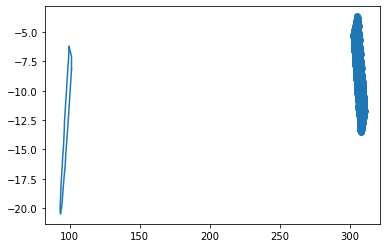

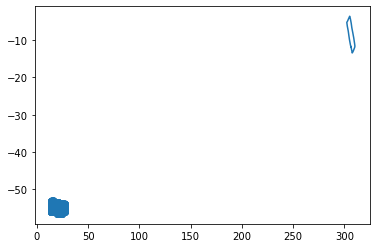

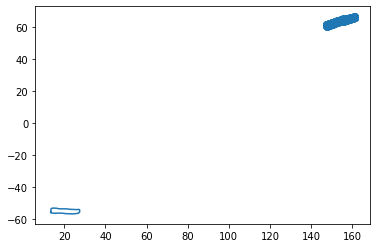

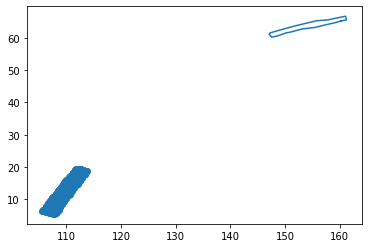

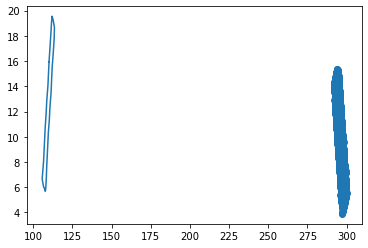

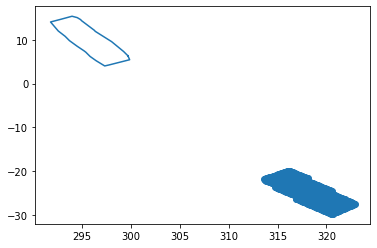

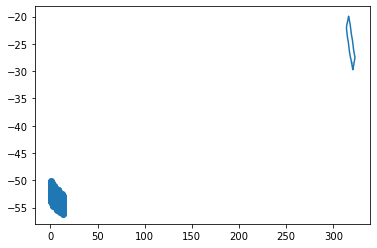

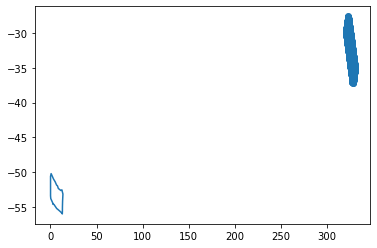

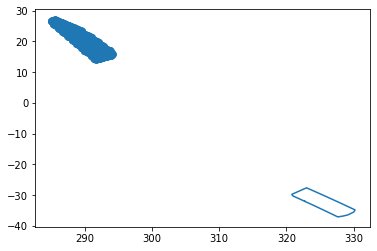

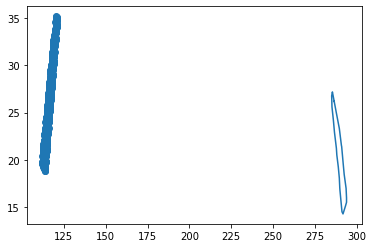

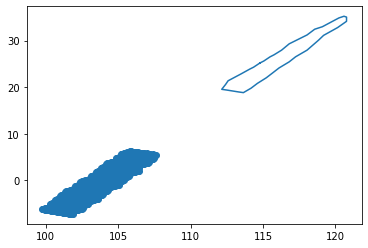

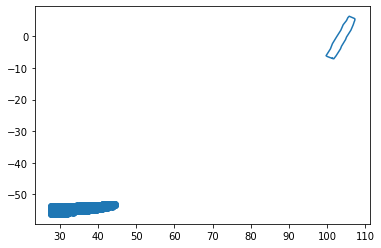

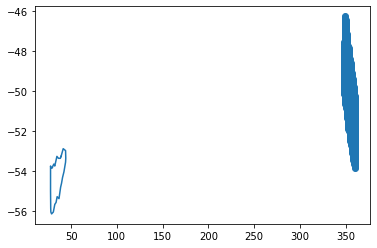

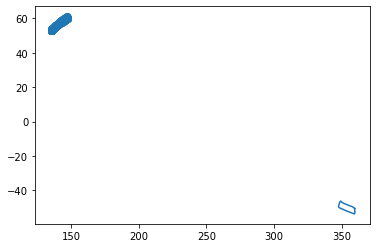

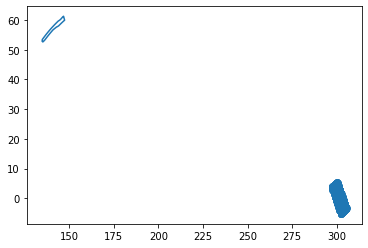

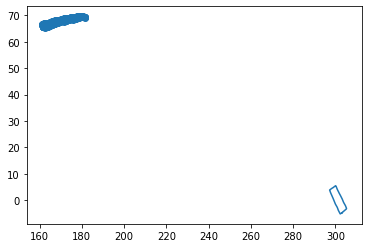

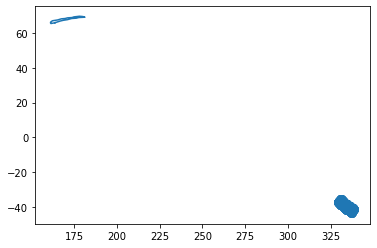

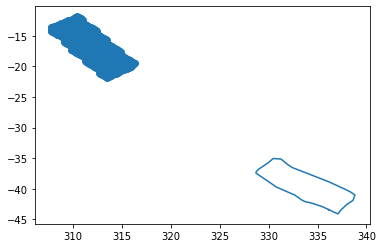

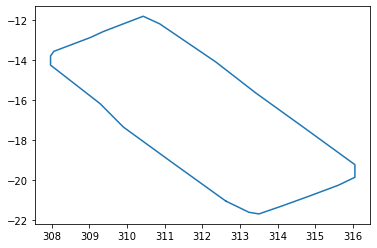

In [15]:
import alphashape
new_df=pd.DataFrame()
a=len(skymap['cluster_label'].unique())
for i in range(a):
    
    cluster_data = skymap[skymap['cluster_label'] == i]
    plt.scatter(cluster_data['meanra'],cluster_data['meandec'])
    alt = cluster_data.iloc[::5]
    alt=alt.reset_index(drop=True)
    rag=alt['meanra'].to_numpy()
    decg=alt['meandec'].to_numpy()
    combined_array3= np.concatenate([rag[:, np.newaxis], decg[:, np.newaxis]], axis=1).ravel()

    dd = combined_array3.reshape(int(combined_array3.shape[0]/2),2)
    points_2d = [(x, y) for x, y in zip(dd[:, 0], dd[:, 1])]
    alpha_shape = alphashape.alphashape(points_2d,0.2)
    if alpha_shape.geom_type == 'Polygon':
    # Process the single Polygon
        x = np.array(alpha_shape.exterior.coords.xy[0])
        y = np.array(alpha_shape.exterior.coords.xy[1])
        fig, ax = plt.subplots()
        ax.plot(x, y)
        print(len(x))
        result = []
        for l in range(len(x)):
            result.append(x[l])
            result.append(y[l])

        ndays = 5
        #mjd_last = Time(datetime.utcnow(), scale='utc').mjd - ndays
        mjd_first = int(header[30][1]) - ndays
        mjd_last= int(header[30][1])


        query = f"""
        SELECT
            object.oid, object.meanra, object.meandec, object.firstmjd, object.stellar,
            object.ndet
        FROM 
            object 
        WHERE q3c_poly_query(meanra, meandec,ARRAY[{','.join([str(coord) for coord in result])}])
            AND object.firstMJD >= %s
            AND object.firstMJD <= %s;;
        """%(mjd_first,mjd_last)
        results1= pd.read_sql_query(query, conn)
        print(results1)
        new_df=pd.concat([new_df,results1],ignore_index=True)


   

### Visualise the total area of skymap and the events returned

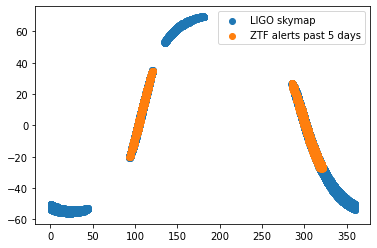

In [16]:
plt.scatter(skymap['meanra'],skymap['meandec'],label='LIGO skymap')
plt.scatter(new_df['meanra'],new_df['meandec'],label='ZTF alerts past 5 days')
plt.legend()

plt.savefig('skymap.jpg')
plt.show()

In [17]:
new_df

oid      meanra    meandec      firstmjd stellar ndet
0     ZTF23abgejni  100.501510  -7.001078  60209.492697   False    1
1     ZTF23abgeizw   96.359707 -13.998115  60209.493171   False    1
2     ZTF23abgejnj  100.943148  -7.246148  60209.492697   False    1
3     ZTF19acvaqip  100.867215  -7.642979  60209.492697    True    1
4     ZTF23abgejnk  100.322016  -7.154914  60209.492697   False    1
...            ...         ...        ...           ...     ...  ...
2997  ZTF23abggzdx  315.872986 -19.413968  60211.231146   False    2
2998  ZTF23abifjtc  315.715857 -19.031316  60211.168403    True    2
2999  ZTF23abktryo  315.188778 -20.402996  60211.231620   False    4
3000  ZTF23ablnmnv  314.460179 -21.048092  60211.167928   False    5
3001  ZTF23ablnoqe  311.451762 -16.473407  60211.169340   False    3

[3002 rows x 6 columns]

## Crossmatch the ZTF events with skymap to obtain the ligo probability values

In [18]:
import astropy.units as u
from astropy.coordinates import SkyCoord
ra1=np.array(new_df['meanra'])
dec1=np.array(new_df['meandec'])
ra2=np.array(skymap['meanra'])
dec2=np.array(skymap['meandec'])
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

In [19]:
prob=[]
for index,no in enumerate(idx):
    prob.append(skymap.iloc[no][3])
    
    

In [20]:
new_df['p_ligo']=prob


### Step 1 - Here we query the alerce database, taking advatnage of its events calssification infrastructure, returning event's :
- class_name
- probability
- stellar
- ranking

In [21]:
n=new_df.set_index('oid')

In [42]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.firstmjd, object.stellar,
    object.ndet, probability.probability, probability.class_name,probability.classifier_name,probability.ranking
FROM 
    object 
INNER JOIN
    probability
ON 
    object.oid = probability.oid
WHERE 
     object.oid IN ({})
    AND probability.classifier_name='stamp_classifier'
    AND (probability. class_name IN ('SN'))
''' .format( ",".join(["'%s'" % oid for oid in n.index]))

sn = pd.read_sql_query(query, conn)
sn.set_index('oid', inplace=True)
print(sn.shape)
sn

/tmp/ipykernel_4400/61653737.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sn = pd.read_sql_query(query, conn)


(2903, 9)


meanra    meandec      firstmjd  stellar  ndet  probability  \
oid                                                                             
ZTF18accdcyk  112.595253  17.295370  60213.449768    False    37     0.093824   
ZTF23abmplrc  119.519599  32.816358  60213.502014    False    18     0.267175   
ZTF18accdcyk  112.595253  17.295370  60213.449768    False    37     0.053589   
ZTF23abgaxjr  286.388953  26.295572  60209.165197     True     1     0.057252   
ZTF23abgaxjs  286.206595  26.362619  60209.165197     True     1     0.054598   
...                  ...        ...           ...      ...   ...          ...   
ZTF23abnbiby  103.553186   0.899976  60211.500359    False    60     0.019283   
ZTF18adrzukl  108.404913  10.568690  60213.449294    False    20     0.059963   
ZTF23abguamo  102.573625  -5.100026  60212.457789    False     9     0.087220   
ZTF18adrztiy  108.312804  10.903634  60213.449294     True     5     0.074924   
ZTF19aarmoyu  111.327903  15.395550  60211.499873     True    22     0.099756   

             class_name   classifier_name  ranking  
oid                                                 
ZTF18accdcyk         SN  stamp_classifier        4  
ZTF23abmplrc         SN  stamp_classifier        2  
ZTF18accdcyk         SN  stamp_classifier        5  
ZTF23abgaxjr         SN  stamp_classifier        4  
ZTF23abgaxjs         SN  stamp_classifier        4  
...                 ...               ...      ...  
ZTF23abnbiby         SN  stamp_classifier        3  
ZTF18adrzukl         SN  stamp_classifier        5  
ZTF23abguamo         SN  stamp_classifier        4  
ZTF18adrztiy         SN  stamp_classifier        5  
ZTF19aarmoyu         SN  stamp_classifier        4  

[2903 rows x 9 columns]

### Step 2 - Filter the events(with stamps) coming from the galaxy based on sgscore/distpnr

In [43]:
# for objects from SN table get origin of object event/ get oids for objects having sgscore <0.5
query='''
SELECT
    det.oid,det.drb,det.fid,
    det.mjd, det.magpsf, det.sigmapsf,
    det.has_stamp,
    ps1.sgscore1
FROM
    (SELECT *
    FROM detection
    WHERE oid in (%s)
    ) as det
    INNER JOIN
    (SELECT *
    FROM ps1_ztf
    WHERE oid in (%s)
    ) as ps1
    ON det.oid=ps1.oid
''' % (",".join(["'%s'" % x for x in n.index]), ",".join(["'%s'" % x for x in n.index]))

detections = pd.read_sql_query(query, conn)
detections.set_index('oid', inplace=True)
print(detections.shape)
detections

/tmp/ipykernel_4400/2000766860.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detections = pd.read_sql_query(query, conn)


(3956, 7)


drb  fid           mjd     magpsf  sigmapsf  has_stamp  \
oid                                                                         
ZTF18aaantle       NaN    1  60211.499873  19.375900  0.294677      False   
ZTF18aaantle  0.987947    1  60228.423785  18.822172  0.202279       True   
ZTF18aaewsvp  0.979965    2  60209.502153  14.787804  0.180558       True   
ZTF18aaexhuw  0.930707    2  60209.502153  14.769210  0.176130       True   
ZTF18aafekgc  0.222633    1  60213.449768  19.411058  0.198142       True   
...                ...  ...           ...        ...       ...        ...   
ZTF23abnbyyu       NaN    1  60211.500359  18.316600  0.107464      False   
ZTF23abnbyyu  0.046341    1  60241.458333  18.946257  0.184099       True   
ZTF23abnbzla       NaN    1  60213.448831  18.706900  0.199817      False   
ZTF23abnbzla       NaN    2  60241.434780  18.658800  0.169767      False   
ZTF23abnbzla  0.972702    1  60241.455035  18.973797  0.169852       True   

              sgscore1  
oid                     
ZTF18aaantle  0.998750  
ZTF18aaantle  0.998750  
ZTF18aaewsvp  0.500000  
ZTF18aaexhuw  1.000000  
ZTF18aafekgc  1.000000  
...                ...  
ZTF23abnbyyu  0.987500  
ZTF23abnbyyu  0.987500  
ZTF23abnbzla  0.992542  
ZTF23abnbzla  0.992542  
ZTF23abnbzla  0.992542  

[3956 rows x 7 columns]

<AxesSubplot:ylabel='Frequency'>

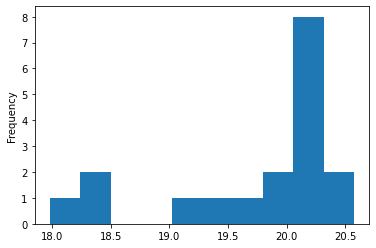

In [32]:
detections.magpsf.plot.hist()

### Step 3: get respective 'non-detection' parameters for events in skymap:
- mjd
- limiting magnitude
- filter id

In [44]:
#get non detections of earlier filtered table 'obt' to have a reference to calculate dmdt
query='''
SELECT
    oid, mjd, diffmaglim, fid
FROM
    non_detection
WHERE
    oid in (%s)
''' % (",".join(["'%s'" % oid for oid in n.index.unique()]))

non_detections = pd.read_sql_query(query, conn)
non_detections.set_index('oid', inplace=True)
non_detections.head(100)

/tmp/ipykernel_4400/380938593.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  non_detections = pd.read_sql_query(query, conn)


mjd  diffmaglim  fid
oid                                        
ZTF18aaantle  60214.479456     19.9754    1
ZTF18aaantle  60220.477384     19.2537    1
ZTF18aaantle  60222.465336     19.2288    1
ZTF18aaantle  60211.469514     20.2053    2
ZTF18aaantle  60214.530579     19.5375    2
...                    ...         ...  ...
ZTF18aafkbcp  60181.512859     18.6177    2
ZTF18aafkbcp  60187.495567     18.8323    2
ZTF18aafkbcp  60187.497998     18.9133    2
ZTF18aafkbcp  60187.500440     18.8843    2
ZTF18aafkbcp  60187.502870     19.0221    2

[100 rows x 3 columns]

#### Defined a function to calculate rate of change of magnitude
##### Since kilonovas exhibit rapid variation in magnitude w.r.t time compared to that of supernovas

In [30]:
#function defined to calculate dm/dt-> first get detections and non detections of oids from earlier table
#-> sort them based on filter ids(g/r)-> get mjds for detections and non detections-> get magnitude for detection event
#get time difference between detection and non detection for same oid-> this way calculate dm/dt
def do_dmdt(oid):
    dmdts = []
    dets = detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        dets = dets.to_frame().transpose()
    except:
        True 
    non_dets = non_detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        non_dets = non_dets.to_frame().transpose()
    except:
        True 
    for fid in sorted(dets.fid.unique()):
        if fid == 1:
            fid_str = "g"
        elif fid == 2:
            fid_str = "r"
        else:
            continue
        mask_det = (dets.fid == fid)
        idx_1st_det = dets.loc[mask_det].mjd.astype(float).idxmin()
        mask_non_det = (non_dets.mjd < float(n.loc[oid].firstmjd)) & (non_dets.fid == fid)
        if mask_non_det.sum() >= 1: # filter must be in both dets and non_dets
            dm = np.array(dets.loc[idx_1st_det].magpsf - non_dets.loc[mask_non_det].diffmaglim)
            dm_error = np.array(dets.loc[idx_1st_det].magpsf + dets.loc[idx_1st_det].sigmapsf - non_dets.loc[mask_non_det].diffmaglim)
            dt = np.array(dets.loc[idx_1st_det].mjd - non_dets.loc[mask_non_det].mjd)
            dmdt = dm/dt
            dmdt_error = dm_error/dt
            idx_dmdt = np.argmin(dmdt_error) #dmdt = (dm/dt).min()                                                                                                                                         
            dmdt_min = dmdt[idx_dmdt]
            dmdt_error_min = dmdt_error[idx_dmdt]
            newdf = pd.DataFrame(data = {"oid":[oid],"dmdt_min": [dmdt_min], "dmdt_error": [dmdt_error_min - dmdt_min], \
                                         "dmdt_comp": [dmdt_error_min], 'dt': [dt[idx_dmdt]], 'fid': int(fid), \
                                         'Flag': [dt[idx_dmdt] < 0.5]}, index = [oid])
            dmdts.append(newdf)
            

    if dmdts == []:
        return None
    else:
        
        return pd.concat(dmdts)

### Step-5: create data frame showing the dmdt values for all the events

In [45]:
#create data frame using above function based on oid
oids_nd = non_detections.index.unique()
dmdts = []
for oid in oids_nd:
    try:
        dmdt = do_dmdt(oid)
        if dmdt is None:
            continue
        else:
            dmdts.append(dmdt)
    except:
        continue
dmdts = pd.concat(dmdts)



/tmp/ipykernel_4400/2614320808.py:27: RuntimeWarning: divide by zero encountered in true_divide
  dmdt = dm/dt
/tmp/ipykernel_4400/2614320808.py:28: RuntimeWarning: divide by zero encountered in true_divide
  dmdt_error = dm_error/dt
/tmp/ipykernel_4400/2614320808.py:27: RuntimeWarning: divide by zero encountered in true_divide
  dmdt = dm/dt
/tmp/ipykernel_4400/2614320808.py:28: RuntimeWarning: divide by zero encountered in true_divide
  dmdt_error = dm_error/dt
/tmp/ipykernel_4400/2614320808.py:32: RuntimeWarning: invalid value encountered in double_scalars
  newdf = pd.DataFrame(data = {"oid":[oid],"dmdt_min": [dmdt_min], "dmdt_error": [dmdt_error_min - dmdt_min], \


In [46]:
dmdts

oid   dmdt_min  dmdt_error  dmdt_comp         dt  fid  \
ZTF18aaewsvp  ZTF18aaewsvp  -0.373343    0.013888  -0.359455  13.001447    2   
ZTF18aaexhuw  ZTF18aaexhuw  -0.374773    0.013547  -0.361226  13.001447    2   
ZTF18aafekgc  ZTF18aafekgc  -0.013441    0.009936  -0.003505  19.941516    1   
ZTF18aafkbcp  ZTF18aafkbcp  -0.299824    0.011242  -0.288581  16.028854    2   
ZTF18aafqfnx  ZTF18aafqfnx  -0.008418    0.011691   0.003273  16.973426    2   
...                    ...        ...         ...        ...        ...  ...   
ZTF23abmsxfz  ZTF23abmsxfz -28.901652    1.997626 -26.904026   0.084583    2   
ZTF23abnbiby  ZTF23abnbiby -69.293584    4.169763 -65.123821   0.032268    2   
ZTF23abnbpig  ZTF23abnbpig  -0.026867    0.007010  -0.019857  29.966227    2   
ZTF23abnbpvh  ZTF23abnbpvh  -1.038352    0.079690  -0.958662   1.948472    1   
ZTF23abnbpvh  ZTF23abnbpvh  -0.878005    0.078392  -0.799613   1.980741    2   

               Flag  
ZTF18aaewsvp  False  
ZTF18aaexhuw  False  
ZTF18aafekgc  False  
ZTF18aafkbcp  False  
ZTF18aafqfnx  False  
...             ...  
ZTF23abmsxfz   True  
ZTF23abnbiby   True  
ZTF23abnbpig  False  
ZTF23abnbpvh  False  
ZTF23abnbpvh  False  

[2868 rows x 7 columns]

<AxesSubplot:ylabel='Frequency'>

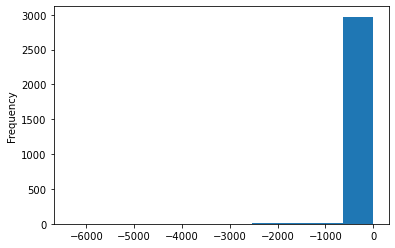

In [33]:
dmdts.dmdt_min.plot.hist()

In [47]:
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

/tmp/ipykernel_4400/232994635.py:1: DeprecationWarning: the ``irsa_dust`` module has been moved to astroquery.ipac.irsa.irsa_dust, please update your imports.
  from astroquery.irsa_dust import IrsaDust


### Step 6: Get the galactic coordinates of the events. Prioritize the events having ndet > 1/ events off the ecliptic and galactic extinction < 1

In [55]:
#get ecliptic latitude , galactic latitude and galactic extinction for above oids
ecl_lat = {}
gal_lat = {}
gal_A_g = {}

for oid in n.index:
    try:
   
        print(oid)
        ra = n.loc[oid].meanra
        dec = n.loc[oid].meandec
        coo = coord.SkyCoord(ra, dec, unit='deg', frame='fk5')    

        # ecliptic coordinates (input is hours, degrees)
        ecl_lat[oid] = np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)

        # galactic latitude
        gal_lat[oid] = np.rad2deg(ephem.Galactic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)

        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(coo)
        gal_A_g[oid] = float(table[table["Filter_name"] == "SDSS g"]["A_SFD"])
        
    except (TypeError,TimoutError) as e:
        print(f"Error: {e}")
        time.sleep(5.5)
        continue
    

ZTF23abmplrc
ZTF18aaewsvp
ZTF23abgeikt
ZTF18aaexhuw
ZTF23abgejkv
ZTF23abgmeha
ZTF23abgmegr
ZTF23abgmegw
ZTF23abgmegv
ZTF23abgmegs
ZTF23abgmegz
ZTF23abgmejv
ZTF23abgmejw
ZTF23abgmeke
ZTF23abgmekb
ZTF23abgmekf
ZTF23abgmekg
ZTF23abgmekh
ZTF23abgmehc
ZTF23abgmeyg
ZTF23abgmeyt
ZTF23abgmeyi
ZTF23abgmfsm
ZTF23abgmfsr
ZTF23abgmfsv
ZTF23abgmfch
ZTF23abgmfsa
ZTF23abgmfsi
ZTF23abgmfsz
ZTF23abgmfte
ZTF23abgmfsu
ZTF23abgmfsw
ZTF23abgmfta
ZTF23abgmged
ZTF23abgmghe
ZTF23abgmghh
ZTF23abgmghi
ZTF23abgmghj
ZTF23abgmghk
ZTF23abgmghl
ZTF23abgmgho
ZTF23abgmghn
ZTF23abgmglp
ZTF23abgmgen
ZTF23abgmgep
ZTF23abgmghf
ZTF23abgmghg
ZTF23abgmghm
ZTF18adrbvfw
ZTF23abgmgle
ZTF23abgmglq
ZTF23abgmgls
ZTF23abgmglm
ZTF23abgmgln
ZTF23abgmglo
ZTF23abgmhmt
ZTF23abgmgsn
ZTF23abgmgsu
ZTF23abgmgsv
ZTF23abgmgsw
ZTF23abgmhsy
ZTF23abgmhtb
ZTF23abgmgsr
ZTF23abgmgst
ZTF23abgmhnt
ZTF23abgmhnl
ZTF23abgmglr
ZTF23abgmgsm
ZTF23abgmgsp
ZTF23abgmgsq
ZTF23abgmgsk
ZTF23abgmhmy
ZTF23abgmhnd
ZTF23abgmhnh
ZTF23abgmhob
ZTF23abgmhsz
ZTF23abgmhta

NameError: name 'TimoutError' is not defined

In [56]:
dfp=pd.DataFrame.from_dict({'ecl_lat': ecl_lat, 'gal_lat': gal_lat, 'gal_A_g': gal_A_g})


In [57]:
dfp

ecl_lat    gal_lat  gal_A_g
ZTF23abmplrc  11.907194  27.487434    0.241
ZTF18aaewsvp   0.469865  18.813455    0.262
ZTF23abgeikt  -2.472255  17.636392    0.223
ZTF18aaexhuw   0.204417  18.703974    0.202
ZTF23abgejkv  -2.240184  16.984830    0.169
...                 ...        ...      ...
ZTF23abggzyu  -7.981174 -40.309175    0.225
ZTF23abggzsg  -7.169316 -40.019816    0.197
ZTF23abggzsh  -6.906168 -40.101253    0.211
ZTF23abggzse  -7.535883 -39.515787    0.277
ZTF23abggzsi  -3.474136 -36.492840      NaN

[2890 rows x 3 columns]

In [42]:
snf

meanra_x  meandec_x    firstmjd_x stellar_x ndet_x    p_ligo  \
oid                                                                            
ZTF18aafcfqb  127.945832  16.275236  60248.515868      True      1  0.546507   
ZTF18aafqqel  128.220666  18.508095  60248.490995      True      1  0.744411   
ZTF18aafryan  155.648123  45.155012  60249.450023      True      1  0.784282   
ZTF18aafrzin  155.890856  45.551600  60249.450023     False      3  0.678654   
ZTF18aafrzin  155.890856  45.551600  60249.450023     False      3  0.678654   
...                  ...        ...           ...       ...    ...       ...   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343     False      3  0.700295   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343     False      3  0.700295   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343     False      3  0.700295   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343     False      3  0.700295   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343     False      3  0.700295   

                meanra_y  meandec_y    firstmjd_y  stellar_y  ...  dmdt_error  \
oid                                                           ...               
ZTF18aafcfqb  127.945832  16.275236  60248.515868       True  ...    0.065760   
ZTF18aafqqel  128.220666  18.508095  60248.490995       True  ...    0.048399   
ZTF18aafryan  155.648123  45.155012  60249.450023       True  ...    0.029178   
ZTF18aafrzin  155.890856  45.551600  60249.450023      False  ...    0.003574   
ZTF18aafrzin  155.890856  45.551600  60249.450023      False  ...    0.022355   
...                  ...        ...           ...        ...  ...         ...   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343      False  ...    0.006952   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343      False  ...    0.011858   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343      False  ...    0.006952   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343      False  ...    0.011858   
ZTF23abrrbgj  299.510647  -6.344078  60251.131343      False  ...    0.006952   

              dmdt_comp         dt fid_y   Flag    ecl_lat    gal_lat  \
oid                                                                     
ZTF18aafcfqb  -0.647764   3.048148     1  False  -2.521118  29.341199   
ZTF18aafqqel  -0.316574   3.006169     2  False  -0.292192  30.413241   
ZTF18aafryan  -0.184788   4.952940     2  False  32.333450  55.400028   
ZTF18aafrzin  -0.125273  23.935694     1  False  32.764842  55.432308   
ZTF18aafrzin  -0.220281   4.952940     2  False  32.764842  55.432308   
...                 ...        ...   ...    ...        ...        ...   
ZTF23abrrbgj  -0.020282  29.003322     2  False  14.044212 -17.688681   
ZTF23abrrbgj  -0.027366  17.004317     1  False  14.044212 -17.688681   
ZTF23abrrbgj  -0.020282  29.003322     2  False  14.044212 -17.688681   
ZTF23abrrbgj  -0.027366  17.004317     1  False  14.044212 -17.688681   
ZTF23abrrbgj  -0.020282  29.003322     2  False  14.044212 -17.688681   

              gal_A_g  filter1  filter2  
oid                                      
ZTF18aafcfqb    0.122    False    False  
ZTF18aafqqel    0.128    False    False  
ZTF18aafryan    0.042    False     True  
ZTF18aafrzin    0.048    False     True  
ZTF18aafrzin    0.048    False     True  
...               ...      ...      ...  
ZTF23abrrbgj    0.478    False    False  
ZTF23abrrbgj    0.478    False    False  
ZTF23abrrbgj    0.478    False    False  
ZTF23abrrbgj    0.478    False    False  
ZTF23abrrbgj    0.478    False    False  

[3280 rows x 34 columns]

<AxesSubplot:ylabel='Frequency'>

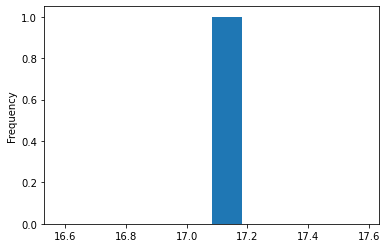

In [53]:
sn_final.ecl_lat.plot.hist()

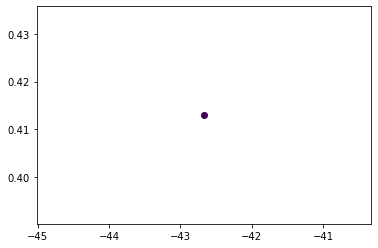

In [54]:
fig, ax = plt.subplots()
ax.scatter(sn_final.gal_lat, sn_final.gal_A_g, c=sn_final.ndet)

Exclude the data unless it has two detections or it is close to galactic plane:

In [44]:
#display the difference images of earlier oids
for oid in sn_final.loc[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))
    display(pd.DataFrame(sn_final.loc[oid]).transpose())
    client.plot_stamps(oid)
    sn.loc[oid]

meanra    meandec      firstmjd stellar ndet probability  \
ZTF23ablcmvs  150.218529  41.403922  60234.508125   False    1    0.783054   

             class_name ranking    ecl_lat    gal_lat gal_A_g  
ZTF23ablcmvs         SN       1  27.296543  52.431894   0.055

### Step 7: Use 'DELIGHT' to obtain the proper coordinates of the ZTF events

In [34]:
import time
max_retries = 3 
for oid in n.index:
    retries = 0
    while retries < max_retries:
        try:
            d_ra[oid], d_dec[oid] = get_del(oid)
            break  # If successful, exit the retry loop
        except (TypeError, ConnectionError,APIError) as e:
            retries += 1
            print(f"Error for {oid}: {e}")
            time.sleep(5.5)
        except Exception as inner_exception:
            retries += 1
            print(f"Error for {oid}: {inner_exception}")
            time.sleep(5.5)
    else:
        print(f"Max retries reached for {oid}. Skipping.")

Loading WCS information


2023-12-27 14:33:54.730457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abmplrc  119.519599  32.816358  0.001478   

                                                       filename  \
oid                                                               
ZTF23abmplrc  stack_r_ra119.519599_dec32.816358_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abmplrc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abmplrc  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abmplrc  240.1425156993937  239.64958192158883   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abmplrc  [[0.5355870723724365, -0.936339259147644], [-1...   0.136204   

             dy_delight  std_delight  \
oid                                    
ZTF23abmplrc   0.125768     1.245199   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abmplrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abmplrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.519594   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abmplrc    32.816361  119.519581  32.81634  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:04.949971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF18aaewsvp  113.371975  22.177369  0.001831   

                                                       filename  \
oid                                                               
ZTF18aaewsvp  stack_r_ra113.371975_dec22.177369_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18aaewsvp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18aaewsvp  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18aaewsvp  240.20903430679755  239.99586340510223   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18aaewsvp  [[-3.2707512378692627, -6.06118631362915], [-2...  -2.286376   

             dy_delight  std_delight  \
oid                                    
ZTF18aaewsvp  -0.044653     3.368841   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18aaewsvp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18aaewsvp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.372153   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF18aaewsvp    22.177357  113.372031  22.177508  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:15.122688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgejku  111.977602  19.293361  0.002227   

                                                       filename  \
oid                                                               
ZTF23abgejku  stack_r_ra111.977602_dec19.293361_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgejku  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgejku  <SkyCoord (ICRS): (ra, dec) in deg\n    (111.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgejku  240.1371432561864  240.35471189132295   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgejku  [[-11.791643142700195, 10.735305786132812], [-...   -8.71746   

             dy_delight  std_delight  \
oid                                    
ZTF23abgejku   5.253542     7.306957   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgejku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgejku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  111.978247   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgejku    19.293724  111.97907  19.294413  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:25.195156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abgeikt  113.34852  19.201441  0.001765   

                                                       filename  \
oid                                                               
ZTF23abgeikt  stack_r_ra113.348520_dec19.201441_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgeikt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgeikt  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgeikt  240.14117720162994  240.3357303140765   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgeikt  [[-3.7949588298797607, 1.8377022743225098], [0...  -2.808207   

             dy_delight  std_delight  \
oid                                    
ZTF23abgeikt  -1.392695     4.395603   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgeikt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgeikt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.348733   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgeikt    19.201338  113.353512  19.210066  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:34.801734: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra       dec     dist  \
oid                                           
ZTF18aaexhuw  113.363491  21.90981  0.00108   

                                                       filename  \
oid                                                               
ZTF18aaexhuw  stack_r_ra113.363491_dec21.909810_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18aaexhuw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18aaexhuw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18aaexhuw  239.66426641746875  240.11377119043027   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18aaexhuw  [[2.554983139038086, 3.5471556186676025], [0.8...   1.300741   

             dy_delight  std_delight  \
oid                                    
ZTF18aaexhuw    4.32382     1.358322   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18aaexhuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18aaexhuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.363404   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF18aaexhuw    21.910105  113.363421  21.910099  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:45.030762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgejkv  112.425981  19.572731  0.001132   

                                                       filename  \
oid                                                               
ZTF23abgejkv  stack_r_ra112.425981_dec19.572731_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgejkv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgejkv  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgejkv  239.47642967925367  240.09326509128732   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgejkv  [[7.161864280700684, -10.382739067077637], [-2...   3.719521   

             dy_delight  std_delight  \
oid                                    
ZTF23abgejkv  -5.222313     8.802816   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgejkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgejkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.425715   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgejkv    19.572362  112.425925  19.573795  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:34:55.550993: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abgmeha  116.32848  24.567701  0.002226   

                                                       filename  \
oid                                                               
ZTF23abgmeha  stack_r_ra116.328480_dec24.567701_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeha  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeha  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeha  240.39747959547458  239.5147903655561   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeha  [[1.1192667484283447, 0.14176177978515625], [0...  -0.978071   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeha  -3.194456     6.363018   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.328557   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeha    24.567472  116.330499  24.571273  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:35:05.820475: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegr  116.165029  24.574788  0.001494   

                                                       filename  \
oid                                                               
ZTF23abgmegr  stack_r_ra116.165029_dec24.574788_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegr  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegr  240.36467529162474  240.00563255014276   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegr  [[-6.124037742614746, 17.133249282836914], [-8... -13.886532   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegr  12.111498     8.679919   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.166108   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmegr    24.575608  116.17061  24.576126  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:35:16.896614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegw  116.311406  24.745661  0.001477   

                                                       filename  \
oid                                                               
ZTF23abgmegw  stack_r_ra116.311406_dec24.745661_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegw  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegw  239.82814430998405  240.18005749518488   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegw  [[17.312728881835938, 47.244590759277344], [18...  13.054824   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegw  50.616777     9.009041   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.310479   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegw     24.74918  116.318852  24.747624  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:35:27.425657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgmegv  116.042082  24.52232  0.001582   

                                                       filename  \
oid                                                               
ZTF23abgmegv  stack_r_ra116.042082_dec24.522320_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegv  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmegv  240.32256566479919  239.8162679651723   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegv  [[9.191143989562988, -61.28335952758789], [20....  14.021199   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegv -77.751143    19.130586   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.040933   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegv    24.516935  116.035523  24.508964  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:35:39.412980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 8s 8s/step


ra       dec      dist  \
oid                                            
ZTF23abgmegs  116.091761  25.02797  0.001215   

                                                       filename  \
oid                                                               
ZTF23abgmegs  stack_r_ra116.091761_dec25.027970_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegs  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegs  240.23540865050018  240.27355768499365   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegs  [[-0.6538562774658203, -9.070982933044434], [8...  -0.255673   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegs   -6.96803     4.573809   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.091779   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegs     25.02748  116.096645  25.023476  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:35:50.778307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegz  116.149471  24.542073  0.001947   

                                                       filename  \
oid                                                               
ZTF23abgmegz  stack_r_ra116.149471_dec24.542073_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegz  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegz  240.11115622655416  239.44158523283477   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegz  [[7.131082534790039, 2.400099515914917], [4.70...  -1.709345   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegz   2.438755     6.530223   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.149611   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegz    24.542234  116.149786  24.544768  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:00.658955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmejv  116.135619  26.356565  0.00129   

                                                       filename  \
oid                                                               
ZTF23abgmejv  stack_r_ra116.135619_dec26.356565_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmejv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmejv  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmejv  239.83663909964162  239.91957061793528   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmejv  [[2.343545436859131, 9.33692455291748], [-0.49...   -2.08837   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmejv   6.914946     3.774616   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmejv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmejv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.135796   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmejv    26.357037  116.144378  26.356846  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:10.951739: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF23abgmejw  116.45206  26.456031  0.00144   

                                                       filename  \
oid                                                               
ZTF23abgmejw  stack_r_ra116.452060_dec26.456031_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmejw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmejw  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmejw  240.3882832342606  240.29965074880874   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmejw  [[-3.802628993988037, -5.065521717071533], [-7...  -5.039728   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmejw -13.004254     5.748113   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmejw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmejw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.452473   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmejw    26.455129  116.453003  26.454388  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:21.270707: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeke  116.708993  26.345675  0.000483   

                                                       filename  \
oid                                                               
ZTF23abgmeke  stack_r_ra116.708993_dec26.345675_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeke  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeke  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeke  240.40763841661828  240.1766179159613   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeke  [[3.9314770698547363, -2.0585052967071533], [3...   0.357418   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeke  -3.371481     5.608284   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.708975   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeke    26.345435  116.709698  26.342732  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:32.091409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmekb  116.344176  27.035197  0.002411   

                                                       filename  \
oid                                                               
ZTF23abgmekb  stack_r_ra116.344176_dec27.035197_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekb  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmekb  239.5968359726212  239.62185137788947   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekb  [[3.3476438522338867, -0.7178711891174316], [-...  -2.135183   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekb  -1.129843     5.748246   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.344349   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmekb    27.035116  116.345208  27.03001  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:41.986484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmekf  116.295521  26.818822  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgmekf  stack_r_ra116.295521_dec26.818822_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekf  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmekf  240.22878461804794  240.11101877216606   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekf  [[1.1471467018127441, 4.137328624725342], [2.4...   0.366507   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekf   1.512433     3.069091   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.295501   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmekf    26.818921  116.304047  26.815695  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:36:52.098432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmekg  116.772928  26.763798  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgmekg  stack_r_ra116.772928_dec26.763798_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekg  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmekg  239.4797976135269  239.98856791949038   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abgmekg  [[79.903564453125, 47.43482208251953], [138.39...  118.516061   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekg  82.154207    41.458647   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.763639   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmekg    26.769379  116.77029  26.759025  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:02.566243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmekh  116.285051  26.978757  0.000788   

                                                       filename  \
oid                                                               
ZTF23abgmekh  stack_r_ra116.285051_dec26.978757_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekh  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmekh  239.65596013301183  239.44202855744697   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekh  [[2.374143600463867, 13.985769271850586], [8.1...  -1.132043   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekh  -3.531274    13.337656   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.285141   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmekh    26.978505  116.285176  26.980379  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:12.557019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmehc  116.218475  24.507834  0.001743   

                                                       filename  \
oid                                                               
ZTF23abgmehc  stack_r_ra116.218475_dec24.507834_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmehc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmehc  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmehc  240.27242949880747  240.2393684500239   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmehc  [[-4.098989486694336, 3.220712184906006], [2.3...  -2.056998   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmehc  -0.321561     3.914957   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmehc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmehc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.218638   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmehc    24.507803  116.221115  24.503789  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:23.207882: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyg  115.672154  26.593348  0.001577   

                                                       filename  \
oid                                                               
ZTF23abgmeyg  stack_r_ra115.672154_dec26.593348_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmeyg  239.92981225306357  240.07214517741158   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyg  [[6.492353439331055, 11.015827178955078], [5.7...   6.106927   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyg  11.947034     4.301657   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.671697   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeyg    26.594176  115.671634  26.595019  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:33.330353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyt  115.654645  26.246498  0.001768   

                                                       filename  \
oid                                                               
ZTF23abgmeyt  stack_r_ra115.654645_dec26.246498_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyt  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmeyt  239.84605240069504  239.42784788128256   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyt  [[-4.716712474822998, 6.2843451499938965], [-5...  -4.721045   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyt   3.714237     4.428711   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.655019   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeyt    26.246746  115.654868  26.247159  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:44.090799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyi  115.489516  26.439779  0.001339   

                                                       filename  \
oid                                                               
ZTF23abgmeyi  stack_r_ra115.489516_dec26.439779_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeyi  240.1055250357349  239.76362267995046   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyi  [[-3.870281219482422, -1.3086788654327393], [-...  -5.199838   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyi  -1.008044     6.819468   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.489925   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmeyi    26.439699  115.48722  26.438548  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:37:54.018405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsm  114.826325  23.138684  0.001267   

                                                       filename  \
oid                                                               
ZTF23abgmfsm  stack_r_ra114.826325_dec23.138684_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsm  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsm  239.91426544965907  239.9356659467121   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsm  [[6.852118968963623, 6.63065767288208], [-10.2...  -8.696189   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsm  -6.027694    12.158325   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.826991   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsm    23.138263  114.827782  23.137505  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:04.255820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsr  114.112351  23.747544  0.001798   

                                                       filename  \
oid                                                               
ZTF23abgmfsr  stack_r_ra114.112351_dec23.747544_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsr  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmfsr  239.59598339778677  240.36338334540415   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsr  [[6.27851676940918, 7.241148948669434], [3.945...   4.470035   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsr   0.847401     6.158216   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.112017   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsr    23.747593  114.110651  23.746935  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:14.114217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsv  115.395288  22.835517  0.001228   

                                                       filename  \
oid                                                               
ZTF23abgmfsv  stack_r_ra115.395288_dec22.835517_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsv  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsv  239.85366827651615  239.7813475265648   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsv  [[-91.54578399658203, -47.03342056274414], [-5... -73.770023   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsv -47.896948    13.471166   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.400859   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsv    22.832196  115.400413  22.831962  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:23.643684: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_486/rot90/Assert/AssertGuard/branch_executed/_160


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgmfch  113.574704  22.85917  0.001268   

                                                       filename  \
oid                                                               
ZTF23abgmfch  stack_r_ra113.574704_dec22.859170_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfch  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfch  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfch  239.57666115100074  239.9550727575879   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfch  [[15.3103666305542, 11.008611679077148], [11.9...  11.894128   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfch   6.742595      9.19885   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfch  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfch  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.573808   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfch     22.85962  113.575851  22.859187  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:33.596390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsa  114.016988  23.651653  0.000976   

                                                       filename  \
oid                                                               
ZTF23abgmfsa  stack_r_ra114.016988_dec23.651653_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsa  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsa  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmfsa  240.27880516687947  239.48268338388152   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsa  [[0.3637080192565918, 10.077614784240723], [12...   3.152083   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsa   0.175181     10.17779   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.016756   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsa    23.651656  114.018305  23.649182  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:43.244919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmfsi  115.315453  22.605881  0.00196   

                                                       filename  \
oid                                                               
ZTF23abgmfsi  stack_r_ra115.315453_dec22.605881_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsi  240.13343472634187  240.0118117918173   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsi  [[1.7393792867660522, 3.284791946411133], [-0....  -5.367489   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsi  -1.674928     8.983323   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.315864   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsi    22.605759  115.323972  22.605124  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:38:53.808327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsz  115.403323  22.760369  0.002197   

                                                       filename  \
oid                                                               
ZTF23abgmfsz  stack_r_ra115.403323_dec22.760369_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsz  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsz  240.39420428581616  240.2098697596848   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsz  [[-8.869965553283691, 12.374757766723633], [4....  -2.429865   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsz   4.333004     7.065448   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.403512   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsz    22.760665  115.400324  22.757528  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:03.240989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abgmfte  115.35197  22.824491  0.00113   

                                                       filename  \
oid                                                               
ZTF23abgmfte  stack_r_ra115.351970_dec22.824491_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfte  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfte  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmfte  240.1933227243362  240.3053354542444   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfte  [[-42.976898193359375, -6.017999649047852], [-... -49.407872   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfte   0.922042     8.232611   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfte  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfte  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.355698   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfte    22.824558  115.355626  22.824517  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:13.201072: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsu  113.959333  23.664912  0.001465   

                                                       filename  \
oid                                                               
ZTF23abgmfsu  stack_r_ra113.959333_dec23.664912_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsu  239.4283018312417  239.84681003614605   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsu  [[31.163841247558594, 12.438478469848633], [26...  26.336309   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsu  16.092322     5.588039   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.957331   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsu       23.666  113.957316  23.666067  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:23.737123: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsw  114.489054  23.293984  0.001323   

                                                       filename  \
oid                                                               
ZTF23abgmfsw  stack_r_ra114.489054_dec23.293984_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsw  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsw  240.07114637068662  240.0132907689076   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsw  [[-3.207430362701416, -7.951723575592041], [2....  -6.640884   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsw  -3.361913    10.425023   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.489565   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmfsw    23.293749  114.49055  23.293467  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:34.473747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfta  115.413357  22.781788  0.000979   

                                                       filename  \
oid                                                               
ZTF23abgmfta  stack_r_ra115.413357_dec22.781788_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfta  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfta  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmfta  239.538226691388  239.41843059435814   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfta  [[3.830331325531006, 1.8500351905822754], [6.7...   0.225983   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfta   0.523649     9.732083   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.413346   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfta    22.781818  115.412522  22.783929  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:45.539947: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmged  116.946067  26.351359  0.000967   

                                                       filename  \
oid                                                               
ZTF23abgmged  stack_r_ra116.946067_dec26.351359_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmged  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmged  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmged  240.14512216134972  239.52811266931167   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmged  [[10.984243392944336, 17.964710235595703], [3....   1.737323   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmged  22.633477     7.852646   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmged  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmged  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.945918   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmged    26.352923  116.945151  26.352827  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:39:55.010028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghe  114.998975  24.446772  0.000974   

                                                       filename  \
oid                                                               
ZTF23abgmghe  stack_r_ra114.998975_dec24.446772_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghe  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghe  239.61853505401814  239.89757721777278   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghe  [[112.79459381103516, -53.8039436340332], [94....  93.593345   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghe -36.463228    39.014031   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.991828   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghe    24.444276  114.987085  24.442901  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:05.094223: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghh  115.365427  24.452476  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmghh  stack_r_ra115.365427_dec24.452476_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghh  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghh  239.653736776414  240.08520103419505   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghh  [[5.787975311279297, -5.4736647605896], [16.74...   5.636293   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghh  -6.281233     9.568988   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.364999   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghh    24.452038  115.364757  24.454967  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:15.054397: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghi  115.384381  25.002187  0.00149   

                                                       filename  \
oid                                                               
ZTF23abgmghi  stack_r_ra115.384381_dec25.002187_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghi  240.0700036649614  240.2679347506255   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghi  [[-10.612994194030762, 13.24802017211914], [-1... -15.050967   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghi   5.221847     7.932716   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.385543   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghi    25.002534  115.38578  24.999564  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:25.638327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghj  115.397351  24.505447  0.001477   

                                                       filename  \
oid                                                               
ZTF23abgmghj  stack_r_ra115.397351_dec24.505447_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghj  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghj  240.19429623445467  240.26052182041894   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghj  [[-0.6399672031402588, 7.966826915740967], [3....   1.973871   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghj   1.318323     4.951605   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.397208   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghj    24.505534  115.398209  24.502628  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:35.642372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghk  115.084295  24.364295  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmghk  stack_r_ra115.084295_dec24.364295_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghk  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghk  240.02132517717837  239.438794693182   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghk  [[2.277287006378174, -0.506632924079895], [-0....   -1.16091   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghk  -5.137575     5.963455   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.084387   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghk    24.363932  115.084178  24.369583  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:45.324178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghl  115.429575  24.344453  0.00136   

                                                       filename  \
oid                                                               
ZTF23abgmghl  stack_r_ra115.429575_dec24.344453_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghl  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghl  239.89382097306589  239.69144646434506   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghl  [[2.526380777359009, -2.8012726306915283], [4....   2.685607   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghl   -1.73618      3.28884   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.429375   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghl    24.344328  115.433169  24.345092  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:40:56.070441: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgho  115.384054  25.146233  0.001261   

                                                       filename  \
oid                                                               
ZTF23abgmgho  stack_r_ra115.384054_dec25.146233_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgho  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgho  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgho  239.98560305673163  240.3311520074949   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgho  [[-5.238034725189209, 11.509143829345703], [4....   0.044195   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgho   7.369699     7.765449   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.384062   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgho    25.146738  115.385069  25.147431  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:05.889138: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghn  115.195158  25.082259  0.000486   

                                                       filename  \
oid                                                               
ZTF23abgmghn  stack_r_ra115.195158_dec25.082259_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghn  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghn  239.88336288109167  239.90624573046625   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghn  [[-5.605847358703613, 3.3870506286621094], [9....  -1.251873   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghn   1.464152     6.730151   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.195261   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghn    25.082354  115.20135  25.084995  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:17.008928: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglp  116.136619  26.034984  0.001481   

                                                       filename  \
oid                                                               
ZTF23abgmglp  stack_r_ra116.136619_dec26.034984_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglp  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglp  240.36143234982956  239.57590994052168   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglp  [[6.777254104614258, -0.47194576263427734], [1...   4.737369   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglp   1.721329     6.678116   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.136261   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmglp    26.035103  116.135278  26.03557  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:27.025286: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgen  117.046919  26.813132  0.001679   

                                                       filename  \
oid                                                               
ZTF23abgmgen  stack_r_ra117.046919_dec26.813132_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgen  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgen  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgen  240.26122406243303  239.61473427482088   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgen  [[5.724977493286133, 1.0306925773620605], [-2....  -0.104888   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgen   0.378549     4.498276   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.046933   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgen    26.813153  117.052078  26.812107  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:37.312408: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgep  117.130907  26.954631  0.001475   

                                                       filename  \
oid                                                               
ZTF23abgmgep  stack_r_ra117.130907_dec26.954631_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgep  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgep  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.1...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmgep  240.353958333857  239.73684014041464   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgep  [[-5.783215522766113, 4.579179763793945], [2.4...  -9.625814   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgep    0.39008    12.838919   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgep  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgep  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.131662   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgep    26.954659  117.132439  26.954774  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:46.973631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghf  114.887477  25.046886  0.000745   

                                                       filename  \
oid                                                               
ZTF23abgmghf  stack_r_ra114.887477_dec25.046886_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghf  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghf  240.02390614870092  239.78959169824157   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghf  [[-6.807797431945801, 9.301861763000488], [-9....  -9.348801   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghf   6.643515     3.939073   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.888202   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghf    25.047338  114.903467  25.062859  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:41:56.573504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgmghg  115.613701  24.88105  0.001262   

                                                       filename  \
oid                                                               
ZTF23abgmghg  stack_r_ra115.613701_dec24.881050_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmghg  240.0433190983822  239.81433275709605   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghg  [[1.2343380451202393, 3.7173004150390625], [0....  -5.285568   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghg   3.286756     5.337832   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.614114   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghg    24.881268  115.611182  24.882727  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:06.806806: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghm  115.289011  24.714425  0.000654   

                                                       filename  \
oid                                                               
ZTF23abgmghm  stack_r_ra115.289011_dec24.714425_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghm  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghm  240.02891063356583  240.38197735972062   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghm  [[-0.7923187017440796, 6.371644973754883], [-8...  -4.463221   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghm   4.685839     7.214349   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.289361   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghm    24.714742  115.29053  24.712655  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:16.451163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF18adrbvfw  113.922575  22.996701  0.00144   

                                                       filename  \
oid                                                               
ZTF18adrbvfw  stack_r_ra113.922575_dec22.996701_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18adrbvfw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18adrbvfw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18adrbvfw  239.65707333558748  240.02868396477243   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18adrbvfw  [[5.554693222045898, 10.980755805969238], [6.0...   4.582532   

             dy_delight  std_delight  \
oid                                    
ZTF18adrbvfw   8.098839     3.909901   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18adrbvfw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18adrbvfw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.922229   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF18adrbvfw    22.997253  113.922338  22.99735  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:27.408978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgle  115.997158  24.056247  0.000657   

                                                       filename  \
oid                                                               
ZTF23abgmgle  stack_r_ra115.997158_dec24.056247_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgle  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgle  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgle  240.3419608580516  240.09735795930828   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgle  [[2.651651620864868, -7.491526126861572], [1.2...  -0.505826   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgle  -4.910602      3.93001   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgle  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgle  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.997197   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgle      24.0559  115.997248  24.055784  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:38.214959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglq  116.629307  25.340953  0.001128   

                                                       filename  \
oid                                                               
ZTF23abgmglq  stack_r_ra116.629307_dec25.340953_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglq  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglq  239.77677206231965  239.63450982976065   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglq  [[9.409110069274902, -2.4867515563964844], [17...   8.231234   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglq  -1.104142     7.422856   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.628683   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglq    25.340862  116.628101  25.341704  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:49.291837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgls  116.360513  25.252408  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmgls  stack_r_ra116.360513_dec25.252408_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgls  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgls  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgls  239.64855657603766  240.22235990793888   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgls  [[-1.1718356609344482, -14.661443710327148], [...  -7.011274   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgls  -9.837372     5.244314   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgls  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgls  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.361069   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgls    25.251728  116.360971  25.251876  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:42:59.413547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglm  115.885799  25.972266  0.000968   

                                                       filename  \
oid                                                               
ZTF23abgmglm  stack_r_ra115.885799_dec25.972266_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglm  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglm  240.08761092693385  239.78633636025998   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglm  [[1.4096887111663818, 8.906145095825195], [2.3...   0.920073   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglm   1.736031     4.767211   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.885736   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmglm    25.972381  115.879442  25.96808  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:08.689048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgln  116.125161  25.704796  0.00144   

                                                       filename  \
oid                                                               
ZTF23abgmgln  stack_r_ra116.125161_dec25.704796_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgln  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgln  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgln  239.69328254207358  239.81565543540273   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgln  [[3.5778889656066895, -3.0137076377868652], [6...   2.640487   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgln  -1.246676     6.193159   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgln  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgln  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.124963   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgln    25.704706  116.128791  25.705988  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:18.740666: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abgmglo  116.01844  25.492142  0.001039   

                                                       filename  \
oid                                                               
ZTF23abgmglo  stack_r_ra116.018440_dec25.492142_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglo  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmglo  239.6438746587628  240.23427343782805   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglo  [[14.224464416503906, 9.22760009765625], [0.68...  -2.017883   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglo   2.065045    11.450514   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.018603   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglo    25.492277  116.020811  25.493572  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:28.278968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra      dec      dist  \
oid                                           
ZTF23abgmhmt  117.757449  28.7116  0.000479   

                                                       filename  \
oid                                                               
ZTF23abgmhmt  stack_r_ra117.757449_dec28.711600_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhmt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhmt  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmhmt  240.2651167760032  240.06121920229998   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhmt  [[5.8792829513549805, 0.04597664624452591], [1...  -5.234461   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhmt   2.203564     8.163761   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhmt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhmt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.757868   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhmt    28.711749  117.757646  28.712653  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:38.085256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgsn  114.460668  22.576065  0.00098   

                                                       filename  \
oid                                                               
ZTF23abgmgsn  stack_r_ra114.460668_dec22.576065_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsn  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsn  239.53025516156777  239.54966372862327   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsn  [[9.699322700500488, -4.522425174713135], [6.9...   0.061309   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsn  -0.352482    11.015037   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.46067   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsn    22.576034  114.462168  22.576054  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:48.291930: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsu  114.539492  22.772841  0.001751   

                                                       filename  \
oid                                                               
ZTF23abgmgsu  stack_r_ra114.539492_dec22.772841_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsu  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsu  240.25459715813668  239.42143558824864   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsu  [[2.9569787979125977, 7.755953311920166], [-1....  -0.513189   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsu   1.381681     4.336592   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.539536   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmgsu    22.772932  114.529732  22.77585  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:43:59.637357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec    dist  \
oid                                           
ZTF23abgmgsv  113.975466  22.643135  0.0017   

                                                       filename  \
oid                                                               
ZTF23abgmgsv  stack_r_ra113.975466_dec22.643135_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsv  239.85293903897764  239.50131087852787   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsv  [[5.634349822998047, 7.939858913421631], [5.30...  -1.030407   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsv   1.327335     6.549702   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.975549   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abgmgsv    22.643222  113.97812  22.64361  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:09.329112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsw  113.881579  22.614518  0.001751   

                                                       filename  \
oid                                                               
ZTF23abgmgsw  stack_r_ra113.881579_dec22.614518_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgsw  239.5901499479951  240.20794043601745   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsw  [[12.764432907104492, -1.0601531267166138], [1...  13.265348   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsw  -2.905946      7.66649   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.880591   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsw    22.614299  113.881049  22.612035  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:18.988240: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                          
ZTF23abgmhsy  116.7679  27.361174  0.00032   

                                                       filename  \
oid                                                               
ZTF23abgmhsy  stack_r_ra116.767900_dec27.361174_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhsy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhsy  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhsy  239.65810563892956  239.60381062049055   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhsy  [[6.819649696350098, 2.5468382835388184], [7.5...   3.002747   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhsy   1.138703     6.734544   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhsy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhsy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   116.76767   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhsy    27.361244  116.770211  27.358922  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:29.557491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmhtb  116.741429  27.263502  0.00072   

                                                       filename  \
oid                                                               
ZTF23abgmhtb  stack_r_ra116.741429_dec27.263502_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhtb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhtb  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhtb  239.85913216138215  239.82325109484736   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhtb  [[-21.539514541625977, 11.382257461547852], [3...  -7.497232   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhtb   2.143147    11.634112   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhtb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhtb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.742018   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhtb    27.263652  116.742613  27.264676  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:38.937460: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsr  114.275597  23.013792  0.000489   

                                                       filename  \
oid                                                               
ZTF23abgmgsr  stack_r_ra114.275597_dec23.013792_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsr  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsr  240.20198686411823  239.68134720704438   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsr  [[0.5752742290496826, 13.708757400512695], [-0...  -1.645648   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsr  10.861589    11.066655   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.27572   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsr    23.014541  114.276465  23.014337  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:49.136432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgst  114.259223  22.870463  0.001711   

                                                       filename  \
oid                                                               
ZTF23abgmgst  stack_r_ra114.259223_dec22.870463_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgst  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgst  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgst  240.01639476304626  239.86317093012258   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgst  [[-2.061119318008423, -15.651135444641113], [3...  -5.699578   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgst   -7.91749     7.726945   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgst  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgst  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.259664   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgst    22.869912  114.260016  22.869967  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:44:58.589310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnt  117.307542  28.533445  0.001724   

                                                       filename  \
oid                                                               
ZTF23abgmhnt  stack_r_ra117.307542_dec28.533445_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnt  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmhnt  240.1173222080888  240.07572395829266   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnt  [[-62.534976959228516, -30.526630401611328], [... -74.609064   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnt -32.200127    15.553803   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.313467   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnt    28.531255  117.320254  28.528284  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:08.855180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra      dec      dist  \
oid                                           
ZTF23abgmhnl  116.752059  28.8639  0.001733   

                                                       filename  \
oid                                                               
ZTF23abgmhnl  stack_r_ra116.752059_dec28.863900_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnl  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnl  239.86905485278112  240.34262054588362   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnl  [[1.8895059823989868, -2.4716427326202393], [6...  -1.107836   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnl  -4.408524      6.87745   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.752158   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnl    28.863589  116.757824  28.866896  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:18.352367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglr  116.273831  25.885269  0.001579   

                                                       filename  \
oid                                                               
ZTF23abgmglr  stack_r_ra116.273831_dec25.885269_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglr  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglr  240.24158337600966  239.77771926832224   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglr  [[-22.357559204101562, -14.042447090148926], [... -18.482929   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglr -14.494323    14.275941   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.275244   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglr    25.884236  116.284319  25.877748  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:28.017602: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsm  114.056791  22.805574  0.002237   

                                                       filename  \
oid                                                               
ZTF23abgmgsm  stack_r_ra114.056791_dec22.805574_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsm  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsm  239.87113308033804  240.34684757223476   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsm  [[8.6152982711792, 15.902676582336426], [7.070...   6.097271   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsm  18.592428      5.42286   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.056323   

              dec_delight     ra_sex dec_sex  
oid                                           
ZTF23abgmgsm    22.806853  114.05592  22.807  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:38.260811: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsp  114.105097  23.055165  0.001656   

                                                       filename  \
oid                                                               
ZTF23abgmgsp  stack_r_ra114.105097_dec23.055165_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsp  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsp  240.31610581957284  240.33130982280454   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsp  [[5.249344825744629, -21.712188720703125], [18...   7.791295   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsp -16.339744     8.832059   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.104529   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsp    23.054019  114.104615  23.053344  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:47.614167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                           
ZTF23abgmgsq  114.64255  22.51647  0.001478   

                                                       filename  \
oid                                                               
ZTF23abgmgsq  stack_r_ra114.642550_dec22.516470_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsq  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsq  240.24354263587702  240.35762559976502   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsq  [[4.54608154296875, -9.421975135803223], [5.68...  10.037753   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsq -14.664189    11.247687   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.64181   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsq    22.515441  114.642285  22.517418  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:45:57.633065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsk  114.047375  22.866099  0.001478   

                                                       filename  \
oid                                                               
ZTF23abgmgsk  stack_r_ra114.047375_dec22.866099_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsk  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgsk  239.44369074529823  239.7620471363407   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsk  [[7.628605842590332, -1.6649374961853027], [3....   6.008406   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsk   1.910537     3.826385   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.046927   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsk     22.86622  114.047049  22.866223  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:46:07.356978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhmy  117.214054  28.766854  0.001313   

                                                       filename  \
oid                                                               
ZTF23abgmhmy  stack_r_ra117.214054_dec28.766854_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhmy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhmy  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhmy  240.37045819924788  239.51388210785808   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhmy  [[-0.5914580821990967, -5.146982669830322], [3...   4.039243   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhmy   -0.87087     6.906773   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.213741   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhmy    28.766785  117.213696  28.766684  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:46:17.974819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnd  117.509911  28.848069  0.001312   

                                                       filename  \
oid                                                               
ZTF23abgmhnd  stack_r_ra117.509911_dec28.848069_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnd  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnd  240.12093438178454  239.47835950607987   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnd  [[-13.46316909790039, 20.35846710205078], [-6.... -11.037398   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnd  17.390623     3.522783   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   117.51078   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnd    28.849276  117.510948  28.849138  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:46:28.260205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnh  116.925821  28.373777  0.001918   

                                                       filename  \
oid                                                               
ZTF23abgmhnh  stack_r_ra116.925821_dec28.373777_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnh  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnh  239.83510321895665  239.71846065171485   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnh  [[1.5797665119171143, -4.948851585388184], [7....   4.039801   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnh  -5.058109     5.079948   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.925515   

              dec_delight      ra_sex  dec_sex  
oid                                             
ZTF23abgmhnh    28.373416  116.921273  28.3722  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:46:39.363995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhob  116.699381  28.719845  0.001915   

                                                       filename  \
oid                                                               
ZTF23abgmhob  stack_r_ra116.699381_dec28.719845_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhob  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhob  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhob  239.99691052075286  240.34349874747568   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhob  [[23.394248962402344, -1.151352882385254], [18...  22.221253   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhob  -6.282253     5.479125   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.697638   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhob     28.71938  116.696723  28.719498  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:46:49.950787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhsz  116.450688  27.374202  0.001674   

                                                       filename  \
oid                                                               
ZTF23abgmhsz  stack_r_ra116.450688_dec27.374202_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhsz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhsz  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.4...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmhsz  239.8547484974806  240.1908302541342   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhsz  [[4.741854190826416, 10.275721549987793], [5.7...   3.310562   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhsz   5.738095     5.846832   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.450428   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhsz     27.37459  116.453381  27.375126  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:00.569891: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhta  116.281815  27.569052  0.000481   

                                                       filename  \
oid                                                               
ZTF23abgmhta  stack_r_ra116.281815_dec27.569052_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhta  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhta  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmhta  240.30117727613833  239.7976930996665   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhta  [[17.00702476501465, 17.206655502319336], [16....  12.440388   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhta   8.795081    10.091748   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   116.28086   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhta    27.569671  116.279918  27.569594  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:11.386010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmigv  117.046357  29.481551  0.00172   

                                                       filename  \
oid                                                               
ZTF23abgmigv  stack_r_ra117.046357_dec29.481551_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmigv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmigv  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmigv  239.49565270961466  240.38571778006917   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmigv  [[6.203843116760254, 6.515467643737793], [5.46...   2.311134   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmigv   2.103051     4.814007   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmigv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmigv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.046177   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmigv    29.481689  117.056893  29.475303  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:21.082124: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmigw  117.356616  29.381309  0.001568   

                                                       filename  \
oid                                                               
ZTF23abgmigw  stack_r_ra117.356616_dec29.381309_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmigw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmigw  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmigw  240.05530166998324  239.8508404052427   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmigw  [[2.3032846450805664, -3.6754839420318604], [-...  -5.503111   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmigw   -4.30447     9.486748   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmigw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmigw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.357063   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmigw    29.381008  117.354819  29.385349  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:31.738862: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgmnem  117.507672  27.79697  0.001924   

                                                       filename  \
oid                                                               
ZTF23abgmnem  stack_r_ra117.507672_dec27.796970_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnem  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnem  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnem  239.54904230483044  240.21212311632553   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnem  [[-0.5380077362060547, -2.4902079105377197], [...  -9.779758   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnem   0.002217    10.179558   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnem  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnem  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.508445   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnem     27.79697  117.509623  27.796829  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:41.655662: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnei  117.697463  27.535969  0.001443   

                                                       filename  \
oid                                                               
ZTF23abgmnei  stack_r_ra117.697463_dec27.535969_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnei  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnei  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmnei  239.4444469390055  239.96205524394463   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnei  [[5.8756208419799805, -9.682557106018066], [-3...  -8.047779   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnei  -6.884741    12.416402   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnei  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnei  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.698102   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnei    27.535489  117.700008  27.534943  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:47:51.453365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnej  117.126756  27.612018  0.001198   

                                                       filename  \
oid                                                               
ZTF23abgmnej  stack_r_ra117.126756_dec27.612018_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnej  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnej  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnej  239.45799654911025  240.27554403736576   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnej  [[6.33615779876709, -0.9547245502471924], [10....   4.071525   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnej  -2.781677     6.980833   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnej  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnej  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.126446   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnej    27.611816  117.124199  27.610486  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:01.528161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmnzb  114.993702  25.456267  0.00065   

                                                       filename  \
oid                                                               
ZTF23abgmnzb  stack_r_ra114.993702_dec25.456267_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnzb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnzb  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmnzb  240.0702814133747  239.4452821091063   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnzb  [[-6.203310012817383, 19.6176815032959], [3.01...  -1.180585   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnzb  16.526609     7.243396   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnzb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnzb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.993808   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnzb    25.457408  114.991526  25.452905  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:10.853838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnzc  115.625717  25.624117  0.001738   

                                                       filename  \
oid                                                               
ZTF23abgmnzc  stack_r_ra115.625717_dec25.624117_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnzc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnzc  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnzc  240.15615192096448  239.88154124545508   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnzc  [[-27.122419357299805, 7.828981399536133], [-1... -22.635948   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnzc  16.816348     8.044082   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnzc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnzc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   115.62748   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnzc     25.62526  115.628226  25.624751  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:20.798438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmnzf  115.397657  25.386207  0.00135   

                                                       filename  \
oid                                                               
ZTF23abgmnzf  stack_r_ra115.397657_dec25.386207_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnzf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnzf  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmnzf  239.68377525404503  239.6876732081455   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnzf  [[22.960399627685547, 2.090601682662964], [22....  19.221638   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnzf  -3.760586     6.986201   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnzf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnzf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.396184   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnzf    25.385952  115.395654  25.386079  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:30.306148: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmnek  116.908638  27.811259  0.00167   

                                                       filename  \
oid                                                               
ZTF23abgmnek  stack_r_ra116.908638_dec27.811259_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnek  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnek  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmnek  240.31674613697396  239.8428313346849   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnek  [[2.2629408836364746, 3.009401321411133], [0.0...  -3.550224   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnek  -4.134751     6.558223   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnek  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnek  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.908926   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmnek     27.81097  116.91258  27.807807  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:40.340702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnel  117.438624  27.169423  0.001201   

                                                       filename  \
oid                                                               
ZTF23abgmnel  stack_r_ra117.438624_dec27.169423_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnel  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnel  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnel  239.72711795188297  240.01313776617098   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnel  [[9.378146171569824, -6.564589023590088], [2.8...   -0.75388   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnel  -1.926729     8.539007   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnel  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnel  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   117.43869   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnel    27.169283  117.434716  27.167121  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:49.989114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnza  115.457627  25.726845  0.001346   

                                                       filename  \
oid                                                               
ZTF23abgmnza  stack_r_ra115.457627_dec25.726845_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnza  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnza  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnza  240.42038370157752  239.46501406193556   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnza  [[3.28523325920105, 1.829993724822998], [3.675...    5.31842   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnza   3.792413     4.181899   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnza  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnza  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.457226   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmnza    25.727106  115.457124  25.72699  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:48:59.351510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_504/rot90/Assert/AssertGuard/branch_executed/_103


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmnze  115.271212  25.497031  0.001829   

                                                       filename  \
oid                                                               
ZTF23abgmnze  stack_r_ra115.271212_dec25.497031_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmnze  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmnze  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmnze  240.02071866442384  240.27314762307196   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmnze  [[7.351217269897461, -4.443325519561768], [10....   5.174284   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmnze  -6.854158     5.598335   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmnze  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmnze  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.270816   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmnze    25.496553  115.267298  25.494124  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:09.578994: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqhc  115.580539  23.773089  0.001129   

                                                       filename  \
oid                                                               
ZTF23abgmqhc  stack_r_ra115.580539_dec23.773089_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqhc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqhc  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqhc  240.20989948914416  240.38130155984982   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqhc  [[12.692638397216797, -3.363529682159424], [-4...  -3.716216   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqhc    -2.7688     9.239522   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqhc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqhc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.580827   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmqhc    23.772891  115.581844  23.773003  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:19.049528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqgt  114.815485  23.470421  0.001466   

                                                       filename  \
oid                                                               
ZTF23abgmqgt  stack_r_ra114.815485_dec23.470421_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqgt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqgt  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqgt  239.41665503963304  239.73273120480007   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqgt  [[9.562637329101562, 3.4946534633636475], [-0....   3.608873   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqgt   5.592722     5.450529   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqgt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqgt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.815216   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmqgt    23.470801  114.81515  23.470768  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:28.981038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF20aaakxhh  115.148905  23.741714  0.000488   

                                                       filename  \
oid                                                               
ZTF20aaakxhh  stack_r_ra115.148905_dec23.741714_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF20aaakxhh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF20aaakxhh  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF20aaakxhh  239.92987049740987  240.14064186562973   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF20aaakxhh  [[1.344743251800537, -20.612558364868164], [-3...  -9.080063   

             dy_delight  std_delight  \
oid                                    
ZTF20aaakxhh -11.709013    10.865884   

                                       host_coords_delight_pred  \
oid                                                               
ZTF20aaakxhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF20aaakxhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.149603   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF20aaakxhh    23.740898  115.147898  23.739809  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:38.587452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqgv  115.228799  23.461631  0.001369   

                                                       filename  \
oid                                                               
ZTF23abgmqgv  stack_r_ra115.228799_dec23.461631_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqgv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqgv  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqgv  240.08210237307867  239.78782871737712   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqgv  [[1.885095238685608, 68.93014526367188], [1.18...   3.677581   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqgv  45.132714    17.926523   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqgv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqgv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.228516   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmqgv    23.464756  115.229153  23.461446  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:48.684990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF21aaeeiuq  115.20388  23.779032  0.00197   

                                                       filename  \
oid                                                               
ZTF21aaeeiuq  stack_r_ra115.203880_dec23.779032_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF21aaeeiuq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF21aaeeiuq  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF21aaeeiuq  240.0992412241385  240.30359263593346   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF21aaeeiuq  [[-1.916113257408142, -2.4660744667053223], [4...   -0.38717   

             dy_delight  std_delight  \
oid                                    
ZTF21aaeeiuq  -0.452974      5.43037   

                                       host_coords_delight_pred  \
oid                                                               
ZTF21aaeeiuq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF21aaeeiuq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.203916   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF21aaeeiuq    23.778995  115.203994  23.772731  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:49:58.286942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqgs  114.922066  23.455632  0.001054   

                                                       filename  \
oid                                                               
ZTF23abgmqgs  stack_r_ra114.922066_dec23.455632_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqgs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqgs  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmqgs  240.0376892444947  240.34026125930905   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqgs  [[-41.92706298828125, 42.55021286010742], [-43... -37.014773   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqgs  36.948197     9.561133   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqgs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqgs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.924858   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmqgs    23.458204  114.925334  23.459213  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:07.735504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqha  114.844758  23.672882  0.001367   

                                                       filename  \
oid                                                               
ZTF23abgmqha  stack_r_ra114.844758_dec23.672882_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqha  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqha  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqha  239.97095160582285  240.23159082578786   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqha  [[-6.015905857086182, 5.727279186248779], [4.6...  -2.682353   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqha  -2.627285     7.695738   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.844969   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmqha    23.672695  114.839542  23.672831  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:18.284782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmqgx  115.549285  23.309402  0.00072   

                                                       filename  \
oid                                                               
ZTF23abgmqgx  stack_r_ra115.549285_dec23.309402_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqgx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqgx  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqgx  239.48842299229136  239.82489627489485   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqgx  [[-2.5585851669311523, -2.5838406085968018], [...  -4.800925   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqgx  -4.682372     5.899044   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqgx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqgx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.549655   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmqgx    23.309071  115.550196  23.311581  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:27.779363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmqhb  115.398918  23.900256  0.00223   

                                                       filename  \
oid                                                               
ZTF23abgmqhb  stack_r_ra115.398918_dec23.900256_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqhb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqhb  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqhb  240.04162156156963  240.26250745495054   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqhb  [[6.063628196716309, -7.426990032196045], [1.4...   0.752324   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqhb  -4.016496     9.050284   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqhb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqhb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.398867   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abgmqhb    23.899971  115.38937  23.90575  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:37.796529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmqhf  114.847968  23.346049  0.002192   

                                                       filename  \
oid                                                               
ZTF23abgmqhf  stack_r_ra114.847968_dec23.346049_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmqhf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmqhf  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmqhf  240.28949472486966  239.91329912908986   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmqhf  [[15.977014541625977, -3.700408458709717], [22...  17.159541   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmqhf  -7.186916     6.372285   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmqhf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmqhf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.846681   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmqhf    23.345537  114.85324  23.345925  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:47.270902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnuwz  116.145862  26.355268  0.001735   

                                                       filename  \
oid                                                               
ZTF23abgnuwz  stack_r_ra116.145862_dec26.355268_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnuwz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnuwz  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnuwz  240.26941986641395  240.2734276364772   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnuwz  [[17.500532150268555, 21.571203231811523], [20...  19.214504   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnuwz  22.668631     1.935367   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnuwz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnuwz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.144408   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnuwz    26.356855  116.144345  26.356871  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:50:57.484173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgnuxb  116.465712  26.455558  0.00144   

                                                       filename  \
oid                                                               
ZTF23abgnuxb  stack_r_ra116.465712_dec26.455558_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnuxb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnuxb  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnuxb  240.3256449649307  239.63936677813672   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnuxb  [[-8.10647201538086, 8.403341293334961], [-6.9...  -7.744224   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnuxb   8.218392     1.256861   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnuxb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnuxb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.466308   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnuxb    26.456131  116.466373  26.456063  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:06.976941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnuxc  116.721475  26.343925  0.001206   

                                                       filename  \
oid                                                               
ZTF23abgnuxc  stack_r_ra116.721475_dec26.343925_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnuxc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnuxc  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnuxc  239.5653305041269  239.69554668847286   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnuxc  [[7.790456295013428, 0.9978423118591309], [1.5...   5.379927   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnuxc  -1.806188     6.450073   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnuxc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnuxc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.721067   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgnuxc    26.343789  116.71946  26.341825  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:16.256787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgnvem  116.959795  26.34926  0.001941   

                                                       filename  \
oid                                                               
ZTF23abgnvem  stack_r_ra116.959795_dec26.349260_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvem  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvem  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnvem  240.27816169433572  240.1128631886504   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvem  [[-11.624189376831055, 23.353946685791016], [1...   -7.55712   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvem  18.463626     7.791199   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvem  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvem  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.960369   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgnvem    26.350542  116.960692  26.35042  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:26.257758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnveo  117.058207  26.813038  0.001257   

                                                       filename  \
oid                                                               
ZTF23abgnveo  stack_r_ra117.058207_dec26.813038_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnveo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnveo  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnveo  240.13074463297016  239.5560405828055   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnveo  [[17.40357208251953, 12.511951446533203], [6.4...   8.615391   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnveo   12.05173     9.121378   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnveo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnveo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.057533   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnveo    26.813861  117.062694  26.812345  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:35.755497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnvge  117.766043  28.710314  0.002137   

                                                       filename  \
oid                                                               
ZTF23abgnvge  stack_r_ra117.766043_dec28.710314_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvge  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvge  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnvge  239.79929561210702  239.88203685780536   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvge  [[3.641101837158203, 8.259897232055664], [6.61...   0.849015   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvge   3.801902     5.701219   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvge  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvge  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.765981   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnvge    28.710572  117.763816  28.707473  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:45.685913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnvxt  114.026348  23.649556  0.000488   

                                                       filename  \
oid                                                               
ZTF23abgnvxt  stack_r_ra114.026348_dec23.649556_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvxt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvxt  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnvxt  240.01927010142754  239.79072650049056   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvxt  [[2.3349897861480713, 0.3178654909133911], [-2...  -1.964305   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvxt   -2.32882     4.581064   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvxt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvxt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.026505   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnvxt     23.64939  114.025935  23.648018  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:51:55.248184: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abgnwdt  114.89986  25.046143  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgnwdt  stack_r_ra114.899860_dec25.046143_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwdt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwdt  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwdt  240.3706862358904  239.9821512880444   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwdt  [[-22.291311264038086, 62.70168685913086], [-1... -19.542657   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwdt   37.73493    14.744997   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwdt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwdt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.901381   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgnwdt    25.048749  114.90484  25.048206  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:05.251014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgnwdv  115.619551  24.881115  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgnwdv  stack_r_ra115.619551_dec24.881115_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwdv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwdv  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwdv  239.5792223904682  239.5824351294741   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwdv  [[3.15084171295166, 0.9424214363098145], [8.76...   0.037693   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwdv   3.744675      10.9231   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwdv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwdv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.619558   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwdv    24.881369  115.620706  24.882182  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:14.729765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgnwdu  115.014281  24.44453  0.001947   

                                                       filename  \
oid                                                               
ZTF23abgnwdu  stack_r_ra115.014281_dec24.444530_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwdu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwdu  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwdu  239.65904715225952  239.83736432614023   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwdu  [[15.683045387268066, -25.664512634277344], [7...  12.645184   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwdu -15.970517    10.445205   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwdu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwdu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.013315   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwdu    24.443422  115.010648  24.440494  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:24.784295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                           
ZTF23abgnwgg  115.4099  23.897572  0.001365   

                                                       filename  \
oid                                                               
ZTF23abgnwgg  stack_r_ra115.409900_dec23.897572_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwgg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwgg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnwgg  239.4446883722153  240.25864430165893   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwgg  [[2.9541497230529785, -6.418382167816162], [0....   0.371735   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwgg -11.757563     4.908165   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwgg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwgg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   115.40988   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwgg     23.89675  115.409279  23.896318  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:34.352648: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwkz  116.048801  24.520772  0.000791   

                                                       filename  \
oid                                                               
ZTF23abgnwkz  stack_r_ra116.048801_dec24.520772_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwkz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwkz  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwkz  239.8676325116212  239.7122197079625   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwkz  [[16.42158317565918, -48.67028045654297], [20....  17.916925   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwkz -51.040118    18.726998   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwkz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwkz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.047385   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwkz    24.517243  116.035565  24.508952  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:44.063219: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec     dist  \
oid                                           
ZTF23abgnwhz  117.706948  27.53582  0.00215   

                                                       filename  \
oid                                                               
ZTF23abgnwhz  stack_r_ra117.706948_dec27.535820_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwhz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwhz  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwhz  240.27451121343074  240.00873069288355   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwhz  [[9.193345069885254, 1.3506639003753662], [-7....  -3.503887   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwhz  -3.343922    10.064134   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwhz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwhz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.707231   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwhz    27.535584  117.707595  27.535928  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:52:54.325628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwmf  114.119244  23.052224  0.001057   

                                                       filename  \
oid                                                               
ZTF23abgnwmf  stack_r_ra114.119244_dec23.052224_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwmf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwmf  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnwmf  240.1690438840924  239.90205386888192   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwmf  [[6.456717491149902, 1.3698866367340088], [2.8...   0.120609   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwmf  -1.601498     6.383139   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwmf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwmf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.119243   

              dec_delight      ra_sex  dec_sex  
oid                                             
ZTF23abgnwmf    23.052107  114.117157  23.0542  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:04.003157: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwmi  116.290255  27.568164  0.001924   

                                                       filename  \
oid                                                               
ZTF23abgnwmi  stack_r_ra116.290255_dec27.568164_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwmi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwmi  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                            xSN               ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abgnwmi  240.2164836483098  239.864917392817   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwmi  [[-0.8362386226654053, -2.019831657409668], [5...   -3.07471   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwmi   2.827031     9.948675   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwmi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwmi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.290505   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwmi    27.568351  116.288905  27.568786  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:14.538959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxmi  115.219364  25.708302  0.001484   

                                                       filename  \
oid                                                               
ZTF23abgnxmi  stack_r_ra115.219364_dec25.708302_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxmi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxmi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxmi  240.10860328893432  239.48658500274996   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxmi  [[1.6110022068023682, 2.5225958824157715], [5....   0.344372   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxmi   1.036948     4.922235   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxmi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxmi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.219344   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxmi    25.708368  115.215925  25.707622  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:24.437075: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxmx  115.406337  25.384687  0.001261   

                                                       filename  \
oid                                                               
ZTF23abgnxmx  stack_r_ra115.406337_dec25.384687_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxmx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxmx  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnxmx  239.51241058850428  239.8494305641634   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxmx  [[-7.097498893737793, 1.4896888732910156], [1....  -3.201616   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxmx   0.592722     3.572268   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxmx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxmx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   115.40659   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxmx     25.38472  115.410734  25.385781  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:36.786464: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 9s 9s/step


ra       dec      dist  \
oid                                            
ZTF23abgnxmz  115.467775  25.72528  0.001738   

                                                       filename  \
oid                                                               
ZTF23abgnxmz  stack_r_ra115.467775_dec25.725280_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxmz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxmz  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxmz  239.49427943608316  240.24249027161977   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxmz  [[-8.118692398071289, 12.646540641784668], [-1... -10.978726   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxmz   7.807815      5.35256   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxmz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxmz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.468633   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxmz    25.725809  115.468245  25.726098  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:48.649386: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec     dist  \
oid                                            
ZTF23abgnxmy  115.638351  25.622313  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgnxmy  stack_r_ra115.638351_dec25.622313_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxmy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxmy  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxmy  239.73620430737355  239.74208777608237   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxmy  [[12.654600143432617, 3.4842705726623535], [-1...  -6.253322   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxmy   1.768184    12.014108   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   115.63884   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxmy    25.622425  115.637023  25.621058  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:53:59.908166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxmv  115.233024  25.866139  0.001501   

                                                       filename  \
oid                                                               
ZTF23abgnxmv  stack_r_ra115.233024_dec25.866139_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxmv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxmv  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnxmv  239.7305186041558  240.07292551587193   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxmv  [[-22.646848678588867, -7.263080596923828], [-... -23.897902   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxmv  -8.110509     2.590786   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxmv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxmv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.234868   

              dec_delight    ra_sex    dec_sex  
oid                                             
ZTF23abgnxmv    25.865556  115.2349  25.865389  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:54:11.097227: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxwh  114.977172  22.597306  0.001512   

                                                       filename  \
oid                                                               
ZTF23abgnxwh  stack_r_ra114.977172_dec22.597306_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxwh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxwh  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxwh  240.33961299592193  239.65223490365497   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxwh  [[0.7577387094497681, 3.0613718032836914], [3....  -0.983831   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxwh  -0.646248     4.913603   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxwh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxwh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.977252   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgnxwh    22.597255  114.979236  22.59411  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:54:20.672474: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxwz  114.835996  23.137571  0.001478   

                                                       filename  \
oid                                                               
ZTF23abgnxwz  stack_r_ra114.835996_dec23.137571_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxwz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxwz  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxwz  239.89904894479332  240.12332150447037   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxwz  [[10.207036972045898, -21.086355209350586], [8...   5.934016   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxwz -17.676142     8.632303   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxwz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxwz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.835562   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxwz    23.136335  114.835643  23.134757  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:54:31.468714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                            
ZTF23abgnxxd  114.91922  23.031061  0.001373   

                                                       filename  \
oid                                                               
ZTF23abgnxxd  stack_r_ra114.919220_dec23.031061_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxxd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxxd  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxxd  239.44199630516414  240.40267422420766   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxxd  [[20.31195640563965, 8.447640419006348], [33.6...   23.43582   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxxd    3.46109    10.774322   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxxd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxxd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.917458   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxxd    23.031286  114.915498  23.030907  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:54:41.141946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgnxxe  115.407758  22.831279  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgnxxe  stack_r_ra115.407758_dec22.831279_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxxe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxxe  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxxe  239.45661216749932  240.38850705285404   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxxe  [[33.996341705322266, 0.5350727438926697], [21...  18.463594   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxxe  10.113797    10.194787   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxxe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxxe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.406372   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgnxxe    22.831972  115.406861  22.83199  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:54:51.460816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnyjf  113.581801  22.859432  0.001268   

                                                       filename  \
oid                                                               
ZTF23abgnyjf  stack_r_ra113.581801_dec22.859432_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnyjf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnyjf  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnyjf  240.2406189064386  240.35651250639785   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnyjf  [[0.12240505963563919, -10.321304321289062], [...   2.674793   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnyjf -12.773469     6.409403   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnyjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnyjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.58162   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnyjf    22.858537  113.581172  22.857249  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:01.659630: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_504/rot90/Assert/AssertGuard/branch_executed/_103


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnygk  116.002412  24.056726  0.000975   

                                                       filename  \
oid                                                               
ZTF23abgnygk  stack_r_ra116.002412_dec24.056726_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnygk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnygk  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnygk  240.25563342736132  239.91508969052302   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnygk  [[-6.1499223709106445, 2.759873867034912], [-7...  -7.571385   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnygk  -0.240295     6.238954   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnygk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnygk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.002993   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnygk    24.056696  116.003001  24.056719  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:11.377003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnvgh  117.232234  28.600486  0.000316   

                                                       filename  \
oid                                                               
ZTF23abgnvgh  stack_r_ra117.232234_dec28.600486_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvgh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvgh  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnvgh  239.88576082040163  239.82424492474092   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvgh  [[11.763107299804688, 15.972992897033691], [-4...  -0.724214   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvgh  12.805384    10.952582   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvgh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvgh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.232287   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnvgh    28.601369  117.230411  28.599137  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:21.627354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnvgi  117.222923  28.766719  0.000957   

                                                       filename  \
oid                                                               
ZTF23abgnvgi  stack_r_ra117.222923_dec28.766719_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvgi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvgi  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnvgi  240.37680232593993  240.37632669722007   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvgi  [[9.767587661743164, -0.07026325911283493], [1...   5.298224   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvgi  -0.713101    12.031195   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvgi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvgi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   117.22251   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnvgi    28.766659  117.224182  28.766581  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:31.033209: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnvxv  113.946988  23.345176  0.001748   

                                                       filename  \
oid                                                               
ZTF23abgnvxv  stack_r_ra113.946988_dec23.345176_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnvxv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnvxv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnvxv  239.70736767468043  239.9228831882574   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnvxv  [[16.940982818603516, -9.775935173034668], [20...  16.659823   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnvxv -11.563412     5.033874   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnvxv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnvxv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.945746   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnvxv    23.344353  113.945216  23.344712  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:40.931405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwfu  116.030074  25.490669  0.001829   

                                                       filename  \
oid                                                               
ZTF23abgnwfu  stack_r_ra116.030074_dec25.490669_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwfu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwfu  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwfu  239.99333489815763  240.15773734135928   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwfu  [[-0.022294392809271812, -3.9802238941192627],...   1.324204   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwfu  -5.957161     6.845741   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwfu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwfu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.029972   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwfu    25.490251  116.028547  25.493273  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:55:50.391180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwfy  115.239159  23.459866  0.001369   

                                                       filename  \
oid                                                               
ZTF23abgnwfy  stack_r_ra115.239159_dec23.459866_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwfy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwfy  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwfy  240.24803561258977  239.89760287719037   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwfy  [[15.504590034484863, 14.986597061157227], [14...  15.523817   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwfy   7.859256     9.296414   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwfy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwfy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.237989   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwfy    23.460402  115.242872  23.458408  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:00.300366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwgj  115.588537  23.771489  0.000488   

                                                       filename  \
oid                                                               
ZTF23abgnwgj  stack_r_ra115.588537_dec23.771489_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwgj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwgj  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnwgj  239.7791359576263  240.22002428841733   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwgj  [[2.08160400390625, 2.036287307739258], [6.079...   1.200438   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwgj   1.542021      4.97247   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwgj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwgj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.588452   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwgj     23.77159  115.592539  23.769084  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:09.696945: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwdw  115.396693  25.000084  0.001043   

                                                       filename  \
oid                                                               
ZTF23abgnwdw  stack_r_ra115.396693_dec25.000084_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwdw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwdw  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwdw  240.0206956952661  239.4422956124272   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwdw  [[1.2195117473602295, 2.9873061180114746], [3....   -1.60003   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwdw   2.339781      3.47301   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwdw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwdw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.396823   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwdw    25.000239  115.402285  25.001012  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:20.161082: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwdy  115.590854  24.810068  0.001216   

                                                       filename  \
oid                                                               
ZTF23abgnwdy  stack_r_ra115.590854_dec24.810068_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwdy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwdy  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwdy  240.38766739580387  239.86688124812645   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwdy  [[20.4539737701416, -0.3804795444011688], [17....  16.507578   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwdy  -1.336726     8.734027   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwdy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwdy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.589598   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwdy    24.809981  115.595003  24.811327  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:29.701512: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwft  116.130285  25.704381  0.001211   

                                                       filename  \
oid                                                               
ZTF23abgnwft  stack_r_ra116.130285_dec25.704381_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwft  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwft  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnwft  240.06486201585722  239.8381002176843   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwft  [[19.895355224609375, -12.27451229095459], [8....   9.338049   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwft  -7.683432    13.652857   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwft  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwft  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.129563   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwft    25.703851  116.130182  25.705402  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:39.010761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec    dist  \
oid                                          
ZTF23abgnwfx  114.932133  23.45532  0.0018   

                                                       filename  \
oid                                                               
ZTF23abgnwfx  stack_r_ra114.932133_dec23.455320_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwfx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwfx  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnwfx  240.00810080219708  240.1250849606913   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwfx  [[-9.549772262573242, 12.492112159729004], [-1...  -9.785135   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwfx   9.436646     4.511732   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwfx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwfx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.932876   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwfx    23.455973  114.934825  23.456126  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:48.972146: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwgb  115.562236  23.306746  0.001129   

                                                       filename  \
oid                                                               
ZTF23abgnwgb  stack_r_ra115.562236_dec23.306746_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwgb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwgb  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.5...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwgb  240.2063885521211  240.3694245878396   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwgb  [[18.466445922851562, 12.851247787475586], [22...  18.887461   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwgb  13.585634     3.345216   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwgb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwgb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.560814   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwgb    23.307681  115.560436  23.307728  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:56:58.536150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwmd  114.473932  22.574639  0.001701   

                                                       filename  \
oid                                                               
ZTF23abgnwmd  stack_r_ra114.473932_dec22.574639_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwmd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwmd  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwmd  240.26640310051152  239.53994466996483   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwmd  [[-1.5777682065963745, -6.834775447845459], [0...  -5.067943   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwmd -10.175605     7.557174   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwmd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwmd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.474325   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwmd     22.57393  114.474621  22.573511  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:08.683621: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwfs  115.898732  25.972148  0.001936   

                                                       filename  \
oid                                                               
ZTF23abgnwfs  stack_r_ra115.898732_dec25.972148_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwfs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwfs  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.8...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwfs  239.5300951617828  240.3251058480554   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwfs  [[-11.426172256469727, -9.931862831115723], [-... -14.741448   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwfs -22.247161     8.197444   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwfs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwfs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.899853   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwfs    25.970584  115.899839  25.970994  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:18.368469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwgc  115.160834  23.741155  0.002231   

                                                       filename  \
oid                                                               
ZTF23abgnwgc  stack_r_ra115.160834_dec23.741155_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwgc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwgc  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwgc  239.62817361222096  239.45595930935815   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwgc  [[0.3968958854675293, 5.648035526275635], [10....   5.413543   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwgc   1.210836     7.093519   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwgc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwgc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   115.16043   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwgc    23.741231  115.163438  23.742665  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:29.148665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwge  114.854065  23.672052  0.001584   

                                                       filename  \
oid                                                               
ZTF23abgnwge  stack_r_ra114.854065_dec23.672052_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwge  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwge  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnwge  240.22881660798703  239.52816701906704   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwge  [[-4.753860950469971, 18.218955993652344], [6....  -1.999448   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwge   6.199733     8.720862   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwge  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwge  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.85422   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwge    23.672477  114.856334  23.671976  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:39.386322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwkx  116.565326  25.078055  0.000971   

                                                       filename  \
oid                                                               
ZTF23abgnwkx  stack_r_ra116.565326_dec25.078055_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwkx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwkx  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.5...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgnwkx  240.3468652306001  239.8375095246738   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwkx  [[3.370731830596924, -16.82395362854004], [-0....  -5.278078   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwkx -16.138987    10.209936   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwkx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwkx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.565755   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgnwkx    25.076934  116.568126  25.07735  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:48.685124: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnwla  116.159481  24.541051  0.002433   

                                                       filename  \
oid                                                               
ZTF23abgnwla  stack_r_ra116.159481_dec24.541051_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnwla  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnwla  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                            xSN               ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abgnwla  239.6149926500657  239.633876153257   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnwla  [[-2.402303695678711, 8.607978820800781], [-9....  -3.986243   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnwla   4.343337    12.089186   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnwla  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnwla  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.159796   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnwla    24.541343  116.160688  24.541365  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:57:58.594551: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxwy  115.324233  22.603541  0.001713   

                                                       filename  \
oid                                                               
ZTF23abgnxwy  stack_r_ra115.324233_dec22.603541_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxwy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxwy  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgnxwy  239.49016319187467  240.01268257226366   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxwy  [[-37.991233825683594, -1.327399492263794], [-... -21.768794   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxwy   7.705181    10.305132   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxwy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxwy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.325876   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgnxwy    22.604074  115.32402  22.605122  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:08.358003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgnxxg  115.411105  22.760442  0.001959   

                                                       filename  \
oid                                                               
ZTF23abgnxxg  stack_r_ra115.411105_dec22.760442_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgnxxg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgnxxg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgnxxg  240.05794050215263  240.0354771011589   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgnxxg  [[35.27585220336914, -25.663122177124023], [34...  20.197519   

             dy_delight  std_delight  \
oid                                    
ZTF23abgnxxg -12.498811    13.497093   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgnxxg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgnxxg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.409592   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgnxxg    22.759565  115.412219  22.760201  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:18.497682: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvxu  114.049729  19.674182  0.001842   

                                                       filename  \
oid                                                               
ZTF23abgtvxu  stack_r_ra114.049729_dec19.674182_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvxu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvxu  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtvxu  239.8647604579728  240.01524240334766   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvxu  [[6.880017280578613, 2.453615427017212], [6.82...   4.155975   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvxu  -1.706434     4.883782   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvxu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvxu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.049429   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtvxu    19.674059  114.049767  19.673382  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:28.087244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvjd  114.072893  21.692091  0.001474   

                                                       filename  \
oid                                                               
ZTF23abgtvjd  stack_r_ra114.072893_dec21.692091_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvjd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvjd  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtvjd  240.14496418117415  240.28668424427997   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvjd  [[20.113723754882812, 2.034611463546753], [12....   15.63253   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvjd   1.352135     6.795545   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvjd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvjd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.071731   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtvjd    21.692167  114.076074  21.691207  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:38.207398: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvje  114.626844  21.404139  0.001131   

                                                       filename  \
oid                                                               
ZTF23abgtvje  stack_r_ra114.626844_dec21.404139_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvje  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvje  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtvje  240.14867067449813  239.71055513689498   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvje  [[-71.8951187133789, -53.193416595458984], [-4... -45.267337   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvje -49.150491    16.075862   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvje  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvje  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.630251   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtvje    21.400743  114.628157  21.406711  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:47.955459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvjf  114.116717  21.046082  0.001758   

                                                       filename  \
oid                                                               
ZTF23abgtvjf  stack_r_ra114.116717_dec21.046082_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvjf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvjf  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtvjf  239.6198707416006  239.76983237794957   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvjf  [[-3.3058953285217285, 2.091099739074707], [5....  -0.534756   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvjf    1.63892     4.197453   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.116762   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abgtvjf     21.04619  114.11352  21.05131  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:58:57.294356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvjg  113.917532  21.746637  0.001385   

                                                       filename  \
oid                                                               
ZTF23abgtvjg  stack_r_ra113.917532_dec21.746637_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvjg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvjg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtvjg  240.19507735719162  240.12111752400915   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvjg  [[51.994205474853516, -102.65264129638672], [6...  56.543969   

              dy_delight  std_delight  \
oid                                     
ZTF23abgtvjg -116.786966    50.077518   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvjg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvjg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.913417   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtvjg    21.738479  113.904923  21.730349  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:07.382532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvjh  114.403042  21.501963  0.002459   

                                                       filename  \
oid                                                               
ZTF23abgtvjh  stack_r_ra114.403042_dec21.501963_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvjh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvjh  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtvjh  239.74329381522693  239.70597677394653   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvjh  [[-12.638842582702637, 6.442643642425537], [-2...  -6.581478   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvjh   5.146125     6.476682   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvjh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvjh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.403537   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgtvjh    21.502319  114.40159  21.498506  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:16.960613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtvji  114.677932  21.650701  0.001235   

                                                       filename  \
oid                                                               
ZTF23abgtvji  stack_r_ra114.677932_dec21.650701_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtvji  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtvji  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.6...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtvji  239.92711632105238  240.2300303830143   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtvji  [[17.594831466674805, 4.554126262664795], [8.2...  11.045816   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtvji   7.391906     5.196909   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtvji  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtvji  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.67711   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtvji    21.651203  114.675633  21.651211  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:26.992112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyhh  113.402788  22.373689  0.000666   

                                                       filename  \
oid                                                               
ZTF23abgtyhh  stack_r_ra113.402788_dec22.373689_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhh  239.47203030833043  239.58788300178458   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhh  [[4.150912761688232, 0.7472140789031982], [5.5...   2.827067   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhh  -0.827403     6.311448   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.402581   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgtyhh    22.373628  113.408528  22.37558  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:36.627970: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyhi  113.201555  22.148376  0.002453   

                                                       filename  \
oid                                                               
ZTF23abgtyhi  stack_r_ra113.201555_dec22.148376_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhi  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhi  239.76756471870976  239.50885641898367   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhi  [[12.426485061645508, -0.33153074979782104], [...    7.85202   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhi  -1.853749     7.347574   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.200971   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgtyhi    22.148247  113.201439  22.15104  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:45.966675: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyhj  113.743152  22.635242  0.001713   

                                                       filename  \
oid                                                               
ZTF23abgtyhj  stack_r_ra113.743152_dec22.635242_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhj  239.52207988345253  240.30125273605154   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhj  [[-10.688892364501953, 2.5685768127441406], [-...  -9.836757   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhj   1.484704     6.369044   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.743897   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyhj    22.635348  113.744705  22.634553  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 14:59:56.111690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyhm  113.450149  21.987947  0.001717   

                                                       filename  \
oid                                                               
ZTF23abgtyhm  stack_r_ra113.450149_dec21.987947_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhm  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhm  239.70651776574232  239.72913104248394   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhm  [[1.0727999210357666, -5.375662803649902], [-0...  -1.395479   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhm  -5.434129     6.203477   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.450255   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgtyhm    21.987563  113.45245  21.986969  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:00:05.637962: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyhn  113.659661  22.454926  0.002058   

                                                       filename  \
oid                                                               
ZTF23abgtyhn  stack_r_ra113.659661_dec22.454926_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhn  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgtyhn  240.2443146540718  240.3298829828518   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhn  [[21.839370727539062, 24.37724494934082], [20....  13.978081   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhn  20.871331      6.94026   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.658598   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyhn    22.456355  113.657982  22.457194  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:00:16.064498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgtyhp  113.533325  22.31353  0.001471   

                                                       filename  \
oid                                                               
ZTF23abgtyhp  stack_r_ra113.533325_dec22.313530_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhp  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhp  239.54231277584404  239.42684214512246   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhp  [[-11.757081031799316, -11.964165687561035], [... -10.453811   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhp -12.262067     7.772559   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.534102   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgtyhp    22.312663  113.534439  22.31206  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:00:25.953092: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                           
ZTF23abgtyob  114.37681  20.61916  0.001131   

                                                       filename  \
oid                                                               
ZTF23abgtyob  stack_r_ra114.376810_dec20.619160_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyob  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyob  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyob  239.60329696872213  240.11716355323006   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyob  [[2.901808500289917, -0.2630763053894043], [-1...  -3.195589   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyob   4.837768     6.160522   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.37705   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyob    20.619492  114.372438  20.615103  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:00:39.606313: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 8s 8s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyoc  114.098462  20.286682  0.001479   

                                                       filename  \
oid                                                               
ZTF23abgtyoc  stack_r_ra114.098462_dec20.286682_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyoc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyoc  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyoc  239.79276288017354  239.59475191237652   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyoc  [[4.175149917602539, -0.5218219757080078], [7....   4.323342   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyoc   0.122573     4.502151   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyoc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyoc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.098149   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgtyoc    20.286681  114.107388  20.28028  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:00:50.042681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyod  113.920264  20.152866  0.001132   

                                                       filename  \
oid                                                               
ZTF23abgtyod  stack_r_ra113.920264_dec20.152866_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyod  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyod  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyod  240.10544653139732  239.96096262294304   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyod  [[-6.6472249031066895, 7.313094139099121], [-9...   -6.97252   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyod   1.584309     7.610859   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyod  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyod  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.920784   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyod    20.152975  113.920787  20.152854  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:00.060109: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtypt  113.114683  20.391869  0.002467   

                                                       filename  \
oid                                                               
ZTF23abgtypt  stack_r_ra113.114683_dec20.391869_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypt  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtypt  240.17867909549386  239.56177053247666   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypt  [[6.472659587860107, 0.614891767501831], [12.5...   9.955445   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypt  -0.018526     2.951103   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.113952   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypt    20.391869  113.114025  20.391738  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:10.993322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtypv  113.488124  20.191726  0.000676   

                                                       filename  \
oid                                                               
ZTF23abgtypv  stack_r_ra113.488124_dec20.191726_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtypv  240.40794676207224  240.0478793510083   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypv  [[2.1603097915649414, 1.484529733657837], [3.5...   1.646474   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypv  -2.890871     4.940405   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.488006   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypv    20.191521  113.484522  20.200204  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:21.129329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtypw  113.051243  19.878754  0.001483   

                                                       filename  \
oid                                                               
ZTF23abgtypw  stack_r_ra113.051243_dec19.878754_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtypw  240.19246611687976  239.69701979627644   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypw  [[3.371194839477539, 7.520111083984375], [7.18...   6.036703   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypw  -1.369515     7.837271   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.050804   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypw    19.878653  113.050602  19.878983  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:31.716038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtypx  113.330454  20.629518  0.000795   

                                                       filename  \
oid                                                               
ZTF23abgtypx  stack_r_ra113.330454_dec20.629518_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypx  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtypx  239.95282974595466  240.23427686009018   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypx  [[-1.750130295753479, 0.5649971961975098], [1....  -3.664395   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypx -16.493461    11.314437   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.330717   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypx    20.628365  113.329382  20.626412  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:41.655992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgtypy  113.018413  19.949894  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgtypy  stack_r_ra113.018413_dec19.949894_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypy  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtypy  239.9835179657486  240.22984117321903   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypy  [[-12.358400344848633, -7.245098114013672], [-...  -6.785325   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypy  -3.294132    10.829193   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.01892   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypy    19.949659  113.021264  19.947553  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:01:52.346237: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgtypz  113.054853  20.063794  0.001482   

                                                       filename  \
oid                                                               
ZTF23abgtypz  stack_r_ra113.054853_dec20.063794_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypz  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtypz  240.27929746692462  240.1784518755303   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypz  [[7.350189685821533, -0.5771192312240601], [-0...   0.191621   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypz  -3.739736     8.279736   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.054843   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgtypz    20.063528  113.06046  20.061287  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:03.018327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyqa  113.255054  20.221123  0.000676   

                                                       filename  \
oid                                                               
ZTF23abgtyqa  stack_r_ra113.255054_dec20.221123_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyqa  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyqa  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyqa  239.91260791401146  240.00175309475526   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyqa  [[-4.758146286010742, -3.4557690620422363], [-...  -3.270588   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyqa   1.057968     7.924078   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyqa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyqa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.255303   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgtyqa    20.221188  113.25806  20.221538  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:13.009728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyqb  113.088831  20.534296  0.000795   

                                                       filename  \
oid                                                               
ZTF23abgtyqb  stack_r_ra113.088831_dec20.534296_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyqb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyqb  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyqb  239.77909009876385  240.06433195174395   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyqb  [[1.6167495250701904, 2.1495883464813232], [3....   5.245503   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyqb  -2.148889     4.349706   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.088447   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyqb    20.534145  113.078176  20.542192  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:23.655056: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyqc  113.352186  20.347035  0.001974   

                                                       filename  \
oid                                                               
ZTF23abgtyqc  stack_r_ra113.352186_dec20.347035_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyqc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyqc  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyqc  239.49239763492005  240.38580860287402   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyqc  [[3.551623821258545, -3.793666124343872], [0.9...  -3.886912   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyqc    -2.1131     8.843726   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyqc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyqc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.352478   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyqc    20.346879  113.347417  20.348825  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:33.590334: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF21aaeexyw  113.053085  20.168372  0.001014   

                                                       filename  \
oid                                                               
ZTF21aaeexyw  stack_r_ra113.053085_dec20.168372_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF21aaeexyw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF21aaeexyw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF21aaeexyw  240.2439670450476  239.95235102896913   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF21aaeexyw  [[2.1673126220703125, 11.790522575378418], [5....   1.686922   

             dy_delight  std_delight  \
oid                                    
ZTF21aaeexyw   9.725332     6.779691   

                                       host_coords_delight_pred  \
oid                                                               
ZTF21aaeexyw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF21aaeexyw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.052975   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF21aaeexyw    20.169041  113.055197  20.170489  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:44.388643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyqd  113.661707  20.590756  0.001011   

                                                       filename  \
oid                                                               
ZTF23abgtyqd  stack_r_ra113.661707_dec20.590756_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyqd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyqd  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtyqd  239.61098127313744  240.1889783209408   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyqd  [[-9.056997299194336, -4.445754528045654], [-7...  -9.679411   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyqd  -4.721985     6.156277   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyqd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyqd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.662435   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyqd    20.590431  113.657901  20.589028  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:02:54.271183: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguavu  113.197887  18.591677  0.001543   

                                                       filename  \
oid                                                               
ZTF23abguavu  stack_r_ra113.197887_dec18.591677_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                           xSN                ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abguavu  239.805820694477  239.5193487434899   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abguavu  [[154.3807373046875, 192.50787353515625], [168...  158.338945   

              dy_delight  std_delight  \
oid                                     
ZTF23abguavu  188.629213     8.818624   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.186305   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguavu    18.604779  113.185241  18.604854  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:05.166123: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abguavw  113.446028  18.545994  0.001852   

                                                       filename  \
oid                                                               
ZTF23abguavw  stack_r_ra113.446028_dec18.545994_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguavw  240.26943362934526  240.23499955051375   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguavw  [[6.153791427612305, 9.409112930297852], [6.99...   2.251954   

             dy_delight  std_delight  \
oid                                    
ZTF23abguavw   2.632145     6.609185   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.44587   

              dec_delight    ra_sex    dec_sex  
oid                                             
ZTF23abguavw    18.546171  113.4496  18.545689  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:15.553082: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguavx  113.089031  18.678779  0.001277   

                                                       filename  \
oid                                                               
ZTF23abguavx  stack_r_ra113.089031_dec18.678779_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavx  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abguavx  240.0524493444825  239.9564867687659   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguavx  [[9.408515930175781, -3.2780890464782715], [10...   8.936641   

             dy_delight  std_delight  \
oid                                    
ZTF23abguavx  -3.501007     6.347702   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.088382   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abguavx     18.67853  113.08799  18.678154  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:25.563861: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubke  113.818851  21.064168  0.001724   

                                                       filename  \
oid                                                               
ZTF23abgubke  stack_r_ra113.818851_dec21.064168_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubke  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubke  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubke  240.0643538837794  240.25518754475343   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubke  [[-14.789254188537598, -23.945175170898438], [...  -7.081765   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubke -27.079226    17.199865   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.819408   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubke    21.062289  113.816414  21.058641  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:36.358806: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkf  113.123698  21.655417  0.001755   

                                                       filename  \
oid                                                               
ZTF23abgubkf  stack_r_ra113.123698_dec21.655417_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkf  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubkf  240.2087434795394  239.75271954032178   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkf  [[-36.748497009277344, -6.271213054656982], [-... -32.484692   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkf  -7.161734     8.726554   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.126123   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubkf     21.65489  113.120126  21.656495  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:46.402491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkh  113.173636  21.045034  0.001344   

                                                       filename  \
oid                                                               
ZTF23abgubkh  stack_r_ra113.173636_dec21.045034_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubkh  239.99403609844012  239.46184302659458   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkh  [[-8.30189323425293, 13.172088623046875], [-4....  -10.34516   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkh   8.838159     5.964204   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.174419   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubkh    21.045633  113.172173  21.041582  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:03:57.180547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec     dist  \
oid                                            
ZTF23abgubkg  113.393639  21.527152  0.00134   

                                                       filename  \
oid                                                               
ZTF23abgubkg  stack_r_ra113.393639_dec21.527152_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubkg  239.65914149460514  239.46568253500027   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkg  [[6.695282936096191, 11.068320274353027], [3.8...   5.940908   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkg   7.627744    10.237066   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.39321   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubkg     21.52768  113.393366  21.528189  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:04:07.459170: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgubki  113.358471  21.011785  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgubki  stack_r_ra113.358471_dec21.011785_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubki  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubki  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubki  239.4744906582855  239.97493093511366   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubki  [[8.007874488830566, 0.3561803698539734], [-0....    2.61627   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubki  -5.224617     7.249837   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubki  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubki  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.358278   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubki    21.011419  113.345115  21.012593  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:04:18.050259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkj  113.657153  21.553893  0.000794   

                                                       filename  \
oid                                                               
ZTF23abgubkj  stack_r_ra113.657153_dec21.553893_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubkj  240.3289903808145  239.63820294586912   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkj  [[1.976468563079834, -0.3005552291870117], [3....   0.556499   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkj  -3.101413     5.098831   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.657121   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubkj    21.553671  113.663899  21.552465  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:04:28.406151: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguarb  113.680773  19.527683  0.002473   

                                                       filename  \
oid                                                               
ZTF23abguarb  stack_r_ra113.680773_dec19.527683_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarb  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abguarb  240.2616576096898  239.8830986270841   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarb  [[-1.8960540294647217, -10.578673362731934], [...  -8.398197   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarb -11.838963     8.605868   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.681394   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarb    19.526853  113.690794  19.525007  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:04:38.537230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abguard  113.012835  19.751153  0.00108   

                                                       filename  \
oid                                                               
ZTF23abguard  stack_r_ra113.012835_dec19.751153_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguard  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguard  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguard  239.69127740463878  240.37839112739675   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguard  [[-15.927288055419922, 20.17219352722168], [-4...  -8.687491   

             dy_delight  std_delight  \
oid                                    
ZTF23abguard   3.875663     9.935183   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguard  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguard  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.013482   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguard    19.751416  113.012077  19.747647  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:04:49.520486: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguarf  113.542147  19.541713  0.001479   

                                                       filename  \
oid                                                               
ZTF23abguarf  stack_r_ra113.542147_dec19.541713_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarf  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguarf  240.04905674705788  239.61838596937014   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarf  [[15.007275581359863, -3.5937118530273438], [2...    24.2308   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarf   0.793631    15.398688   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.540369   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abguarf    19.541767  113.53766  19.536044  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:00.071621: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguarg  113.493352  19.815811  0.001923   

                                                       filename  \
oid                                                               
ZTF23abguarg  stack_r_ra113.493352_dec19.815811_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguarg  239.52533111010325  240.20659560148852   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarg  [[9.455810546875, 5.152402400970459], [4.26257...   1.907721   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarg   3.180401    10.061818   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.493218   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarg    19.816025  113.491384  19.817386  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:11.018051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguarj  113.814029  19.465838  0.001592   

                                                       filename  \
oid                                                               
ZTF23abguarj  stack_r_ra113.814029_dec19.465838_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abguarj  240.0506309749071  240.28785594470173   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarj  [[1.0108274221420288, -4.4879913330078125], [-... -16.054006   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarj  -1.167831    11.323809   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.815217   

              dec_delight    ra_sex    dec_sex  
oid                                             
ZTF23abguarj    19.465745  113.8128  19.465721  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:21.318441: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguarh  113.352128  19.435313  0.001276   

                                                       filename  \
oid                                                               
ZTF23abguarh  stack_r_ra113.352128_dec19.435313_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguarh  240.04247937122273  240.00707507166226   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarh  [[29.482810974121094, 154.74124145507812], [21...  17.528492   

              dy_delight  std_delight  \
oid                                     
ZTF23abguarh  143.574531    20.354878   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.350863   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarh    19.445273  113.351292  19.444447  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:34.405396: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 9s 9s/step


ra        dec      dist  \
oid                                             
ZTF23abguarn  113.820304  19.775326  0.001591   

                                                       filename  \
oid                                                               
ZTF23abguarn  stack_r_ra113.820304_dec19.775326_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarn  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abguarn  239.99014778576566  240.2287552396774   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abguarn  [[117.31844329833984, -182.0395050048828], [43...  113.542004   

              dy_delight  std_delight  \
oid                                     
ZTF23abguarn -175.284277    43.100206   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.811882   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarn    19.763197  113.820974  19.775524  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:47.179787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abguarm  113.341813  19.325355  0.002227   

                                                       filename  \
oid                                                               
ZTF23abguarm  stack_r_ra113.341813_dec19.325355_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarm  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abguarm  239.449709881761  239.41918157327382   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarm  [[-30.51980972290039, -32.871337890625], [-27.... -27.433357   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarm -31.368894     4.993302   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.343833   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarm    19.323169  113.343499  19.323648  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:05:56.666604: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abguavq  113.41754  18.596553  0.000797   

                                                       filename  \
oid                                                               
ZTF23abguavq  stack_r_ra113.417540_dec18.596553_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavq  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abguavq  239.7841427828498  239.49444588645565   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguavq  [[-2.995668411254883, 6.299232482910156], [2.5...  -2.228501   

             dy_delight  std_delight  \
oid                                    
ZTF23abguavq   4.253481     3.434262   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.41771   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguavq    18.596842  113.414294  18.591578  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:07.047237: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abguavr  113.083432  18.633625  0.000797   

                                                       filename  \
oid                                                               
ZTF23abguavr  stack_r_ra113.083432_dec18.633625_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavr  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguavr  240.22986165481757  239.62495217328797   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguavr  [[4.3523454666137695, 0.14976775646209717], [4...   2.172663   

             dy_delight  std_delight  \
oid                                    
ZTF23abguavr    1.51237     5.766653   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.083279   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguavr    18.633724  113.083251  18.637114  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:16.660536: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abguavs  113.669536  18.728816  0.001487   

                                                       filename  \
oid                                                               
ZTF23abguavs  stack_r_ra113.669536_dec18.728816_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguavs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguavs  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguavs  239.70914682399598  240.39736279848694   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguavs  [[-8.346442222595215, 7.04568338394165], [-10....  -6.936413   

             dy_delight  std_delight  \
oid                                    
ZTF23abguavs -20.677383    17.048925   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguavs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguavs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.670046   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguavs    18.727373  113.666859  18.732191  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:26.655953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubvw  114.742012  22.125367  0.000981   

                                                       filename  \
oid                                                               
ZTF23abgubvw  stack_r_ra114.742012_dec22.125367_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubvw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubvw  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.7...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubvw  239.59263909869333  239.6469165484982   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubvw  [[17.44229507446289, 7.304622173309326], [0.97...   3.294119   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubvw   8.402875    10.159245   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubvw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubvw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.741768   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubvw    22.125943  114.741475  22.125988  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:36.128665: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abgubvx  114.27396  22.167708  0.000758   

                                                       filename  \
oid                                                               
ZTF23abgubvx  stack_r_ra114.273960_dec22.167708_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubvx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubvx  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubvx  239.70530186477845  240.02612920883348   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubvx  [[5.005887031555176, 0.4733595848083496], [-1....  -1.709264   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubvx  -4.593724     5.895575   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubvx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubvx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.274098   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubvx    22.167384  114.279095  22.164564  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:46.039236: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgubvy  114.461142  21.930343  0.00113   

                                                       filename  \
oid                                                               
ZTF23abgubvy  stack_r_ra114.461142_dec21.930343_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubvy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubvy  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubvy  239.43663591390577  240.23413656068726   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubvy  [[13.184989929199219, -8.806134223937988], [2....   3.300821   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubvy   2.756482     9.804174   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubvy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubvy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...    114.4609   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgubvy    21.930527  114.45942  21.932026  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:06:56.496536: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgubwa  114.298396  22.527541  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgubwa  stack_r_ra114.298396_dec22.527541_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubwa  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubwa  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgubwa  239.6891263130965  239.9003717211699   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubwa  [[11.27352237701416, 23.14128875732422], [7.62...  14.117886   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubwa   10.99607     8.787221   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubwa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubwa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.297334   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubwa    22.528289  114.299152  22.527537  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:06.529352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgubwb  114.003768  22.57347  0.001268   

                                                       filename  \
oid                                                               
ZTF23abgubwb  stack_r_ra114.003768_dec22.573470_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubwb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubwb  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubwb  239.65801215805186  239.52876878677125   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubwb  [[2.758096694946289, -0.4697895050048828], [0....  -2.895083   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubwb  -1.586506     5.086683   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubwb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubwb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.003993   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubwb    22.573356  113.994778  22.568903  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:17.772205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubjs  113.421471  21.332566  0.000492   

                                                       filename  \
oid                                                               
ZTF23abgubjs  stack_r_ra113.421471_dec21.332566_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubjs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubjs  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubjs  239.92864396173536  239.64651326806052   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubjs  [[14.744200706481934, -1.2745678424835205], [2...  15.290366   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubjs  -8.582385     6.926302   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubjs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubjs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.420331   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubjs    21.331978  113.419312  21.331971  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:27.742116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                          
ZTF23abgubjt  113.156  20.964569  0.001725   

                                                       filename  \
oid                                                               
ZTF23abgubjt  stack_r_ra113.156000_dec20.964569_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubjt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubjt  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubjt  240.12100338629534  239.4533486073833   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubjt  [[-29.571922302246094, -25.34464454650879], [-... -25.341599   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubjt  -27.85897     6.225535   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubjt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubjt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.157866   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubjt    20.962611  113.159485  20.961838  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:37.799325: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubjw  113.619082  21.206264  0.001131   

                                                       filename  \
oid                                                               
ZTF23abgubjw  stack_r_ra113.619082_dec21.206264_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubjw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubjw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubjw  240.4054183962544  239.54108015675774   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubjw  [[22.72827911376953, 4.165507793426514], [19.0...  18.302981   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubjw   0.200436     4.557182   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubjw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubjw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.617727   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubjw    21.206255  113.616514  21.206167  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:47.392013: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubjy  113.080102  21.749824  0.001066   

                                                       filename  \
oid                                                               
ZTF23abgubjy  stack_r_ra113.080102_dec21.749824_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubjy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubjy  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubjy  239.77573841479898  240.3621866465428   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubjy  [[-4.553913116455078, 3.227088451385498], [3.8...  -2.394391   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubjy   -0.31894     5.974757   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubjy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubjy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.080287   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubjy    21.749794  113.080306  21.751396  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:07:57.866231: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgubjz  113.516231  21.133354  0.001757   

                                                       filename  \
oid                                                               
ZTF23abgubjz  stack_r_ra113.516231_dec21.133354_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubjz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubjz  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubjz  240.30555388283028  239.56346739982837   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubjz  [[103.33975982666016, -101.16963195800781], [4...  84.066976   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubjz -80.727855    36.391179   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubjz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubjz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.509905   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgubjz    21.127823  113.503004  21.12258  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:07.668850: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubka  113.579476  21.618249  0.000669   

                                                       filename  \
oid                                                               
ZTF23abgubka  stack_r_ra113.579476_dec21.618249_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubka  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubka  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubka  239.84563608166718  239.87128442911126   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubka  [[5.194509506225586, 0.40336716175079346], [4....   -0.03231   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubka   2.397627     7.850422   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubka  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubka  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.579483   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubka    21.618409  113.579272  21.618353  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:16.895093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkb  113.738755  21.351035  0.001522   

                                                       filename  \
oid                                                               
ZTF23abgubkb  stack_r_ra113.738755_dec21.351035_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkb  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgubkb  240.09081039864031  239.80386629553504   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkb  [[3.3678436279296875, -0.41123485565185547], [...   3.427543   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkb  -0.062563     5.233658   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.738506   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgubkb    21.351021  113.741588  21.34916  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:27.566471: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkc  113.120673  21.321722  0.001921   

                                                       filename  \
oid                                                               
ZTF23abgubkc  stack_r_ra113.120673_dec21.321722_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkc  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubkc  239.5185512322896  240.18709057214437   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkc  [[2.6455111503601074, 16.758316040039062], [6....   2.873869   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkc  11.264225     5.940504   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.120475   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgubkc      21.3225  113.123592  21.32224  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:36.926583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubkd  113.132684  21.476502  0.001721   

                                                       filename  \
oid                                                               
ZTF23abgubkd  stack_r_ra113.132684_dec21.476502_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubkd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubkd  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubkd  240.12306846330466  239.7168919172018   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubkd  [[-7.0020365715026855, -15.272733688354492], [...  -3.100775   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubkd -12.013795     5.846811   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubkd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubkd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.132912   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubkd     21.47566  113.131813  21.474893  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:46.861333: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgucmu  115.037684  21.85697  0.001718   

                                                       filename  \
oid                                                               
ZTF23abgucmu  stack_r_ra115.037684_dec21.856970_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgucmu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgucmu  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgucmu  239.87854082464764  240.15831958471972   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgucmu  [[2.8698792457580566, 8.715291976928711], [3.5...   3.700575   

             dy_delight  std_delight  \
oid                                    
ZTF23abgucmu   1.614557     8.304225   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgucmu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgucmu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.037413   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgucmu    21.857075  115.037327  21.857268  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:08:56.681673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgtyhk  112.996453  21.795176  0.00072   

                                                       filename  \
oid                                                               
ZTF23abgtyhk  stack_r_ra112.996453_dec21.795176_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyhk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyhk  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtyhk  239.97512637459295  239.96536223094745   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyhk  [[2.854593276977539, 6.110019683837891], [12.9...    3.17734   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyhk   4.454388     6.245533   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyhk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyhk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.996225   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyhk    21.795482  112.993396  21.798881  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:06.569260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abgtyho  113.27074  21.922783  0.001234   

                                                       filename  \
oid                                                               
ZTF23abgtyho  stack_r_ra113.270740_dec21.922783_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyho  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyho  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtyho  240.12442185523832  239.7440496756284   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyho  [[15.441481590270996, 1.7912206649780273], [3....    4.84741   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyho   0.816394     9.037694   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.270385   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abgtyho    21.922837  113.27039  21.92163  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:16.367695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgtyoe  113.954758  20.231809  0.001531   

                                                       filename  \
oid                                                               
ZTF23abgtyoe  stack_r_ra113.954758_dec20.231809_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtyoe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtyoe  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgtyoe  240.0947164777499  240.27847195011418   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtyoe  [[12.678407669067383, 0.7408268451690674], [1....   3.529734   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtyoe  -5.724322     7.443812   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtyoe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtyoe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.954509   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtyoe    20.231404  113.953359  20.231218  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:26.092726: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abguaec  115.014596  21.77415  0.000759   

                                                       filename  \
oid                                                               
ZTF23abguaec  stack_r_ra115.014596_dec21.774150_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguaec  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguaec  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abguaec  239.9418382555541  239.85058553585668   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguaec  [[-6.074000835418701, 17.4266414642334], [-6.4...  -7.154745   

             dy_delight  std_delight  \
oid                                    
ZTF23abguaec   4.125232     7.975105   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguaec  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguaec  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.015136   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguaec    21.774433  115.016496  21.776319  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:36.022890: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgucmx  115.001555  22.445747  0.000757   

                                                       filename  \
oid                                                               
ZTF23abgucmx  stack_r_ra115.001555_dec22.445747_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgucmx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgucmx  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgucmx  240.29093374636614  240.32821460217565   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgucmx  [[-2.729220390319824, 4.156899452209473], [4.4...   -1.88816   

             dy_delight  std_delight  \
oid                                    
ZTF23abgucmx  -4.105269     7.528118   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgucmx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgucmx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.001704   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgucmx    22.445457  115.005105  22.44111  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:45.473977: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgubvz  114.298154  22.581431  0.000997   

                                                       filename  \
oid                                                               
ZTF23abgubvz  stack_r_ra114.298154_dec22.581431_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgubvz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgubvz  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgubvz  239.7171071753255  240.18417699174097   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgubvz  [[4.913928031921387, -7.24459981918335], [12.3...   6.554892   

             dy_delight  std_delight  \
oid                                    
ZTF23abgubvz  -8.521685     6.426587   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgubvz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgubvz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.297674   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgubvz    22.580829  114.301453  22.582781  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:09:55.589720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abguara  113.025558  19.53094  0.000679   

                                                       filename  \
oid                                                               
ZTF23abguara  stack_r_ra113.025558_dec19.530940_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguara  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguara  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abguara  240.14115666806592  239.6961275841095   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguara  [[3.862832546234131, -20.326677322387695], [1....   7.539939   

             dy_delight  std_delight  \
oid                                    
ZTF23abguara -27.704546     14.97594   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguara  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguara  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.025009   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguara    19.529011  113.014591  19.516763  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:04.942144: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abguarl  113.055667  19.457985  0.001735   

                                                       filename  \
oid                                                               
ZTF23abguarl  stack_r_ra113.055667_dec19.457985_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abguarl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abguarl  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abguarl  240.19164330771457  239.46593451199078   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abguarl  [[3.0954160690307617, -3.0079538822174072], [1...   -0.35145   

             dy_delight  std_delight  \
oid                                    
ZTF23abguarl   0.448104     5.064863   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abguarl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abguarl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.055699   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abguarl     19.45801  113.054688  19.450817  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:14.905911: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                           
ZTF23abgtypu  113.73619  20.56126  0.001131   

                                                       filename  \
oid                                                               
ZTF23abgtypu  stack_r_ra113.736190_dec20.561260_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgtypu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgtypu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgtypu  239.77959318415742  239.56324511873754   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgtypu  [[20.990028381347656, 5.3951640129089355], [19...  15.993973   

             dy_delight  std_delight  \
oid                                    
ZTF23abgtypu  -1.329536     8.270077   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgtypu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgtypu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.735013   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgtypu    20.561149  113.733853  20.560899  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:24.839205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhaiqb  120.24494  33.457724  0.001615   

                                                       filename  \
oid                                                               
ZTF23abhaiqb  stack_r_ra120.244940_dec33.457724_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaiqb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaiqb  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhaiqb  239.60283502633683  239.7576191682565   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaiqb  [[25.554367065429688, 7.2426018714904785], [5....   13.66495   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaiqb   14.10536    12.152357   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaiqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaiqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   120.24383   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaiqb    33.458714  120.243272  33.456889  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:34.382289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaiuu  119.562379  33.694456  0.000699   

                                                       filename  \
oid                                                               
ZTF23abhaiuu  stack_r_ra119.562379_dec33.694456_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaiuu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaiuu  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhaiuu  240.1176928081095  240.10246658845426   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaiuu  [[5.425024509429932, 2.3258895874023438], [12....   2.961268   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaiuu  -2.138892     8.051906   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaiuu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaiuu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.562136   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaiuu    33.694304  119.561167  33.693988  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:45.047074: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhajed  117.900013  30.939708  0.000783   

                                                       filename  \
oid                                                               
ZTF23abhajed  stack_r_ra117.900013_dec30.939708_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajed  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajed  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhajed  239.44514447731763  240.12901897407937   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajed  [[11.7645263671875, -4.67699670791626], [4.041...   3.368886   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajed  -6.793981     7.565804   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajed  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajed  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.899749   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhajed    30.939229  117.90071  30.938443  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:10:55.648115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF23abhajee  117.92225  30.705632  0.00095   

                                                       filename  \
oid                                                               
ZTF23abhajee  stack_r_ra117.922250_dec30.705632_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajee  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajee  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhajee  240.18335533225218  240.25769728150954   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajee  [[1.3664149045944214, -3.6496176719665527], [4...   2.992292   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajee  -7.906475     5.681308   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajee  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajee  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.922017   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajee    30.705076  117.924742  30.707517  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:11:06.702084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhajef  118.318252  31.000782  0.001473   

                                                       filename  \
oid                                                               
ZTF23abhajef  stack_r_ra118.318252_dec31.000782_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajef  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajef  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhajef  239.67802949011798  239.60306666581346   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajef  [[5.834551811218262, 2.60552978515625], [3.292...  -2.967597   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajef   2.829661     8.648453   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajef  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajef  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.318498   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajef    31.000972  118.315825  30.999145  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:11:16.419339: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhaiuv  119.552772  33.631051  0.00144   

                                                       filename  \
oid                                                               
ZTF23abhaiuv  stack_r_ra119.552772_dec33.631051_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaiuv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaiuv  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaiuv  240.15464775121654  239.71138041257927   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaiuv  [[9.945578575134277, 6.2175397872924805], [6.8...   2.479497   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaiuv   1.292645     6.584057   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaiuv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaiuv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.552572   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhaiuv    33.631137  119.557425  33.63293  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:11:33.095914: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhajbr  118.891129  32.569009  0.001704   

                                                       filename  \
oid                                                               
ZTF23abhajbr  stack_r_ra118.891129_dec32.569009_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajbr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajbr  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhajbr  239.94428479363705  239.4687122044743   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajbr  [[-1.6773613691329956, 0.13259947299957275], [...  -5.023037   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajbr  -1.003134     6.218929   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajbr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajbr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.891548   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajbr    32.568932  118.885586  32.569889  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:11:43.351441: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhajiu  119.436366  32.026007  0.001888   

                                                       filename  \
oid                                                               
ZTF23abhajiu  stack_r_ra119.436366_dec32.026007_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajiu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajiu  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhajiu  239.94061719259116  239.9726515552611   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajiu  [[3.5954360961914062, -1.343111515045166], [-6...  -1.717804   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajiu  -1.150855     6.723626   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajiu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajiu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.436512   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajiu     32.02592  119.438276  32.025954  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:11:54.473159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhajix  118.983838  32.168885  0.000305   

                                                       filename  \
oid                                                               
ZTF23abhajix  stack_r_ra118.983838_dec32.168885_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajix  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajix  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhajix  239.79431036407732  240.3332795820388   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajix  [[-2.1723103523254395, 4.953441143035889], [5....   2.494369   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajix   2.097973     4.397123   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajix  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajix  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   118.98364   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajix    32.169025  118.984554  32.165734  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:12:05.080739: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhajja  119.087311  31.938045  0.001901   

                                                       filename  \
oid                                                               
ZTF23abhajja  stack_r_ra119.087311_dec31.938045_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajja  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajja  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhajja  239.93983815382853  239.66355222589482   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajja  [[-49.07267761230469, -40.15531921386719], [-5... -44.582299   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajja -35.604537     7.335433   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajja  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajja  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.090948   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajja    31.935551  119.091064  31.934861  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:12:22.914518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhajjb  119.305841  32.135118  0.002359   

                                                       filename  \
oid                                                               
ZTF23abhajjb  stack_r_ra119.305841_dec32.135118_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajjb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajjb  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhajjb  240.2193078292421  239.9942843940953   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajjb  [[3.691368579864502, 2.967571496963501], [0.70...   -0.71028   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajjb   2.482377     4.287799   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajjb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajjb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.305908   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajjb    32.135284  119.311482  32.130975  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:12:42.031596: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF23abhajmm  118.60301  29.861012  0.00144   

                                                       filename  \
oid                                                               
ZTF23abhajmm  stack_r_ra118.603010_dec29.861012_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhajmm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhajmm  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhajmm  239.8633327201378  239.79507117647677   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhajmm  [[4.321433067321777, 7.420374393463135], [2.00...  -0.162004   

             dy_delight  std_delight  \
oid                                    
ZTF23abhajmm  13.598238     7.184153   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhajmm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhajmm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   118.60303   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhajmm    29.861951  118.610056  29.855004  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:12:58.038363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaudu  113.397542  19.764949  0.000678   

                                                       filename  \
oid                                                               
ZTF23abhaudu  stack_r_ra113.397542_dec19.764949_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaudu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaudu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaudu  239.72196985694427  239.82729516274048   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaudu  [[3.384110450744629, -4.202693462371826], [8.8...  -0.669246   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaudu    6.90037     9.454235   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaudu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaudu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.397599   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaudu    19.765422  113.399251  19.765191  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:13:14.034549: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhaudv  113.308825  19.470804  0.002474   

                                                       filename  \
oid                                                               
ZTF23abhaudv  stack_r_ra113.308825_dec19.470804_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaudv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaudv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaudv  240.05614539564658  240.37304419179418   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaudv  [[1.9910739660263062, 29.04895782470703], [3.1...  -3.330213   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaudv  28.571125    11.932467   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaudv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaudv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.30908   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhaudv    19.472781  113.30915  19.476118  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:13:26.800241: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaudw  113.283154  19.743706  0.002223   

                                                       filename  \
oid                                                               
ZTF23abhaudw  stack_r_ra113.283154_dec19.743706_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaudw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaudw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaudw  240.21269588606947  239.72890692199144   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaudw  [[12.722879409790039, 7.986216068267822], [2.2...   3.141061   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaudw   4.877604     8.079783   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaudw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaudw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.28293   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaudw    19.744038  113.281616  19.745435  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:13:44.532287: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaudx  112.809405  19.781623  0.000494   

                                                       filename  \
oid                                                               
ZTF23abhaudx  stack_r_ra112.809405_dec19.781623_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaudx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaudx  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhaudx  239.53644697441405  240.3854034378346   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaudx  [[4.493319034576416, -2.4019880294799805], [12...    7.13806   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaudx    3.63976     7.004054   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaudx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaudx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.808885   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaudx    19.781869  112.808755  19.781725  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:13:57.179208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaugl  112.524312  19.767603  0.001694   

                                                       filename  \
oid                                                               
ZTF23abhaugl  stack_r_ra112.524312_dec19.767603_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaugl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaugl  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.5...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhaugl  240.156445323124  239.43940736055083   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaugl  [[-2.3441967964172363, 6.001960277557373], [-5...   -4.46406   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaugl   5.302598     1.862307   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaugl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaugl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.524647   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhaugl    19.767966  112.524628  19.76782  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:14:07.385913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhatab  112.716167  20.964001  0.000985   

                                                       filename  \
oid                                                               
ZTF23abhatab  stack_r_ra112.716167_dec20.964001_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhatab  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhatab  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.7...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhatab  239.63962472457933  239.5458285163313   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhatab  [[-16.71646499633789, 11.339653968811035], [-2... -13.104656   

             dy_delight  std_delight  \
oid                                    
ZTF23abhatab    0.19093    12.386548   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhatab  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhatab  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.717148   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhatab    20.964001  112.716338  20.965593  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:14:29.565363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhauqh  113.389509  22.50941  0.001478   

                                                       filename  \
oid                                                               
ZTF23abhauqh  stack_r_ra113.389509_dec22.509410_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhauqh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhauqh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhauqh  239.540225196939  239.59719254257016   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhauqh  [[-0.7006913423538208, 23.454246520996094], [-...  -7.304073   

             dy_delight  std_delight  \
oid                                    
ZTF23abhauqh  21.907537    13.832173   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhauqh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhauqh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.390085   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhauqh    22.510918  113.389741  22.508036  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:14:39.615615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhauqi  113.325149  22.504884  0.002058   

                                                       filename  \
oid                                                               
ZTF23abhauqi  stack_r_ra113.325149_dec22.504884_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhauqi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhauqi  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhauqi  239.70846870500463  240.35009706027267   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhauqi  [[15.813661575317383, -1.8457207679748535], [1...  14.243831   

             dy_delight  std_delight  \
oid                                    
ZTF23abhauqi  -0.308179     5.256272   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhauqi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhauqi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.324085   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhauqi     22.50487  113.321829  22.504551  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:14:51.332650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF20aaefzen  113.550162  21.564238  0.001588   

                                                       filename  \
oid                                                               
ZTF20aaefzen  stack_r_ra113.550162_dec21.564238_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF20aaefzen  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF20aaefzen  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF20aaefzen  240.18098697959795  240.2731331072473   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF20aaefzen  [[0.9884893894195557, 0.6557477712631226], [-0...   0.187443   

             dy_delight  std_delight  \
oid                                    
ZTF20aaefzen     2.3102     1.785092   

                                       host_coords_delight_pred  \
oid                                                               
ZTF20aaefzen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF20aaefzen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.550157   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF20aaefzen    21.564393  113.550285  21.564424  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:15:00.837149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abhattg  113.27881  21.751554  0.00036   

                                                       filename  \
oid                                                               
ZTF23abhattg  stack_r_ra113.278810_dec21.751554_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhattg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhattg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhattg  240.3853534732334  240.3992856940372   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhattg  [[9.921992301940918, 1.6724939346313477], [2.8...   3.767384   

             dy_delight  std_delight  \
oid                                    
ZTF23abhattg  -1.616678     4.785794   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhattg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhattg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.278534   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhattg    21.751439  113.276613  21.754092  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:15:11.828431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhatti  113.215985  21.696349  0.001478   

                                                       filename  \
oid                                                               
ZTF23abhatti  stack_r_ra113.215985_dec21.696349_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhatti  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhatti  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhatti  240.03520508478687  240.261429148336   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhatti  [[18.019662857055664, -9.196527481079102], [6....  12.834479   

             dy_delight  std_delight  \
oid                                    
ZTF23abhatti -12.561486     9.753862   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhatti  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhatti  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.215022   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhatti    21.695482  113.214738  21.695167  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:15:41.497516: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhavbl  113.19478  18.765651  0.000992   

                                                       filename  \
oid                                                               
ZTF23abhavbl  stack_r_ra113.194780_dec18.765651_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavbl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavbl  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhavbl  239.52422484618637  240.07225675183145   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavbl  [[-7.062352657318115, 13.61994743347168], [-6.... -12.673786   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavbl  10.614874    13.572115   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavbl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavbl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.195717   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavbl    18.766381  113.197501  18.765716  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:15:59.211933: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhavbn  113.379689  18.593831  0.00036   

                                                       filename  \
oid                                                               
ZTF23abhavbn  stack_r_ra113.379689_dec18.593831_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavbn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavbn  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhavbn  240.35010800233704  240.2090425450533   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavbn  [[-0.5853743553161621, -7.231648921966553], [5...  -0.826934   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavbn  -4.202403     8.155137   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavbn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavbn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.379755   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavbn    18.593533  113.376824  18.596097  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:16:09.329869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhauku  112.457139  20.269368  0.001132   

                                                       filename  \
oid                                                               
ZTF23abhauku  stack_r_ra112.457139_dec20.269368_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhauku  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhauku  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhauku  240.12634401398645  239.48513343324885   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhauku  [[7.582334041595459, 0.181685209274292], [3.43...   2.905211   

             dy_delight  std_delight  \
oid                                    
ZTF23abhauku   1.052097     5.854494   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhauku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhauku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.456931   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhauku    20.269436  112.463445  20.269283  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:16:35.071368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_486/rot90/Assert/AssertGuard/branch_executed/_160


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaukx  112.464273  20.403899  0.002467   

                                                       filename  \
oid                                                               
ZTF23abhaukx  stack_r_ra112.464273_dec20.403899_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaukx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaukx  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaukx  239.82956887701766  240.19084214941176   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaukx  [[0.6149662733078003, -1.0606839656829834], [0...  -3.049783   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaukx  -3.253075      5.71889   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaukx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaukx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.464503   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaukx    20.403665  112.461276  20.405849  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:16:48.818106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra       dec     dist  \
oid                                           
ZTF23abhaugk  111.948323  19.43458  0.00099   

                                                       filename  \
oid                                                               
ZTF23abhaugk  stack_r_ra111.948323_dec19.434580_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaugk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaugk  <SkyCoord (ICRS): (ra, dec) in deg\n    (111.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaugk  239.48455146023116  239.77891110811106   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaugk  [[17.39804458618164, -3.209129571914673], [6.8...   9.571079   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaugk   0.786077     6.900606   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaugk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaugk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  111.947625   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaugk    19.434625  111.946888  19.435691  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:17:07.105531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhaugn  112.173281  19.811096  0.000677   

                                                       filename  \
oid                                                               
ZTF23abhaugn  stack_r_ra112.173281_dec19.811096_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaugn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaugn  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhaugn  240.09992157766828  240.36278754380328   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaugn  [[2.475465774536133, 4.136734485626221], [-4.5...   -2.65628   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaugn   6.542455     4.182137   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaugn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaugn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.173481   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaugn    19.811545  112.173505  19.811541  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:17:17.393642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhaukw  112.328046  19.948023  0.001482   

                                                       filename  \
oid                                                               
ZTF23abhaukw  stack_r_ra112.328046_dec19.948023_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhaukw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhaukw  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhaukw  239.6051973575195  239.76194757990743   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhaukw  [[15.806339263916016, -9.740474700927734], [18...  13.304304   

             dy_delight  std_delight  \
oid                                    
ZTF23abhaukw -14.181677    10.548939   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhaukw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhaukw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.327075   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhaukw     19.94703  112.326614  19.947045  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:17:27.324183: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abhauqj  113.663277  22.14101  0.000981   

                                                       filename  \
oid                                                               
ZTF23abhauqj  stack_r_ra113.663277_dec22.141010_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhauqj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhauqj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhauqj  239.74539256912976  240.08331226937935   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhauqj  [[19.720582962036133, 7.98640775680542], [8.88...   9.845119   

             dy_delight  std_delight  \
oid                                    
ZTF23abhauqj    8.07345     6.981803   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhauqj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhauqj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.662538   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhauqj    22.141555  113.66257  22.141727  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 15:17:36.882707: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                          
ZTF23abhavqy  113.118  20.510893  0.002002   

                                                       filename  \
oid                                                               
ZTF23abhavqy  stack_r_ra113.118000_dec20.510893_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavqy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavqy  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhavqy  240.30193736276124  239.75995786847488   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavqy  [[-41.71385192871094, 42.05521774291992], [-50...  -47.97915   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavqy  33.329647      9.03566   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavqy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavqy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.121588   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavqy    20.513164  113.119787  20.512279  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2181565 20.5834429
Loading WCS information


2023-12-27 15:17:59.999346: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhavra  113.218157  20.583443  0.001723   

                                                       filename  \
oid                                                               
ZTF23abhavra  stack_r_ra113.218157_dec20.583443_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavra  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavra  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhavra  240.26868601924798  239.9196214218282   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavra  [[-15.839024543762207, -5.548814296722412], [-... -11.094529   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavra  -8.995578     6.655854   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavra  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavra  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.218977   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavra    20.582804  113.218384  20.581347  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3813423 20.5971465
Loading WCS information


2023-12-27 15:18:38.105127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhavrc  113.381342  20.597147  0.002064   

                                                       filename  \
oid                                                               
ZTF23abhavrc  stack_r_ra113.381342_dec20.597147_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavrc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavrc  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhavrc  240.37149322322148  239.7481239636072   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavrc  [[7.920986175537109, 1.590080738067627], [19.4...  13.428006   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavrc   0.594902     5.019509   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.380354   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavrc    20.597193  113.378833  20.597313  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3787576 20.3521281
Loading WCS information


2023-12-27 15:19:10.259976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhavrb  113.378758  20.352128  0.001397   

                                                       filename  \
oid                                                               
ZTF23abhavrb  stack_r_ra113.378758_dec20.352128_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavrb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavrb  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhavrb  240.19868771911933  240.04833771379344   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavrb  [[23.051841735839844, 89.95040130615234], [26....  15.428467   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavrb  93.775238     18.01972   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavrb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavrb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.377711   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavrb    20.358638  113.375276  20.360377  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9512128 20.0185114
Loading WCS information


2023-12-27 15:19:29.074919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhavre  112.951213  20.018511  0.001591   

                                                       filename  \
oid                                                               
ZTF23abhavre  stack_r_ra112.951213_dec20.018511_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavre  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavre  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhavre  240.28319805132924  239.94130694192063   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavre  [[17.426206588745117, 2.464684247970581], [11....  10.168479   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavre  -4.268421     7.156342   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavre  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavre  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.950465   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavre    20.018216  112.950263  20.017894  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4457395 18.5946865
Loading WCS information


2023-12-27 15:19:43.759720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abhavbo  113.44574  18.594687  0.00248   

                                                       filename  \
oid                                                               
ZTF23abhavbo  stack_r_ra113.445740_dec18.594687_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavbo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavbo  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhavbo  239.81323132185753  239.48544054753984   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abhavbo  [[-122.14740753173828, -133.45729064941406], [... -126.869981   

              dy_delight  std_delight  \
oid                                     
ZTF23abhavbo -123.255238     8.075159   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavbo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavbo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.45502   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhavbo    18.586101  113.454135  18.587074  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3120688 19.9035296
Loading WCS information


2023-12-27 15:20:04.104214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhavrf  113.312069  19.90353  0.001591   

                                                       filename  \
oid                                                               
ZTF23abhavrf  stack_r_ra113.312069_dec19.903530_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhavrf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhavrf  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhavrf  239.723219942809  240.18662626062724   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhavrf  [[-0.9663331508636475, -14.232367515563965], [...  -9.444507   

             dy_delight  std_delight  \
oid                                    
ZTF23abhavrf -13.761961     8.525044   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhavrf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhavrf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.312771   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhavrf    19.902568  113.312726  19.90304  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.6654066 19.2744014
Loading WCS information


2023-12-27 15:20:22.080226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhayvh  112.665407  19.274401  0.00198   

                                                       filename  \
oid                                                               
ZTF23abhayvh  stack_r_ra112.665407_dec19.274401_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayvh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayvh  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhayvh  239.84417758378368  240.33555645219894   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayvh  [[-1.717878818511963, 2.9352493286132812], [-2...  -1.952907   

             dy_delight  std_delight  \
oid                                    
ZTF23abhayvh    1.49813     4.061522   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayvh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayvh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.665556   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhayvh      19.2745  112.670321  19.276036  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 111.9677062 19.4312452
Loading WCS information


2023-12-27 15:20:41.174384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhayvf  111.967706  19.431245  0.00099   

                                                       filename  \
oid                                                               
ZTF23abhayvf  stack_r_ra111.967706_dec19.431245_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayvf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayvf  <SkyCoord (ICRS): (ra, dec) in deg\n    (111.9...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhayvf  240.3869039135643  240.0887065561801   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayvf  [[3.215005874633789, -6.962350368499756], [3.1...  -0.756774   

             dy_delight  std_delight  \
oid                                    
ZTF23abhayvf  -3.430651     5.224348   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayvf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayvf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   111.96777   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhayvf    19.431001  111.969535  19.434087  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.1045151 19.6490431
Loading WCS information


2023-12-27 15:21:01.186234: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhayve  112.104515  19.649043  0.000495   

                                                       filename  \
oid                                                               
ZTF23abhayve  stack_r_ra112.104515_dec19.649043_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayve  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayve  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhayve  239.94815946052404  240.31215948214958   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayve  [[-8.171747207641602, -128.3400115966797], [1....   2.984916   

              dy_delight  std_delight  \
oid                                     
ZTF23abhayve -105.007643    30.901701   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayve  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayve  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   112.10434   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhayve    19.641751  112.107048  19.634516  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.5365757 19.7622505
Loading WCS information


2023-12-27 15:21:16.475663: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhayvg  112.536576  19.762251  0.002067   

                                                       filename  \
oid                                                               
ZTF23abhayvg  stack_r_ra112.536576_dec19.762251_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayvg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayvg  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhayvg  240.08546925493647  239.80412295378483   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayvg  [[-4.896182537078857, 0.8594732284545898], [10...  -3.858911   

             dy_delight  std_delight  \
oid                                    
ZTF23abhayvg  -6.921187    10.325306   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayvg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayvg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.536868   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhayvg    19.761765  112.53645  19.761563  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.2474153 19.0680388
Loading WCS information


2023-12-27 15:21:33.016878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhayvi  112.247415  19.068039  0.001249   

                                                       filename  \
oid                                                               
ZTF23abhayvi  stack_r_ra112.247415_dec19.068039_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayvi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayvi  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.2...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhayvi  239.8801444423134  239.8169038099495   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayvi  [[46.967185974121094, 30.67730140686035], [11....  17.963004   

             dy_delight  std_delight  \
oid                                    
ZTF23abhayvi  21.316682    14.843505   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayvi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayvi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.246096   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhayvi    19.069507  112.246301  19.069066  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.1339318 19.0581983
Loading WCS information


2023-12-27 15:21:49.627260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhayvj  112.133932  19.058198  0.001277   

                                                       filename  \
oid                                                               
ZTF23abhayvj  stack_r_ra112.133932_dec19.058198_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhayvj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhayvj  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.1...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhayvj  239.6037765648598  240.3870097295694   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhayvj  [[6.226420879364014, -4.077890872955322], [5.6...   7.743744   

             dy_delight  std_delight  \
oid                                    
ZTF23abhayvj  -4.947514      7.15591   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhayvj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhayvj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.133371   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhayvj    19.057846  112.131851  19.061515  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.7322651 20.9619845
Loading WCS information


2023-12-27 15:22:08.347888: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhazhh  112.732265  20.961984  0.001831   

                                                       filename  \
oid                                                               
ZTF23abhazhh  stack_r_ra112.732265_dec20.961984_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhazhh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhazhh  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhazhh  239.80285034311964  240.24287743107743   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhazhh  [[-3.5548157691955566, 6.498379230499268], [-5...   -5.71697   

             dy_delight  std_delight  \
oid                                    
ZTF23abhazhh   6.367973     10.28313   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhazhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhazhh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...    112.7327   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhazhh    20.962417  112.731779  20.961984  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.7542741 21.370871
Loading WCS information


2023-12-27 15:22:23.490422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhazhi  112.754274  21.370871  0.000335   

                                                       filename  \
oid                                                               
ZTF23abhazhi  stack_r_ra112.754274_dec21.370871_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhazhi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhazhi  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhazhi  239.74023656089412  240.06105781262886   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhazhi  [[10.159608840942383, 2.2563581466674805], [5....   0.026034   

             dy_delight  std_delight  \
oid                                    
ZTF23abhazhi   2.390589     6.736845   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhazhi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhazhi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   112.75428   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhazhi    21.371031  112.755633  21.370408  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.6271412 20.6440916
Loading WCS information


2023-12-27 15:22:41.676024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbbfh  112.627141  20.644092  0.00159   

                                                       filename  \
oid                                                               
ZTF23abhbbfh  stack_r_ra112.627141_dec20.644092_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbfh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbfh  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbbfh  240.27339843468326  239.78923485462656   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbfh  [[4.541932582855225, 10.537070274353027], [3.4...   1.851831   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbfh   6.455468     4.270881   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbfh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbfh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.627014   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbbfh    20.644534  112.62701  20.644474  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2098711 19.862792
Loading WCS information


2023-12-27 15:23:01.715699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjb  113.209871  19.862792  0.000339   

                                                       filename  \
oid                                                               
ZTF23abhbcjb  stack_r_ra113.209871_dec19.862792_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjb  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcjb  239.6577070449407  239.9718625973619   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjb  [[-0.5228921175003052, 12.223840713500977], [3...  -2.091641   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjb   6.124295    10.194429   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.210032   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjb    19.863211  113.209977  19.864364  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.8255756 19.7789514
Loading WCS information


2023-12-27 15:23:22.140840: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjc  112.825576  19.778951  0.001977   

                                                       filename  \
oid                                                               
ZTF23abhbcjc  stack_r_ra112.825576_dec19.778951_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjc  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcjc  240.35487957293617  239.6118919164619   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjc  [[0.17669476568698883, -0.3991652727127075], [...   0.420142   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjc  -1.192935     3.104299   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.825551   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbcjc    19.778863  112.828773  19.78095  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3744585 19.3556307
Loading WCS information


2023-12-27 15:23:39.012883: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjd  113.374459  19.355631  0.002013   

                                                       filename  \
oid                                                               
ZTF23abhbcjd  stack_r_ra113.374459_dec19.355631_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjd  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcjd  239.5301571942082  239.4872840901553   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjd  [[-86.59329986572266, -104.71053314208984], [-... -89.383827   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjd -88.129186     16.19235   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.381029   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjd    19.349495  113.383731  19.349356  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.5704063 19.4705894
Loading WCS information


2023-12-27 15:23:53.812893: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcje  113.570406  19.470589  0.001764   

                                                       filename  \
oid                                                               
ZTF23abhbcje  stack_r_ra113.570406_dec19.470589_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcje  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcje  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                            xSN               ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abhbcje  240.3650035422952  239.881836267974   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcje  [[-17.27008819580078, -28.405088424682617], [-... -12.604755   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcje  -21.03663     9.821526   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcje  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcje  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.571336   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcje    19.469121  113.569309  19.470331  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2143782 19.708217
Loading WCS information


2023-12-27 15:24:09.291942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjf  113.214378  19.708217  0.000678   

                                                       filename  \
oid                                                               
ZTF23abhbcjf  stack_r_ra113.214378_dec19.708217_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjf  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcjf  240.28697713724796  239.9862005781506   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjf  [[7.7109174728393555, 1.888864278793335], [5.7...   6.944623   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjf   0.632578     2.321142   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.213873   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjf    19.708255  113.214098  19.708256  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2971225 19.7434246
Loading WCS information


2023-12-27 15:24:29.876127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjg  113.297123  19.743425  0.002223   

                                                       filename  \
oid                                                               
ZTF23abhbcjg  stack_r_ra113.297123_dec19.743425_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcjg  239.8006905123225  239.9769022232722   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjg  [[1.8800017833709717, 4.979666233062744], [1.2...  -0.983509   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjg   1.320367     6.375597   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.297202   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjg     19.74351  113.294546  19.744079  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3682049 19.315814
Loading WCS information


2023-12-27 15:24:48.223777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbcjh  113.368205  19.315814  0.00034   

                                                       filename  \
oid                                                               
ZTF23abhbcjh  stack_r_ra113.368205_dec19.315814_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcjh  239.4513385926357  239.63563099976818   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abhbcjh  [[183.16983032226562, -87.59197235107422], [14...  140.267313   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjh -63.502867    46.909587   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.357884   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbcjh    19.311419  113.35153  19.307042  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.5916991 19.8015951
Loading WCS information


2023-12-27 15:25:08.028937: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcji  113.591699  19.801595  0.000494   

                                                       filename  \
oid                                                               
ZTF23abhbcji  stack_r_ra113.591699_dec19.801595_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcji  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcji  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcji  239.7912120290648  240.3905524839356   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcji  [[16.580312728881836, -3.5629618167877197], [2...  12.660012   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcji   6.333542    10.497374   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcji  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcji  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.590773   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcji    19.802031  113.589121  19.802624  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3276292 19.6216384
Loading WCS information


2023-12-27 15:25:25.228637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjj  113.327629  19.621638  0.001592   

                                                       filename  \
oid                                                               
ZTF23abhbcjj  stack_r_ra113.327629_dec19.621638_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjj  240.24645975605563  239.42771491751046   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjj  [[-1.7237119674682617, 7.235484600067139], [5....   0.754022   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjj   7.032798     4.062708   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.327581   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjj     19.62212  113.325255  19.624503  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3533905 19.1201089
Loading WCS information


2023-12-27 15:25:44.337941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjk  113.353391  19.120109  0.001738   

                                                       filename  \
oid                                                               
ZTF23abhbcjk  stack_r_ra113.353391_dec19.120109_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjk  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjk  239.80911648714937  239.77586949249962   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjk  [[1.6572849750518799, 9.168852806091309], [2.1...   1.673961   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjk   5.351837     6.814459   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.353275   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjk    19.120475  113.353991  19.121672  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.4359032 20.6354388
Loading WCS information


2023-12-27 15:26:02.568791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbbfj  112.435903  20.635439  0.000986   

                                                       filename  \
oid                                                               
ZTF23abhbbfj  stack_r_ra112.435903_dec20.635439_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbfj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbfj  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbbfj  239.9416933204211  239.6001949684396   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbfj  [[-0.46289730072021484, -23.459857940673828], ...  -1.728038   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbfj -18.489162    10.978928   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbfj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbfj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.436029   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbbfj    20.634149  112.436038  20.636557  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.4499945 18.8002693
Loading WCS information


2023-12-27 15:26:18.551153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbavk  112.449995  18.800269  0.002017   

                                                       filename  \
oid                                                               
ZTF23abhbavk  stack_r_ra112.449995_dec18.800269_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbavk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbavk  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbavk  239.91914241179074  240.14080883893985   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbavk  [[-0.2604997158050537, 3.3958911895751953], [-...   -1.63231   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbavk   4.188438     2.186643   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbavk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbavk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   112.45012   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbavk    18.800554  112.450202  18.800646  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.4717395 20.2672902
Loading WCS information


2023-12-27 15:26:37.101368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abhbbfb  112.471739  20.26729  0.001836   

                                                       filename  \
oid                                                               
ZTF23abhbbfb  stack_r_ra112.471739_dec20.267290_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbfb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbfb  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbbfb  239.55392479188595  239.76617635098592   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbfb  [[5.761716842651367, 9.288498878479004], [0.83...   2.201153   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbfb   7.866626      5.45038   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbfb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbfb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.471587   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbbfb    20.267831  112.471329  20.268621  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.7270262 19.9463669
Loading WCS information


2023-12-27 15:26:54.634364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbbfg  112.727026  19.946367  0.000767   

                                                       filename  \
oid                                                               
ZTF23abhbbfg  stack_r_ra112.727026_dec19.946367_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbfg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbfg  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.7...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbbfg  239.55536032939744  239.9214536809668   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbfg  [[6.195401191711426, 4.128310680389404], [3.51...  -3.494221   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbfg  -1.758212    11.240318   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbfg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbfg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.727291   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbbfg    19.946239  112.728239  19.945364  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2228778 21.6936325
Loading WCS information


2023-12-27 15:27:13.478461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbcae  113.222878  21.693632  0.00192   

                                                       filename  \
oid                                                               
ZTF23abhbcae  stack_r_ra113.222878_dec21.693632_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcae  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcae  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcae  240.27723174668063  240.18952656563488   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcae  [[11.639459609985352, -9.720196723937988], [16...  13.956136   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcae -11.571766     7.822265   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcae  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcae  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.221832   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcae    21.692834  113.222029  21.691284  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4951691 21.1539348
Loading WCS information


2023-12-27 15:27:35.132677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcav  113.495169  21.153935  0.000794   

                                                       filename  \
oid                                                               
ZTF23abhbcav  stack_r_ra113.495169_dec21.153935_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcav  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcav  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcav  239.54080183871338  239.4378356991274   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcav  [[12.411340713500977, 3.3085219860076904], [4....   6.760866   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcav   1.778789     5.482895   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcav  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcav  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.494675   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbcav    21.154058  113.502132  21.15316  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9028168 21.7696618
Loading WCS information


2023-12-27 15:27:50.418410: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcaw  112.902817  21.769662  0.000983   

                                                       filename  \
oid                                                               
ZTF23abhbcaw  stack_r_ra112.902817_dec21.769662_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcaw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcaw  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcaw  240.11529265421996  240.11805938053203   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcaw  [[4.029505729675293, -0.04330917447805405], [-...  -0.519722   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcaw  -6.406484     5.260198   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcaw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcaw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.902857   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcaw    21.769211  112.906028  21.770708  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2843716 19.115387
Loading WCS information


2023-12-27 15:28:08.521505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjl  113.284372  19.115387  0.001361   

                                                       filename  \
oid                                                               
ZTF23abhbcjl  stack_r_ra113.284372_dec19.115387_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjl  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjl  239.95829180519922  240.16636855745128   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjl  [[-12.553915977478027, -8.195216178894043], [-... -13.254576   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjl -15.601542      6.26481   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.28535   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjl    19.114297  113.285341  19.114707  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0008758 19.2067933
Loading WCS information


2023-12-27 15:28:25.627955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjn  113.000876  19.206793  0.001276   

                                                       filename  \
oid                                                               
ZTF23abhbcjn  stack_r_ra113.000876_dec19.206793_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjn  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjn  239.79459972299009  240.32534239770757   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjn  [[0.5592501163482666, 3.2674238681793213], [0....   0.291397   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjn   -0.98823     5.418341   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.000861   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjn    19.206719  113.007162  19.219129  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3250348 19.6768595
Loading WCS information


2023-12-27 15:28:47.376612: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjm  113.325035  19.676859  0.001923   

                                                       filename  \
oid                                                               
ZTF23abhbcjm  stack_r_ra113.325035_dec19.676859_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjm  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjm  239.74669303356086  240.21700230431816   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjm  [[-42.426246643066406, 188.36312866210938], [-... -32.009011   

              dy_delight  std_delight  \
oid                                     
ZTF23abhbcjm  176.749523    19.743757   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.327422   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjm    19.689113  113.327265  19.676187  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2138338 19.6919563
Loading WCS information


2023-12-27 15:29:03.028992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcjo  113.213834  19.691956  0.001275   

                                                       filename  \
oid                                                               
ZTF23abhbcjo  stack_r_ra113.213834_dec19.691956_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcjo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcjo  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcjo  239.42957473296656  239.61652364155816   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcjo  [[1.1611727476119995, 12.580475807189941], [-7...  -6.485792   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcjo  13.770481     6.225572   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcjo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcjo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.214319   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcjo    19.692905  113.219037  19.692309  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9682198 21.2792702
Loading WCS information


2023-12-27 15:29:25.820469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                           
ZTF23abhbcaf  112.96822  21.27927  0.000984   

                                                       filename  \
oid                                                               
ZTF23abhbcaf  stack_r_ra112.968220_dec21.279270_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcaf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcaf  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcaf  239.86614027057658  239.63626657485838   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcaf  [[4.978464603424072, -2.3423964977264404], [8....   1.243349   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcaf  -0.988846     5.755296   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcaf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcaf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.968133   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcaf    21.279196  112.972789  21.279101  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4927053 21.1733381
Loading WCS information


2023-12-27 15:29:43.072989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbcaj  113.492705  21.173338  0.00107   

                                                       filename  \
oid                                                               
ZTF23abhbcaj  stack_r_ra113.492705_dec21.173338_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcaj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcaj  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcaj  239.44167520427436  239.60632513112432   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcaj  [[0.154845729470253, -3.0030856132507324], [1....   2.225262   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcaj  -4.773646     4.036964   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcaj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcaj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.492541   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcaj    21.173003  113.494774  21.168761  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.4775844 20.4018841
Loading WCS information


2023-12-27 15:29:59.848549: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbbff  112.477584  20.401884  0.001397   

                                                       filename  \
oid                                                               
ZTF23abhbbff  stack_r_ra112.477584_dec20.401884_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbff  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbff  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbbff  239.8485340768093  240.29803453228305   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbff  [[-21.090822219848633, -48.80542755126953], [-... -34.124989   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbff  -50.26293    11.672591   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbff  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbff  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.480092   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbbff    20.398376  112.483659  20.398827  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.126326 21.229314
Loading WCS information


2023-12-27 15:30:17.508300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec  dist  \
oid                                         
ZTF23abhbcak  113.126326  21.229314   0.0   

                                                       filename  \
oid                                                               
ZTF23abhbcak  stack_r_ra113.126326_dec21.229314_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcak  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcak  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcak  239.84941289585913  239.68236354657347   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcak  [[-8.085800170898438, 33.45241165161133], [-1....  -6.471004   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcak  32.336146     5.627795   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcak  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcak  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.126841   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcak    21.231547  113.126811  21.231734  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.5572163 21.5733328
Loading WCS information


2023-12-27 15:30:36.332028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcal  113.557216  21.573333  0.001236   

                                                       filename  \
oid                                                               
ZTF23abhbcal  stack_r_ra113.557216_dec21.573333_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcal  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcal  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcal  239.43040139486402  239.5945710072765   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcal  [[9.474510192871094, 2.876385450363159], [6.67...   0.184388   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcal   3.054731     7.582467   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcal  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcal  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.557212   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcal    21.573539  113.555401  21.576988  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3873182 21.2441867
Loading WCS information


2023-12-27 15:30:53.592191: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcam  113.387318  21.244187  0.001272   

                                                       filename  \
oid                                                               
ZTF23abhbcam  stack_r_ra113.387318_dec21.244187_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcam  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcam  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcam  240.18493063572896  239.49249682786467   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcam  [[1.9290368556976318, -0.7343590259552002], [5...   2.653678   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcam  -1.836381     4.026346   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcam  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcam  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.387125   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcam    21.244055  113.387717  21.244683  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.6590887 21.4746555
Loading WCS information


2023-12-27 15:31:11.095134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcan  113.659089  21.474656  0.002062   

                                                       filename  \
oid                                                               
ZTF23abhbcan  stack_r_ra113.659089_dec21.474656_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcan  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcan  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcan  239.72224837091926  239.65845453207294   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcan  [[2.522982120513916, 2.104456901550293], [11.7...   5.481215   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcan  -3.079676     9.677823   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcan  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcan  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.65869   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcan    21.474431  113.660265  21.475401  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9913203 21.2593585
Loading WCS information


2023-12-27 15:31:27.803696: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhbcao  112.99132  21.259359  0.002062   

                                                       filename  \
oid                                                               
ZTF23abhbcao  stack_r_ra112.991320_dec21.259359_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcao  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcao  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcao  239.7608401114776  239.83106961146405   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcao  [[5.329405307769775, -1.8518656492233276], [5....   2.306423   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcao  -5.811799     5.301829   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcao  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcao  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.991151   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcao    21.258951  112.993202  21.261814  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9203736 21.2259618
Loading WCS information


2023-12-27 15:31:47.262881: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcap  112.920374  21.225962  0.001523   

                                                       filename  \
oid                                                               
ZTF23abhbcap  stack_r_ra112.920374_dec21.225962_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcap  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcap  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcap  239.7947232787883  239.50725775164756   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcap  [[77.6788101196289, -223.72654724121094], [74....  72.147868   

              dy_delight  std_delight  \
oid                                     
ZTF23abhbcap -226.172365     12.20609   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcap  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcap  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.914845   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcap    21.210305  112.921151  21.226553  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0404929 21.2776509
Loading WCS information


2023-12-27 15:32:02.692680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcar  113.040493  21.277651  0.000492   

                                                       filename  \
oid                                                               
ZTF23abhbcar  stack_r_ra113.040493_dec21.277651_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcar  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcar  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcar  240.18098643103076  239.9940854304241   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcar  [[-8.259114265441895, 2.878065586090088], [-10... -13.379035   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcar  -6.431892    11.238856   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcar  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcar  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.041491   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcar    21.277189  113.037686  21.274636  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0733586 21.4780185
Loading WCS information


2023-12-27 15:32:18.706826: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcat  113.073359  21.478019  0.002244   

                                                       filename  \
oid                                                               
ZTF23abhbcat  stack_r_ra113.073359_dec21.478019_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcat  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcat  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcat  239.90698131185854  240.04666620283842   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcat  [[5.507807731628418, 28.525968551635742], [-0....  -1.866243   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcat   11.10059     9.647581   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcat  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcat  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.073513   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abhbcat    21.478782  113.07346  21.47652  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.8423062 21.5612769
Loading WCS information


2023-12-27 15:32:35.395246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbcas  112.842306  21.561277  0.00076   

                                                       filename  \
oid                                                               
ZTF23abhbcas  stack_r_ra112.842306_dec21.561277_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcas  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcas  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcas  239.98939377149145  240.0418570187976   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcas  [[2.109786033630371, 14.701662063598633], [4.0...   1.026704   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcas   5.533405     5.748039   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcas  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcas  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   112.84224   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcas    21.561656  112.840544  21.557475  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.1324575 20.5088011
Loading WCS information


2023-12-27 15:32:50.228293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcul  113.132458  20.508801  0.001724   

                                                       filename  \
oid                                                               
ZTF23abhbcul  stack_r_ra113.132458_dec20.508801_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcul  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcul  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.1...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcul  239.7793790888536  239.6364222260563   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcul  [[-5.504844665527344, 7.481674671173096], [-16... -11.505254   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcul   6.428977      6.56015   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcul  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcul  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.133321   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcul    20.509233  113.125471  20.518966  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3922899 20.3501198
Loading WCS information


2023-12-27 15:33:08.168613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_504/rot90/Assert/AssertGuard/branch_executed/_103


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                           
ZTF23abhbcun  113.39229  20.35012  0.000795   

                                                       filename  \
oid                                                               
ZTF23abhbcun  stack_r_ra113.392290_dec20.350120_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcun  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcun  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcun  239.87928128077328  240.266135300124   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcun  [[-29.12037467956543, 64.78937530517578], [-30... -29.854123   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcun  65.559924     8.469382   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcun  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcun  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.394567   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcun    20.354635  113.394794  20.353974  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3106177 20.0062707
Loading WCS information


2023-12-27 15:33:26.059015: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcuu  113.310618  20.006271  0.001482   

                                                       filename  \
oid                                                               
ZTF23abhbcuu  stack_r_ra113.310618_dec20.006271_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcuu  239.97566242279936  239.94154407204041   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuu  [[7.130302906036377, -11.863677024841309], [4....   5.347243   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuu -10.405723     8.680698   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.31022   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuu    20.005547  113.311788  20.009451  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4031462 20.6323363
Loading WCS information


2023-12-27 15:33:45.398939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcuv  113.403146  20.632336  0.001273   

                                                       filename  \
oid                                                               
ZTF23abhbcuv  stack_r_ra113.403146_dec20.632336_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcuv  239.65151869548936  239.54796243546662   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuv  [[14.58483600616455, 37.84946060180664], [3.60...   8.110892   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuv  21.910958     9.809239   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.402573   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuv    20.633857  113.399388  20.632715  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3272633 19.9011426
Loading WCS information


2023-12-27 15:34:03.124265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcut  113.327263  19.901143  0.001762   

                                                       filename  \
oid                                                               
ZTF23abhbcut  stack_r_ra113.327263_dec19.901143_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcut  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcut  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcut  239.81736478284074  240.13827474554637   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcut  [[9.119329452514648, 30.935943603515625], [-5....  -0.597932   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcut  20.943536     12.62886   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcut  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcut  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.327316   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcut    19.902589  113.330194  19.917197  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3559096 20.0979034
Loading WCS information


2023-12-27 15:34:20.535081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abhbcuw  113.35591  20.097903  0.001975   

                                                       filename  \
oid                                                               
ZTF23abhbcuw  stack_r_ra113.355910_dec20.097903_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcuw  239.8705023943803  239.51844591757254   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuw  [[-5.2407050132751465, 2.3655996322631836], [8...  -1.395333   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuw   4.050154     6.476502   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.356023   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuw    20.098177  113.360419  20.095064  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9777914 20.0146923
Loading WCS information


2023-12-27 15:34:38.317730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcus  112.977791  20.014692  0.001731   

                                                       filename  \
oid                                                               
ZTF23abhbcus  stack_r_ra112.977791_dec20.014692_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcus  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcus  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcus  239.6931724064234  240.17100549257157   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcus  [[0.18145312368869781, 6.831982612609863], [-0...  -2.048074   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcus   6.043173     9.042969   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcus  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcus  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.977954   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcus    20.015104  112.978144  20.021523  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4540066 19.9976978
Loading WCS information


2023-12-27 15:34:52.127365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcuy  113.454007  19.997698  0.001533   

                                                       filename  \
oid                                                               
ZTF23abhbcuy  stack_r_ra113.454007_dec19.997698_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuy  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                           xSN                ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abhbcuy  240.136927529511  239.9648814557222   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuy  [[-11.226639747619629, -10.351432800292969], [... -11.133347   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuy   -7.43033     5.581263   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.454827   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuy    19.997167  113.455065  19.997166  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0588003 20.6921247
Loading WCS information


2023-12-27 15:35:08.140385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                           
ZTF23abhbcva  113.0588  20.692125  0.001479   

                                                       filename  \
oid                                                               
ZTF23abhbcva  stack_r_ra113.058800_dec20.692125_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcva  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcva  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcva  240.39935927122497  239.72188689809263   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcva  [[-6.02512264251709, 17.829254150390625], [-12... -12.289169   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcva   13.25065    10.492586   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcva  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcva  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.059729   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcva    20.693029  113.057576  20.693536  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.5285439 20.2817537
Loading WCS information


2023-12-27 15:35:24.802370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcuz  113.528544  20.281754  0.001132   

                                                       filename  \
oid                                                               
ZTF23abhbcuz  stack_r_ra113.528544_dec20.281754_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuz  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcuz  240.1152106306654  240.17886315704527   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuz  [[-11.861050605773926, 0.6171374320983887], [-...  -5.144871   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuz   6.181922    13.033997   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.528937   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuz    20.282172  113.530395  20.283263  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.3408503 19.9460232
Loading WCS information


2023-12-27 15:35:44.317894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abhbbfe  112.34085  19.946023  0.001245   

                                                       filename  \
oid                                                               
ZTF23abhbbfe  stack_r_ra112.340850_dec19.946023_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbbfe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbbfe  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbbfe  240.27461114242942  240.21386681565855   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbbfe  [[-29.21087074279785, -48.80240249633789], [-1... -22.189209   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbbfe -47.092718     6.596843   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbbfe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbbfe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.342508   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbbfe    19.942757  112.34348  19.941022  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.293304 21.7493558
Loading WCS information


2023-12-27 15:36:01.052983: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbcac  113.293304  21.749356  0.00072   

                                                       filename  \
oid                                                               
ZTF23abhbcac  stack_r_ra113.293304_dec21.749356_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcac  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcac  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbcac  239.98280368727865  240.061762392349   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcac  [[-0.2248847335577011, 2.0625393390655518], [-... -31.448736   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcac  15.374996    17.885985   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcac  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcac  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.295673   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcac    21.750391  113.306976  21.753638  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.8449467 18.6292718
Loading WCS information


2023-12-27 15:36:17.810579: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdcz  112.844947  18.629272  0.001251   

                                                       filename  \
oid                                                               
ZTF23abhbdcz  stack_r_ra112.844947_dec18.629272_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdcz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdcz  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdcz  239.66645979661644  240.00003002967605   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdcz  [[3.653127670288086, 7.442163467407227], [4.66...   2.506912   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdcz   3.196579     5.024344   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdcz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdcz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.844769   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdcz    18.629488  112.846647  18.631736  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.394952 18.5917611
Loading WCS information


2023-12-27 15:36:36.742511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbdde  113.394952  18.591761  0.00036   

                                                       filename  \
oid                                                               
ZTF23abhbdde  stack_r_ra113.394952_dec18.591761_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdde  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdde  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdde  239.95708334229494  239.82235370879607   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdde  [[0.09385467320680618, -6.614645481109619], [-...  -3.760404   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdde -10.027348     7.589003   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdde  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdde  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.395232   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdde    18.591058  113.397249  18.594966  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0498744 18.6228717
Loading WCS information


2023-12-27 15:36:53.653461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbddp  113.049874  18.622872  0.00174   

                                                       filename  \
oid                                                               
ZTF23abhbddp  stack_r_ra113.049874_dec18.622872_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddp  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbddp  240.1335468166609  239.64507524708642   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddp  [[1.3460798263549805, -6.385583400726318], [-2...  -4.976454   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddp  -7.497396     7.201634   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.050245   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbddp    18.622345  113.05046  18.622124  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2578327 18.6288391
Loading WCS information


2023-12-27 15:37:15.153697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abhbddq  113.257833  18.628839  0.001085   

                                                       filename  \
oid                                                               
ZTF23abhbddq  stack_r_ra113.257833_dec18.628839_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddq  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbddq  240.25412266012108  239.65243478887714   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddq  [[11.67987060546875, -4.870354652404785], [-2....    1.91981   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddq  -8.298484     7.852224   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.257698   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbddq    18.628257  113.258435  18.62759  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.407084 22.5069506
Loading WCS information


2023-12-27 15:37:34.423491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbdnv  113.407084  22.506951  0.00144   

                                                       filename  \
oid                                                               
ZTF23abhbdnv  stack_r_ra113.407084_dec22.506951_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdnv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdnv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdnv  240.05449608233903  240.23808553423532   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdnv  [[-2.7743163108825684, 9.019885063171387], [-0...  -1.775691   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdnv    5.10649     2.982459   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdnv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdnv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.407229   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdnv    22.507297  113.413423  22.503143  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3863803 21.8582866
Loading WCS information


2023-12-27 15:37:50.579791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abhbdnu  113.38638  21.858287  0.001755   

                                                       filename  \
oid                                                               
ZTF23abhbdnu  stack_r_ra113.386380_dec21.858287_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdnu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdnu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdnu  240.08072976800395  239.74521055168202   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdnu  [[4.177517890930176, 2.5475854873657227], [0.8...   3.669881   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdnu   1.586012     6.297385   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdnu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdnu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.386114   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdnu    21.858394  113.380747  21.860771  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.6910867 22.3622243
Loading WCS information


2023-12-27 15:38:08.731213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdny  113.691087  22.362224  0.001471   

                                                       filename  \
oid                                                               
ZTF23abhbdny  stack_r_ra113.691087_dec22.362224_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdny  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdny  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbdny  240.27342504148328  240.0799452088413   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdny  [[8.217828750610352, -6.493201732635498], [5.3...   0.259467   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdny  -0.142795     6.600063   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdny  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdny  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.691074   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdny    22.362208  113.691019  22.356148  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.6869825 22.140819
Loading WCS information


2023-12-27 15:38:27.325179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdoc  113.686982  22.140819  0.001667   

                                                       filename  \
oid                                                               
ZTF23abhbdoc  stack_r_ra113.686982_dec22.140819_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdoc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdoc  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbdoc  240.2806729460899  240.08394728176154   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdoc  [[8.165356636047363, 0.40704643726348877], [11...   8.040042   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdoc  -5.076955     8.050505   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdoc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdoc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.686392   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdoc    22.140453  113.685838  22.140287  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4599369 22.1506515
Loading WCS information


2023-12-27 15:38:47.322682: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdon  113.459937  22.150651  0.001831   

                                                       filename  \
oid                                                               
ZTF23abhbdon  stack_r_ra113.459937_dec22.150651_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdon  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdon  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdon  240.03360787155907  239.46506705844968   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdon  [[11.291876792907715, 16.972660064697266], [3....   7.311074   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdon  18.006534     5.187871   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdon  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdon  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.459414   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdon    22.151902  113.459431  22.152121  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.0774561 22.104871
Loading WCS information


2023-12-27 15:39:05.306132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdoh  113.077456  22.104871  0.000334   

                                                       filename  \
oid                                                               
ZTF23abhbdoh  stack_r_ra113.077456_dec22.104871_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdoh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdoh  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbdoh  240.33393205560787  240.2093183306938   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdoh  [[11.326473236083984, 11.008915901184082], [3....   3.828013   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdoh   2.752824     7.566472   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdoh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdoh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.077178   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdoh    22.105059  113.081525  22.100061  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.3233485 19.4677431
Loading WCS information


2023-12-27 15:39:22.844765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcja  113.323348  19.467743  0.001735   

                                                       filename  \
oid                                                               
ZTF23abhbcja  stack_r_ra113.323348_dec19.467743_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcja  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcja  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcja  239.74411784323274  239.59553757470712   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcja  [[9.980448722839355, -3.1671576499938965], [6....  15.969176   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcja   0.241062    10.870493   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcja  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcja  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.322179   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcja    19.467756  113.322676  19.464694  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2344443 20.5804788
Loading WCS information


2023-12-27 15:39:40.361257: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_486/rot90/Assert/AssertGuard/branch_executed/_160


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcuo  113.234444  20.580479  0.001241   

                                                       filename  \
oid                                                               
ZTF23abhbcuo  stack_r_ra113.234444_dec20.580479_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuo  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbcuo  239.9520625511941  239.62005843871884   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuo  [[13.457650184631348, 3.477294445037842], [3.3...   7.287352   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuo   5.722159     6.198374   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.233916   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuo    20.580875  113.231931  20.581181  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4060769 20.5890235
Loading WCS information


2023-12-27 15:39:59.308743: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcup  113.406077  20.589023  0.001831   

                                                       filename  \
oid                                                               
ZTF23abhbcup  stack_r_ra113.406077_dec20.589023_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcup  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcup  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcup  240.03177004996178  239.68367388075785   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcup  [[10.866026878356934, -24.327577590942383], [1...   3.469806   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcup -17.373696     9.392076   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcup  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcup  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.40581   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcup    20.587815  113.407354  20.592668  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.6154404 20.3655118
Loading WCS information


2023-12-27 15:40:20.863524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abhbcuq  113.61544  20.365512  0.00153   

                                                       filename  \
oid                                                               
ZTF23abhbcuq  stack_r_ra113.615440_dec20.365512_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcuq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcuq  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcuq  239.72072760630908  239.73006779071147   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcuq  [[-9.830485343933105, 3.338595390319824], [-3....  -8.330732   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcuq  -6.709245     6.771782   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcuq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcuq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.61607   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcuq    20.365048  113.616438  20.364734  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9215761 20.1315673
Loading WCS information


2023-12-27 15:40:37.413727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcur  112.921576  20.131567  0.001132   

                                                       filename  \
oid                                                               
ZTF23abhbcur  stack_r_ra112.921576_dec20.131567_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcur  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcur  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcur  239.64896660197337  239.57832717790734   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcur  [[0.7970261573791504, -0.09704767912626266], [...  -0.076851   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcur   0.304686     1.609359   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcur  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcur  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.921588   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcur    20.131582  112.921603  20.131546  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4675073 20.7100853
Loading WCS information


2023-12-27 15:40:53.580513: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbcux  113.467507  20.710085  0.001479   

                                                       filename  \
oid                                                               
ZTF23abhbcux  stack_r_ra113.467507_dec20.710085_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbcux  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbcux  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbcux  240.14091041361098  239.97785729891984   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbcux  [[1.6731228828430176, -19.193178176879883], [5...   3.608165   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbcux -17.586623     5.241979   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbcux  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbcux  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.467229   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbcux    20.708862  113.471088  20.707779  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2086476 18.7637478
Loading WCS information


2023-12-27 15:41:11.176785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbddc  113.208648  18.763748  0.001542   

                                                       filename  \
oid                                                               
ZTF23abhbddc  stack_r_ra113.208648_dec18.763748_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddc  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbddc  240.4029059696909  239.84779368016098   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddc  [[8.323596954345703, -10.466032981872559], [25...  20.608984   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddc -30.533578    13.843193   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   113.20714   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddc    18.761623  113.206613  18.766446  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.8165353 18.6311191
Loading WCS information


2023-12-27 15:41:26.342956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbddf  112.816535  18.631119  0.001085   

                                                       filename  \
oid                                                               
ZTF23abhbddf  stack_r_ra112.816535_dec18.631119_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddf  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbddf  240.35214385229665  240.02066416832895   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddf  [[3.7346243858337402, 14.965964317321777], [2....   2.810378   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddf  -2.823586    10.271013   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.816336   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddf    18.630917  112.816842  18.632394  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4456742 18.8111592
Loading WCS information


2023-12-27 15:41:51.245681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbddg  113.445674  18.811159  0.000991   

                                                       filename  \
oid                                                               
ZTF23abhbddg  stack_r_ra113.445674_dec18.811159_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddg  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbddg  239.8078350408141  240.23101587376368   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddg  [[-14.749967575073242, 3.6665139198303223], [-... -10.978695   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddg   3.756543      7.47979   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.446487   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddg    18.811412  113.447987  18.812774  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4585166 18.5948558
Loading WCS information


2023-12-27 15:42:09.266793: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbddk  113.458517  18.594856  0.001543   

                                                       filename  \
oid                                                               
ZTF23abhbddk  stack_r_ra113.458517_dec18.594856_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddk  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbddk  240.41565932325193  240.33997690928481   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddk  [[64.9422836303711, -79.91919708251953], [42.1...  52.738383   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddk -73.236979    15.050018   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.454647   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddk    18.589773  113.454095  18.587148  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.2392974 22.0181486
Loading WCS information


2023-12-27 15:42:27.987394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdoq  113.239297  22.018149  0.001964   

                                                       filename  \
oid                                                               
ZTF23abhbdoq  stack_r_ra113.239297_dec22.018149_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdoq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdoq  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbdoq  239.76784234961815  239.5032042373943   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdoq  [[10.423510551452637, 3.5690934658050537], [2....    1.87587   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdoq  -1.448495     5.036015   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdoq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdoq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.239162   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdoq    22.018044  113.231456  22.015318  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.5913886 22.5840483
Loading WCS information


2023-12-27 15:42:45.054345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdos  113.591389  22.584048  0.001713   

                                                       filename  \
oid                                                               
ZTF23abhbdos  stack_r_ra113.591389_dec22.584048_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdos  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdos  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdos  239.97456074733418  239.42619158791604   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdos  [[-9.686217308044434, -4.081751346588135], [-1...  -8.755025   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdos  -1.872661     5.039273   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdos  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdos  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.592055   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdos    22.583921  113.591379  22.584494  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.6014049 21.9208275
Loading WCS information


2023-12-27 15:43:01.720310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbdou  113.601405  21.920828  0.001831   

                                                       filename  \
oid                                                               
ZTF23abhbdou  stack_r_ra113.601405_dec21.920828_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdou  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdou  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbdou  239.70930631593728  240.20933919524487   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdou  [[4.779224395751953, 7.118131160736084], [-0.3...  -0.558764   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdou   4.373317     4.591552   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdou  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdou  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.601449   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbdou    21.921125  113.604808  21.923248  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.063454 18.79192
Loading WCS information


2023-12-27 15:43:18.546742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec  dist  \
oid                                        
ZTF23abhbddm  113.063454  18.79192   0.0   

                                                       filename  \
oid                                                               
ZTF23abhbddm  stack_r_ra113.063454_dec18.791920_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddm  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbddm  240.34285045404374  240.3483989998913   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddm  [[-1.2566332817077637, 0.8054344654083252], [-...  -4.849105   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddm    3.62162      4.31832   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.063816   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddm    18.792165  113.066707  18.791405  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 113.4160196 21.8840294
Loading WCS information


2023-12-27 15:43:34.807920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhbdox  113.41602  21.884029  0.001964   

                                                       filename  \
oid                                                               
ZTF23abhbdox  stack_r_ra113.416020_dec21.884029_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbdox  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbdox  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.4...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbdox  240.4071331586456  239.6860687597923   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbdox  [[0.8493626117706299, 1.641765832901001], [0.2...   3.009871   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbdox   3.695899      4.68376   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbdox  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbdox  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.415805   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbdox    21.884283  113.41544  21.883841  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 112.9270697 18.6941304
Loading WCS information


2023-12-27 15:44:17.212115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                           
ZTF23abhbddn  112.92707  18.69413  0.001766   

                                                       filename  \
oid                                                               
ZTF23abhbddn  stack_r_ra112.927070_dec18.694130_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbddn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbddn  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbddn  239.49794299019527  240.2320247457792   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbddn  [[-4.173820495605469, -14.111839294433594], [-...  -6.363891   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbddn -14.310697     2.162964   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbddn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbddn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.927543   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbddn    18.693131  112.927537  18.693235  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.7718292 33.9879796
Loading WCS information


2023-12-27 15:44:37.615162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhbqlh  119.771829  33.98798  0.001559   

                                                       filename  \
oid                                                               
ZTF23abhbqlh  stack_r_ra119.771829_dec33.987980_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbqlh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbqlh  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbqlh  239.77824940765822  239.61259781456934   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbqlh  [[30.67599868774414, -8.532190322875977], [38....  34.913457   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbqlh  -6.115736     4.174407   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbqlh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbqlh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.768906   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbqlh    33.987581  119.769043  33.987529  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 117.4502079 29.7321623
Loading WCS information


2023-12-27 15:44:55.346153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbspu  117.450208  29.732162  0.001124   

                                                       filename  \
oid                                                               
ZTF23abhbspu  stack_r_ra117.450208_dec29.732162_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbspu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbspu  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.4...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbspu  239.88806667768222  240.030879166683   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbspu  [[-9.410456657409668, -21.228551864624023], [-...  -4.217388   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbspu -12.786256     5.677511   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbspu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbspu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   117.45056   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbspu    29.731271  117.45791  29.727692  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 117.3192981 29.7398104
Loading WCS information


2023-12-27 15:45:14.675265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhbspx  117.319298  29.73981  0.001474   

                                                       filename  \
oid                                                               
ZTF23abhbspx  stack_r_ra117.319298_dec29.739810_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbspx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbspx  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbspx  240.09968004880284  239.71385277875243   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbspx  [[-5.0868306159973145, -5.627303600311279], [-...  -1.439308   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbspx -11.598005     5.449339   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbspx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbspx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.319429   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbspx       29.739  117.319426  29.73722  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 117.5380318 29.896654
Loading WCS information


2023-12-27 15:45:33.588937: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbspw  117.538032  29.896654  0.000624   

                                                       filename  \
oid                                                               
ZTF23abhbspw  stack_r_ra117.538032_dec29.896654_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbspw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbspw  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbspw  240.00093700377693  239.51624386259869   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbspw  [[4.926255702972412, -5.523626327514648], [3.2...   2.098515   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbspw  -2.399005     3.815704   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbspw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbspw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.537872   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbspw     29.89648  117.542322  29.891801  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.1925536 33.4774283
Loading WCS information


2023-12-27 15:45:54.264837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbtkv  120.192554  33.477428  0.001615   

                                                       filename  \
oid                                                               
ZTF23abhbtkv  stack_r_ra120.192554_dec33.477428_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtkv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtkv  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbtkv  240.22859527724722  239.67838527973163   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtkv  [[-0.8881227970123291, 1.0217134952545166], [-...  -2.604453   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtkv   1.723483     5.455893   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.192779   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtkv    33.477539  120.192695  33.472667  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.5288033 34.1643003
Loading WCS information


2023-12-27 15:46:10.566004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra      dec      dist  \
oid                                           
ZTF23abhbtkw  120.528803  34.1643  0.001402   

                                                       filename  \
oid                                                               
ZTF23abhbtkw  stack_r_ra120.528803_dec34.164300_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtkw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtkw  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbtkw  239.45964957685646  239.8461606000792   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtkw  [[6.8264007568359375, -0.06422006338834763], [...  -4.067601   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtkw   -0.58953     8.073339   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtkw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtkw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.529149   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtkw    34.164248  120.527435  34.163493  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8528551 30.3236684
Loading WCS information


2023-12-27 15:46:30.306111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbtnn  118.852855  30.323668  0.001473   

                                                       filename  \
oid                                                               
ZTF23abhbtnn  stack_r_ra118.852855_dec30.323668_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtnn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtnn  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbtnn  240.32035976523093  239.8600545827303   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtnn  [[12.3512544631958, 6.680469989776611], [2.861...   3.995222   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtnn   1.345911     5.850933   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtnn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtnn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   118.85254   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtnn    30.323757  118.858126  30.329947  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 117.4593663 29.8318893
Loading WCS information


2023-12-27 15:48:35.637794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbsps  117.459366  29.831889  0.00143   

                                                       filename  \
oid                                                               
ZTF23abhbsps  stack_r_ra117.459366_dec29.831889_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbsps  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbsps  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbsps  239.53868692135984  240.2182304619455   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbsps  [[-0.56647789478302, 3.3748950958251953], [-10...  -4.376118   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbsps  -2.604343     8.605551   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbsps  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbsps  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.459725   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbsps    29.831705  117.461549  29.834494  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8437193 30.8992798
Loading WCS information


2023-12-27 15:49:44.964256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abhburm  118.843719  30.89928  0.001174   

                                                       filename  \
oid                                                               
ZTF23abhburm  stack_r_ra118.843719_dec30.899280_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhburm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhburm  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhburm  240.12241272677147  240.39185755191465   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhburm  [[78.38704681396484, 50.608558654785156], [44....  49.231395   

             dy_delight  std_delight  \
oid                                    
ZTF23abhburm  68.877614    20.293379   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhburm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhburm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.839759   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhburm    30.904067  118.839218  30.905252  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.5411364 34.0420608
Loading WCS information


2023-12-27 15:50:02.316757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbtkx  120.541136  34.042061  0.001394   

                                                       filename  \
oid                                                               
ZTF23abhbtkx  stack_r_ra120.541136_dec34.042061_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtkx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtkx  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbtkx  239.9558709965131  240.18845047319553   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtkx  [[2.8536109924316406, -0.25839853286743164], [...   2.862838   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtkx  -1.838396      6.68402   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtkx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtkx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...    120.5409   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtkx    34.041931  120.538113  34.046246  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.0850151 33.6859505
Loading WCS information


2023-12-27 15:50:22.038810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abhbtla  120.085015  33.68595  0.001825   

                                                       filename  \
oid                                                               
ZTF23abhbtla  stack_r_ra120.085015_dec33.685950_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtla  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtla  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbtla  240.34893291576736  239.67192295227687   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtla  [[3.8251209259033203, 1.6701805591583252], [4....   2.043449   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtla  -0.194937     3.939668   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtla  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtla  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   120.08485   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtla    33.685933  120.081297  33.686295  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.9835503 32.8155826
Loading WCS information


2023-12-27 15:50:48.002819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhbtvv  119.98355  32.815583  0.001702   

                                                       filename  \
oid                                                               
ZTF23abhbtvv  stack_r_ra119.983550_dec32.815583_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbtvv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbtvv  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbtvv  240.4040262936469  240.19259324708037   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbtvv  [[-2.6206321716308594, -5.042315483093262], [6...  -2.297978   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbtvv  -1.965358     6.918564   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbtvv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbtvv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.983744   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbtvv    32.815438  119.987155  32.812707  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8194635 30.7671209
Loading WCS information


2023-12-27 15:51:48.162119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhburr  118.819463  30.767121  0.001588   

                                                       filename  \
oid                                                               
ZTF23abhburr  stack_r_ra118.819463_dec30.767121_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhburr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhburr  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                           xSN                ySN  dx  dy  ...  \
oid                                                        ...   
ZTF23abhburr  240.254104517001  239.9421937496263   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhburr  [[5.17202091217041, -3.5159101486206055], [5.8...   4.983843   

             dy_delight  std_delight  \
oid                                    
ZTF23abhburr   -3.99799     1.348845   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhburr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhburr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.819066   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhburr    30.766838  118.819119  30.766835  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.70254 34.5133742
Loading WCS information


2023-12-27 15:52:28.307770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                           
ZTF23abhbvra  120.70254  34.513374  0.00072   

                                                       filename  \
oid                                                               
ZTF23abhbvra  stack_r_ra120.702540_dec34.513374_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbvra  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbvra  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbvra  239.7941533230769  239.73417240236995   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbvra  [[-1.2610841989517212, -5.649284362792969], [0...  -1.620746   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbvra  -5.033109     3.350272   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbvra  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbvra  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.702673   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbvra    34.513016  120.699538  34.516349  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.9295532 31.1023402
Loading WCS information


2023-12-27 15:53:12.240058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhburg  118.929553  31.10234  0.000948   

                                                       filename  \
oid                                                               
ZTF23abhburg  stack_r_ra118.929553_dec31.102340_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhburg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhburg  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhburg  239.82548165258777  240.2573326831298   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhburg  [[-0.3047459125518799, 4.391323566436768], [-3...   0.957689   

             dy_delight  std_delight  \
oid                                    
ZTF23abhburg     2.9319     6.848753   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhburg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhburg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.929483   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhburg    31.102538  118.932787  31.102905  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.6624475 34.5767735
Loading WCS information


2023-12-27 15:53:29.494714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbvqw  120.662447  34.576774  0.002332   

                                                       filename  \
oid                                                               
ZTF23abhbvqw  stack_r_ra120.662447_dec34.576774_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbvqw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbvqw  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbvqw  239.90932853672348  240.37418601796162   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbvqw  [[3.0331554412841797, 0.017626412212848663], [...   1.024354   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbvqw  -0.091446     4.553448   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbvqw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbvqw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.662367   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbvqw    34.576763  120.650747  34.577643  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.6430102 34.7874029
Loading WCS information


2023-12-27 15:53:49.158820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                            
ZTF23abhbvqy  120.64301  34.787403  0.000692   

                                                       filename  \
oid                                                               
ZTF23abhbvqy  stack_r_ra120.643010_dec34.787403_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbvqy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbvqy  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbvqy  240.39717083083815  239.60135507925588   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbvqy  [[-183.31874084472656, -132.28201293945312], [...  -196.1115   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbvqy -140.67942    11.793936   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbvqy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbvqy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.659316   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbvqy    34.777335  120.661366  34.776824  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 120.5072089 34.572187
Loading WCS information


2023-12-27 15:54:07.694547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbvqz  120.507209  34.572187  0.000296   

                                                       filename  \
oid                                                               
ZTF23abhbvqz  stack_r_ra120.507209_dec34.572187_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbvqz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbvqz  <SkyCoord (ICRS): (ra, dec) in deg\n    (120.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbvqz  239.61654546013233  239.82530567593676   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbvqz  [[15.987587928771973, 60.452308654785156], [15...  16.879151   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbvqz  47.797412     10.25185   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbvqz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbvqz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  120.505875   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbvqz    34.575522  120.505659  34.57681  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.2571487 31.569774
Loading WCS information


2023-12-27 15:54:25.972028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbwmm  118.257149  31.569774  0.00092   

                                                       filename  \
oid                                                               
ZTF23abhbwmm  stack_r_ra118.257149_dec31.569774_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwmm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwmm  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.2...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwmm  239.9899328518909  239.62631926198446   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwmm  [[-0.42126989364624023, 7.527818202972412], [-...   0.581281   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwmm   7.175517     6.414156   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwmm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwmm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.257106   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwmm    31.570266  118.262725  31.575467  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.5626973 32.3617115
Loading WCS information


2023-12-27 15:54:44.159076: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwmo  118.562697  32.361711  0.002018   

                                                       filename  \
oid                                                               
ZTF23abhbwmo  stack_r_ra118.562697_dec32.361711_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwmo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwmo  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwmo  239.80827296899633  239.76830289129794   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwmo  [[28.17154312133789, 11.079325675964355], [25....  25.865095   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwmo  11.007041     2.943477   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwmo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwmo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.560579   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwmo    32.362472  118.560651  32.362504  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.6787303 32.2016539
Loading WCS information


2023-12-27 15:55:14.295702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhbwmp  118.67873  32.201654  0.000982   

                                                       filename  \
oid                                                               
ZTF23abhbwmp  stack_r_ra118.678730_dec32.201654_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwmp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwmp  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwmp  240.05503998242693  239.48860043400055   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwmp  [[10.199731826782227, 1.9533145427703857], [12...   7.831956   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwmp   8.045595     9.649759   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwmp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwmp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.678096   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbwmp    32.202207  118.67779  32.202115  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.4553082 32.1601043
Loading WCS information


2023-12-27 15:55:47.400841: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbwmq  118.455308  32.160104  0.00124   

                                                       filename  \
oid                                                               
ZTF23abhbwmq  stack_r_ra118.455308_dec32.160104_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwmq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwmq  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwmq  239.59727923845963  239.87092724882677   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwmq  [[4.306342124938965, 6.847087383270264], [-0.5...  -2.800172   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwmq   0.420954     7.655836   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwmq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwmq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.455544   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwmq    32.160127  118.452016  32.159491  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.5022799 31.9275897
Loading WCS information


2023-12-27 15:56:21.957620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                           
ZTF23abhbwna  118.50228  31.92759  0.001122   

                                                       filename  \
oid                                                               
ZTF23abhbwna  stack_r_ra118.502280_dec31.927590_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwna  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwna  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwna  240.33288271412698  240.20613389161736   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwna  [[-11.670933723449707, -6.4479289054870605], [...  -5.875965   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwna  -1.590999     8.510239   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwna  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwna  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.502766   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwna    31.927473  118.503512  31.929606  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.67914597312453 31.56122672577107
Loading WCS information


2023-12-27 15:56:43.645967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwmr  118.679146  31.561227  0.000991   

                                                       filename  \
oid                                                               
ZTF23abhbwmr  stack_r_ra118.679146_dec31.561227_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwmr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwmr  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwmr  240.39909293071196  239.84463024320576   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwmr  [[1.977462887763977, -0.9449976682662964], [-1...  -0.098752   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwmr   0.017554     1.450999   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwmr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwmr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   118.67916   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwmr    31.561222  118.679057  31.561319  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.4532054 32.0258535
Loading WCS information


2023-12-27 15:57:08.822185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwuw  119.453205  32.025853  0.002175   

                                                       filename  \
oid                                                               
ZTF23abhbwuw  stack_r_ra119.453205_dec32.025853_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwuw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwuw  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwuw  240.18215186533962  239.7158049460122   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwuw  [[-2.894531726837158, 13.754424095153809], [12...   5.268209   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwuw   8.075084     8.976137   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.452787   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwuw    32.026411  119.449733  32.026129  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.3838605 33.1917299
Loading WCS information


2023-12-27 15:57:40.697972: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                           
ZTF23abhbwpx  119.38386  33.19173  0.001549   

                                                       filename  \
oid                                                               
ZTF23abhbwpx  stack_r_ra119.383860_dec33.191730_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwpx  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwpx  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwpx  240.30353486516833  239.93376574213653   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwpx  [[26.82288932800293, -37.9626579284668], [25.8...  31.034834   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwpx -45.509464     8.523179   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwpx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwpx  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.381257   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwpx    33.188584  119.380806  33.187394  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.2508027 33.2010123
Loading WCS information


2023-12-27 15:58:06.684637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwpz  119.250803  33.201012  0.001408   

                                                       filename  \
oid                                                               
ZTF23abhbwpz  stack_r_ra119.250803_dec33.201012_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwpz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwpz  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwpz  240.17735217767222  239.89628862830978   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwpz  [[18.065465927124023, 16.634986877441406], [15...  16.207098   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwpz  13.759368     3.046012   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwpz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwpz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.249473   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwpz     33.20197  119.249575  33.202057  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.9009503 32.5682381
Loading WCS information


2023-12-27 15:58:33.008784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abhbwpy  118.90095  32.568238  0.000979   

                                                       filename  \
oid                                                               
ZTF23abhbwpy  stack_r_ra118.900950_dec32.568238_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwpy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwpy  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.9...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbwpy  239.66043834011634  239.887170679056   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwpy  [[-0.6127619743347168, 21.552242279052734], [1...   3.079816   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwpy   11.69361     5.757196   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwpy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwpy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.900707   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwpy    32.569045  118.902421  32.565439  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.156555 32.5465586
Loading WCS information


2023-12-27 15:58:53.789023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abhbwqc  119.156555  32.546559  0.00144   

                                                       filename  \
oid                                                               
ZTF23abhbwqc  stack_r_ra119.156555_dec32.546559_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqc  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwqc  240.33507488376745  240.21680643130458   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqc  [[13.399469375610352, 11.955573081970215], [10...  12.881207   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqc   4.897941     7.296653   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.155503   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwqc    32.546899  119.155927  32.544247  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.5006548 32.8163062
Loading WCS information


2023-12-27 15:59:23.377711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwqd  119.500655  32.816306  0.000941   

                                                       filename  \
oid                                                               
ZTF23abhbwqd  stack_r_ra119.500655_dec32.816306_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqd  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwqd  239.49574572781967  239.5421106607937   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqd  [[53.65664291381836, -22.525650024414062], [67...  52.237821   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqd -25.603631     14.68843   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.496324   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbwqd     32.81456  119.50267  32.819282  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.9748908 32.6898298
Loading WCS information


2023-12-27 15:59:42.940964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_504/rot90/Assert/AssertGuard/branch_executed/_103


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abhbwqf  118.974891  32.68983  0.000941   

                                                       filename  \
oid                                                               
ZTF23abhbwqf  stack_r_ra118.974891_dec32.689830_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqf  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwqf  239.49710940443765  240.20400786279424   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqf  [[-0.8836355209350586, 7.983460903167725], [6....   5.272928   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqf   7.983025     7.572015   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.974465   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abhbwqf     32.69038  118.968276  32.69391  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.5223936 32.8421771
Loading WCS information


2023-12-27 16:00:11.083650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwqk  119.522394  32.842177  0.001262   

                                                       filename  \
oid                                                               
ZTF23abhbwqk  stack_r_ra119.522394_dec32.842177_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqk  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwqk  240.31285349102473  239.9810193011399   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqk  [[3.996272563934326, 0.14104068279266357], [8....  -1.773675   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqk   1.860181     8.910054   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.522548   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwqk    32.842299  119.521422  32.842897  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.1254987 32.6293769
Loading WCS information


2023-12-27 16:00:39.481913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwqa  119.125499  32.629377  0.000978   

                                                       filename  \
oid                                                               
ZTF23abhbwqa  stack_r_ra119.125499_dec32.629377_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqa  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqa  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwqa  239.67240242277694  240.01061579739326   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqa  [[-1.0986902713775635, 4.419220447540283], [0....  -0.596261   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqa   1.257882     3.959003   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.125555   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwqa    32.629458  119.128431  32.628846  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.1644031 32.4477145
Loading WCS information


2023-12-27 16:01:01.751621: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwqe  119.164403  32.447714  0.001825   

                                                       filename  \
oid                                                               
ZTF23abhbwqe  stack_r_ra119.164403_dec32.447714_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwqe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwqe  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.1...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abhbwqe  239.6967044599296  239.4957933180449   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwqe  [[3.903526782989502, -1.099029302597046], [11....   4.286546   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwqe   1.015022     7.663446   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwqe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwqe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.164057   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwqe    32.447781  119.165368  32.447684  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.0023988 32.1693922
Loading WCS information


2023-12-27 16:01:29.449148: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwuy  119.002399  32.169392  0.000943   

                                                       filename  \
oid                                                               
ZTF23abhbwuy  stack_r_ra119.002399_dec32.169392_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwuy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwuy  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwuy  239.4624758250102  239.84857798659505   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwuy  [[-5.985409259796143, -29.3533992767334], [-5.... -10.803132   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwuy -20.844017    12.491627   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwuy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwuy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.003281   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbwuy    32.167936  119.00445  32.170443  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8562611 32.3630441
Loading WCS information


2023-12-27 16:01:50.974829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwva  118.856261  32.363044  0.000471   

                                                       filename  \
oid                                                               
ZTF23abhbwva  stack_r_ra118.856261_dec32.363044_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwva  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwva  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abhbwva  239.61941815271712  239.6034009977775   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwva  [[-24.961322784423828, 18.774417877197266], [-... -18.212507   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwva   19.63226     6.420235   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwva  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwva  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.857771   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwva    32.364395  118.858601  32.364938  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.1129236 31.9376585
Loading WCS information


2023-12-27 16:02:42.527734: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwvc  119.112924  31.937659  0.002176   

                                                       filename  \
oid                                                               
ZTF23abhbwvc  stack_r_ra119.112924_dec31.937659_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwvc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwvc  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwvc  239.72093277133354  239.88988489403346   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwvc  [[4.139327526092529, 3.683243989944458], [5.59...   3.126382   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwvc  -0.110824      5.79962   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwvc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwvc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.112674   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwvc    31.937646  119.112847  31.935502  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8563867 32.189001
Loading WCS information


2023-12-27 16:04:03.387917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwve  118.856387  32.189001  0.000914   

                                                       filename  \
oid                                                               
ZTF23abhbwve  stack_r_ra118.856387_dec32.189001_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwve  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwve  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwve  239.43252391450187  240.08755925999503   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwve  [[-0.80194091796875, 6.880898475646973], [-0.5...  -4.305272   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwve   2.107974     5.684436   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwve  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwve  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.856747   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwve     32.18914  118.862407  32.176056  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 118.8842967 31.564318
Loading WCS information


2023-12-27 16:05:03.718459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abhbwvj  118.884297  31.564318  0.00092   

                                                       filename  \
oid                                                               
ZTF23abhbwvj  stack_r_ra118.884297_dec31.564318_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwvj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwvj  <SkyCoord (ICRS): (ra, dec) in deg\n    (118.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwvj  240.38390434882604  240.31293683996773   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwvj  [[-10.794164657592773, -10.181955337524414], [...  -12.82479   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwvj  -9.150966     5.692652   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwvj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwvj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  118.885345   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abhbwvj    31.563674  118.886544  31.563575  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 119.3293623 32.1325112
Loading WCS information


2023-12-27 16:06:18.801331: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abhbwvh  119.329362  32.132511  0.001164   

                                                       filename  \
oid                                                               
ZTF23abhbwvh  stack_r_ra119.329362_dec32.132511_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abhbwvh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abhbwvh  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abhbwvh  239.88577048347906  239.79746467332006   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abhbwvh  [[-19.455324172973633, -9.099355697631836], [-... -26.273789   

             dy_delight  std_delight  \
oid                                    
ZTF23abhbwvh -10.290579    13.770119   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abhbwvh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abhbwvh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.331514   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abhbwvh    32.131776  119.32536  32.132948  

[1 rows x 25 columns]

type: name 'APIError' is not defined

#### get delight host of GW event, if it fails once try again then skip

In [24]:
d_ra={}
d_dec={}
max_retries = 3 
for oid in n.index:
    try:
        d_ra[oid],d_dec[oid] = get_del(oid)
        
    except (TypeError,ConnectionError) as e:
        try:
            d_ra[oid],d_dec[oid] = get_del(oid)
            break
        except:
            print(oid)
            print(f"Error: {e}")
            time.sleep(5.5)
            continue


Loading WCS information


2023-12-27 13:02:42.302469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abmplrc  119.519599  32.816358  0.001478   

                                                       filename  \
oid                                                               
ZTF23abmplrc  stack_r_ra119.519599_dec32.816358_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abmplrc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abmplrc  <SkyCoord (ICRS): (ra, dec) in deg\n    (119.5...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abmplrc  240.1425156993937  239.64958192158883   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abmplrc  [[0.5355870723724365, -0.936339259147644], [-1...   0.136204   

             dy_delight  std_delight  \
oid                                    
ZTF23abmplrc   0.125768     1.245199   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abmplrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abmplrc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  119.519594   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abmplrc    32.816361  119.519581  32.81634  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:02:52.942265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF18aaewsvp  113.371975  22.177369  0.001831   

                                                       filename  \
oid                                                               
ZTF18aaewsvp  stack_r_ra113.371975_dec22.177369_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18aaewsvp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18aaewsvp  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18aaewsvp  240.20903430679755  239.99586340510223   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18aaewsvp  [[-3.2707512378692627, -6.06118631362915], [-2...  -2.286376   

             dy_delight  std_delight  \
oid                                    
ZTF18aaewsvp  -0.044653     3.368841   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18aaewsvp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18aaewsvp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.372153   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF18aaewsvp    22.177357  113.372031  22.177508  

[1 rows x 25 columns]

panstamps -f --width=2 --filter=r --downloadFolder=./fits stack 111.9776015 19.2933614
Loading WCS information


2023-12-27 13:03:10.649330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgejku  111.977602  19.293361  0.002227   

                                                       filename  \
oid                                                               
ZTF23abgejku  stack_r_ra111.977602_dec19.293361_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgejku  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgejku  <SkyCoord (ICRS): (ra, dec) in deg\n    (111.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgejku  240.1371432561864  240.35471189132295   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgejku  [[-11.791643142700195, 10.735305786132812], [-...   -8.71746   

             dy_delight  std_delight  \
oid                                    
ZTF23abgejku   5.253542     7.306957   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgejku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgejku  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  111.978247   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgejku    19.293724  111.97907  19.294413  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:03:21.437007: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abgeikt  113.34852  19.201441  0.001765   

                                                       filename  \
oid                                                               
ZTF23abgeikt  stack_r_ra113.348520_dec19.201441_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgeikt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgeikt  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgeikt  240.14117720162994  240.3357303140765   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgeikt  [[-3.7949588298797607, 1.8377022743225098], [0...  -2.808207   

             dy_delight  std_delight  \
oid                                    
ZTF23abgeikt  -1.392695     4.395603   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgeikt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgeikt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.348733   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgeikt    19.201338  113.353512  19.210066  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:03:31.539010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec     dist  \
oid                                           
ZTF18aaexhuw  113.363491  21.90981  0.00108   

                                                       filename  \
oid                                                               
ZTF18aaexhuw  stack_r_ra113.363491_dec21.909810_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18aaexhuw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18aaexhuw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18aaexhuw  239.66426641746875  240.11377119043027   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18aaexhuw  [[2.554983139038086, 3.5471556186676025], [0.8...   1.300741   

             dy_delight  std_delight  \
oid                                    
ZTF18aaexhuw    4.32382     1.358322   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18aaexhuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18aaexhuw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.363404   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF18aaexhuw    21.910105  113.363421  21.910099  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:03:42.206685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgejkv  112.425981  19.572731  0.001132   

                                                       filename  \
oid                                                               
ZTF23abgejkv  stack_r_ra112.425981_dec19.572731_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgejkv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgejkv  <SkyCoord (ICRS): (ra, dec) in deg\n    (112.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgejkv  239.47642967925367  240.09326509128732   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgejkv  [[7.161864280700684, -10.382739067077637], [-2...   3.719521   

             dy_delight  std_delight  \
oid                                    
ZTF23abgejkv  -5.222313     8.802816   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgejkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgejkv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  112.425715   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgejkv    19.572362  112.425925  19.573795  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:03:52.364439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                            
ZTF23abgmeha  116.32848  24.567701  0.002226   

                                                       filename  \
oid                                                               
ZTF23abgmeha  stack_r_ra116.328480_dec24.567701_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeha  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeha  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeha  240.39747959547458  239.5147903655561   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeha  [[1.1192667484283447, 0.14176177978515625], [0...  -0.978071   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeha  -3.194456     6.363018   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeha  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.328557   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeha    24.567472  116.330499  24.571273  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:03.138422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegr  116.165029  24.574788  0.001494   

                                                       filename  \
oid                                                               
ZTF23abgmegr  stack_r_ra116.165029_dec24.574788_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegr  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegr  240.36467529162474  240.00563255014276   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegr  [[-6.124037742614746, 17.133249282836914], [-8... -13.886532   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegr  12.111498     8.679919   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.166108   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmegr    24.575608  116.17061  24.576126  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:14.729148: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegw  116.311406  24.745661  0.001477   

                                                       filename  \
oid                                                               
ZTF23abgmegw  stack_r_ra116.311406_dec24.745661_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegw  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegw  239.82814430998405  240.18005749518488   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegw  [[17.312728881835938, 47.244590759277344], [18...  13.054824   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegw  50.616777     9.009041   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.310479   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegw     24.74918  116.318852  24.747624  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:26.577261: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgmegv  116.042082  24.52232  0.001582   

                                                       filename  \
oid                                                               
ZTF23abgmegv  stack_r_ra116.042082_dec24.522320_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegv  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmegv  240.32256566479919  239.8162679651723   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegv  [[9.191143989562988, -61.28335952758789], [20....  14.021199   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegv -77.751143    19.130586   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.040933   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegv    24.516935  116.035523  24.508964  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:37.709412: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgmegs  116.091761  25.02797  0.001215   

                                                       filename  \
oid                                                               
ZTF23abgmegs  stack_r_ra116.091761_dec25.027970_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegs  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegs  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegs  240.23540865050018  240.27355768499365   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegs  [[-0.6538562774658203, -9.070982933044434], [8...  -0.255673   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegs   -6.96803     4.573809   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegs  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.091779   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegs     25.02748  116.096645  25.023476  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:48.553247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmegz  116.149471  24.542073  0.001947   

                                                       filename  \
oid                                                               
ZTF23abgmegz  stack_r_ra116.149471_dec24.542073_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmegz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmegz  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmegz  240.11115622655416  239.44158523283477   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmegz  [[7.131082534790039, 2.400099515914917], [4.70...  -1.709345   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmegz   2.438755     6.530223   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmegz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmegz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.149611   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmegz    24.542234  116.149786  24.544768  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:04:59.814315: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmejv  116.135619  26.356565  0.00129   

                                                       filename  \
oid                                                               
ZTF23abgmejv  stack_r_ra116.135619_dec26.356565_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmejv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmejv  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmejv  239.83663909964162  239.91957061793528   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmejv  [[2.343545436859131, 9.33692455291748], [-0.49...   -2.08837   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmejv   6.914946     3.774616   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmejv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmejv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.135796   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmejv    26.357037  116.144378  26.356846  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:05:10.017177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF23abgmejw  116.45206  26.456031  0.00144   

                                                       filename  \
oid                                                               
ZTF23abgmejw  stack_r_ra116.452060_dec26.456031_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmejw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmejw  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmejw  240.3882832342606  240.29965074880874   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmejw  [[-3.802628993988037, -5.065521717071533], [-7...  -5.039728   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmejw -13.004254     5.748113   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmejw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmejw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.452473   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmejw    26.455129  116.453003  26.454388  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:05:20.981828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeke  116.708993  26.345675  0.000483   

                                                       filename  \
oid                                                               
ZTF23abgmeke  stack_r_ra116.708993_dec26.345675_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeke  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeke  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeke  240.40763841661828  240.1766179159613   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeke  [[3.9314770698547363, -2.0585052967071533], [3...   0.357418   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeke  -3.371481     5.608284   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeke  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.708975   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeke    26.345435  116.709698  26.342732  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:05:31.338321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmekb  116.344176  27.035197  0.002411   

                                                       filename  \
oid                                                               
ZTF23abgmekb  stack_r_ra116.344176_dec27.035197_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekb  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmekb  239.5968359726212  239.62185137788947   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekb  [[3.3476438522338867, -0.7178711891174316], [-...  -2.135183   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekb  -1.129843     5.748246   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.344349   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmekb    27.035116  116.345208  27.03001  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:05:41.909051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmekf  116.295521  26.818822  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgmekf  stack_r_ra116.295521_dec26.818822_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekf  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmekf  240.22878461804794  240.11101877216606   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekf  [[1.1471467018127441, 4.137328624725342], [2.4...   0.366507   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekf   1.512433     3.069091   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.295501   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmekf    26.818921  116.304047  26.815695  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:05:52.848450: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmekg  116.772928  26.763798  0.00036   

                                                       filename  \
oid                                                               
ZTF23abgmekg  stack_r_ra116.772928_dec26.763798_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekg  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmekg  239.4797976135269  239.98856791949038   1   1  ...   

                                           dxdy_delight_rotflip  dx_delight  \
oid                                                                           
ZTF23abgmekg  [[79.903564453125, 47.43482208251953], [138.39...  118.516061   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekg  82.154207    41.458647   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.763639   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmekg    26.769379  116.77029  26.759025  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:03.013093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmekh  116.285051  26.978757  0.000788   

                                                       filename  \
oid                                                               
ZTF23abgmekh  stack_r_ra116.285051_dec26.978757_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmekh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmekh  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmekh  239.65596013301183  239.44202855744697   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmekh  [[2.374143600463867, 13.985769271850586], [8.1...  -1.132043   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmekh  -3.531274    13.337656   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmekh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmekh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.285141   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmekh    26.978505  116.285176  26.980379  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:13.666475: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmehc  116.218475  24.507834  0.001743   

                                                       filename  \
oid                                                               
ZTF23abgmehc  stack_r_ra116.218475_dec24.507834_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmehc  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmehc  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmehc  240.27242949880747  240.2393684500239   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmehc  [[-4.098989486694336, 3.220712184906006], [2.3...  -2.056998   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmehc  -0.321561     3.914957   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmehc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmehc  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.218638   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmehc    24.507803  116.221115  24.503789  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:23.845208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyg  115.672154  26.593348  0.001577   

                                                       filename  \
oid                                                               
ZTF23abgmeyg  stack_r_ra115.672154_dec26.593348_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmeyg  239.92981225306357  240.07214517741158   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyg  [[6.492353439331055, 11.015827178955078], [5.7...   6.106927   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyg  11.947034     4.301657   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.671697   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeyg    26.594176  115.671634  26.595019  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:34.643154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyt  115.654645  26.246498  0.001768   

                                                       filename  \
oid                                                               
ZTF23abgmeyt  stack_r_ra115.654645_dec26.246498_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyt  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmeyt  239.84605240069504  239.42784788128256   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyt  [[-4.716712474822998, 6.2843451499938965], [-5...  -4.721045   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyt   3.714237     4.428711   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.655019   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmeyt    26.246746  115.654868  26.247159  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:44.977241: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmeyi  115.489516  26.439779  0.001339   

                                                       filename  \
oid                                                               
ZTF23abgmeyi  stack_r_ra115.489516_dec26.439779_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmeyi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmeyi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmeyi  240.1055250357349  239.76362267995046   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmeyi  [[-3.870281219482422, -1.3086788654327393], [-...  -5.199838   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmeyi  -1.008044     6.819468   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmeyi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmeyi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.489925   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmeyi    26.439699  115.48722  26.438548  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:06:55.752220: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsm  114.826325  23.138684  0.001267   

                                                       filename  \
oid                                                               
ZTF23abgmfsm  stack_r_ra114.826325_dec23.138684_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsm  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsm  239.91426544965907  239.9356659467121   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsm  [[6.852118968963623, 6.63065767288208], [-10.2...  -8.696189   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsm  -6.027694    12.158325   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.826991   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsm    23.138263  114.827782  23.137505  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:06.328782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsr  114.112351  23.747544  0.001798   

                                                       filename  \
oid                                                               
ZTF23abgmfsr  stack_r_ra114.112351_dec23.747544_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsr  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmfsr  239.59598339778677  240.36338334540415   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsr  [[6.27851676940918, 7.241148948669434], [3.945...   4.470035   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsr   0.847401     6.158216   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.112017   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsr    23.747593  114.110651  23.746935  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:17.053128: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsv  115.395288  22.835517  0.001228   

                                                       filename  \
oid                                                               
ZTF23abgmfsv  stack_r_ra115.395288_dec22.835517_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsv  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsv  239.85366827651615  239.7813475265648   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsv  [[-91.54578399658203, -47.03342056274414], [-5... -73.770023   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsv -47.896948    13.471166   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.400859   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsv    22.832196  115.400413  22.831962  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:27.736648: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra       dec      dist  \
oid                                            
ZTF23abgmfch  113.574704  22.85917  0.001268   

                                                       filename  \
oid                                                               
ZTF23abgmfch  stack_r_ra113.574704_dec22.859170_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfch  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfch  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.5...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfch  239.57666115100074  239.9550727575879   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfch  [[15.3103666305542, 11.008611679077148], [11.9...  11.894128   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfch   6.742595      9.19885   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfch  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfch  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.573808   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfch     22.85962  113.575851  22.859187  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:38.081316: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsa  114.016988  23.651653  0.000976   

                                                       filename  \
oid                                                               
ZTF23abgmfsa  stack_r_ra114.016988_dec23.651653_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsa  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsa  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmfsa  240.27880516687947  239.48268338388152   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsa  [[0.3637080192565918, 10.077614784240723], [12...   3.152083   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsa   0.175181     10.17779   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsa  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.016756   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsa    23.651656  114.018305  23.649182  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:48.938334: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec     dist  \
oid                                            
ZTF23abgmfsi  115.315453  22.605881  0.00196   

                                                       filename  \
oid                                                               
ZTF23abgmfsi  stack_r_ra115.315453_dec22.605881_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsi  240.13343472634187  240.0118117918173   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsi  [[1.7393792867660522, 3.284791946411133], [-0....  -5.367489   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsi  -1.674928     8.983323   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.315864   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsi    22.605759  115.323972  22.605124  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:07:59.642530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_498/rot90/Assert/AssertGuard/branch_executed/_122


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsz  115.403323  22.760369  0.002197   

                                                       filename  \
oid                                                               
ZTF23abgmfsz  stack_r_ra115.403323_dec22.760369_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsz  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsz  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsz  240.39420428581616  240.2098697596848   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsz  [[-8.869965553283691, 12.374757766723633], [4....  -2.429865   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsz   4.333004     7.065448   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsz  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.403512   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsz    22.760665  115.400324  22.757528  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:08:10.633923: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                           
ZTF23abgmfte  115.35197  22.824491  0.00113   

                                                       filename  \
oid                                                               
ZTF23abgmfte  stack_r_ra115.351970_dec22.824491_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfte  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfte  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmfte  240.1933227243362  240.3053354542444   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfte  [[-42.976898193359375, -6.017999649047852], [-... -49.407872   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfte   0.922042     8.232611   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfte  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfte  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.355698   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfte    22.824558  115.355626  22.824517  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:08:20.993581: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsu  113.959333  23.664912  0.001465   

                                                       filename  \
oid                                                               
ZTF23abgmfsu  stack_r_ra113.959333_dec23.664912_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsu  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsu  239.4283018312417  239.84681003614605   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsu  [[31.163841247558594, 12.438478469848633], [26...  26.336309   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsu  16.092322     5.588039   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.957331   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfsu       23.666  113.957316  23.666067  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:08:31.276367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfsw  114.489054  23.293984  0.001323   

                                                       filename  \
oid                                                               
ZTF23abgmfsw  stack_r_ra114.489054_dec23.293984_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfsw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfsw  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmfsw  240.07114637068662  240.0132907689076   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfsw  [[-3.207430362701416, -7.951723575592041], [2....  -6.640884   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfsw  -3.361913    10.425023   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.489565   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmfsw    23.293749  114.49055  23.293467  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:08:42.348788: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmfta  115.413357  22.781788  0.000979   

                                                       filename  \
oid                                                               
ZTF23abgmfta  stack_r_ra115.413357_dec22.781788_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmfta  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmfta  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmfta  239.538226691388  239.41843059435814   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmfta  [[3.830331325531006, 1.8500351905822754], [6.7...   0.225983   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmfta   0.523649     9.732083   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmfta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmfta  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.413346   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmfta    22.781818  115.412522  22.783929  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:08:52.886719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmged  116.946067  26.351359  0.000967   

                                                       filename  \
oid                                                               
ZTF23abgmged  stack_r_ra116.946067_dec26.351359_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmged  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmged  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmged  240.14512216134972  239.52811266931167   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmged  [[10.984243392944336, 17.964710235595703], [3....   1.737323   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmged  22.633477     7.852646   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmged  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmged  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.945918   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmged    26.352923  116.945151  26.352827  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:03.937249: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghe  114.998975  24.446772  0.000974   

                                                       filename  \
oid                                                               
ZTF23abgmghe  stack_r_ra114.998975_dec24.446772_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghe  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghe  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghe  239.61853505401814  239.89757721777278   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghe  [[112.79459381103516, -53.8039436340332], [94....  93.593345   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghe -36.463228    39.014031   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghe  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.991828   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghe    24.444276  114.987085  24.442901  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:14.203429: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghh  115.365427  24.452476  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmghh  stack_r_ra115.365427_dec24.452476_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghh  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghh  239.653736776414  240.08520103419505   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghh  [[5.787975311279297, -5.4736647605896], [16.74...   5.636293   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghh  -6.281233     9.568988   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.364999   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghh    24.452038  115.364757  24.454967  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:24.903385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghi  115.384381  25.002187  0.00149   

                                                       filename  \
oid                                                               
ZTF23abgmghi  stack_r_ra115.384381_dec25.002187_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghi  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghi  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                            xSN                ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghi  240.0700036649614  240.2679347506255   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghi  [[-10.612994194030762, 13.24802017211914], [-1... -15.050967   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghi   5.221847     7.932716   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghi  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.385543   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghi    25.002534  115.38578  24.999564  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:35.413215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghj  115.397351  24.505447  0.001477   

                                                       filename  \
oid                                                               
ZTF23abgmghj  stack_r_ra115.397351_dec24.505447_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghj  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghj  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghj  240.19429623445467  240.26052182041894   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghj  [[-0.6399672031402588, 7.966826915740967], [3....   1.973871   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghj   1.318323     4.951605   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghj  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.397208   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghj    24.505534  115.398209  24.502628  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:45.839390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghk  115.084295  24.364295  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmghk  stack_r_ra115.084295_dec24.364295_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghk  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.0...   

                             xSN               ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmghk  240.02132517717837  239.438794693182   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghk  [[2.277287006378174, -0.506632924079895], [-0....   -1.16091   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghk  -5.137575     5.963455   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.084387   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghk    24.363932  115.084178  24.369583  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:09:56.952840: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmghl  115.429575  24.344453  0.00136   

                                                       filename  \
oid                                                               
ZTF23abgmghl  stack_r_ra115.429575_dec24.344453_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghl  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghl  239.89382097306589  239.69144646434506   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghl  [[2.526380777359009, -2.8012726306915283], [4....   2.685607   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghl   -1.73618      3.28884   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.429375   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghl    24.344328  115.433169  24.345092  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:10:07.218394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgho  115.384054  25.146233  0.001261   

                                                       filename  \
oid                                                               
ZTF23abgmgho  stack_r_ra115.384054_dec25.146233_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgho  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgho  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.3...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgho  239.98560305673163  240.3311520074949   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgho  [[-5.238034725189209, 11.509143829345703], [4....   0.044195   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgho   7.369699     7.765449   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgho  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.384062   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgho    25.146738  115.385069  25.147431  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:10:18.118314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghn  115.195158  25.082259  0.000486   

                                                       filename  \
oid                                                               
ZTF23abgmghn  stack_r_ra115.195158_dec25.082259_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghn  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghn  239.88336288109167  239.90624573046625   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghn  [[-5.605847358703613, 3.3870506286621094], [9....  -1.251873   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghn   1.464152     6.730151   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.195261   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghn    25.082354  115.20135  25.084995  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:10:28.310510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglp  116.136619  26.034984  0.001481   

                                                       filename  \
oid                                                               
ZTF23abgmglp  stack_r_ra116.136619_dec26.034984_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglp  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglp  240.36143234982956  239.57590994052168   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglp  [[6.777254104614258, -0.47194576263427734], [1...   4.737369   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglp   1.721329     6.678116   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.136261   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmglp    26.035103  116.135278  26.03557  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:10:39.054952: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgen  117.046919  26.813132  0.001679   

                                                       filename  \
oid                                                               
ZTF23abgmgen  stack_r_ra117.046919_dec26.813132_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgen  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgen  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgen  240.26122406243303  239.61473427482088   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgen  [[5.724977493286133, 1.0306925773620605], [-2....  -0.104888   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgen   0.378549     4.498276   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgen  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.046933   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgen    26.813153  117.052078  26.812107  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:10:49.970015: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgep  117.130907  26.954631  0.001475   

                                                       filename  \
oid                                                               
ZTF23abgmgep  stack_r_ra117.130907_dec26.954631_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgep  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgep  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.1...   

                           xSN                 ySN  dx  dy  ...  \
oid                                                         ...   
ZTF23abgmgep  240.353958333857  239.73684014041464   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgep  [[-5.783215522766113, 4.579179763793945], [2.4...  -9.625814   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgep    0.39008    12.838919   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgep  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgep  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.131662   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgep    26.954659  117.132439  26.954774  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:00.491751: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghf  114.887477  25.046886  0.000745   

                                                       filename  \
oid                                                               
ZTF23abgmghf  stack_r_ra114.887477_dec25.046886_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghf  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghf  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghf  240.02390614870092  239.78959169824157   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghf  [[-6.807797431945801, 9.301861763000488], [-9....  -9.348801   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghf   6.643515     3.939073   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghf  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.888202   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghf    25.047338  114.903467  25.062859  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:10.766805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra       dec      dist  \
oid                                            
ZTF23abgmghg  115.613701  24.88105  0.001262   

                                                       filename  \
oid                                                               
ZTF23abgmghg  stack_r_ra115.613701_dec24.881050_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghg  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghg  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.6...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmghg  240.0433190983822  239.81433275709605   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghg  [[1.2343380451202393, 3.7173004150390625], [0....  -5.285568   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghg   3.286756     5.337832   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghg  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.614114   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmghg    24.881268  115.611182  24.882727  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:20.831017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmghm  115.289011  24.714425  0.000654   

                                                       filename  \
oid                                                               
ZTF23abgmghm  stack_r_ra115.289011_dec24.714425_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmghm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmghm  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmghm  240.02891063356583  240.38197735972062   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmghm  [[-0.7923187017440796, 6.371644973754883], [-8...  -4.463221   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmghm   4.685839     7.214349   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmghm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmghm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.289361   

              dec_delight     ra_sex    dec_sex  
oid                                              
ZTF23abgmghm    24.714742  115.29053  24.712655  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:31.606794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_489/rot90/Assert/AssertGuard/branch_executed/_65


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF18adrbvfw  113.922575  22.996701  0.00144   

                                                       filename  \
oid                                                               
ZTF18adrbvfw  stack_r_ra113.922575_dec22.996701_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF18adrbvfw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF18adrbvfw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF18adrbvfw  239.65707333558748  240.02868396477243   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF18adrbvfw  [[5.554693222045898, 10.980755805969238], [6.0...   4.582532   

             dy_delight  std_delight  \
oid                                    
ZTF18adrbvfw   8.098839     3.909901   

                                       host_coords_delight_pred  \
oid                                                               
ZTF18adrbvfw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF18adrbvfw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.922229   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF18adrbvfw    22.997253  113.922338  22.99735  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:41.581058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgle  115.997158  24.056247  0.000657   

                                                       filename  \
oid                                                               
ZTF23abgmgle  stack_r_ra115.997158_dec24.056247_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgle  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgle  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.9...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgle  240.3419608580516  240.09735795930828   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgle  [[2.651651620864868, -7.491526126861572], [1.2...  -0.505826   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgle  -4.910602      3.93001   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgle  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgle  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.997197   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgle      24.0559  115.997248  24.055784  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:11:52.211001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglq  116.629307  25.340953  0.001128   

                                                       filename  \
oid                                                               
ZTF23abgmglq  stack_r_ra116.629307_dec25.340953_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglq  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglq  239.77677206231965  239.63450982976065   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglq  [[9.409110069274902, -2.4867515563964844], [17...   8.231234   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglq  -1.104142     7.422856   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.628683   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglq    25.340862  116.628101  25.341704  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:02.905059: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgls  116.360513  25.252408  0.00108   

                                                       filename  \
oid                                                               
ZTF23abgmgls  stack_r_ra116.360513_dec25.252408_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgls  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgls  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.3...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgls  239.64855657603766  240.22235990793888   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgls  [[-1.1718356609344482, -14.661443710327148], [...  -7.011274   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgls  -9.837372     5.244314   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgls  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgls  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.361069   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgls    25.251728  116.360971  25.251876  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:14.759393: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglm  115.885799  25.972266  0.000968   

                                                       filename  \
oid                                                               
ZTF23abgmglm  stack_r_ra115.885799_dec25.972266_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglm  <SkyCoord (ICRS): (ra, dec) in deg\n    (115.8...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglm  240.08761092693385  239.78633636025998   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglm  [[1.4096887111663818, 8.906145095825195], [2.3...   0.920073   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglm   1.736031     4.767211   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  115.885736   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmglm    25.972381  115.879442  25.96808  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:25.025189: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgln  116.125161  25.704796  0.00144   

                                                       filename  \
oid                                                               
ZTF23abgmgln  stack_r_ra116.125161_dec25.704796_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgln  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgln  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgln  239.69328254207358  239.81565543540273   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgln  [[3.5778889656066895, -3.0137076377868652], [6...   2.640487   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgln  -1.246676     6.193159   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgln  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgln  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.124963   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgln    25.704706  116.128791  25.705988  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:34.666001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                            
ZTF23abgmglo  116.01844  25.492142  0.001039   

                                                       filename  \
oid                                                               
ZTF23abgmglo  stack_r_ra116.018440_dec25.492142_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglo  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglo  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.0...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmglo  239.6438746587628  240.23427343782805   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglo  [[14.224464416503906, 9.22760009765625], [0.68...  -2.017883   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglo   2.065045    11.450514   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglo  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.018603   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglo    25.492277  116.020811  25.493572  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:44.866415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra      dec      dist  \
oid                                           
ZTF23abgmhmt  117.757449  28.7116  0.000479   

                                                       filename  \
oid                                                               
ZTF23abgmhmt  stack_r_ra117.757449_dec28.711600_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhmt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhmt  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.7...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmhmt  240.2651167760032  240.06121920229998   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhmt  [[5.8792829513549805, 0.04597664624452591], [1...  -5.234461   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhmt   2.203564     8.163761   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhmt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhmt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.757868   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhmt    28.711749  117.757646  28.712653  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:12:54.611647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_495/rot90/Assert/AssertGuard/branch_executed/_46


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmgsn  114.460668  22.576065  0.00098   

                                                       filename  \
oid                                                               
ZTF23abgmgsn  stack_r_ra114.460668_dec22.576065_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsn  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsn  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.4...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsn  239.53025516156777  239.54966372862327   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsn  [[9.699322700500488, -4.522425174713135], [6.9...   0.061309   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsn  -0.352482    11.015037   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsn  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.46067   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsn    22.576034  114.462168  22.576054  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:04.966193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsu  114.539492  22.772841  0.001751   

                                                       filename  \
oid                                                               
ZTF23abgmgsu  stack_r_ra114.539492_dec22.772841_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsu  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsu  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsu  240.25459715813668  239.42143558824864   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsu  [[2.9569787979125977, 7.755953311920166], [-1....  -0.513189   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsu   1.381681     4.336592   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsu  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.539536   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF23abgmgsu    22.772932  114.529732  22.77585  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:14.615077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec    dist  \
oid                                           
ZTF23abgmgsv  113.975466  22.643135  0.0017   

                                                       filename  \
oid                                                               
ZTF23abgmgsv  stack_r_ra113.975466_dec22.643135_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsv  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsv  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsv  239.85293903897764  239.50131087852787   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsv  [[5.634349822998047, 7.939858913421631], [5.30...  -1.030407   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsv   1.327335     6.549702   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsv  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.975549   

              dec_delight     ra_sex   dec_sex  
oid                                             
ZTF23abgmgsv    22.643222  113.97812  22.64361  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:24.273644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsw  113.881579  22.614518  0.001751   

                                                       filename  \
oid                                                               
ZTF23abgmgsw  stack_r_ra113.881579_dec22.614518_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsw  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsw  <SkyCoord (ICRS): (ra, dec) in deg\n    (113.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgsw  239.5901499479951  240.20794043601745   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsw  [[12.764432907104492, -1.0601531267166138], [1...  13.265348   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsw  -2.905946      7.66649   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsw  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  113.880591   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsw    22.614299  113.881049  22.612035  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:34.562858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec     dist  \
oid                                          
ZTF23abgmhsy  116.7679  27.361174  0.00032   

                                                       filename  \
oid                                                               
ZTF23abgmhsy  stack_r_ra116.767900_dec27.361174_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhsy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhsy  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhsy  239.65810563892956  239.60381062049055   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhsy  [[6.819649696350098, 2.5468382835388184], [7.5...   3.002747   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhsy   1.138703     6.734544   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhsy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhsy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   116.76767   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhsy    27.361244  116.770211  27.358922  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:44.187651: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec     dist  \
oid                                            
ZTF23abgmhtb  116.741429  27.263502  0.00072   

                                                       filename  \
oid                                                               
ZTF23abgmhtb  stack_r_ra116.741429_dec27.263502_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhtb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhtb  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhtb  239.85913216138215  239.82325109484736   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhtb  [[-21.539514541625977, 11.382257461547852], [3...  -7.497232   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhtb   2.143147    11.634112   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhtb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhtb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.742018   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhtb    27.263652  116.742613  27.264676  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:13:54.285717: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsr  114.275597  23.013792  0.000489   

                                                       filename  \
oid                                                               
ZTF23abgmgsr  stack_r_ra114.275597_dec23.013792_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsr  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsr  240.20198686411823  239.68134720704438   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsr  [[0.5752742290496826, 13.708757400512695], [-0...  -1.645648   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsr  10.861589    11.066655   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.27572   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsr    23.014541  114.276465  23.014337  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:03.953439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgst  114.259223  22.870463  0.001711   

                                                       filename  \
oid                                                               
ZTF23abgmgst  stack_r_ra114.259223_dec22.870463_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgst  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgst  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgst  240.01639476304626  239.86317093012258   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgst  [[-2.061119318008423, -15.651135444641113], [3...  -5.699578   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgst   -7.91749     7.726945   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgst  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgst  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.259664   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgst    22.869912  114.260016  22.869967  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:13.987913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnt  117.307542  28.533445  0.001724   

                                                       filename  \
oid                                                               
ZTF23abgmhnt  stack_r_ra117.307542_dec28.533445_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnt  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.3...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmhnt  240.1173222080888  240.07572395829266   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnt  [[-62.534976959228516, -30.526630401611328], [... -74.609064   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnt -32.200127    15.553803   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.313467   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnt    28.531255  117.320254  28.528284  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:23.819637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra      dec      dist  \
oid                                           
ZTF23abgmhnl  116.752059  28.8639  0.001733   

                                                       filename  \
oid                                                               
ZTF23abgmhnl  stack_r_ra116.752059_dec28.863900_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnl  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnl  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.7...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnl  239.86905485278112  240.34262054588362   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnl  [[1.8895059823989868, -2.4716427326202393], [6...  -1.107836   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnl  -4.408524      6.87745   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnl  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.752158   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnl    28.863589  116.757824  28.866896  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:33.443630: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmglr  116.273831  25.885269  0.001579   

                                                       filename  \
oid                                                               
ZTF23abgmglr  stack_r_ra116.273831_dec25.885269_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmglr  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmglr  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmglr  240.24158337600966  239.77771926832224   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmglr  [[-22.357559204101562, -14.042447090148926], [... -18.482929   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmglr -14.494323    14.275941   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmglr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmglr  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.275244   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmglr    25.884236  116.284319  25.877748  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:43.691736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsm  114.056791  22.805574  0.002237   

                                                       filename  \
oid                                                               
ZTF23abgmgsm  stack_r_ra114.056791_dec22.805574_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsm  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsm  239.87113308033804  240.34684757223476   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsm  [[8.6152982711792, 15.902676582336426], [7.070...   6.097271   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsm  18.592428      5.42286   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.056323   

              dec_delight     ra_sex dec_sex  
oid                                           
ZTF23abgmgsm    22.806853  114.05592  22.807  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:14:54.019177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsp  114.105097  23.055165  0.001656   

                                                       filename  \
oid                                                               
ZTF23abgmgsp  stack_r_ra114.105097_dec23.055165_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsp  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsp  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.1...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsp  240.31610581957284  240.33130982280454   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsp  [[5.249344825744629, -21.712188720703125], [18...   7.791295   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsp -16.339744     8.832059   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsp  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.104529   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsp    23.054019  114.104615  23.053344  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:06.078062: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 7s 7s/step


ra       dec      dist  \
oid                                           
ZTF23abgmgsq  114.64255  22.51647  0.001478   

                                                       filename  \
oid                                                               
ZTF23abgmgsq  stack_r_ra114.642550_dec22.516470_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsq  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsq  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmgsq  240.24354263587702  240.35762559976502   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsq  [[4.54608154296875, -9.421975135803223], [5.68...  10.037753   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsq -14.664189    11.247687   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsq  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   114.64181   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsq    22.515441  114.642285  22.517418  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:16.401395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_501/rot90/Assert/AssertGuard/branch_executed/_27


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmgsk  114.047375  22.866099  0.001478   

                                                       filename  \
oid                                                               
ZTF23abgmgsk  stack_r_ra114.047375_dec22.866099_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmgsk  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmgsk  <SkyCoord (ICRS): (ra, dec) in deg\n    (114.0...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF23abgmgsk  239.44369074529823  239.7620471363407   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmgsk  [[7.628605842590332, -1.6649374961853027], [3....   6.008406   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmgsk   1.910537     3.826385   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmgsk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmgsk  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  114.046927   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmgsk     22.86622  114.047049  22.866223  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:27.323736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_483/rot90/Assert/AssertGuard/branch_executed/_84


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhmy  117.214054  28.766854  0.001313   

                                                       filename  \
oid                                                               
ZTF23abgmhmy  stack_r_ra117.214054_dec28.766854_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhmy  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhmy  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.2...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhmy  240.37045819924788  239.51388210785808   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhmy  [[-0.5914580821990967, -5.146982669830322], [3...   4.039243   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhmy   -0.87087     6.906773   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhmy  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  117.213741   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhmy    28.766785  117.213696  28.766684  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:37.321598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 6s 6s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnd  117.509911  28.848069  0.001312   

                                                       filename  \
oid                                                               
ZTF23abgmhnd  stack_r_ra117.509911_dec28.848069_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnd  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnd  <SkyCoord (ICRS): (ra, dec) in deg\n    (117.5...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnd  240.12093438178454  239.47835950607987   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnd  [[-13.46316909790039, 20.35846710205078], [-6.... -11.037398   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnd  17.390623     3.522783   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnd  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   117.51078   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhnd    28.849276  117.510948  28.849138  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:47.350246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhnh  116.925821  28.373777  0.001918   

                                                       filename  \
oid                                                               
ZTF23abgmhnh  stack_r_ra116.925821_dec28.373777_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhnh  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhnh  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.9...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhnh  239.83510321895665  239.71846065171485   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhnh  [[1.5797665119171143, -4.948851585388184], [7....   4.039801   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhnh  -5.058109     5.079948   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhnh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhnh  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.925515   

              dec_delight      ra_sex  dec_sex  
oid                                             
ZTF23abgmhnh    28.373416  116.921273  28.3722  

[1 rows x 25 columns]

Loading WCS information


2023-12-27 13:15:57.548169: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 5s 5s/step


ra        dec      dist  \
oid                                             
ZTF23abgmhob  116.699381  28.719845  0.001915   

                                                       filename  \
oid                                                               
ZTF23abgmhob  stack_r_ra116.699381_dec28.719845_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF23abgmhob  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF23abgmhob  <SkyCoord (ICRS): (ra, dec) in deg\n    (116.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF23abgmhob  239.99691052075286  240.34349874747568   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF23abgmhob  [[23.394248962402344, -1.151352882385254], [18...  22.221253   

             dy_delight  std_delight  \
oid                                    
ZTF23abgmhob  -6.282253     5.479125   

                                       host_coords_delight_pred  \
oid                                                               
ZTF23abgmhob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF23abgmhob  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  116.697638   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF23abgmhob     28.71938  116.696723  28.719498  

[1 rows x 25 columns]

type: {'Error code': 502, 'Message': 'Unknown API error.', 'Data': 'Unknown API error.'}

In [50]:
dfq=pd.DataFrame.from_dict({'d_ra': d_ra, 'd_dec': d_dec})


In [29]:
x

oid      meanra    meandec      firstmjd  stellar  ndet  \
0    ZTF23abmplrc  119.519599  32.816358  60213.502014    False    18   
1    ZTF18aaewsvp  113.371975  22.177369  60209.502153     True     1   
2    ZTF23abgejku  111.977602  19.293361  60209.502153    False     1   
3    ZTF23abgeikt  113.348520  19.201441  60209.502153    False     1   
4    ZTF18aaexhuw  113.363491  21.909810  60209.502153     True     1   
..            ...         ...        ...           ...      ...   ...   
369  ZTF23abhbwva  118.856261  32.363044  60213.502014    False     1   
370  ZTF23abhbwvc  119.112924  31.937659  60213.502014    False     1   
371  ZTF23abhbwve  118.856387  32.189001  60213.502014    False     1   
372  ZTF23abhbwvj  118.884297  31.564318  60213.502014    False     1   
373  ZTF23abhbwvh  119.329362  32.132511  60213.502014    False     1   

       p_ligo        d_ra      d_dec  
0    0.895252  119.519594  32.816361  
1    0.851750  113.372153  22.177357  
2    0.886450  111.978247  19.293724  
3    0.823981  113.348733  19.201338  
4    0.851808  113.363404  21.910105  
..        ...         ...        ...  
369  0.898942  118.857771  32.364395  
370  0.885003  119.112674  31.937646  
371  0.898883  118.856747  32.189140  
372  0.881201  118.885345  31.563674  
373  0.884981  119.331514  32.131776  

[374 rows x 9 columns]

### Step 8 : Search for the hosts in NED and SIMBAD catalogs using delight coordinates, obtain the best guess host among the crossmatched catalogues

In [30]:
import time
from tqdm import tqdm
from astroquery.ned import Ned
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import astropy.coordinates as coordinates
import astropy.units as u
from astropy.table import Table, Column
import warnings
customSimbad = Simbad()
customNed = Ned()
host={}
table_cand=x[['oid','meanra','meandec']]
table_cand=table_cand.rename(columns={'oid':'ZTF_oid','meanra':'RA','meandec':'DEC'})
table_cand['cat_name']='ZTF'
table_delight=x[['oid','d_ra','d_dec']]
table_delight=table_delight.rename(columns={'d_ra':'ra','d_dec':'dec'})
table_delight["cat_name"] = str("DELIGHT")
def query(table_delight, table_cand, ned=True, simbad=True):
    start_time = time.time()  # Record the start time

    # Initialize tqdm for the loop
    progress_bar = tqdm(total=len(table_delight))

    # Iterate over rows of both tables with iterrows
    for (index_delight, row_delight), (index_cand, row_cand) in zip(table_delight.iterrows(), table_cand.iterrows()):
        # Convert RA and Dec to degrees
           
        try:
            radelight = row_delight['ra'] * u.degree
            decdelight = row_delight['dec'] * u.degree

            # Create a SkyCoord object
            cobestguess = coordinates.SkyCoord(ra=radelight, dec=decdelight, unit=(u.deg, u.deg), frame='fk5')

            # Initialize dictionary to store cross-matched data
            xmatches = {}

            # Query NED database
            if ned:
                table_ned = customNed.query_region(cobestguess, radius=0.023 * u.deg)
                if table_ned:
                    table_ned["cat_name"] = "NED"
                    xmatches["NED"] = table_ned

            # Query Simbad database
            if simbad:
                table_simbad = customSimbad.query_region(cobestguess, radius=0.023 * u.deg)
                if table_simbad:
                    table_simbad["cat_name"] = "Simbad"
                    xmatches["Simbad"] = table_simbad

            
            a = find_bestguess_host(row_cand, row_delight, xmatches)[0]
            host[tuple(row_delight)[0]]=a
            # Update the progress bar
            progress_bar.update(1)
            
        except (KeyError,ConnectionError) as e:
            print(f"Error: {e}")
            time.sleep(5.5)
            continue
        
        # Close the progress bar
        progress_bar.close()
        

        end_time = time.time()  # Record the end time
        elapsed_time = end_time - start_time
        print(f"Total time elapsed: {elapsed_time} seconds")
        
    
# Assuming you have customNed and customSimbad defined elsewhere
# Assuming you have table_cand and table_delight DataFrames

query(table_delight=table_delight, table_cand=table_cand, ned=True, simbad=True)

  0%|                                           | 1/374 [00:01<10:33,  1.70s/it]
/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:29.31665935 +22:10:38.4862523': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1.704850435256958 seconds
Total time elapsed: 2.4681055545806885 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:27:54.77923553 +19:17:37.40480954': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J072754.85+191748.1  111.97856  19.29671    12.487140   
Z    WISEA J072754.18+191723.8  111.97576  19.28996    13.751108   
Z    WISEA J072756.29+191735.3  111.98458  19.29316    23.722793   
Z    WISEA J072756.72+191725.9  111.98635  19.29053    31.425131   
Z    WISEA J072754.20+191810.2  111.97592  19.30286    34.668959   
Z    WISEA J072754.77+191701.2  111.97824  19.28367    34.956432   
Z    WISEA J072756.96+191715.3  111.98737  19.28759    39.158750   
Z    WISEA J072752.33+191753.7  111.96806  19.29826    36.905785   
Z    WISEA J072755.64+191818.2  111.98185  19.30506    44.520139   
Z    WISEA J072752.19+191712.1  111.96750  19.28672    41.830188   
Z    WISEA J072753.43+191653.4  111.97263  19.28152    45.854165   
Z    WISEA J072757.81+191713.8  111.99082  19.28755    49.548340   
Z    WISEA J072757.20+191702.6  111.98835  19.28408    49.500763   
Z    WISEA J072758.28+191728.5  111.99284  19.29127    52.322565   
Z    WISEA J072757.30+191816.2  111.98878  19.30451    55.257492   
Z    WISEA J072757.96+191701.2  111.99160  19.28372    58.883130   
Z    WISEA J072759.03+191736.1  111.99597  19.29336    62.412880   
Z    WISEA J072753.84+191840.0  111.97438  19.31113    64.896654   
Z    WISEA J072752.22+191832.0  111.96758  19.30890    65.486990   
Z    WISEA J072756.07+191841.9  111.98373  19.31170    69.224812   
Z    WISEA J072750.65+191811.8  111.96106  19.30329    66.606128   
Z    WISEA J072750.24+191715.2  111.95935  19.28757    65.427214   
Z    WISEA J072751.23+191825.4  111.96347  19.30707    68.854123   
Z    WISEA J072759.21+191809.6  111.99673  19.30269    73.157047   
Z    WISEA J072759.84+191730.9  111.99933  19.29193    74.009495   
Z    WISEA J072750.49+191658.7  111.96033  19.28295    69.634990   
Z    WISEA J072800.03+191743.9  112.00015  19.29553    77.011996   
Z    WISEA J072758.95+191650.0  111.99565  19.28057    76.691814   
Z    WISEA J072755.25+191618.5  111.98023  19.27183    78.025943   
Z    WISEA J072753.63+191618.4  111.97347  19.27179    78.915841   
Z    WISEA J072750.73+191835.3  111.96140  19.30982    80.875534   
Z    WISEA J072752.37+191851.9  111.96823  19.31442    82.226076   
Z    WISEA J072753.88+191858.6  111.97449  19.31633    83.360012   
Z    WISEA J072750.28+191644.7  111.95951  19.27909    80.116774   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.803725          2.550996         NED               False   
Z                15.967776          2.550996         NED               False   
Z                21.614447          2.550996         NED               False   
Z                29.837289          2.550996         NED               False   
Z                33.827992          2.550996         NED               False   
Z                36.192817          2.550996         NED               False   
Z                38.059545          2.550996         NED               False   
Z                38.271757          2.550996         NED               False   
Z                42.607896          2.550996         NED               False   
Z                44.374963          2.550996         NED               False   
Z                47.899394          2.550996         NED               False   
Z                48.157284          2.550996         NED               False   
Z                48.824060          2.550996         NED               False   
Z                50.365864          2.550996         NED               False   
Z                52.808019          2.550996         NED               False   
Z                57.927831          2.550996         NED               False   
Z                60.234370          2.550996         NED               False   
Z                64.025643          2.550996        

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:23.69591458 +19:12:04.817837': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073322.96+191205.5  113.34571  19.20154     9.560836   
Z    WISEA J073324.74+191153.3  113.35310  19.19814    19.587630   
Z    WISEA J073325.46+191140.6  113.35609  19.19462    35.571909   
Z    WISEA J073323.21+191239.6  113.34667  19.21097    34.874938   
Z    WISEA J073324.86+191236.1  113.35360  19.21003    35.414757   
Z      2MASS J07332489+1912366  113.35371  19.21018    36.068610   
Z    WISEA J073323.88+191124.1  113.34953  19.19005    41.152468   
Z    WISEA J073324.67+191124.0  113.35281  19.19001    43.660906   
Z    WISEA J073326.74+191213.6  113.36147  19.20404    45.008025   
Z    WISEA J073326.21+191233.8  113.35923  19.20941    46.352650   
Z    WISEA J073325.95+191131.5  113.35816  19.19210    46.957416   
Z      2MASS J07332624+1912344  113.35936  19.20957    47.056601   
Z    WISEA J073322.81+191113.0  113.34510  19.18696    53.414212   
Z    WISEA J073320.42+191235.2  113.33538  19.20991    54.083874   
Z    WISEA J073327.86+191212.1  113.36611  19.20338    60.205657   
Z    WISEA J073327.04+191128.2  113.36268  19.19119    60.658867   
Z    WISEA J073327.64+191142.6  113.36521  19.19517    61.068139   
Z    WISEA J073319.06+191207.4  113.32949  19.20198    64.726732   
Z    WISEA J073319.01+191157.6  113.32921  19.19934    66.084564   
Z    WISEA J073325.49+191306.7  113.35618  19.21854    66.836141   
Z    WISEA J073328.91+191223.9  113.37048  19.20664    76.965791   
Z    WISEA J073319.07+191124.4  113.32939  19.19008    76.831619   
Z      2MASS J07332717+1911044  113.36322  19.18457    78.655824   
Z    WISEA J073327.30+191103.6  113.36375  19.18435    80.417272   
Z      2MASS J07332746+1911028  113.36443  19.18413    82.521495   
Z    WISEA J073328.05+191110.7  113.36690  19.18633    82.851210   
Z    WISEA J073317.92+191214.8  113.32469  19.20414    81.596208   
Z    WISEA J073328.44+191117.0  113.36851  19.18806    83.303716   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.302915          0.812764         NED               False   
Z                18.788209          0.812764         NED               False   
Z                34.793303          0.812764         NED               False   
Z                35.376330          0.812764         NED               False   
Z                35.395595          0.812764         NED               False   
Z                36.047855          0.812764         NED               False   
Z                40.728081          0.812764         NED               False   
Z                43.073104          0.812764         NED               False   
Z                44.380914          0.812764         NED               False   
Z                46.020401          0.812764         NED               False   
Z                46.187654          0.812764         NED               False   
Z                46.727095          0.812764         NED               False   
Z                53.215144          0.812764         NED               False   
Z                54.890431          0.812764         NED               False   
Z                59.532258          0.812764         NED               False   
Z                59.859368          0.812764         NED               False   
Z                60.259141          0.812764         NED               False   
Z                65.461524          0.812764         NED               False   
Z                66.761914          0.812764         NED               False   
Z                66.901240          0.812764         NED               False   
Z                76.356623          0.812764         NED               False   
Z                77.249289          0.812764         NED               False   
Z                77.910421          0.812764         NED    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:27.21701905 +21:54:36.37747406': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 15.2899911403656 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:29:42.17149746 +19:34:20.50304259': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 15.728861570358276 seconds


host_name             host_ra            host_dec  \
oid                                                                         
Z       WISEA J074518.97+243354.1           116.32916            24.56511   
Z       WISEA J074519.34+243416.5           116.33063             24.5713   
Z       WISEA J074519.19+243335.4           116.33012            24.55975   
Z        SDSS J074519.79+243428.1           116.33249             24.5745   
Z    GALEXASC J074520.35+243422.8           116.33482            24.57301   
Z    GALEXMSC J074516.69+243407.8           116.31957            24.56884   
Z       WISEA J074516.45+243403.5           116.31859            24.56751   
Z       WISEA J074521.43+243346.8           116.33925            24.56284   
Z        SDSS J074520.04+243326.8           116.33353            24.55746   
Z       WISEA J074519.77+243440.6           116.33238            24.57794   
Z       WISEA J074521.75+243356.5           116.34061            24.56566   
Z       WISEA J074519.38+243321.6           116.33077            24.55601   
Z       WISEA J074515.77+243426.6           116.31577            24.57407   
Z       WISEA J074520.28+243310.2           116.33451            24.55286   
Z       WISEA J074521.41+243314.0            116.3393            24.55408   
Z       WISEA J074517.26+243458.9           116.32216            24.58303   
Z        SDSS J074517.31+243458.9  116.32212499999999  24.583033333333333   
Z    GALEXASC J074514.49+243347.6            116.3104            24.56325   
Z       WISEA J074519.85+243302.0           116.33274            24.55058   
Z    GALEXASC J074523.42+243357.6            116.3476            24.56601   
Z       WISEA J074514.74+243334.0           116.31135            24.55949   
Z       WISEA J074522.12+243447.6            116.3422            24.58006   
Z    GALEXMSC J074521.70+243305.9           116.34045            24.55164   
Z       WISEA J074515.87+243305.2           116.31611            24.55148   
Z        SDSS J074513.85+243421.5           116.30773            24.57264   
Z       WISEA J074516.36+243506.2           116.31808            24.58483   
Z       WISEA J074514.12+243439.6           116.30883            24.57756   
Z       WISEA J074517.52+243248.6           116.32306             24.5469   
Z       WISEA J074524.19+243426.6           116.35085            24.57416   
Z        SDSS J074524.17+243335.5           116.35072            24.55988   
Z       WISEA J074513.77+243327.1           116.30743            24.55754   
Z        SDSS J074524.70+243404.3           116.35296            24.56787   
Z       WISEA J074524.49+243338.6           116.35182            24.56056   
Z       WISEA J074515.01+243302.1           116.31258            24.55061   
Z        SDSS J074519.10+243241.7           116.32962            24.54492   
Z        SDSS J074517.08+243244.2           116.32118            24.54562   
Z        SDSS J074524.71+243341.6           116.35296            24.56158   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       9.587576               8.728608           0.86079         NED   
Z      14.746080              15.361848           0.86079         NED   
Z      29.120901              28.265560           0.86079         NED   
Z      27.776110              28.389420           0.86079         NED   
Z      28.216388              28.599737           0.86079         NED   
Z      29.460360              29.834127           0.86079         NED   
Z      32.389388              32.633795           0.86079         NED   
Z      39.364161              38.778128           0.86079         NED   
Z      40.403530              39.549634           0.86079         NED   
Z      39.010531              39.709451           0.86079         NED   
Z      40.387435              39.997866           0.86079         NED   
Z      42.748278              41.893809           0.86079         NED  

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:39.86592739 +24:34:32.18893942': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 25.667049407958984 seconds
Total time elapsed: 26.562659740447998 seconds
Total time elapsed: 29.980453968048096 seconds


host_name             host_ra            host_dec  \
oid                                                                         
Z       WISEA J074421.13+250143.9            116.0881            25.02886   
Z       WISEA J074423.01+250133.7           116.09584            25.02608   
Z       WISEA J074423.20+250124.4           116.09668            25.02339   
Z       WISEA J074421.38+250206.4           116.08911            25.03514   
Z        SDSS J074419.85+250135.5           116.08273            25.02654   
Z       WISEA J074420.98+250110.7           116.08746            25.01964   
Z       WISEA J074424.70+250116.7           116.10298             25.0213   
Z       WISEA J074424.29+250209.0           116.10122            25.03584   
Z        SDSS J074423.74+250217.8           116.09894             25.0383   
Z        SDSS J074419.41+250211.2           116.08091            25.03645   
Z       WISEA J074425.68+250128.8           116.10706            25.02476   
Z       WISEA J074420.67+250226.7           116.08615            25.04076   
Z       WISEA J074422.80+250229.9           116.09471            25.04166   
Z        SDSS J074423.82+250051.0           116.09926            25.01417   
Z       WISEA J074425.68+250111.9           116.10703            25.01999   
Z       WISEA J074424.53+250226.5           116.10223            25.04071   
Z    GALEXASC J074418.95+250056.0           116.07896            25.01557   
Z        SDSS J074424.55+250049.5  116.10228458333332   25.01376388888889   
Z       WISEA J074424.54+250049.5           116.10229            25.01376   
Z                  TYC 1916-709-1  116.07898208333332  25.015026388888888   
Z       WISEA J074418.94+250054.0           116.07898            25.01502   
Z        SDSS J074417.50+250138.4           116.07295            25.02734   
Z        SDSS J074426.62+250131.6           116.11092            25.02545   
Z       WISEA J074426.45+250116.6           116.11022            25.02129   
Z        SDSS J074424.70+250232.7           116.10292            25.04243   
Z       WISEA J074418.06+250215.7           116.07527             25.0377   
Z        SDSS J074423.13+250242.5           116.09642            25.04515   
Z       WISEA J074426.69+250124.6           116.11133            25.02345   
Z        SDSS J074424.54+250042.2           116.10229            25.01175   
Z        SDSS J074419.06+250046.1           116.07942            25.01283   
Z       WISEA J074420.23+250035.9           116.08437            25.01002   
Z    GALEXMSC J074426.69+250116.1           116.11124            25.02115   
Z       WISEA J074417.80+250101.9           116.07419            25.01722   
Z        SDSS J074426.74+250204.1           116.11144            25.03448   
Z        SDSS J074417.81+250053.9           116.07423              25.015   
Z       WISEA J074422.15+250025.9           116.09233            25.00722   
Z       WISEA J074423.22+250025.0           116.09684            25.00691   
Z       WISEA J074426.19+250230.9           116.10905            25.04187   
Z       WISEA J074427.38+250207.8           116.11422            25.03557   
Z        SDSS J074418.26+250035.8           116.07609            25.00996   
Z       WISEA J074416.61+250102.1           116.06912            25.01716   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      12.363221              12.986713          1.764262         NED   
Z      14.945594              14.175027          1.764262         NED   
Z      23.008267              21.736364          1.764262         NED   
Z      27.220941              28.915892          1.764262         NED   
Z      29.904565              29.710010          1.764262         NED   
Z      33.108036              31.545797          1.764262         NED   
Z      43.772380              42.780587          1.764262         NED   
Z      41.888987              43.059381          1.7642

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:35.90660209 +24:32:32.0422088': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z        SDSS J074434.14+243228.6  116.14227  24.54130    23.746404   
Z       WISEA J074435.94+243259.0  116.14977  24.54973    27.583977   
Z        SDSS J074438.22+243249.9  116.15927  24.54722    37.053858   
Z       WISEA J074437.70+243259.6  116.15710  24.54989    37.630608   
Z       WISEA J074438.59+243228.3  116.16082  24.54120    37.296638   
Z        SDSS J074437.65+243301.5  116.15690  24.55042    38.662644   
Z       WISEA J074438.66+243208.8  116.16117  24.53577    44.525815   
Z       WISEA J074435.17+243319.2  116.14587  24.55477    47.207422   
Z        SDSS J074432.42+243249.8  116.13511  24.54719    50.508831   
Z       WISEA J074436.57+243324.9  116.15250  24.55705    54.823113   
Z       WISEA J074439.11+243305.1  116.16308  24.55144    55.884726   
Z        SDSS J074436.06+243329.8  116.15026  24.55829    58.439721   
Z       WISEA J074433.54+243143.5  116.13977  24.52876    57.500146   
Z       WISEA J074440.01+243207.0  116.16656  24.53532    61.014431   
Z       WISEA J074433.93+243327.6  116.14139  24.55769    62.139174   
Z        SDSS J074440.28+243209.5  116.16787  24.53600    64.095907   
Z       WISEA J074440.19+243258.7  116.16736  24.54963    64.588856   
Z        SDSS J074438.64+243138.1  116.16102  24.52726    65.376101   
Z        SDSS J074435.66+243338.8  116.14862  24.56078    67.404321   
Z       WISEA J074437.81+243335.7  116.15761  24.55995    69.658179   
Z       WISEA J074430.83+243226.2  116.12847  24.54062    68.973538   
Z    GALEXMSC J074430.53+243215.6  116.12722  24.53767    74.573080   
Z       WISEA J074433.90+243121.5  116.14129  24.52271    74.677756   
Z       WISEA J074439.82+243138.1  116.16591  24.52726    75.775174   
Z        SDSS J074441.46+243233.2  116.17278  24.54256    76.350168   
Z       WISEA J074430.70+243257.5  116.12754  24.54904    76.072241   
Z        SDSS J074438.62+243125.2  116.16093  24.52369    76.077034   
Z       WISEA J074430.69+243157.2  116.12789  24.53258    78.504826   
Z        SDSS J074433.94+243348.2  116.14145  24.56341    81.181212   
Z        SDSS J074431.56+243328.1  116.13150  24.55783    81.737656   
Z        SDSS J074439.46+243337.8  116.16445  24.56052    82.559411   
Z       WISEA J074438.99+243121.5  116.16246  24.52264    81.874928   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                24.273563          0.738854         NED               False   
Z                26.990824          0.738854         NED               False   
Z                36.368967          0.738854         NED               False   
Z                36.893096          0.738854         NED               False   
Z                36.895682          0.738854         NED               False   
Z                37.923866          0.738854         NED               False   
Z                44.434905          0.738854         NED               False   
Z                46.762745          0.738854         NED               False   
Z                50.727048          0.738854         NED               False   
Z                54.170338          0.738854         NED               False   
Z                55.170402          0.738854         NED               False   
Z                57.840865          0.738854         NED               False   
Z                58.236620          0.738854         NED               False   
Z                60.831176          0.738854         NED               False   
Z                61.811608          0.738854         NED               False   
Z                63.868570          0.738854         NED               False   
Z                63.930888          0.738854         NED               False   
Z                65.589506          0.738854         NED               False   
Z        

Error: 0


host_name             host_ra           host_dec  \
oid                                                                     
Z    WISEA J074432.57+262136.0           116.13575           26.36001   
Z    WISEA J074433.22+262116.9           116.13843           26.35471   
Z    WISEA J074431.40+262135.1           116.13083           26.35977   
Z    WISEA J074431.57+262112.0           116.13157           26.35335   
Z      2MASS J07443383+2621399           116.14096           26.36109   
Z    WISEA J074434.66+262124.5           116.14444           26.35683   
Z    WISEA J074431.54+262149.8           116.13144           26.36383   
Z    WISEA J074432.89+262055.4           116.13708           26.34874   
Z    WISEA J074433.54+262154.2           116.13983           26.36501   
Z    WISEA J074430.19+262114.0           116.12583           26.35391   
Z    WISEA J074431.68+262050.5           116.13203           26.34738   
Z    WISEA J074430.77+262046.5           116.12821           26.34626   
Z    WISEA J074431.33+262041.8           116.13056           26.34496   
Z    WISEA J074429.17+262107.4           116.12156           26.35206   
Z    WISEA J074436.05+262145.7           116.15023           26.36271   
Z    WISEA J074435.00+262045.7           116.14585           26.34605   
Z    WISEA J074429.23+262158.5           116.12173           26.36623   
Z    WISEA J074431.63+262220.9           116.13181            26.3725   
Z             UCAC4 582-039601  116.13731083333332  26.34012222222222   
Z    WISEA J074432.95+262024.4           116.13733           26.34011   
Z    WISEA J074429.57+262037.0           116.12329           26.34366   
Z    WISEA J074436.11+262039.9           116.15048           26.34443   
Z    WISEA J074437.21+262059.6           116.15508           26.34991   
Z      2MASS J07443732+2620597           116.15552           26.34994   
Z    WISEA J074427.75+262156.1           116.11566            26.3656   
Z    WISEA J074429.78+262228.9           116.12409           26.37471   
Z    WISEA J074434.50+262235.4           116.14375            26.3765   
Z    WISEA J074428.63+262218.3           116.11931           26.37188   
Z    WISEA J074438.08+262144.6            116.1587            26.3624   
Z    WISEA J074437.61+262202.5           116.15673           26.36737   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      12.409153              10.705294          1.790229         NED   
Z      11.260370              11.932078          1.790229         NED   
Z      19.282289              18.798572          1.790229         NED   
Z      17.452504              19.024556          1.790229         NED   
Z      23.709529              22.146380          1.790229         NED   
Z      28.469226              27.895033          1.790229         NED   
Z      29.424128              28.204532          1.790229         NED   
Z      28.561325              30.153771          1.790229         NED   
Z      33.297913              31.516619          1.790229         NED   
Z      32.993539              34.060325          1.790229         NED   
Z      35.034767              36.824830          1.790229         NED   
Z      44.131315              45.868246          1.790229         NED   
Z      44.852940              46.641056          1.790229         NED   
Z      48.165851              49.292400          1.790229         NED   
Z      52.062937              50.843766          1.790229         NED   
Z      50.220820              51.150409          1.790229         NED   
Z      56.726184              56.158838          1.790229         NED   
Z      58.667185              57.133354          1.790229         NED   
Z      59.444964              61.087622          1.790229      Simbad   
Z      59.494482              61.136457          1.790229         NED   
Z      61.158187              62.820838          1.790229         NED   
Z    

Error: 0
Total time elapsed: 54.21607065200806 seconds


host_name             host_ra           host_dec  \
oid                                                                     
Z     SDSS J074650.35+262033.7           116.70981           26.34271   
Z     SDSS J074651.39+262030.4           116.71414           26.34178   
Z     SDSS J074649.23+262021.3           116.70513           26.33926   
Z    WISEA J074649.21+262018.4           116.70524           26.33851   
Z    WISEA J074652.18+262054.1           116.71745           26.34838   
Z     SDSS J074651.54+262110.1           116.71476           26.35281   
Z     SDSS J074652.68+262030.6           116.71951           26.34185   
Z     SDSS J074652.03+262112.0           116.71682           26.35335   
Z     SDSS J074653.41+262051.3           116.72257            26.3476   
Z     SDSS J074646.83+262042.0           116.69516           26.34503   
Z    WISEA J074650.99+261956.6           116.71232           26.33256   
Z    WISEA J074653.19+262113.7           116.72168           26.35386   
Z     SDSS J074649.03+261954.1            116.7043            26.3317   
Z     SDSS J074648.46+261955.6           116.70193           26.33212   
Z    WISEA J074652.31+262130.6           116.71837           26.35851   
Z    WISEA J074649.46+261945.8           116.70612           26.32939   
Z     SDSS J074650.34+262142.8           116.70976            26.3619   
Z     SDSS J074653.50+262124.2           116.72293           26.35675   
Z     SDSS J074651.08+262143.4           116.71285           26.36207   
Z    WISEA J074654.39+262107.2           116.72665           26.35203   
Z     SDSS J074650.68+262146.2           116.71117           26.36284   
Z     SDSS J074654.03+262125.7           116.72516           26.35715   
Z     SDSS J074654.91+262104.6           116.72881           26.35129   
Z    WISEA J074645.22+262025.8           116.68846           26.34052   
Z     SDSS J074655.27+262058.0           116.73031           26.34945   
Z    WISEA J074650.41+262153.8            116.7101           26.36499   
Z     SDSS J074654.50+261959.7           116.72711           26.33326   
Z     SDSS J074647.16+261941.6           116.69653           26.32823   
Z    WISEA J074653.67+262140.1           116.72414           26.36085   
Z    WISEA J074646.46+262139.4           116.69359           26.36097   
Z    WISEA J074652.53+262151.8            116.7189            26.3645   
Z    WISEA J074644.31+262043.8            116.6848            26.3455   
Z     SDSS J074651.86+262158.3            116.7161            26.3662   
Z     SDSS J074646.82+262147.9           116.69509           26.36331   
Z    WISEA J074648.83+261926.8           116.70352           26.32416   
Z              TYC 1920-1352-1  116.70349458333332  26.32413888888889   
Z    WISEA J074652.63+261931.6            116.7194           26.32554   
Z     SDSS J074651.57+261925.4            116.7149           26.32375   
Z    WISEA J074644.83+262118.5           116.68635           26.35484   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      10.994880              10.171717          0.867438         NED   
Z      21.733356              21.230212          0.867438         NED   
Z      26.242638              25.456266          0.867438         NED   
Z      28.494856              27.688787          0.867438         NED   
Z      28.968013              29.323791          0.867438         NED   
Z      31.715251              32.453158          0.867438         NED   
Z      36.616847              36.353834          0.867438         NED   
Z      37.428960              38.110433          0.867438         NED   
Z      44.344569              44.544531          0.867438         NED   
Z      44.687178              44.593309          0.867438         NED   
Z      48.419033              47.588383          0.867438         NED   
Z      50.430975              50.987640          0.867438         NED   
Z    

Error: 0


host_name             host_ra           host_dec  \
oid                                                                       
Z      WISEA J074522.88+270147.7           116.34532           27.02998   
Z       SDSS J074522.51+270228.7           116.34382           27.04132   
Z      WISEA J074520.85+270204.9           116.33697           27.03476   
Z    Gaia DR3 875142162572347776  116.35233333333332  27.02984888888889   
Z      WISEA J074524.53+270146.5           116.35236           27.02985   
Z       SDSS J074524.27+270231.4           116.35116           27.04206   
Z       SDSS J074524.48+270142.6             116.352           27.02853   
Z      WISEA J074525.26+270200.0           116.35546           27.03363   
Z      WISEA J074524.37+270234.3           116.35155           27.04288   
Z       SDSS J074524.40+270235.5           116.35168            27.0432   
Z       SDSS J074525.00+270227.0           116.35417           27.04085   
Z      WISEA J074525.74+270209.0            116.3575           27.03575   
Z      WISEA J074523.60+270248.8           116.34844           27.04693   
Z       SDSS J074519.26+270200.3           116.33025           27.03342   
Z      WISEA J074519.57+270144.5           116.33162           27.02904   
Z       SDSS J074526.11+270159.2           116.35881           27.03312   
Z       SDSS J074519.59+270229.9           116.33165           27.04165   
Z       SDSS J074523.02+270113.9           116.34595           27.02055   
Z       SDSS J074523.54+270114.8           116.34812           27.02078   
Z      WISEA J074518.60+270212.5           116.32755           27.03733   
Z      WISEA J074526.58+270151.5           116.36081           27.03101   
Z       SDSS J074526.25+270234.9           116.35938           27.04303   
Z       SDSS J074520.10+270117.5           116.33377           27.02153   
Z       SDSS J074521.12+270108.8           116.33801           27.01913   
Z      WISEA J074525.15+270258.3           116.35482           27.04956   
Z       SDSS J074526.95+270235.1           116.36232            27.0431   
Z      WISEA J074520.15+270109.6           116.33411           27.01927   
Z      WISEA J074527.61+270209.9           116.36504            27.0361   
Z      WISEA J074527.07+270133.7           116.36283           27.02605   
Z       SDSS J074527.71+270216.1           116.36546           27.03783   
Z       SDSS J074517.51+270214.6           116.32297            27.0374   
Z      WISEA J074517.45+270158.6           116.32277           27.03296   
Z      WISEA J074523.30+270056.2           116.34717           27.01567   
Z       SDSS J074523.24+270317.6           116.34684            27.0549   
Z       SDSS J074523.31+270319.4           116.34714           27.05541   
Z       SDSS J074516.96+270213.6            116.3207           27.03712   
Z      WISEA J074517.51+270239.9           116.32297           27.04443   
Z      WISEA J074521.41+270050.3           116.33927           27.01403   
Z      WISEA J074527.65+270126.8           116.36529           27.02415   
Z      WISEA J074519.65+270314.4           116.33192           27.05403   
Z       SDSS J074520.43+270322.9           116.33513           27.05639   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      19.138193              18.748359          0.630917         NED   
Z      22.070458              22.400188          0.630917         NED   
Z      23.158956              23.697783          0.630917         NED   
Z      32.482059              31.858211          0.630917      Simbad   
Z      32.548600              31.924595          0.630917         NED   
Z      33.345395              33.194764          0.630917         NED   
Z      34.723177              34.116764          0.630917         NED   
Z      36.622705              36.026714          0.630917         NED   
Z      36.387662              36.254438          0.630917         N

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:45:10.92017323 +26:49:08.11628227': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074511.49+264855.3  116.29789  26.81537    14.572455   
Z     SDSS J074510.85+264843.2  116.29525  26.81200    24.574269   
Z    WISEA J074512.99+264856.2  116.30416  26.81568    29.971750   
Z    WISEA J074508.56+264913.3  116.28573  26.82040    31.964976   
Z    WISEA J074513.69+264903.8  116.30714  26.81775    37.528335   
Z     SDSS J074512.56+264835.2  116.30235  26.80979    39.225231   
Z    WISEA J074511.12+264824.8  116.29636  26.80691    42.967482   
Z     SDSS J074507.85+264852.0  116.28274  26.81447    43.950452   
Z    WISEA J074512.45+264829.4  116.30188  26.80810    43.672605   
Z    WISEA J074513.37+264938.9  116.30557  26.82760    45.176161   
Z    WISEA J074514.31+264916.0  116.30974  26.82133    46.565720   
Z     SDSS J074513.56+264836.8  116.30652  26.81023    46.963151   
Z    WISEA J074510.33+264820.3  116.29285  26.80585    47.480830   
Z     SDSS J074507.38+264920.1  116.28076  26.82226    49.011639   
Z     SDSS J074513.98+264935.3  116.30827  26.82648    49.372464   
Z    WISEA J074507.50+264837.0  116.28116  26.81066    54.701750   
Z    WISEA J074514.06+264831.3  116.30861  26.80871    55.621011   
Z     SDSS J074508.53+264955.4  116.28556  26.83207    57.434093   
Z     SDSS J074512.68+265000.2  116.30285  26.83339    57.487894   
Z    WISEA J074509.29+265002.0  116.28875  26.83393    58.577651   
Z     SDSS J074514.97+264845.3  116.31238  26.81260    58.614229   
Z    WISEA J074514.84+264841.7  116.31187  26.81160    58.609395   
Z     SDSS J074514.82+264840.3  116.31175  26.81125    58.837230   
Z    WISEA J074506.39+264906.0  116.27674  26.81841    60.357465   
Z    WISEA J074514.67+264941.9  116.31125  26.82837    61.114307   
Z     SDSS J074509.82+264808.7  116.29093  26.80243    60.826547   
Z     SDSS J074510.25+265009.6  116.29273  26.83601    62.523398   
Z    WISEA J074508.66+264811.9  116.28611  26.80332    63.472117   
Z    WISEA J074512.12+265009.0  116.30068  26.83604    64.162600   
Z     SDSS J074515.62+264843.7  116.31511  26.81214    67.377227   
Z     SDSS J074508.66+265008.9  116.28608  26.83581    68.264773   
Z    WISEA J074510.85+265018.8  116.29522  26.83857    71.099736   
Z    WISEA J074507.51+264811.4  116.28134  26.80316    72.491784   
Z    WISEA J074513.98+264803.9  116.30829  26.80109    75.882231   
Z    WISEA J074516.77+264907.1  116.31987  26.81868    78.229589   
Z     SDSS J074515.35+264816.9  116.31399  26.80471    78.116688   
Z     SDSS J074515.81+264953.9  116.31590  26.83166    80.139092   
Z     SDSS J074504.85+264918.8  116.27023  26.82190    82.005336   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.911871          0.363331         NED               False   
Z                24.929300          0.363331         NED               False   
Z                30.168521          0.363331         NED               False   
Z                31.839140          0.363331         NED               False   
Z                37.631494          0.363331         NED               False   
Z                39.558231          0.363331         NED               False   
Z                43.328329          0.363331         NED               False   
Z                44.018430          0.363331         NED               False   
Z                44.019133          0.363331         NED               False   
Z                44.973679          0.363331         NED               False   
Z                46.561721          0.363331         NED               False   
Z                47.248124          0.363331         NED               False   
Z                47.820782          0.363331         NED               False   
Z                48.859426          0.363331         NED               False   
Z                49.

Error: 0
Total time elapsed: 74.01798248291016 seconds


host_name             host_ra            host_dec  \
oid                                                                      
Z     SDSS J074508.46+265849.4           116.28525             26.9804   
Z    WISEA J074509.07+265825.1           116.28787            26.97372   
Z     SDSS J074507.91+265903.1           116.28298             26.9842   
Z     SDSS J074507.67+265904.3           116.28198            26.98455   
Z    WISEA J074509.93+265907.0           116.29144            26.98528   
Z    WISEA J074508.00+265807.2           116.28344            26.96863   
Z    WISEA J074510.00+265913.5            116.2917             26.9871   
Z     SDSS J074511.14+265829.8           116.29644            26.97496   
Z      2MASS J07450995+2659161           116.29163            26.98778   
Z     SDSS J074507.25+265919.3           116.28022            26.98871   
Z    WISEA J074507.85+265924.8           116.28279            26.99028   
Z     SDSS J074505.61+265821.0           116.27341            26.97252   
Z     SDSS J074506.19+265808.2           116.27583            26.96896   
Z          NVSS J074506+265924           116.27904            26.99006   
Z     SDSS J074505.03+265852.9           116.27096            26.98137   
Z    WISEA J074505.56+265816.4           116.27322              26.971   
Z    WISEA J074511.20+265811.9           116.29669               26.97   
Z    WISEA J074507.45+265755.9           116.28109             26.9655   
Z     SDSS J074508.09+265753.3           116.28372            26.96483   
Z    WISEA J074510.41+265924.5           116.29338            26.99015   
Z     SDSS J074510.41+265926.7            116.2934            26.99076   
Z    WISEA J074504.46+265830.4           116.26862            26.97513   
Z    WISEA J074511.01+265755.7           116.29586            26.96568   
Z    WISEA J074504.57+265813.7           116.26906             26.9705   
Z     SDSS J074512.62+265819.9            116.3026             26.9722   
Z    WISEA J074504.09+265822.2           116.26722            26.97303   
Z     SDSS J074509.31+265942.4            116.2888            26.99511   
Z     SDSS J074504.11+265822.8  116.26716208333332   26.97300361111111   
Z    WISEA J074508.07+265739.0           116.28415            26.96098   
Z     SDSS J074513.20+265840.9           116.30504            26.97805   
Z    WISEA J074504.68+265923.2           116.26963            26.98991   
Z     SDSS J074513.23+265827.2           116.30514            26.97425   
Z    WISEA J074509.49+265735.6           116.28956            26.95991   
Z    WISEA J074510.51+265740.0           116.29386            26.96115   
Z    WISEA J074511.76+265936.1           116.29902            26.99337   
Z    WISEA J074512.92+265806.6           116.30387             26.9685   
Z     SDSS J074506.25+265737.2           116.27607            26.96034   
Z     SDSS J074505.57+265944.0           116.27323            26.99557   
Z    WISEA J074511.78+265746.1           116.29917            26.96277   
Z    WISEA J074512.87+265924.0           116.30364            26.99002   
Z     SDSS J074504.58+265748.8           116.26909            26.96357   
Z    WISEA J074504.68+265746.3           116.26973            26.96275   
Z    WISEA J074513.75+265906.9           116.30739            26.98535   
Z    WISEA J074507.51+265958.9           116.28131            26.99972   
Z    WISEA J074512.72+265934.8           116.30313            26.99296   
Z    WISEA J074514.36+265842.5           116.30969            26.97834   
Z    WISEA J074502.65+265826.7           116.26108            26.97411   
Z             UCAC4 585-040309  116.30743166666664  26.969240277777775   
Z     SDSS J074503.60+265757.0           116.26503            26.96586   
Z    WISEA J074513.78+265809.1            116.3075            26.96927   
Z    WISEA J074511.49+265949.7           116.29797            26.99727   
Z     SDSS J074512.68+265747.1           116.30284             26.9631   
Z     SDSS J074506.25+265

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:52.47310666 +24:30:28.09109727': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J074453.07+243013.2  116.22116  24.50378    17.038020   
Z       WISEA J074451.86+243012.0  116.21610  24.50336    17.886047   
Z       WISEA J074452.84+243047.9  116.22004  24.51342    20.753860   
Z        SDSS J074452.05+243053.4  116.21689  24.51484    25.752018   
Z       WISEA J074452.16+243056.1  116.21734  24.51558    28.133894   
Z        SDSS J074452.29+242950.9  116.21791  24.49749    37.282977   
Z       WISEA J074450.32+243052.8  116.20972  24.51459    37.604141   
Z       WISEA J074451.42+243103.8  116.21455  24.51779    38.079350   
Z       WISEA J074452.95+243108.4  116.22065  24.51896    40.683498   
Z       WISEA J074450.74+243104.3  116.21138  24.51787    42.960314   
Z       WISEA J074454.12+242948.5  116.22554  24.49682    45.908794   
Z        SDSS J074452.66+243117.0  116.21944  24.52140    48.941154   
Z       WISEA J074448.98+243006.8  116.20410  24.50191    51.693224   
Z        SDSS J074448.87+243047.5  116.20365  24.51319    52.249978   
Z       WISEA J074452.62+242934.9  116.21956  24.49290    53.878260   
Z       WISEA J074449.22+243102.9  116.20565  24.51776    55.152525   
Z        SDSS J074448.86+243000.6  116.20359  24.50017    56.024533   
Z       WISEA J074456.59+243037.0  116.23581  24.51030    57.471983   
Z       WISEA J074451.80+243125.1  116.21610  24.52356    57.147125   
Z    GALEXMSC J074455.39+242945.4  116.23081  24.49596    58.819966   
Z       WISEA J074451.14+243124.5  116.21270  24.52352    59.555189   
Z        SDSS J074447.78+243038.8  116.19909  24.51078    64.378659   
Z       WISEA J074456.66+242949.9  116.23609  24.49720    69.245719   
Z        SDSS J074453.18+243136.2  116.22161  24.52672    68.761920   
Z        SDSS J074454.82+243128.9  116.22845  24.52472    69.014325   
Z        SDSS J074457.12+242954.6  116.23804  24.49852    72.330279   
Z        SDSS J074447.74+243106.3  116.19892  24.51844    74.570948   
Z       WISEA J074451.36+243140.9  116.21402  24.52830    75.110266   
Z       WISEA J074455.65+242924.9  116.23183  24.49034    76.681318   
Z        SDSS J074447.82+243111.6  116.19928  24.51991    76.441104   
Z    GALEXMSC J074450.51+242914.2  116.21048  24.48729    78.457967   
Z        SDSS J074455.03+243141.8  116.22933  24.52830    81.808576   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                16.673717          0.543977         NED               False   
Z                18.026614          0.543977         NED               False   
Z                20.735873          0.543977         NED               False   
Z                25.971858          0.543977         NED               False   
Z                28.317869          0.543977         NED               False   
Z                37.203597          0.543977         NED               False   
Z                38.082399          0.543977         NED               False   
Z                38.365452          0.543977         NED               False   
Z                40.702018          0.543977         NED               False   
Z                43.342663          0.543977         NED               False   
Z                45.547133          0.543977         NED               False   
Z                49.019352          0.543977         NED               False   
Z                52.134221          0.543977         NED               False   
Z                52.785761          0.543977         NED               False   
Z                53.736056          0.543977         NED               False   
Z                55.630119          0.543977         NED               False   
Z                56.435277          0.543977         NED               False   
Z                56.962917          0.543977         NED               False   
Z        

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:42:41.20727707 +26:35:39.03305118': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 91.50970005989075 seconds
Total time elapsed: 94.01744389533997 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:57.58199508 +26:26:22.91738748': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J074156.95+262618.6  115.48728  26.43860     8.365830   
Z       WISEA J074157.90+262631.8  115.49129  26.44217    10.332921   
Z       WISEA J074156.78+262640.3  115.48658  26.44454    19.579134   
Z       WISEA J074155.95+262637.0  115.48313  26.44374    25.042059   
Z       WISEA J074158.69+262646.5  115.49456  26.44627    28.466276   
Z       WISEA J074159.77+262625.2  115.49905  26.44034    30.797278   
Z       WISEA J074158.97+262600.0  115.49574  26.43334    30.656688   
Z       WISEA J074155.67+262654.0  115.48197  26.44834    39.262054   
Z       WISEA J074200.69+262613.3  115.50275  26.43720    43.657070   
Z       WISEA J074155.89+262546.1  115.48292  26.42947    42.772885   
Z       WISEA J074154.47+262642.9  115.47699  26.44526    44.940466   
Z       WISEA J074156.58+262532.3  115.48579  26.42565    52.264007   
Z       WISEA J074201.55+262642.3  115.50646  26.44511    57.889258   
Z       WISEA J074153.67+262600.4  115.47366  26.43346    55.947460   
Z       WISEA J074155.51+262530.6  115.48131  26.42519    58.807108   
Z       WISEA J074159.09+262524.5  115.49622  26.42349    62.495932   
Z       WISEA J074202.18+262618.0  115.50910  26.43836    63.333533   
Z       WISEA J074153.09+262638.7  115.47137  26.44427    60.686047   
Z    GALEXASC J074152.76+262611.4  115.46987  26.43651    64.414316   
Z       WISEA J074153.69+262541.8  115.47374  26.42829    65.552608   
Z       WISEA J074202.09+262554.0  115.50892  26.43141    69.426910   
Z       WISEA J074152.36+262606.9  115.46807  26.43520    71.071008   
Z       WISEA J074201.55+262714.8  115.50647  26.45412    75.176610   
Z    GALEXMSC J074201.34+262719.4  115.50561  26.45539    76.480093   
Z       WISEA J074153.50+262530.0  115.47295  26.42500    75.384185   
Z       WISEA J074154.09+262519.4  115.47539  26.42206    78.376202   
Z       WISEA J074158.54+262504.4  115.49394  26.41791    80.009890   
Z       WISEA J074152.09+262548.2  115.46707  26.43008    80.342054   
Z       WISEA J074203.31+262649.6  115.51382  26.44712    82.676417   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.399665          1.348023         NED               False   
Z                 9.923427          1.348023         NED               False   
Z                20.492479          1.348023         NED               False   
Z                26.293371          1.348023         NED               False   
Z                27.977750          1.348023         NED               False   
Z                29.504291          1.348023         NED               False   
Z                29.588523          1.348023         NED               False   
Z                40.312650          1.348023         NED               False   
Z                42.309047          1.348023         NED               False   
Z                43.197462          1.348023         NED               False   
Z                46.251036          1.348023         NED               False   
Z                52.304432          1.348023         NED               False   
Z                56.746429          1.348023         NED               False   
Z                57.039491          1.348023         NED               False   
Z                59.157379          1.348023         NED               False   
Z                61.781298          1.348023         NED               False   
Z                61.997883          1.348023         NED               False   
Z                62.032083          1.348023         NED               False   
Z                65.658804          1.348023         NED               False   
Z                66.401501          1.348023         NED               False   
Z                68.116337          1.348023         NED      

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:18.47775497 +23:08:17.74652059': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 100.77154850959778 seconds


host_name             host_ra            host_dec  \
oid                                                                        
Z       SDSS J073626.03+234452.4           114.10849            23.74791   
Z       SDSS J073625.84+234450.5           114.10769            23.74738   
Z      WISEA J073628.32+234447.8           114.11803            23.74664   
Z      WISEA J073626.35+234517.3           114.10983            23.75482   
Z       SDSS J073628.10+234513.3           114.11708             23.7537   
Z       SDSS J073625.28+234425.0           114.10536            23.74029   
Z      WISEA J073625.51+234421.7           114.10632            23.73938   
Z      WISEA J073624.32+234457.2           114.10141            23.74932   
Z      WISEA J073629.15+234432.7           114.12149             23.7425   
Z      WISEA J073627.25+234528.7           114.11358            23.75798   
Z      WISEA J073623.88+234447.0           114.09947            23.74639   
Z      WISEA J073628.29+234528.0           114.11788            23.75793   
Z       SDSS J073628.88+234524.4           114.12036            23.75679   
Z      WISEA J073623.84+234508.0           114.09932            23.75227   
Z       SDSS J073627.38+234536.3            114.1141            23.76009   
Z       SDSS J073625.35+234407.4           114.10563             23.7354   
Z      WISEA J073629.79+234520.0           114.12413            23.75558   
Z       SDSS J073628.38+234536.4           114.11827            23.76011   
Z      WISEA J073626.43+234543.4           114.11018            23.76206   
Z       SDSS J073622.95+234453.3           114.09566            23.74814   
Z       SDSS J073627.15+234545.3           114.11317             23.7626   
Z    Gaia DR3 868085149051974144  114.10312374999998  23.734894722222222   
Z       SDSS J073624.75+234405.6           114.10313            23.73489   
Z      WISEA J073623.24+234518.2           114.09691            23.75493   
Z      WISEA J073624.69+234403.9           114.10277            23.73426   
Z      WISEA J073629.20+234402.9           114.12168            23.73415   
Z      WISEA J073631.12+234450.7           114.12971            23.74743   
Z       SDSS J073630.42+234524.2           114.12677            23.75675   
Z      WISEA J073631.10+234505.1           114.12969            23.75155   
Z       SDSS J073630.08+234532.1           114.12537            23.75892   
Z       SDSS J073626.62+234551.4           114.11093            23.76429   
Z      WISEA J073622.78+234424.7            114.0949            23.74032   
Z       SDSS J073628.77+234354.6           114.11989            23.73184   
Z      WISEA J073630.14+234535.7            114.1257            23.76007   
Z      WISEA J073624.08+234356.3           114.10036            23.73231   
Z       SDSS J073621.99+234458.5           114.09164             23.7496   
Z       SDSS J073628.73+234555.1           114.11974            23.76531   
Z       SDSS J073627.98+234344.0           114.11659            23.72892   
Z      WISEA J073631.84+234441.6           114.13279            23.74506   
Z       SDSS J073622.97+234535.7           114.09573            23.75993   
Z      WISEA J073630.91+234533.3           114.12885            23.75945   
Z      WISEA J073621.77+234442.1           114.09089            23.74512   
Z      WISEA J073622.36+234526.2           114.09323            23.75743   
Z       SDSS J073625.92+234603.6           114.10803            23.76768   
Z       SDSS J073621.85+234517.4           114.09108            23.75485   
Z      WISEA J073621.64+234505.5              114.09            23.75155   
Z       SDSS J073628.23+234339.6           114.11765            23.72768   
Z      WISEA J073628.39+234603.8           114.11837            23.76788   
Z      WISEA J073627.58+234334.2            114.1149            23.72619   
Z       SDSS J073632.17+234520.5           114.13407            23.75571   
Z       SDSS J073629.75+234559.1           114.12396            23.7664

Error: 0
Total time elapsed: 111.71265888214111 seconds
Total time elapsed: 114.93601441383362 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:04.02138367 +23:39:05.96258203': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073604.21+233858.6  114.01755  23.64962     7.548937   
Z        SDSS J073604.41+233857.1  114.01838  23.64920     9.951643   
Z       WISEA J073604.11+233930.2  114.01717  23.65834    24.081383   
Z        SDSS J073603.71+233931.3  114.01549  23.65871    25.881803   
Z       WISEA J073602.02+233900.0  114.00862  23.65033    28.003039   
Z        SDSS J073603.13+233840.3  114.01307  23.64454    28.681428   
Z       WISEA J073602.96+233839.5  114.01209  23.64431    30.978589   
Z        SDSS J073603.54+233936.8  114.01477  23.66023    31.732444   
Z        SDSS J073601.97+233847.9  114.00825  23.64665    33.980975   
Z        SDSS J073601.78+233919.5  114.00743  23.65543    34.326853   
Z        SDSS J073602.28+233930.3  114.00951  23.65844    34.714665   
Z        SDSS J073602.55+233837.1  114.01067  23.64366    35.525603   
Z       WISEA J073604.76+233831.9  114.01996  23.64219    35.447726   
Z        SDSS J073602.44+233935.9  114.01017  23.66000    37.529770   
Z       WISEA J073605.54+233937.0  114.02304  23.66032    37.037727   
Z       WISEA J073601.38+233917.1  114.00575  23.65469    38.638052   
Z        SDSS J073602.36+233833.7  114.00986  23.64271    39.862615   
Z       WISEA J073602.23+233836.0  114.00897  23.64325    40.177496   
Z        SDSS J073603.31+233826.8  114.01381  23.64078    40.520999   
Z        SDSS J073605.44+233828.3  114.02267  23.64121    42.004679   
Z        SDSS J073603.64+233823.1  114.01517  23.63977    43.196248   
Z       WISEA J073603.55+233819.6  114.01480  23.63878    46.900550   
Z        SDSS J073603.55+233818.3  114.01479  23.63844    48.115302   
Z       WISEA J073602.55+233950.4  114.01080  23.66393    48.680917   
Z       WISEA J073605.50+233952.9  114.02296  23.66472    50.997093   
Z        SDSS J073600.12+233907.4  114.00051  23.65206    54.358283   
Z        SDSS J073607.80+233928.8  114.03252  23.65801    56.097194   
Z       WISEA J073608.21+233914.1  114.03425  23.65407    57.583383   
Z        SDSS J073602.61+233810.6  114.01090  23.63629    58.837699   
Z       WISEA J073607.13+233948.3  114.02975  23.66347    59.838663   
Z        SDSS J073559.55+233854.8  113.99815  23.64857    63.105231   
Z       WISEA J073600.90+233953.0  114.00378  23.66474    64.160790   
Z       WISEA J073607.86+233830.2  114.03280  23.64163    63.409907   
Z       WISEA J073602.93+233801.7  114.01227  23.63377    66.231754   
Z        SDSS J073600.18+233824.6  114.00076  23.64019    67.578913   
Z       WISEA J073608.81+233840.7  114.03647  23.64470    68.948704   
Z       WISEA J073602.09+233755.9  114.00891  23.63229    74.623479   
Z        SDSS J073600.48+233808.9  114.00203  23.63581    75.407285   
Z       WISEA J073600.65+233808.5  114.00250  23.63523    76.015049   
Z        SDSS J073608.04+233814.0  114.03351  23.63723    75.263262   
Z       WISEA J073601.92+234016.9  114.00808  23.67144    77.052411   
Z        SDSS J073601.46+233757.0  114.00612  23.63251    77.677375   
Z       WISEA J073559.73+233956.4  113.99890  23.66568    78.150569   
Z        SDSS J073609.25+233833.4  114.03855  23.64261    78.202654   
Z       WISEA J073603.57+233746.8  114.01488  23.62968    79.407038   
Z        SDSS J073558.26+233914.9  113.99277  23.65415    80.365700   
Z       WISEA J073558.64+233934.7  113.99425  23.65971    80.394268   
Z       WISEA J073608.30+233958.5  114.03470  23.66651    79.193927   
Z    GALEXASC J073559.58+233958.9  113.99827  23.66637    81.342852   
Z        SDSS J073607.61+233801.9  114.03173  23.63388    80.356804   
Z       WISEA J073604.67+234026.6  114.01952  23.67406    81.096747   
Z        SDSS J073609.73+233841.5  114.04057  23.64487    81.508973   
Z        SDSS J073606.05+234023.5  114.02522  23.67322    82.249678   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                   

Error: 0


host_name             host_ra            host_dec  \
oid                                                                         
Z        SDSS J074116.05+223611.4           115.31691            22.60319   
Z       WISEA J074116.20+223611.6           115.31753            22.60323   
Z       WISEA J074115.80+223600.3           115.31585            22.60011   
Z       WISEA J074117.78+223618.3           115.32406            22.60509   
Z       WISEA J074115.81+223647.7           115.31591            22.61372   
Z       WISEA J074113.66+223625.6           115.30691            22.60713   
Z       WISEA J074118.16+223632.1           115.32569            22.60893   
Z       WISEA J074117.45+223553.1           115.32276            22.59813   
Z       WISEA J074116.82+223652.2           115.32024            22.61487   
Z        SDSS J074118.29+223630.8           115.32623            22.60858   
Z        SDSS J074113.66+223548.1           115.30694            22.59672   
Z        SDSS J074119.01+223615.8  115.32921249999998  22.604411111111112   
Z       WISEA J074119.01+223616.9           115.32924             22.6044   
Z        SDSS J074118.11+223549.0           115.32549            22.59695   
Z       WISEA J074113.42+223651.7           115.30592            22.61437   
Z        SDSS J074114.69+223536.9           115.31125             22.5936   
Z       WISEA J074112.80+223645.1           115.30349            22.61237   
Z        SDSS J074118.36+223653.2           115.32653            22.61478   
Z       WISEA J074118.41+223652.9           115.32669            22.61469   
Z        SDSS J074118.47+223652.5           115.32697            22.61459   
Z        SDSS J074112.32+223609.2           115.30136            22.60258   
Z        SDSS J074117.67+223703.8           115.32365            22.61775   
Z       WISEA J074119.56+223629.7            115.3315            22.60825   
Z       WISEA J074112.86+223658.2           115.30361            22.61617   
Z       WISEA J074118.27+223535.3            115.3262            22.59322   
Z        SDSS J074115.71+223523.2            115.3155             22.5898   
Z        SDSS J074119.48+223551.2           115.33118            22.59756   
Z       WISEA J074120.17+223600.6           115.33407            22.60019   
Z       WISEA J074112.03+223542.2           115.30039            22.59517   
Z       WISEA J074120.39+223620.0           115.33513             22.6058   
Z        SDSS J074111.27+223633.4           115.29697            22.60929   
Z       WISEA J074113.86+223522.5           115.30775             22.5896   
Z        SDSS J074117.58+223520.6           115.32327            22.58906   
Z        SDSS J074120.19+223557.1           115.33414            22.59921   
Z       WISEA J074111.08+223600.4           115.29635            22.60014   
Z       WISEA J074115.05+223511.8           115.31265            22.58664   
Z        SDSS J074112.61+223524.9           115.30255            22.59028   
Z        SDSS J074115.90+223509.1           115.31627            22.58587   
Z        SDSS J074115.44+223732.4           115.31437            22.62567   
Z       WISEA J074120.47+223548.3           115.33524             22.5967   
Z        SDSS J074110.65+223633.3           115.29441            22.60927   
Z         2MASS J07411227+2237176           115.30115            22.62158   
Z        SDSS J074121.26+223612.8           115.33862            22.60357   
Z       WISEA J074115.89+223737.0           115.31632            22.62704   
Z        SDSS J074110.38+223602.0           115.29328            22.60056   
Z       WISEA J074114.29+223735.3           115.30958            22.62648   
Z       WISEA J074118.52+223513.1           115.32724            22.58695   
Z        SDSS J074121.08+223554.7           115.33787            22.59855   
Z    GALEXASC J074112.51+223723.7           115.30213            22.62326   
Z        SDSS J074114.74+223737.9           115.31143            22.62721   
Z       WISEA J07411

Error: 0


host_name             host_ra            host_dec  \
oid                                                                      
Z     SDSS J074137.10+224548.9  115.40460166666666   22.76362138888889   
Z     SDSS J074137.09+224549.0           115.40459            22.76363   
Z    WISEA J074136.09+224527.0           115.40039            22.75756   
Z     SDSS J074138.94+224536.6           115.41226            22.76019   
Z    WISEA J074137.63+224508.5           115.40633            22.75238   
Z    WISEA J074134.33+224544.3           115.39305            22.76242   
Z    WISEA J074139.51+224539.4           115.41461            22.76099   
Z    WISEA J074134.25+224526.2           115.39268            22.75736   
Z    WISEA J074137.61+224455.0           115.40651            22.74873   
Z    WISEA J074137.12+224623.9           115.40483            22.77311   
Z    WISEA J074140.20+224552.7           115.41753            22.76469   
Z     SDSS J074140.35+224602.7           115.41813            22.76742   
Z     SDSS J074133.89+224616.5           115.39122            22.77128   
Z    WISEA J074136.42+224442.7            115.4015            22.74514   
Z     SDSS J074132.80+224529.0           115.38669            22.75808   
Z     SDSS J074133.64+224501.8           115.39017            22.75052   
Z     SDSS J074134.32+224624.3           115.39302            22.77343   
Z          NVSS J074134+224626           115.39392            22.77408   
Z    WISEA J074141.13+224529.3           115.42136            22.75817   
Z     SDSS J074134.52+224447.3           115.39385            22.74649   
Z    WISEA J074133.32+224502.7           115.38885            22.75077   
Z     SDSS J074135.28+224437.9             115.397            22.74387   
Z     SDSS J074141.34+224520.2           115.42226            22.75562   
Z     SDSS J074131.90+224537.7           115.38295            22.76049   
Z    WISEA J074136.52+224647.9           115.40212            22.77997   
Z     SDSS J074132.48+224453.3           115.38537            22.74814   
Z          NVSS J074134+224626  115.39447499999999  22.780102777777778   
Z    WISEA J074134.70+224427.1           115.39463            22.74085   
Z    WISEA J074142.40+224535.7           115.42681            22.76062   
Z    WISEA J074136.01+224656.7            115.4002            22.78219   
Z    WISEA J074131.52+224610.4            115.3814             22.7696   
Z    WISEA J074134.70+224653.9           115.39459            22.78166   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      12.452350              11.242407          1.233244      Simbad   
Z      12.468386              11.259396          1.233244         NED   
Z      14.040133              15.242472          1.233244         NED   
Z      29.673293              29.090244          1.233244         NED   
Z      30.444400              31.256958          1.233244         NED   
Z      34.894206              35.300836          1.233244         NED   
Z      37.533939              36.859788          1.233244         NED   
Z      36.956935              37.876180          1.233244         NED   
Z      43.216555              44.101913          1.233244         NED   
Z      46.137979              45.016788          1.233244         NED   
Z      49.658969              48.738252          1.233244         NED   
Z      55.318340              54.278411          1.233244         NED   
Z      56.187620              55.905462          1.233244         NED   
Z      55.159049              56.286072          1.233244         NED   
Z      55.829917              56.614145          1.233244         NED   
Z      56.249927              57.407352          1.233244         NED   
Z      58.142284              57.662536          1.233244         NED   
Z      58.400359              57.847484          1.233244         NED   
Z      60.396987              59.926172     

Error: 0
Total time elapsed: 142.63541507720947 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:49.75954505 +23:39:57.59927877': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 146.65887784957886 seconds
Total time elapsed: 147.6451621055603 seconds


host_name             host_ra            host_dec  \
oid                                                                      
Z     SDSS J074139.01+224702.2           115.41256            22.78396   
Z     SDSS J074138.72+224721.3           115.41135            22.78925   
Z    WISEA J074137.56+224709.2           115.40627            22.78585   
Z     SDSS J074140.74+224714.9           115.41977            22.78748   
Z    WISEA J074140.45+224719.2           115.41851            22.78875   
Z    WISEA J074136.52+224647.9           115.40212            22.77997   
Z    WISEA J074137.12+224623.9           115.40483            22.77311   
Z     SDSS J074141.96+224714.5           115.42484            22.78736   
Z    WISEA J074136.01+224656.7            115.4002            22.78219   
Z    WISEA J074139.07+224741.7           115.41276            22.79495   
Z     SDSS J074142.47+224721.2           115.42699            22.78923   
Z     SDSS J074140.35+224602.7           115.41813            22.76742   
Z    WISEA J074135.22+224704.2           115.39678             22.7845   
Z     SDSS J074138.59+224750.2           115.41083            22.79729   
Z    WISEA J074142.04+224738.6           115.42528            22.79436   
Z    WISEA J074134.70+224653.9           115.39459            22.78166   
Z          NVSS J074134+224626  115.39447499999999  22.780102777777778   
Z    WISEA J074140.20+224552.7           115.41753            22.76469   
Z    WISEA J074144.04+224706.9           115.43331            22.78521   
Z     SDSS J074139.35+224802.1           115.41397            22.80059   
Z     SDSS J074143.74+224627.7           115.43228            22.77437   
Z    WISEA J074143.17+224736.1           115.43004            22.79341   
Z          NVSS J074134+224626           115.39392            22.77408   
Z     SDSS J074137.09+224549.0           115.40459            22.76363   
Z     SDSS J074137.10+224548.9  115.40460166666666   22.76362138888889   
Z    WISEA J074142.91+224745.4           115.42882            22.79596   
Z     SDSS J074134.32+224624.3           115.39302            22.77343   
Z    WISEA J074139.51+224539.4           115.41461            22.76099   
Z    WISEA J074140.13+224811.1           115.41722            22.80313   
Z     SDSS J074138.94+224536.6           115.41226            22.76019   
Z    WISEA J074144.99+224650.7           115.43732            22.78089   
Z    WISEA J074144.80+224635.7           115.43669            22.77663   
Z    WISEA J074133.70+224719.6           115.39036            22.78871   
Z    WISEA J074142.62+224758.9           115.42763            22.79981   
Z     SDSS J074136.96+224810.1           115.40403            22.80283   
Z     SDSS J074133.89+224616.5           115.39122            22.77128   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       8.255452               8.140845          0.114612         NED   
Z      27.677656              27.563361          0.114612         NED   
Z      27.698319              27.610556          0.114612         NED   
Z      29.545781              29.496196          0.114612         NED   
Z      30.342956              30.273299          0.114612         NED   
Z      37.867945              37.851710          0.114612         NED   
Z      42.155152              42.211955          0.114612         NED   
Z      43.069162              43.050230          0.114612         NED   
Z      43.694661              43.655443          0.114612         NED   
Z      47.425358              47.315078          0.114612         NED   
Z      52.585130              52.560532          0.114612         NED   
Z      54.095882              54.210472          0.114612         NED   
Z      55.881294              55.827146          0.114612         NED   
Z      56.434716              56.321722          0.114612         NED   
Z      60.119742              60.061378 

Error: 0
Total time elapsed: 156.44197154045105 seconds
Total time elapsed: 157.32613348960876 seconds


host_name             host_ra           host_dec  \
oid                                                                     
Z     SDSS J074128.31+242704.6             115.368           24.45128   
Z    WISEA J074127.56+242717.2           115.36471           24.45492   
Z    WISEA J074128.57+242652.1           115.36908           24.44782   
Z    WISEA J074129.24+242701.9           115.37185           24.45053   
Z     SDSS J074126.29+242650.0           115.35955           24.44723   
Z    WISEA J074125.83+242655.3           115.35758           24.44856   
Z     SDSS J074125.92+242648.4           115.35803           24.44679   
Z     SDSS J074125.38+242718.4           115.35577           24.45513   
Z     SDSS J074129.84+242719.2           115.37437           24.45535   
Z    WISEA J074125.21+242716.1            115.3552           24.45446   
Z    WISEA J074127.33+242745.7           115.36395           24.46245   
Z    WISEA J074128.11+242629.5           115.36714           24.44154   
Z     SDSS J074129.81+242643.4           115.37422            24.4454   
Z     SDSS J074130.29+242719.0           115.37622            24.4553   
Z    WISEA J074124.73+242652.1           115.35308           24.44783   
Z     SDSS J074127.37+242624.2           115.36408           24.44007   
Z    WISEA J074124.38+242719.2           115.35168           24.45513   
Z     SDSS J074124.41+242721.0           115.35173           24.45586   
Z    WISEA J074127.38+242620.9           115.36412           24.43916   
Z     SDSS J074129.77+242743.2           115.37408           24.46202   
Z    WISEA J074129.58+242629.0           115.37329           24.44137   
Z    WISEA J074127.90+242753.9           115.36612           24.46509   
Z    WISEA J074130.77+242729.9           115.37811           24.45818   
Z     SDSS J074130.94+242732.8           115.37895           24.45913   
Z    WISEA J074124.76+242631.1           115.35335           24.44196   
Z    WISEA J074127.49+242613.5           115.36455           24.43707   
Z    WISEA J074125.99+242800.4           115.35831           24.46674   
Z    WISEA J074129.13+242611.7           115.37138           24.43659   
Z     SDSS J074124.63+242755.5           115.35263           24.46542   
Z    WISEA J074124.99+242758.9           115.35415           24.46653   
Z     SDSS J074124.99+242759.5  115.35414583333332  24.46653611111111   
Z    WISEA J074132.05+242734.3           115.38346            24.4597   
Z    WISEA J074125.23+242607.0           115.35534           24.43547   
Z     SDSS J074123.51+242626.7           115.34798           24.44075   
Z     SDSS J074124.19+242615.7           115.35083            24.4377   
Z    WISEA J074122.65+242726.1           115.34443           24.45726   
Z    WISEA J074122.85+242630.5           115.34522           24.44185   
Z    WISEA J074126.47+242552.8            115.3602            24.4316   
Z    WISEA J074125.75+242554.9           115.35731           24.43192   
Z     SDSS J074130.78+242603.9           115.37826           24.43444   
Z    WISEA J074123.41+242616.5           115.34735           24.43791   
Z     SDSS J074127.28+242550.3           115.36367           24.43067   
Z    WISEA J074129.17+242552.8           115.37154           24.43134   
Z      2MASS J07412301+2427535           115.34591           24.46486   
Z     SDSS J074121.96+242655.2            115.3415           24.44867   
Z    WISEA J074128.41+242549.7           115.36842           24.43045   
Z     SDSS J074126.66+242549.2           115.36109           24.43035   
Z    WISEA J074122.93+242754.4           115.34557           24.46512   
Z    WISEA J074132.98+242736.4           115.38751           24.46039   
Z     SDSS J074127.28+242547.5           115.36369           24.42988   
Z    WISEA J074126.33+242824.8           115.35954           24.47375   
Z     SDSS J074121.75+242656.1           115.34066           24.44894   
Z     SDSS J074130.70+242817.5           115.37792           24.47154   

     

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:32.53039847 +25:00:09.1224358': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 166.98959946632385 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:35.32988543 +24:30:19.92250453': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074135.58+243009.1  115.39827  24.50255    10.856284   
Z    WISEA J074135.06+243005.0  115.39610  24.50132    15.413481   
Z     SDSS J074134.84+243036.8  115.39518  24.51025    18.694901   
Z    WISEA J074134.67+243038.1  115.39447  24.51060    20.812130   
Z     SDSS J074133.62+243015.3  115.39009  24.50425    24.172887   
Z    WISEA J074136.38+242959.7  115.40156  24.49989    24.297328   
Z    WISEA J074133.58+243009.5  115.39008  24.50265    25.859838   
Z    WISEA J074134.04+243000.3  115.39187  24.50011    26.297940   
Z     SDSS J074134.06+242958.7  115.39195  24.49964    27.388429   
Z     SDSS J074137.06+243005.5  115.40442  24.50155    27.075140   
Z      2MASS J07413330+2430123  115.38887  24.50340    28.743027   
Z    WISEA J074137.57+243015.6  115.40659  24.50435    30.520935   
Z    WISEA J074136.88+243044.6  115.40371  24.51241    32.590424   
Z    WISEA J074137.43+242959.9  115.40600  24.49994    34.580297   
Z    WISEA J074133.87+243049.5  115.39108  24.51373    36.208226   
Z    WISEA J074136.06+242945.3  115.40033  24.49575    36.248854   
Z    WISEA J074132.76+243036.3  115.38650  24.51008    39.262520   
Z     SDSS J074132.50+243011.4  115.38545  24.50319    39.823020   
Z     SDSS J074135.58+242935.7  115.39826  24.49325    44.011470   
Z     SDSS J074137.09+242942.6  115.40455  24.49518    43.844870   
Z    WISEA J074136.49+243103.2  115.40205  24.51752    46.106281   
Z    WISEA J074138.77+243024.0  115.41131  24.50657    45.903472   
Z    WISEA J074132.16+243002.8  115.38390  24.50065    47.326637   
Z    WISEA J074134.55+242932.6  115.39396  24.49242    48.196362   
Z     SDSS J074134.36+242932.9  115.39320  24.49249    48.588365   
Z    WISEA J074131.99+243034.2  115.38305  24.50977    49.362574   
Z     SDSS J074138.81+243006.1  115.41171  24.50172    48.913026   
Z    WISEA J074135.46+242931.1  115.39749  24.49160    49.852717   
Z     SDSS J074139.02+243023.3  115.41262  24.50647    50.151713   
Z    WISEA J074133.45+243104.9  115.38940  24.51804    52.282091   
Z     SDSS J074139.14+243027.3  115.41311  24.50761    52.205059   
Z    WISEA J074138.73+243046.4  115.41152  24.51258    53.041509   
Z    WISEA J074137.38+242934.8  115.40611  24.49253    54.642413   
Z    WISEA J074138.26+243059.5  115.40944  24.51653    56.212169   
Z    WISEA J074131.66+243047.4  115.38191  24.51317    57.716250   
Z    WISEA J074130.98+243024.6  115.37910  24.50698    60.039153   
Z     SDSS J074134.70+243120.4  115.39459  24.52234    61.482179   
Z    WISEA J074136.05+242917.9  115.40024  24.48832    62.380708   
Z     SDSS J074130.55+243032.9  115.37732  24.50915    66.955485   
Z     SDSS J074131.15+243055.7  115.37983  24.51549    67.829902   
Z     SDSS J074140.31+243024.1  115.41796  24.50671    67.661465   
Z    WISEA J074137.83+243119.3  115.40755  24.52197    68.220440   
Z     SDSS J074130.38+243039.5  115.37662  24.51099    70.778524   
Z    WISEA J074139.95+243052.6  115.41624  24.51460    70.098949   
Z    WISEA J074138.52+243114.0  115.41072  24.52082    70.570793   
Z     SDSS J074131.29+242932.1  115.38040  24.49226    73.057624   
Z    WISEA J074137.75+242915.4  115.40735  24.48749    72.471639   
Z    WISEA J074134.18+242908.5  115.39238  24.48561    73.247927   
Z    WISEA J074132.98+243127.5  115.38751  24.52432    75.200236   
Z    WISEA J074129.92+243001.9  115.37451  24.50061    76.822325   
Z     SDSS J074139.24+242919.9  115.41354  24.48888    79.811189   
Z    WISEA J074132.05+242912.5  115.38374  24.48667    80.980222   
Z     SDSS J074137.41+242903.9  115.40588  24.48444    80.622989   
Z     SDSS J074133.09+242904.7  115.38791  24.48466    80.974211   
Z    WISEA J074136.78+243139.8  115.40320  24.52764    82.158170   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                             

Error: 0


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074021.23+242136.6  115.08839  24.36039    19.440757   
Z    WISEA J074018.87+242151.2  115.07863  24.36425    18.578429   
Z     SDSS J074019.01+242140.0  115.07924  24.36114    20.094613   
Z    WISEA J074020.20+242210.5  115.08424  24.36956    18.955938   
Z     SDSS J074020.02+242214.4  115.08345  24.37069    23.189237   
..                         ...        ...       ...          ...   
Z    WISEA J074014.55+242128.5  115.06065  24.35811    80.676172   
Z    WISEA J074015.12+242109.2  115.06301  24.35272    81.295942   
Z    WISEA J074015.45+242101.1   115.0642  24.35023    83.107710   
Z    WISEA J074016.08+242249.9  115.06763  24.38105    81.392422   
Z     SDSS J074019.95+242312.6  115.08314  24.38684    81.251398   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                18.300185          1.341363         NED               False   
Z                18.914121          1.341363         NED               False   
Z                19.644492          1.341363         NED               False   
Z                20.267826          1.341363         NED               False   
Z                24.523346          1.341363         NED               False   
..                     ...               ...         ...                 ...   
Z                80.616600          1.341363         NED               False   
Z                80.895171          1.341363         NED               False   
Z                82.559693          1.341363         NED               False   
Z                82.566167          1.341363         NED               False   
Z                82.571400          1.341363         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[61 rows x 11 columns]

Error: 0


host_name      host_ra           host_dec  host_offset  \
oid                                                                           
Z    WISEA J074143.97+242041.9    115.43321           24.34508    12.135558   
Z      2MASS J07414411+2420373    115.43369           24.34369    13.774720   
Z    WISEA J074142.48+242027.2    115.42701           24.34094    15.188483   
Z     SDSS J074143.31+242058.6     115.4305           24.34963    18.883083   
Z     SDSS J074141.51+242046.2    115.42296           24.34617    22.558559   
Z    WISEA J074141.95+242057.6    115.42483           24.34936    23.542151   
Z     SDSS J074145.26+242030.1    115.43862           24.34171    31.268436   
Z     SDSS J074143.71+242008.5    115.43213            24.3357    32.606158   
Z    WISEA J074140.94+242054.7    115.42062           24.34853    32.833092   
Z    WISEA J074145.17+242023.6    115.43822            24.3399    32.752734   
Z    WISEA J074142.06+242114.1    115.42526           24.35392    36.902597   
Z    WISEA J074144.38+242112.2    115.43489           24.35339    36.593175   
Z     SDSS J074146.26+242029.9    115.44276           24.34165    44.408841   
Z    WISEA J074143.16+241952.8    115.42988           24.33145    46.821157   
Z    WISEA J074144.11+242125.5     115.4338           24.35709    47.557479   
Z    WISEA J074142.30+242128.1    115.42619           24.35779    49.280063   
Z    WISEA J074147.07+242028.8    115.44614           24.34135    55.469927   
Z     SDSS J074146.61+242010.8    115.44422           24.33635    56.200253   
Z     SDSS J074146.50+242112.2    115.44375           24.35341    56.580097   
Z    WISEA J074140.27+242122.8    115.41779           24.35634    57.664121   
Z     SDSS J074145.27+242128.7    115.43865           24.35798    57.073613   
Z    WISEA J074146.72+242115.5    115.44468           24.35433    60.981789   
Z     SDSS J074138.57+242027.2    115.41074            24.3409    63.086695   
Z    WISEA J074147.56+242102.2    115.44809           24.35068    64.732828   
Z     SDSS J074138.45+242019.5    115.41024           24.33877    66.635308   
Z    WISEA J074146.27+241947.2     115.4428           24.32997    67.825391   
Z    WISEA J074143.28+242148.4    115.43052           24.36357    68.891369   
Z     SDSS J074147.33+241958.8    115.44723             24.333    71.088576   
Z    WISEA J074138.44+242114.2    115.41033           24.35407    71.989816   
Z    WISEA J074142.28+241928.3    115.42619           24.32454    72.541028   
Z     SDSS J074137.94+242100.2    115.40811           24.35006    73.236923   
Z    WISEA J074137.86+242022.2    115.40772           24.33949    73.875350   
Z     SDSS J074147.98+242114.8    115.44994           24.35414    75.349830   
Z     SDSS J074137.40+242021.7    115.40585           24.33938    79.930171   
Z                  BD+24  1738  115.4241275  24.32263888888889    80.537427   
Z    WISEA J074146.12+242147.7     115.4422           24.36325    79.332896   
Z    WISEA J074137.18+242041.9    115.40495           24.34501    80.790980   
Z     SDSS J074148.69+242017.1    115.45289            24.3381    79.820736   
Z    WISEA J074141.80+241920.4    115.42382           24.32249    81.288445   
Z    WISEA J074137.85+242120.4    115.40772           24.35572    82.358601   
Z    WISEA J074137.30+242104.8    115.40544           24.35136    82.970590   
Z    WISEA J074148.30+242120.4    115.45126           24.35569    81.822648   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                12.866032          0.793726         NED               False   
Z                14.337723          0.793726         NED               False   
Z                14.455051          0.793726         NED               False   
Z                19.440140          0.793726         NED               False   
Z                22.060855          0.793726         NED        

Error: 0
Total time elapsed: 192.424498796463 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:46.86265839 +25:04:56.4743342': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074047.18+250504.5  115.19660  25.08459     9.618797   
Z    WISEA J074045.68+250453.1  115.19034  25.08143    15.989959   
Z    WISEA J074048.33+250505.7  115.20138  25.08498    22.528015   
Z    WISEA J074046.77+250519.8  115.19497  25.08886    23.771136   
Z    WISEA J074045.66+250513.9  115.19026  25.08721    23.930921   
Z    WISEA J074048.20+250438.1  115.20071  25.07725    25.551964   
Z    WISEA J074045.55+250437.2  115.18982  25.07700    25.717177   
Z    WISEA J074044.77+250458.7  115.18642  25.08304    28.628373   
Z     SDSS J074044.78+250509.2  115.18659  25.08591    30.872821   
Z     SDSS J074047.14+250528.9  115.19643  25.09137    33.060435   
Z    WISEA J074049.00+250437.3  115.20418  25.07702    34.944384   
Z     SDSS J074048.68+250521.4  115.20287  25.08929    35.677958   
Z     SDSS J074044.47+250510.5  115.18533  25.08625    35.117039   
Z    WISEA J074044.69+250521.0  115.18634  25.08922    38.138369   
Z     SDSS J074048.32+250529.4  115.20135  25.09151    38.944699   
Z    WISEA J074048.61+250425.0  115.20244  25.07361    39.157226   
Z     SDSS J074049.41+250518.1  115.20588  25.08839    41.343123   
Z    WISEA J074044.82+250422.1  115.18699  25.07283    43.145611   
Z     SDSS J074044.13+250520.6  115.18389  25.08906    44.148886   
Z     SDSS J074048.49+250417.9  115.20207  25.07164    44.377927   
Z    WISEA J074048.96+250532.7  115.20402  25.09245    46.699126   
Z     SDSS J074050.22+250503.3  115.20928  25.08427    46.610623   
Z    WISEA J074043.46+250442.6  115.18111  25.07851    47.751273   
Z     SDSS J074044.28+250529.5  115.18451  25.09154    48.182340   
Z    WISEA J074043.36+250451.2  115.18052  25.08091    47.973910   
Z     SDSS J074043.60+250517.1  115.18170  25.08809    48.641274   
Z     SDSS J074049.87+250528.3  115.20780  25.09120    52.296924   
Z     SDSS J074048.93+250409.3  115.20390  25.06927    54.764233   
Z    WISEA J074044.89+250406.5  115.18710  25.06854    55.942781   
Z     SDSS J074048.49+250548.5  115.20207  25.09683    57.091243   
Z    WISEA J074042.90+250438.8  115.17875  25.07746    56.219800   
Z     SDSS J074049.86+250417.0  115.20779  25.07139    56.811949   
Z    WISEA J074051.20+250501.0  115.21349  25.08361    59.969374   
Z    WISEA J074050.86+250521.1  115.21193  25.08921    60.137564   
Z     SDSS J074049.70+250409.7  115.20710  25.06938    60.547306   
Z    WISEA J074049.74+250544.6  115.20724  25.09579    62.645792   
Z     SDSS J074050.98+250428.1  115.21245  25.07449    62.938843   
Z    WISEA J074049.55+250405.4  115.20649  25.06818    62.723972   
Z    WISEA J074042.20+250512.5  115.17582  25.08680    65.135176   
Z     SDSS J074050.40+250410.2  115.21002  25.06952    66.720678   
Z    WISEA J074051.78+250444.5  115.21575  25.07900    68.159272   
Z     SDSS J074049.80+250401.2  115.20750  25.06702    68.038933   
Z    WISEA J074044.01+250359.2  115.18341  25.06643    68.663451   
Z    WISEA J074044.50+250352.3  115.18544  25.06458    71.096875   
Z     SDSS J074041.67+250443.0  115.17367  25.07863    71.270473   
Z     SDSS J074048.74+250349.4  115.20311  25.06374    71.533807   
Z    WISEA J074049.55+250558.2  115.20649  25.09952    72.293066   
Z    WISEA J074043.17+250547.6  115.17982  25.09661    71.900979   
Z    WISEA J074051.24+250415.7  115.21352  25.07104    72.221863   
Z     SDSS J074052.16+250501.0  115.21737  25.08361    72.585707   
Z    WISEA J074044.51+250602.3  115.18568  25.10067    73.128533   
Z    WISEA J074051.31+250537.7  115.21388  25.09380    73.838783   
Z    WISEA J074041.59+250444.2  115.17296  25.07915    73.237957   
Z    WISEA J074042.05+250541.0  115.17522  25.09473    79.001157   
Z    WISEA J074042.21+250406.7  115.17590  25.06855    79.867502   
Z     SDSS J074042.33+250549.4  115.17641  25.09706    81.088058   
Z    WISEA J074041.13+250429.7  115.17133  25.07496    82.016915   
Z    WISE

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:32.70267985 +26:02:06.36936205': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 202.1020221710205 seconds


host_name             host_ra           host_dec  \
oid                                                                     
Z     SDSS J074812.09+264835.9           117.05041              26.81   
Z    WISEA J074812.50+264843.8           117.05213            26.8121   
Z        CRTS J074812.7+264849  117.05315416666664  26.81387527777778   
Z     SDSS J074811.30+264908.0           117.04711           26.81889   
Z    WISEA J074812.74+264849.7           117.05336           26.81391   
..                         ...                 ...                ...   
Z    WISEA J074805.45+264858.3           117.02251           26.81647   
Z    WISEA J074817.06+264904.5            117.0711           26.81793   
Z     SDSS J074814.50+264954.0           117.06044           26.83167   
Z     SDSS J074805.55+264917.4           117.02315           26.82152   
Z     SDSS J074816.37+264800.7           117.06821           26.80021   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      15.903959              15.924129          0.085855         NED   
Z      17.148918              17.120870          0.085855         NED   
Z      20.209626              20.155328          0.085855      Simbad   
Z      20.736764              20.662475          0.085855         NED   
Z      20.881708              20.827290          0.085855         NED   
..           ...                    ...               ...         ...   
Z      79.339851              79.373439          0.085855         NED   
Z      79.585853              79.525960          0.085855         NED   
Z      79.626966              79.541135          0.085855         NED   
Z      82.119807              82.134964          0.085855         NED   
Z      82.728242              82.732023          0.085855         NED   

     host_redshift_spec host_redshift host_redshift_error host_redshift_type  
oid                                                                           
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False      0.000065                NULL                SLS  
..                  ...           ...                 ...                ...  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  
Z                 False          NULL                NULL               NULL  

[61 rows x 11 columns]

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:48:31.59893124 +26:57:16.77250505': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 212.62013363838196 seconds


host_name             host_ra           host_dec  \
oid                                                                     
Z    WISEA J073933.32+250307.7           114.88896           25.05224   
Z    WISEA J073934.24+250309.6            114.8927           25.05267   
Z    WISEA J073932.16+250312.7           114.88403           25.05355   
Z    WISEA J073935.15+250251.4           114.89649           25.04763   
Z    WISEA J073931.96+250213.1           114.88325           25.03714   
Z    WISEA J073931.00+250222.6           114.87921           25.03961   
Z    WISEA J073932.47+250332.1            114.8853           25.05893   
Z    WISEA J073930.12+250307.0           114.87553           25.05195   
Z    WISEA J073933.88+250336.2           114.89118           25.06006   
Z    WISEA J073934.96+250333.4           114.89567           25.05928   
Z    WISEA J073936.70+250234.1           114.90292           25.04283   
Z    WISEA J073936.85+250308.5           114.90355           25.05237   
Z    WISEA J073937.17+250253.0           114.90488           25.04808   
Z    WISEA J073930.00+250214.9           114.87504            25.0375   
Z    WISEA J073929.38+250316.6           114.87242           25.05463   
Z    WISEA J073929.02+250235.8           114.87098           25.04331   
Z    WISEA J073933.83+250152.9           114.89099           25.03138   
Z    WISEA J073929.03+250306.9             114.871           25.05192   
Z    WISEA J073932.89+250152.3           114.88703           25.03112   
Z    WISEA J073937.11+250223.9           114.90464           25.03998   
Z    WISEA J073931.04+250155.0           114.87934           25.03197   
Z    WISEA J073937.96+250257.9            114.9082           25.04943   
Z    WISEA J073928.93+250329.3           114.87054           25.05815   
Z    WISEA J073932.32+250359.0           114.88469           25.06639   
Z    WISEA J073932.12+250138.7           114.88385           25.02743   
Z    WISEA J073938.53+250239.1           114.91057           25.04421   
Z      2MASS J07392801+2502268           114.86673            25.0408   
Z      2MASS J07392842+2502117           114.86842           25.03661   
Z    WISEA J073937.85+250209.4            114.9078           25.03603   
Z    WISEA J073928.16+250216.7           114.86734           25.03805   
Z    WISEA J073933.41+250407.8           114.88922           25.06887   
Z      2MASS J07392763+2502287           114.86515           25.04132   
Z              TYC 1915-1246-1  114.90365166666666  25.06433611111111   
Z    WISEA J073936.87+250351.5           114.90367           25.06434   
Z      2MASS J07393856+2503229           114.91068           25.05638   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      19.871790              17.820548          2.871156         NED   
Z      26.902491              24.159079          2.871156         NED   
Z      26.493185              26.179038          2.871156         NED   
Z      29.517855              27.049916          2.871156         NED   
Z      37.697228              40.107996          2.871156         NED   
Z      37.591332              40.424451          2.871156         NED   
Z      43.935388              42.792482          2.871156         NED   
Z      43.017061              44.540492          2.871156         NED   
Z      48.939636              46.818561          2.871156         NED   
Z      52.007234              49.411155          2.871156         NED   
Z      52.442130              50.670257          2.871156         NED   
Z      56.015220              53.231908          2.871156         NED   
Z      56.922097              54.458479          2.871156         NED   
Z      52.793705              55.653186          2.871156         NED   
Z      56.467229              57.780343          2.871156         NED   
Z      55.323230              58.012268          2.871156         NED   
Z    

Error: 0


host_name             host_ra            host_dec  \
oid                                                                         
Z       WISEA J074226.63+245256.6           115.61121             24.8827   
Z        SDSS J074228.95+245255.7           115.62065            24.88215   
Z    GALEXMSC J074228.37+245311.4           115.61822            24.88651   
Z       WISEA J074226.20+245230.1           115.60926            24.87503   
Z       WISEA J074229.37+245258.1           115.62239            24.88282   
Z    GALEXASC J074229.01+245314.3            115.6209            24.88731   
Z       WISEA J074224.62+245250.6           115.60259            24.88076   
Z       WISEA J074226.75+245330.4           115.61156            24.89158   
Z        SDSS J074229.27+245320.8           115.62199            24.88913   
Z        SDSS J074230.03+245305.9           115.62516            24.88499   
Z       WISEA J074230.16+245257.9           115.62583            24.88272   
Z       WISEA J074224.67+245233.6           115.60283            24.87605   
Z       WISEA J074228.34+245212.9           115.61791            24.87024   
Z       WISEA J074228.97+245329.4           115.62074            24.89151   
Z       WISEA J074225.88+245214.7           115.60783            24.87077   
Z        SDSS J074224.31+245236.5           115.60133            24.87682   
Z        SDSS J074224.26+245315.1           115.60111            24.88754   
Z         2MASS J07422460+2452228           115.60243            24.87312   
Z       WISEA J074230.77+245308.9           115.62822            24.88581   
Z    GALEXASC J074230.52+245321.3           115.62721            24.88927   
Z        SDSS J074223.72+245308.2           115.59885            24.88562   
Z       WISEA J074223.79+245311.5           115.59915            24.88681   
Z       WISEA J074230.61+245221.7           115.62783            24.87256   
Z        SDSS J074227.15+245157.9           115.61314             24.8661   
Z       WISEA J074224.31+245213.0           115.60136             24.8704   
Z        SDSS J074224.25+245210.9           115.60105            24.86971   
Z    GALEXASC J074231.70+245305.6           115.63211             24.8849   
Z        SDSS J074230.24+245205.3             115.626            24.86816   
Z        SDSS J074222.85+245255.9           115.59524            24.88221   
Z       WISEA J074227.65+245151.2            115.6152            24.86412   
Z    GALEXMSC J074230.69+245336.0           115.62792            24.89335   
Z    GALEXASC J074228.20+245150.5           115.61753            24.86403   
Z       WISEA J074224.75+245346.6           115.60316            24.89625   
Z       WISEA J074228.54+245148.9           115.61888            24.86345   
Z        SDSS J074223.39+245330.3           115.59749            24.89178   
Z        SDSS J074222.53+245243.2           115.59391            24.87868   
Z        SDSS J074230.47+245200.7           115.62699            24.86688   
Z        SDSS J074225.59+245145.2  115.60665833333331  24.862561111111113   
Z        SDSS J074225.59+245145.1           115.60665            24.86254   
Z       WISEA J074222.38+245226.6           115.59341            24.87408   
Z       WISEA J074230.73+245155.8           115.62808            24.86552   
Z       WISEA J074225.42+245144.4           115.60587             24.8623   
Z        SDSS J074225.02+245145.1           115.60429            24.86256   
Z        SDSS J074222.07+245316.9           115.59199            24.88803   
Z        SDSS J074222.00+245230.9           115.59167            24.87527   
Z        SDSS J074230.76+245355.3            115.6282            24.89872   
Z        SDSS J074226.04+245409.1           115.60851            24.90255   
Z       WISEA J074223.58+245153.1           115.59825            24.86477   
Z        SDSS J074224.94+245140.9           115.60395            24.86138   
Z        SDSS J074229.89+245141.1           115.62455            24.86142   
Z    GALEXMSC J07423

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:09.44669927 +24:42:53.06945621': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074109.73+244245.1  115.29055  24.71253     8.478024   
Z     SDSS J074110.15+244234.4  115.29229  24.70956    20.536424   
Z    WISEA J074108.56+244311.2  115.28577  24.71985    22.220226   
Z    WISEA J074109.93+244231.6  115.29133  24.70836    23.113826   
Z    WISEA J074108.42+244231.8  115.28511  24.70888    23.690069   
Z    WISEA J074110.90+244312.5  115.29544  24.72011    29.340954   
Z    WISEA J074107.80+244309.9  115.28236  24.71964    28.731451   
Z     SDSS J074108.70+244225.7  115.28627  24.70714    27.715429   
Z     SDSS J074111.78+244258.3  115.29912  24.71621    33.678125   
Z    WISEA J074107.20+244240.7  115.28002  24.71135    31.417412   
Z    WISEA J074108.64+244220.5  115.28607  24.70565    33.021572   
Z    WISEA J074106.82+244258.4  115.27837  24.71638    35.502408   
Z     SDSS J074111.37+244225.0  115.29739  24.70695    38.406606   
Z     SDSS J074112.34+244250.0  115.30142  24.71391    40.623607   
Z     SDSS J074106.49+244241.6  115.27708  24.71157    40.348179   
Z     SDSS J074107.52+244332.3  115.28136  24.72566    47.558643   
Z    WISEA J074106.48+244224.8  115.27702  24.70690    47.661454   
Z      2MASS J07410652+2442234  115.27718  24.70652    48.029618   
Z     SDSS J074113.10+244253.2  115.30459  24.71479    50.964755   
Z      2MASS J07410622+2442296  115.27593  24.70822    48.259625   
Z    WISEA J074106.89+244328.7  115.27873  24.72465    49.852191   
Z     SDSS J074110.97+244204.7  115.29574  24.70131    52.091116   
Z    WISEA J074110.33+244200.7  115.29307  24.70022    52.833041   
Z     SDSS J074106.16+244325.0  115.27568  24.72362    54.736925   
Z    WISEA J074112.45+244334.6  115.30167  24.72594    58.584406   
Z    WISEA J074112.86+244218.0  115.30359  24.70501    58.498994   
Z     SDSS J074105.85+244221.1  115.27440  24.70588    56.828506   
Z    WISEA J074111.22+244159.6  115.29693  24.69965    59.160376   
Z    WISEA J074107.08+244343.9  115.27951  24.72887    60.575908   
Z    WISEA J074109.13+244354.4  115.28806  24.73180    62.627224   
Z     SDSS J074107.34+244348.3  115.28061  24.73010    62.761455   
Z    WISEA J074106.07+244209.2  115.27531  24.70257    61.879684   
Z    WISEA J074110.08+244359.6  115.29211  24.73317    68.238745   
Z    WISEA J074108.98+244146.3  115.28739  24.69619    65.859668   
Z     SDSS J074114.19+244234.1  115.30915  24.70948    68.225021   
Z     SDSS J074114.15+244230.0  115.30896  24.70835    68.808549   
Z    WISEA J074111.80+244152.7  115.29950  24.69791    68.640971   
Z    WISEA J074104.39+244235.0  115.26831  24.70961    69.882058   
Z    WISEA J074110.77+244143.6  115.29491  24.69545    70.982313   
Z     SDSS J074109.78+244404.9  115.29077  24.73471    73.252226   
Z     SDSS J074114.78+244246.7  115.31162  24.71298    74.120949   
Z     SDSS J074111.66+244143.7  115.29861  24.69548    75.080671   
Z     SDSS J074109.50+244410.6  115.28959  24.73628    78.700793   
Z     SDSS J074113.86+244202.2  115.30777  24.70062    78.954404   
Z    WISEA J074115.03+244228.2  115.31240  24.70796    79.952989   
Z    WISEA J074104.07+244324.0  115.26698  24.72334    78.868963   
Z     SDSS J074106.36+244144.8  115.27653  24.69580    78.497414   
Z     SDSS J074114.74+244330.3  115.31144  24.72511    82.820665   
Z     SDSS J074105.52+244150.4  115.27302  24.69734    80.734241   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 8.859898          1.616102         NED               False   
Z                20.968743          1.616102         NED               False   
Z                21.820490          1.616102         NED               False   
Z                23.858615          1.616102         NED               False   
Z                25.269805          1.616102         NED               F

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:41.33493531 +22:59:50.11227908': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 242.78086590766907 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:43:59.32733299 +24:03:21.24006339': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074359.94+240324.3  115.99977  24.05677     8.791119   
Z     SDSS J074359.52+240331.0  115.99801  24.05861     8.956208   
Z     SDSS J074357.83+240325.8  115.99098  24.05719    20.590146   
Z    WISEA J074357.96+240334.8  115.99154  24.05966    22.181211   
Z    WISEA J074356.99+240316.2  115.98750  24.05456    32.324187   
Z    WISEA J074401.16+240300.4  116.00475  24.05010    33.356175   
Z    WISEA J074357.79+240349.5  115.99078  24.06345    33.345924   
Z     SDSS J074357.83+240353.8  115.99096  24.06496    37.402609   
Z    WISEA J074359.00+240241.6  115.99592  24.04496    40.836449   
Z     SDSS J074401.77+240348.0  116.00741  24.06335    42.304239   
Z     SDSS J074355.85+240324.7  115.98275  24.05689    47.419529   
Z    WISEA J074358.39+240409.4  115.99333  24.06929    48.611466   
Z    WISEA J074402.20+240352.0  116.00914  24.06459    49.532935   
Z     SDSS J074355.65+240332.6  115.98190  24.05908    51.183190   
Z     SDSS J074355.67+240255.7  115.98199  24.04881    56.596075   
Z    WISEA J074356.75+240407.7  115.98644  24.06888    57.528736   
Z     SDSS J074358.28+240223.5  115.99284  24.03987    60.641958   
Z     SDSS J074403.57+240259.3  116.01492  24.04983    62.795236   
Z     SDSS J074357.30+240223.1  115.98876  24.03977    65.427330   
Z    WISEA J074357.76+240423.0  115.99073  24.07311    64.278651   
Z    WISEA J074403.88+240345.0  116.01620  24.06251    66.533173   
Z     SDSS J074401.41+240422.3  116.00590  24.07288    66.417333   
Z     SDSS J074402.50+240412.9  116.01045  24.07025    66.711028   
Z    WISEA J074401.10+240217.8  116.00481  24.03805    70.173587   
Z     SDSS J074359.92+240430.1  115.99970  24.07506    68.240379   
Z     SDSS J074357.24+240424.6  115.98852  24.07350    68.292997   
Z     SDSS J074404.15+240255.8  116.01729  24.04884    71.352789   
Z    WISEA J074400.58+240430.2  116.00245  24.07510    70.064705   
Z    WISEA J074404.74+240319.8  116.01960  24.05550    73.824007   
Z     SDSS J074402.81+240417.4  116.01172  24.07152    72.900188   
Z    WISEA J074356.43+240423.8  115.98507  24.07334    73.248293   
Z    WISEA J074353.73+240318.0  115.97399  24.05478    76.343402   
Z     SDSS J074357.47+240434.0  115.98949  24.07613    75.886733   
Z    WISEA J074354.21+240358.2  115.97591  24.06618    78.467288   
Z     SDSS J074358.77+240440.4  115.99488  24.07790    78.309552   
Z    WISEA J074402.75+240216.8  116.01149  24.03801    80.811156   
Z     SDSS J074356.54+240210.0  115.98558  24.03612    81.846414   
Z     SDSS J074359.62+240200.3  115.99846  24.03344    82.216738   
Z          NVSS J074359+240442  115.99592  24.07836    79.710708   
Z     SDSS J074402.83+240426.9  116.01180  24.07416    80.467842   
Z    WISEA J074405.21+240334.8  116.02172  24.05968    81.683211   
Z     SDSS J074405.26+240332.8  116.02192  24.05914    82.064029   
Z     SDSS J074405.04+240254.7  116.02103  24.04855    83.226197   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.018828          1.255841         NED               False   
Z                10.115190          1.255841         NED               False   
Z                20.958936          1.255841         NED               False   
Z                23.001440          1.255841         NED               False   
Z                32.241107          1.255841         NED               False   
Z                32.441632          1.255841         NED               False   
Z                34.405592          1.255841         NED               False   
Z                38.525011          1.255841         NED               False   
Z                39.607255          1.255841         NED               False   
Z                42.969492          1.255841         NED               False   


Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:46:30.88387212 +25:20:27.1048632': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 251.9850447177887 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:45:26.65666146 +25:15:06.21922718': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 252.85818219184875 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:43:32.57660747 +25:58:20.57330791': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074331.07+255804.9  115.87947  25.96812    25.344615   
Z    WISEA J074333.60+255842.2  115.89000  25.97842    25.993275   
Z    WISEA J074335.22+255820.3  115.89677  25.97232    35.507954   
Z    WISEA J074334.93+255848.1  115.89557  25.98003    42.204013   
Z    WISEA J074335.81+255806.6  115.89938  25.96856    45.935564   
Z    WISEA J074334.51+255902.4  115.89380  25.98402    49.607913   
Z    WISEA J074328.78+255806.8  115.86993  25.96856    53.063722   
Z      2MASS J07433613+2558535  115.90058  25.98155    58.355134   
Z    WISEA J074336.58+255848.1  115.90252  25.97999    60.840760   
Z    WISEA J074336.46+255746.3  115.90195  25.96286    62.283607   
Z    WISEA J074332.73+255923.4  115.88638  25.98985    63.329617   
Z    WISEA J074337.47+255819.6  115.90613  25.97213    65.802209   
Z    WISEA J074332.45+255710.1  115.88520  25.95286    69.889199   
Z    WISEA J074332.87+255932.3  115.88699  25.99232    72.296526   
Z    WISEA J074338.00+255822.6  115.90837  25.97297    73.093638   
Z    WISEA J074330.83+255931.0  115.87851  25.99198    74.786850   
Z    WISEA J074331.62+255704.7  115.88178  25.95131    76.555494   
Z    WISEA J074326.85+255815.6  115.86191  25.97102    77.444703   
Z    WISEA J074336.55+255722.8  115.90232  25.95635    78.373975   
Z      2MASS J07432798+2559104  115.86660  25.98623    79.921166   
Z    WISEA J074335.88+255927.5  115.89954  25.99099    80.752698   
Z    WISEA J074326.87+255751.5  115.86199  25.96436    82.146369   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                25.428467           0.46228         NED               False   
Z                25.749088           0.46228         NED               False   
Z                35.711780           0.46228         NED               False   
Z                42.084150           0.46228         NED               False   
Z                46.252222           0.46228         NED               False   
Z                49.361793           0.46228         NED               False   
Z                52.972833           0.46228         NED               False   
Z                58.286193           0.46228         NED               False   
Z                60.833997           0.46228         NED               False   
Z                62.680615           0.46228         NED               False   
Z                62.921231           0.46228         NED               False   
Z                66.010245           0.46228         NED               False   
Z                70.298707           0.46228         NED               False   
Z                71.893342           0.46228         NED               False   
Z                73.283994           0.46228         NED               False   
Z                74.328829           0.46228         NED               False   
Z                76.930313           0.46228         NED               False   
Z                77.266535           0.46228         NED               False   
Z                78.816445           0.46228         NED               False   
Z                79.502018           0.46228         NED               False   
Z                80.519432           0.46228         NED               False   
Z                82.100333           0.46228         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NU

Error: 0


host_name             host_ra            host_dec  \
oid                                                                      
Z    WISEA J074430.94+254221.3           116.12893            25.70594   
Z    WISEA J074429.84+254231.0           116.12437            25.70863   
Z    WISEA J074430.94+254203.6           116.12893              25.701   
Z     SDSS J074428.02+254216.9           116.11677             25.7047   
Z    WISEA J074429.71+254148.1           116.12384            25.69671   
Z     SDSS J074428.97+254150.5           116.12074            25.69737   
Z    WISEA J074432.50+254212.5           116.13545            25.70347   
Z     SDSS J074427.45+254222.2           116.11439            25.70619   
Z     SDSS J074431.50+254145.9  116.13128749999998  25.696094444444444   
Z    WISEA J074431.50+254145.8           116.13129            25.69608   
Z     SDSS J074428.03+254146.8           116.11682            25.69634   
Z     SDSS J074427.38+254157.8            116.1141             25.6994   
Z     SDSS J074429.47+254257.6            116.1228            25.71601   
Z    WISEA J074432.07+254252.0           116.13363            25.71446   
Z      2MASS J07443327+2542019            116.1387            25.70054   
Z    WISEA J074433.12+254153.8           116.13791            25.69801   
Z     SDSS J074427.58+254140.5           116.11493            25.69458   
Z     SDSS J074427.94+254136.6           116.11646             25.6935   
Z     SDSS J074428.83+254307.1           116.12013            25.71865   
Z     SDSS J074434.43+254216.0           116.14348            25.70445   
Z     SDSS J074426.11+254246.6           116.10881            25.71296   
Z     SDSS J074427.75+254124.4           116.11563            25.69012   
Z    WISEA J074426.88+254129.5           116.11212            25.69156   
Z     SDSS J074425.65+254150.5            116.1069            25.69738   
Z     SDSS J074425.21+254159.3           116.10504            25.69982   
Z    WISEA J074430.43+254109.6            116.1269             25.6859   
Z     SDSS J074434.25+254253.6           116.14274             25.7149   
Z     SDSS J074429.29+254106.9           116.12208            25.68527   
Z     SDSS J074427.25+254113.7           116.11357            25.68715   
Z    WISEA J074434.17+254312.4           116.14242            25.72011   
Z     SDSS J074424.86+254138.1           116.10362            25.69394   
Z     SDSS J074427.38+254104.2           116.11412            25.68451   
Z    WISEA J074432.10+254333.7           116.13391            25.72604   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      12.901121              13.614826          0.720438         NED   
Z      14.040268              14.257456          0.720438         NED   
Z      18.335248              18.536489          0.720438         NED   
Z      27.220464              26.574568          0.720438         NED   
Z      29.421886              29.014102          0.720438         NED   
Z      30.336020              29.749538          0.720438         NED   
Z      33.714544              34.308497          0.720438         NED   
Z      35.296967              34.708233          0.720438         NED   
Z      37.096638              37.175300          0.720438      Simbad   
Z      37.144898              37.223146          0.720438         NED   
Z      40.726986              40.058427          0.720438         NED   
Z      40.800304              40.080207          0.720438         NED   
Z      41.091755              41.295401          0.720438         NED   
Z      44.329252              44.983064          0.720438         NED   
Z      46.513295              47.017447          0.720438         NED   
Z      48.031544              48.425120          0.720438         NED   
Z      49.537281              48.866547          0.720438         NED   
Z      49.499844              48.868253    

Error: 0


host_name             host_ra            host_dec  \
oid                                                                      
Z     SDSS J074404.99+252936.6           116.02081            25.49352   
Z    WISEA J074405.39+252946.2            116.0225            25.49618   
Z    WISEA J074403.19+252923.0           116.01332            25.48979   
Z     SDSS J074405.96+252936.2           116.02486            25.49341   
Z     SDSS J074403.25+252947.9           116.01355            25.49666   
Z    WISEA J074403.79+252954.6           116.01592            25.49859   
Z    WISEA J074405.52+252911.9           116.02312            25.48673   
Z    WISEA J074403.75+252905.6           116.01552            25.48503   
Z     SDSS J074406.33+252949.0            116.0264            25.49696   
Z    WISEA J074406.86+252935.5           116.02859            25.49322   
Z    WISEA J074404.04+253005.7           116.01697            25.50172   
Z     SDSS J074405.26+252857.7           116.02194             25.4827   
Z     SDSS J074407.19+252945.0           116.02996            25.49584   
Z    WISEA J074407.29+252946.8            116.0304            25.49634   
Z     SDSS J074407.15+252957.1            116.0298            25.49922   
Z    WISEA J074405.49+252850.2           116.02296            25.48066   
Z     SDSS J074404.93+253017.7           116.02057            25.50493   
Z    WISEA J074407.03+252901.4           116.02932            25.48373   
Z     SDSS J074408.38+252945.2           116.03493            25.49589   
Z    WISEA J074407.36+252849.4           116.03065            25.48035   
Z     SDSS J074401.15+253009.7           116.00482             25.5027   
Z    WISEA J074402.20+253023.5           116.00919            25.50655   
Z          NVSS J074359+252937           115.99979            25.49383   
Z     SDSS J074359.80+252908.7           115.99919            25.48576   
Z     SDSS J074409.34+252917.7           116.03892            25.48828   
Z     SDSS J074400.66+253017.6           116.00277            25.50489   
Z     SDSS J074409.56+252929.2           116.03984            25.49146   
Z     SDSS J074409.44+252912.1           116.03936            25.48671   
Z    WISEA J074405.13+253042.3           116.02139            25.51177   
Z    WISEA J074401.61+253031.9           116.00672            25.50887   
Z    WISEA J074409.84+252938.5             116.041            25.49403   
Z     SDSS J074405.69+252818.8           116.02374            25.47189   
Z     SDSS J074402.61+253044.2           116.01092             25.5123   
Z    WISEA J074358.80+252925.1           115.99499            25.49032   
Z    WISEA J074409.01+252845.3           116.03757            25.47925   
Z      2MASS J07440204+2528218  116.00853749999999  25.472744444444444   
Z    WISEA J074359.23+253008.3           115.99719            25.50187   
Z    WISEA J074402.03+252821.0           116.00851            25.47265   
Z    WISEA J074404.21+252813.1           116.01767            25.47053   
Z     SDSS J074410.18+252945.5           116.04244              25.496   
Z    WISEA J074410.14+252949.2           116.04226            25.49702   
Z     SDSS J074410.46+252938.0           116.04359             25.4939   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       9.161791               8.451888          0.721073         NED   
Z      19.631746              18.913864          0.721073         NED   
Z      18.667300              19.363074          0.721073         NED   
Z      21.356411              20.735971          0.721073         NED   
Z      22.737894              22.772539          0.721073         NED   
Z      24.614782              24.341457          0.721073         NED   
Z      24.716327              24.783376          0.721073         NED   
Z      27.304317              27.947685          0.721073         NED   
Z      31.143815              30.4

Error: 0
Total time elapsed: 278.98439717292786 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:50.56084192 +22:34:33.72317893': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073750.84+223435.7  114.46186  22.57659     4.389744   
Z       WISEA J073750.63+223448.5  114.46096  22.58014    14.702750   
Z       WISEA J073751.66+223431.6  114.46528  22.57545    15.489222   
Z       WISEA J073749.51+223424.5  114.45630  22.57351    17.188319   
Z       WISEA J073749.57+223450.5  114.45657  22.58070    21.541254   
Z       WISEA J073751.54+223454.1  114.46479  22.58170    24.480036   
Z       WISEA J073752.57+223433.8  114.46905  22.57606    27.862236   
Z       WISEA J073751.06+223358.1  114.46276  22.56614    36.399657   
Z       WISEA J073750.51+223354.6  114.46046  22.56519    39.155397   
Z       WISEA J073752.35+223354.3  114.46691  22.56519    44.308055   
Z       WISEA J073747.96+223503.9  114.44984  22.58444    46.952992   
Z         2MASS J07374733+2234184  114.44721  22.57201    47.058757   
Z       WISEA J073753.91+223424.9  114.47466  22.57359    47.356650   
Z       WISEA J073746.95+223425.5  114.44565  22.57384    50.561313   
Z       WISEA J073748.28+223353.5  114.45120  22.56489    51.078967   
Z       WISEA J073753.16+223513.9  114.47151  22.58721    53.931256   
Z       WISEA J073754.62+223426.6  114.47730  22.57396    55.803594   
Z       WISEA J073754.03+223512.1  114.47514  22.58671    61.503328   
Z       WISEA J073746.11+223459.5  114.44211  22.58313    66.726157   
Z    GALEXASC J073755.37+223436.8  114.48074  22.57691    66.790500   
Z       WISEA J073751.79+223326.0  114.46580  22.55723    69.918511   
Z       WISEA J073755.00+223506.6  114.47919  22.58518    69.765974   
Z       WISEA J073754.76+223355.1  114.47821  22.56533    69.956632   
Z       WISEA J073750.23+223543.8  114.45930  22.59552    70.186212   
Z       WISEA J073753.78+223529.1  114.47411  22.59144    71.133619   
Z       WISEA J073755.71+223408.8  114.48211  22.56917    75.475402   
Z       WISEA J073753.51+223537.7  114.47297  22.59381    75.848603   
Z       WISEA J073747.65+223323.8  114.44859  22.55664    80.636955   
Z       WISEA J073747.31+223542.5  114.44713  22.59515    82.131508   
Z       WISEA J073752.74+223550.7  114.46977  22.59742    82.617174   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 4.432421          0.110297         NED               False   
Z                14.812185          0.110297         NED               False   
Z                15.467372          0.110297         NED               False   
Z                17.135224          0.110297         NED               False   
Z                21.630791          0.110297         NED               False   
Z                24.567696          0.110297         NED               False   
Z                27.855824          0.110297         NED               False   
Z                36.290333          0.110297         NED               False   
Z                39.045430          0.110297         NED               False   
Z                44.207724          0.110297         NED               False   
Z                47.028796          0.110297         NED               False   
Z                47.030971          0.110297         NED               False   
Z                47.329615          0.110297         NED               False   
Z                50.550478          0.110297         NED               False   
Z                50.996352          0.110297         NED               False   
Z                54.008841          0.110297         NED               False   
Z                55.782252          0.110297         NED               False   
Z                61.566869          0.110297         NED               False   
Z                66.774273          0.110297         NED               False   
Z                66.789057          0.110297         NED               

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:38:09.48861508 +22:46:22.55346074': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J073808.05+224615.3  114.53358  22.77093    20.794723   
Z     SDSS J073810.78+224608.7  114.54495  22.76910    22.576312   
Z     SDSS J073811.48+224630.2  114.54785  22.77507    28.880792   
Z     SDSS J073809.34+224548.5  114.53893  22.76347    33.788525   
Z    WISEA J073807.14+224633.0  114.52974  22.77588    34.167543   
Z     SDSS J073807.60+224649.1  114.53168  22.78031    37.352804   
Z     SDSS J073806.92+224636.0  114.52886  22.77668    37.899208   
Z    WISEA J073807.73+224551.4  114.53231  22.76437    38.709026   
Z     SDSS J073808.17+224701.1  114.53405  22.78366    42.931480   
Z     SDSS J073806.96+224648.6  114.52904  22.78017    43.584436   
Z     SDSS J073812.36+224555.7  114.55151  22.76549    47.874299   
Z    WISEA J073806.74+224653.8  114.52811  22.78162    49.254317   
Z    WISEA J073811.53+224706.5  114.54800  22.78517    52.606044   
Z    WISEA J073806.05+224645.5  114.52523  22.77931    52.756385   
Z    WISEA J073807.56+224712.0  114.53156  22.78670    56.411110   
Z    WISEA J073812.44+224701.3  114.55187  22.78370    56.711584   
Z    WISEA J073808.23+224527.8  114.53429  22.75776    56.972750   
Z    WISEA J073812.20+224536.6  114.55087  22.76019    59.168933   
Z     SDSS J073810.28+224726.8  114.54287  22.79079    65.580686   
Z    WISEA J073809.14+224726.9  114.53789  22.79133    66.770936   
Z     SDSS J073814.35+224630.8  114.55983  22.77522    68.050616   
Z     SDSS J073813.51+224543.7  114.55631  22.76214    67.830524   
Z     SDSS J073804.72+224640.3  114.51967  22.77788    68.248902   
Z    WISEA J073809.23+224513.0  114.53830  22.75397    68.052120   
Z    WISEA J073814.09+224556.6  114.55878  22.76577    68.901887   
Z    WISEA J073807.03+224722.9  114.52930  22.78972    69.544698   
Z     SDSS J073813.93+224543.0  114.55806  22.76195    73.051545   
Z    WISEA J073807.47+224514.4  114.53116  22.75400    73.251194   
Z     SDSS J073813.49+224713.8  114.55621  22.78719    75.812378   
Z    WISEA J073813.37+224526.8  114.55573  22.75746    77.277472   
Z    WISEA J073815.08+224622.3  114.56291  22.77285    77.733965   
Z    WISEA J073814.98+224639.2  114.56242  22.77757    77.986714   
Z    WISEA J073804.11+224558.8  114.51715  22.76634    77.767682   
Z    WISEA J073813.91+224712.4  114.55806  22.78680    79.521360   
Z    WISEA J073806.68+224512.6  114.52785  22.75350    79.634811   
Z     SDSS J073805.06+224714.1  114.52110  22.78727    80.153827   
Z    WISEA J073811.30+224740.4  114.54705  22.79423    80.982641   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                21.042086          0.356049         NED               False   
Z                22.654791          0.356049         NED               False   
Z                28.651013          0.356049         NED               False   
Z                34.120790          0.356049         NED               False   
Z                34.204482          0.356049         NED               False   
Z                37.222581          0.356049         NED               False   
Z                37.919174          0.356049         NED               False   
Z                39.055059          0.356049         NED               False   
Z                42.699737          0.356049         NED               False   
Z                43.506198          0.356049         NED               False   
Z                47.932665          0.356049         NED               False   
Z                49.159866          0.356049         NED               False   
Z                52.253602          0.356049         NED               False   
Z                52.746005          0.356049         NED               False   
Z                56.193349          0.356049         NED               False   
Z       

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:54.13181136 +22:38:35.59840622': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073554.85+223828.9  113.97861  22.64130    12.357987   
Z       WISEA J073553.45+223852.6  113.97275  22.64797    19.607145   
Z       WISEA J073553.67+223810.5  113.97370  22.63633    25.190947   
Z       WISEA J073552.24+223833.9  113.96768  22.64275    25.907875   
Z       WISEA J073555.51+223901.2  113.98131  22.65034    32.399465   
Z       WISEA J073551.22+223847.1  113.96344  22.64641    41.660938   
Z       WISEA J073556.98+223821.2  113.98744  22.63923    42.193361   
Z       WISEA J073556.76+223809.2  113.98662  22.63612    44.845143   
Z       WISEA J073555.46+223917.4  113.98109  22.65486    46.160400   
Z       WISEA J073556.81+223904.9  113.98673  22.65128    47.541657   
Z       WISEA J073550.90+223833.3  113.96120  22.64266    47.431554   
Z    GALEXMSC J073552.59+223918.5  113.96915  22.65515    48.076409   
Z       WISEA J073554.91+223924.2  113.97882  22.65675    50.264704   
Z       WISEA J073553.76+223925.4  113.97404  22.65708    50.425571   
Z       WISEA J073551.34+223908.3  113.96397  22.65250    50.946945   
Z       WISEA J073552.29+223746.5  113.96786  22.63012    53.235643   
Z       WISEA J073557.37+223913.2  113.98908  22.65368    59.049398   
Z       WISEA J073554.29+223934.1  113.97624  22.65950    58.970380   
Z       WISEA J073556.20+223932.1  113.98372  22.65838    61.351255   
Z       WISEA J073558.54+223816.8  113.99394  22.63800    64.102855   
Z       WISEA J073551.57+223931.9  113.96532  22.65895    66.165566   
Z       WISEA J073552.96+223945.0  113.97058  22.66228    70.808512   
Z       WISEA J073549.06+223826.9  113.95444  22.64081    70.361008   
Z       WISEA J073552.07+223949.1  113.96697  22.66366    79.098575   
Z       WISEA J073550.04+223736.9  113.95852  22.62693    81.079627   
Z       WISEA J073551.03+223946.5  113.96271  22.66283    82.603033   
Z       WISEA J073548.24+223844.5  113.95085  22.64573    82.319745   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                12.299776          0.416351         NED               False   
Z                19.459851          0.416351         NED               False   
Z                25.559877          0.416351         NED               False   
Z                26.200710          0.416351         NED               False   
Z                31.984410          0.416351         NED               False   
Z                41.837696          0.416351         NED               False   
Z                42.040210          0.416351         NED               False   
Z                44.796061          0.416351         NED               False   
Z                45.763337          0.416351         NED               False   
Z                47.132490          0.416351         NED               False   
Z                47.718412          0.416351         NED               False   
Z                47.916502          0.416351         NED               False   
Z                49.899201          0.416351         NED               False   
Z                50.140932          0.416351         NED               False   
Z                50.947693          0.416351         NED               False   
Z                53.641470          0.416351         NED               False   
Z                58.637855          0.416351         NED               False   
Z                58.646516          0.416351         NED               False   
Z                60.948732          0.416351         NED               False   
Z                63.931004          0.416351         NED               False   
Z                66.037622          0.416351         NED               False   
Z                70.567894          0.416351         NED               False   
Z                70.671606          0.416351

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:31.34193191 +22:36:51.47755448': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 303.246634721756 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:47:04.24089916 +27:21:40.47827129': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074704.86+272132.0  116.77025  27.35890    11.112003   
Z    WISEA J074703.05+272141.2  116.76274  27.36145    16.527401   
Z    WISEA J074705.26+272149.5  116.77210  27.36388    16.589968   
Z    WISEA J074704.06+272201.9  116.76709  27.36711    21.525909   
Z     SDSS J074703.31+272158.3  116.76383  27.36621    22.315920   
Z     SDSS J074703.36+272206.9  116.76402  27.36860    29.471343   
Z     SDSS J074703.63+272210.9  116.76517  27.36970    31.910383   
Z    WISEA J074703.37+272107.8  116.76405  27.35218    34.639393   
Z    WISEA J074703.60+272216.4  116.76503  27.37124    37.381165   
Z    WISEA J074705.00+272104.2  116.77081  27.35119    37.127276   
Z     SDSS J074705.84+272101.2  116.77435  27.35034    44.119402   
Z    WISEA J074700.81+272124.2  116.75340  27.35672    49.055375   
Z    WISEA J074701.16+272207.2  116.75484  27.36866    49.696227   
Z     SDSS J074700.83+272201.2  116.75347  27.36701    50.693502   
Z    WISEA J074701.47+272218.4  116.75612  27.37182    53.733088   
Z    WISEA J074707.29+272218.5  116.78039  27.37181    55.323320   
Z    WISEA J074707.12+272100.1  116.77970  27.35005    55.020504   
Z    WISEA J074706.94+272225.4  116.77896  27.37374    57.417493   
Z    WISEA J074705.98+272235.0  116.77490  27.37652    59.606388   
Z    WISEA J074659.75+272145.6  116.74897  27.36268    60.765694   
Z    WISEA J074708.24+272209.0  116.78429  27.36915    59.752706   
Z    WISEA J074659.80+272124.3  116.74911  27.35686    62.052213   
Z    WISEA J074708.59+272125.2  116.78635  27.35720    60.700780   
Z     SDSS J074708.87+272151.0  116.78698  27.36417    61.949295   
Z    WISEA J074703.27+272243.6  116.76366  27.37877    64.779645   
Z     SDSS J074706.72+272237.0  116.77802  27.37697    65.425487   
Z    WISEA J074659.86+272211.7  116.74945  27.36993    66.880844   
Z    WISEA J074703.91+272245.9  116.76597  27.37973    67.085923   
Z     SDSS J074659.13+272144.8  116.74641  27.36245    68.861729   
Z    WISEA J074701.91+272241.4  116.75803  27.37814    68.746929   
Z     SDSS J074709.14+272200.5  116.78811  27.36682    67.736693   
Z    WISEA J074659.31+272200.7  116.74716  27.36686    69.396689   
Z    WISEA J074707.04+272239.2  116.77921  27.37760    69.312540   
Z     SDSS J074659.54+272211.6  116.74808  27.36990    70.726010   
Z    WISEA J074659.38+272113.5  116.74742  27.35378    70.685159   
Z    WISEA J074658.94+272135.4  116.74546  27.35982    71.911964   
Z    WISEA J074709.23+272112.0  116.78841  27.35324    71.528592   
Z     SDSS J074700.11+272050.7  116.75049  27.34744    74.454069   
Z    WISEA J074706.93+272247.5  116.77887  27.37994    76.118477   
Z     SDSS J074709.55+272211.7  116.78983  27.36993    76.873273   
Z     SDSS J074707.90+272241.3  116.78294  27.37816    77.790006   
Z     SDSS J074706.41+272256.2  116.77674  27.38230    81.134798   
Z    WISEA J074700.18+272037.6  116.75073  27.34385    83.088355   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.799522          0.775755         NED               False   
Z                15.781215          0.775755         NED               False   
Z                17.047790          0.775755         NED               False   
Z                21.199104          0.775755         NED               False   
Z                21.688128          0.775755         NED               False   
Z                28.939458          0.775755         NED               False   
Z                31.473884          0.775755         NED               False   
Z                34.622754          0.775755         NED               False   
Z                36.962614          0.775755         NED               False   
Z                37.560579          0.775755         NED               False   


Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:46:58.08431862 +27:15:49.14819214': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 310.4305486679077 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:06.17271409 +23:00:52.34668585': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 314.07719707489014 seconds


host_name             host_ra            host_dec  \
oid                                                                      
Z    WISEA J073702.98+225223.1           114.26243            22.87309   
Z    WISEA J073701.12+225219.7           114.25471            22.87216   
Z    WISEA J073701.58+225156.1           114.25663            22.86559   
Z    WISEA J073704.15+225157.1            114.2673            22.86589   
Z    WISEA J073704.58+225214.8           114.26887            22.87123   
Z        CRTS J073701.0+225144  114.25450249999999  22.862181111111113   
Z    WISEA J073701.07+225144.0            114.2545            22.86212   
Z    WISEA J073703.47+225241.4           114.26445            22.87819   
Z    WISEA J073659.69+225215.5           114.24873            22.87097   
Z    WISEA J073659.63+225235.0           114.24849            22.87641   
Z    WISEA J073702.51+225257.1            114.2605            22.88253   
Z    WISEA J073658.98+225205.4           114.24579            22.86819   
Z    WISEA J073705.86+225208.9           114.27444            22.86916   
Z    WISEA J073700.42+225301.4           114.25176            22.88374   
Z    WISEA J073702.51+225307.9           114.26047            22.88554   
Z    WISEA J073705.02+225255.8           114.27093            22.88219   
Z     SDSS J073706.53+225153.6  114.27722499999999  22.864911111111113   
Z    WISEA J073700.22+225117.3           114.25106            22.85481   
Z    WISEA J073706.50+225153.7           114.27742            22.86468   
Z    WISEA J073700.63+225310.5           114.25264            22.88626   
Z    WISEA J073707.07+225156.7           114.27948            22.86578   
Z    WISEA J073705.64+225304.9           114.27348            22.88468   
Z    WISEA J073706.47+225131.5           114.27708            22.85883   
Z    WISEA J073658.66+225121.3           114.24452            22.85596   
Z    WISEA J073700.56+225104.4           114.25236            22.85123   
Z    WISEA J073658.16+225255.9           114.24236            22.88221   
Z    WISEA J073659.76+225316.7             114.249            22.88797   
Z     SDSS J073705.88+225307.9           114.27452            22.88555   
Z    WISEA J073657.37+225136.3           114.23924            22.86026   
Z      2MASS J07370568+2253124           114.27367            22.88685   
Z      2MASS J07365738+2251276           114.23911            22.85768   
Z     SDSS J073704.68+225327.4           114.26954            22.89096   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      14.233849              14.666464          2.467276         NED   
Z      16.166468              18.317414          2.467276         NED   
Z      19.538269              18.528944          2.467276         NED   
Z      31.447250              29.174967          2.467276         NED   
Z      32.119045              30.903104          2.467276         NED   
Z      33.676821              32.674488          2.467276      Simbad   
Z      33.875589              32.866394          2.467276         NED   
Z      32.777558              33.766660          2.467276         NED   
Z      34.851545              36.467286          2.467276         NED   
Z      41.540417              43.828728          2.467276         NED   
Z      43.646256              45.510794          2.467276         NED   
Z      45.301517              46.435576          2.467276         NED   
Z      50.693785              49.087076          2.467276         NED   
Z      53.825070              56.263197          2.467276         NED   
Z      54.433585              56.325716          2.467276         NED   
Z      57.359369              57.880910          2.467276         NED   
Z      62.971382              60.969420          2.467276      Simbad   
Z      62.519503              61.402073          2.467276         NED   
Z      63.851562              61.836062     

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:49:15.23213533 +28:31:52.51753934': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 326.020320892334 seconds


host_name             host_ra            host_dec  \
oid                                                                         
Z       WISEA J074701.59+285142.7           116.75654            28.86187   
Z       WISEA J074701.88+285200.6           116.75792             28.8668   
Z        SDSS J074700.00+285210.2           116.75003             28.8695   
Z       WISEA J074700.02+285125.4           116.75013              28.857   
Z        SDSS J074659.77+285126.3           116.74905            28.85733   
Z       WISEA J074658.24+285146.2           116.74276            28.86284   
Z       WISEA J074702.35+285130.2           116.75983            28.85843   
Z       WISEA J074702.16+285219.6           116.75915            28.87189   
Z       WISEA J074659.99+285112.0           116.74999            28.85335   
Z        SDSS J074657.57+285147.5           116.73991            28.86321   
Z        SDSS J074658.03+285118.7           116.74181            28.85522   
Z       WISEA J074701.83+285103.8           116.75764            28.85108   
Z       WISEA J074700.27+285238.0           116.75113            28.87723   
Z       WISEA J074704.16+285136.4           116.76734            28.86002   
Z        SDSS J074703.54+285219.1           116.76477            28.87198   
Z    GALEXASC J074702.89+285231.5           116.76208            28.87543   
Z        SDSS J074658.54+285058.6           116.74394            28.84964   
Z        SDSS J074657.22+285109.5           116.73843            28.85264   
Z        SDSS J074704.83+285133.5           116.77016            28.85933   
Z        SDSS J074704.73+285128.1           116.76975            28.85781   
Z        SDSS J074656.48+285120.2           116.73535            28.85563   
Z        SDSS J074700.61+285048.6           116.75256            28.84684   
Z       WISEA J074656.10+285223.2           116.73385            28.87304   
Z        SDSS J074702.83+285047.7           116.76181             28.8466   
Z       WISEA J074705.65+285208.9           116.77357            28.86912   
Z        SDSS J074658.69+285042.7           116.74455             28.8452   
Z          FIRST J074700.4+285037  116.75183333333332  28.843805555555555   
Z       WISEA J074700.44+285037.6           116.75179            28.84373   
Z       WISEA J074659.92+285300.0           116.74968            28.88335   
Z       WISEA J074705.02+285232.2           116.77092            28.87562   
Z        SDSS J074655.84+285233.4           116.73269            28.87596   
Z       WISEA J074704.65+285244.1           116.76938            28.87893   
Z       WISEA J074706.01+285220.7           116.77505            28.87242   
Z        SDSS J074659.93+285028.5           116.74972            28.84125   
Z        SDSS J074705.38+285058.2           116.77244            28.84951   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      15.907658              15.139461          1.161968         NED   
Z      21.224456              21.531978          1.161968         NED   
Z      21.149359              22.310672          1.161968         NED   
Z      25.574041              24.568123          1.161968         NED   
Z      25.483799              24.571841          1.161968         NED   
Z      29.563570              29.751717          1.161968         NED   
Z      31.435169              30.497732          1.161968         NED   
Z      36.430227              37.133465          1.161968         NED   
Z      38.536598              37.489982          1.161968         NED   
Z      38.382038              38.638682          1.161968         NED   
Z      44.950857              44.409704          1.161968         NED   
Z      49.394051              48.237073          1.161968         NED   
Z      48.076473              49.213087          1.161968         NED   
Z      50.164030              49.561754          1.161968         NED   
Z     

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:45:06.05859778 +25:53:03.24915162': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 335.58665323257446 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:13.51749189 +22:48:24.67087626': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 336.09533524513245 seconds
Total time elapsed: 336.85927391052246 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:38:34.03432153 +22:30:55.58847305': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 337.75203347206116 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:11.2625968 +22:51:58.39342911': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073611.96+225150.9  114.04981  22.86438    10.174180   
Z    WISEA J073612.26+225221.8  114.05110  22.87274    26.912855   
Z    WISEA J073612.15+225133.4  114.05067  22.85929    26.837420   
Z    WISEA J073611.66+225236.4  114.04862  22.87679    38.709911   
Z    WISEA J073609.35+225230.8  114.03896  22.87523    43.124919   
Z    WISEA J073608.26+225213.8  114.03434  22.87043    45.963750   
Z    WISEA J073614.27+225212.2  114.05962  22.87022    43.241987   
Z    WISEA J073613.90+225124.8  114.05794  22.85689    48.241127   
Z    WISEA J073609.53+225110.3  114.03975  22.85286    53.955390   
Z    WISEA J073615.55+225155.3  114.06495  22.86536    58.358391   
Z    WISEA J073610.83+225300.4  114.04521  22.88343    62.804966   
Z    WISEA J073606.51+225232.1  114.02713  22.87559    75.345826   
Z    WISEA J073605.94+225222.6  114.02477  22.87297    78.956502   
Z    WISEA J073605.68+225148.8  114.02368  22.86356    79.129170   
Z    WISEA J073605.70+225210.8  114.02379  22.86969    79.294152   
Z      2MASS J07361288+2253129  114.05367  22.88693    77.845336   
Z    WISEA J073612.83+225314.7  114.05348  22.88743    79.417825   
Z    WISEA J073607.05+225103.2  114.02950  22.85089    80.707933   
Z    WISEA J073616.18+225115.0  114.06743  22.85429    78.949427   
Z    WISEA J073615.46+225100.9  114.06443  22.85022    80.426690   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.632758          1.548165         NED               False   
Z                27.247405          1.548165         NED               False   
Z                27.867469          1.548165         NED               False   
Z                38.462488          1.548165         NED               False   
Z                41.838277          1.548165         NED               False   
Z                44.418374          1.548165         NED               False   
Z                44.495681          1.548165         NED               False   
Z                49.626080          1.548165         NED               False   
Z                53.668033          1.548165         NED               False   
Z                59.862726          1.548165         NED               False   
Z                62.215925          1.548165         NED               False   
Z                73.824224          1.548165         NED               False   
Z                77.409125          1.548165         NED               False   
Z                77.707293          1.548165         NED               False   
Z                77.757971          1.548165         NED               False   
Z                77.836529          1.548165         NED               False   
Z                79.387466          1.548165         NED               False   
Z                79.925485          1.548165         NED               False   
Z                80.437852          1.548165         NED               False   
Z                81.786247          1.548165         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NUL

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:48:51.29778879 +28:46:00.42459592': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074850.22+284553.4  117.20926  28.76486    16.744284   
Z    WISEA J074852.19+284549.9  117.21759  28.76388    15.465456   
Z    WISEA J074852.47+284613.1  117.21876  28.77029    19.328044   
Z    WISEA J074851.29+284536.8  117.21372  28.76024    23.834023   
Z    WISEA J074849.32+284608.3  117.20552  28.76898    27.995668   
Z    WISEA J074853.83+284558.4  117.22430  28.76624    32.410217   
Z    WISEA J074853.23+284627.8  117.22198  28.77427    36.583713   
Z    WISEA J074854.03+284549.3  117.22514  28.76370    36.782438   
Z    WISEA J074852.89+284529.1  117.22027  28.75798    37.489468   
Z    WISEA J074851.11+284522.4  117.21305  28.75627    38.234169   
Z      2MASS J07484832+2845514  117.20134  28.76429    41.169072   
Z    WISEA J074851.11+284640.4  117.21299  28.77792    39.978369   
Z      2MASS J07484838+2845477  117.20160  28.76327    41.364444   
Z    WISEA J074854.68+284604.4  117.22793  28.76792    43.957432   
Z    WISEA J074848.38+284534.6  117.20162  28.75964    47.054362   
Z    WISEA J074848.98+284635.2  117.20412  28.77646    46.673754   
Z    WISEA J074854.09+284531.4  117.22539  28.75873    46.209058   
Z     SDSS J074851.54+284647.2  117.21476  28.77978    46.586598   
Z    WISEA J074854.41+284624.4  117.22674  28.77345    46.545688   
Z    WISEA J074848.03+284621.7  117.20016  28.77272    48.663512   
Z    WISEA J074847.77+284600.2  117.19849  28.76663    49.120837   
Z    WISEA J074854.90+284535.6  117.22876  28.75991    52.715127   
Z    WISEA J074854.19+284638.0  117.22583  28.77732    52.919888   
Z    WISEA J074847.52+284539.2  117.19804  28.76076    55.092344   
Z    WISEA J074851.76+284504.2  117.21545  28.75171    54.696585   
Z    WISEA J074855.36+284544.0  117.23069  28.76225    55.054994   
Z     SDSS J074855.07+284534.0  117.22948  28.75946    55.484999   
Z    WISEA J074853.54+284650.9  117.22297  28.78081    57.582964   
Z    WISEA J074847.97+284645.5  117.19988  28.77931    63.332989   
Z    WISEA J074847.06+284637.3  117.19613  28.77701    67.347090   
Z     SDSS J074856.35+284552.5  117.23481  28.76460    66.002559   
Z    WISEA J074848.04+284655.9  117.20038  28.78249    70.923276   
Z    WISEA J074845.99+284548.6  117.19165  28.76358    71.676080   
Z    WISEA J074851.61+284711.4  117.21502  28.78655    70.970781   
Z    WISEA J074855.12+284509.9  117.22969  28.75276    70.778319   
Z    WISEA J074856.79+284557.2  117.23666  28.76593    71.417013   
Z     SDSS J074845.57+284559.6  117.18990  28.76658    76.228167   
Z    WISEA J074846.50+284519.6  117.19360  28.75549    76.421684   
Z    WISEA J074857.01+284616.6  117.23757  28.77130    75.915647   
Z    WISEA J074847.13+284654.8  117.19639  28.78191    77.745747   
Z    WISEA J074856.27+284515.0  117.23449  28.75418    79.002736   
Z    WISEA J074854.45+284707.8  117.22689  28.78605    80.100709   
Z    WISEA J074848.17+284710.5  117.20085  28.78621    81.186614   
Z    WISEA J074855.96+284654.6  117.23320  28.78186    81.045649   
Z    WISEA J074845.14+284548.4  117.18802  28.76350    83.038327   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                15.746440          1.018353         NED               False   
Z                16.027914          1.018353         NED               False   
Z                20.251431          1.018353         NED               False   
Z                23.560687          1.018353         NED               False   
Z                27.119334          1.018353         NED               False   
Z                33.379520          1.018353         NED               False   
Z                37.445202          1.018353         NED               False   
Z                37.648084          1.018353         NED               False   
Z                37.8053

Error: 0
Total time elapsed: 352.44137477874756 seconds


host_name             host_ra            host_dec  \
oid                                                                       
Z      SDSS J074741.12+282219.9           116.92136            28.37221   
Z     WISEA J074742.29+282241.2           116.92629            28.37859   
Z     WISEA J074740.78+282211.2           116.91996             28.3698   
Z      SDSS J074743.23+282241.8           116.93016            28.37829   
Z      SDSS J074743.57+282239.9           116.93158            28.37776   
Z      SDSS J074740.27+282212.3            116.9178             28.3701   
Z      SDSS J074740.86+282202.7           116.92025            28.36743   
Z     WISEA J074742.57+282252.0           116.92738            28.38112   
Z     WISEA J074743.29+282200.2           116.93074              28.367   
Z      SDSS J074744.15+282248.4             116.934            28.38014   
Z      SDSS J074741.03+282258.0           116.92099             28.3828   
Z     WISEA J074744.62+282241.6           116.93597            28.37829   
Z     WISEA J074743.96+282257.3           116.93329            28.38268   
Z     WISEA J074741.51+282306.1           116.92306            28.38511   
Z      SDSS J074738.87+282223.3           116.91197            28.37316   
Z      SDSS J074738.80+282214.8           116.91167            28.37079   
Z     WISEA J074745.07+282203.0           116.93788            28.36721   
Z     WISEA J074744.17+282146.0           116.93409            28.36291   
Z      SDSS J074739.04+282200.1           116.91267            28.36671   
Z      SDSS J074739.14+282157.1            116.9131            28.36588   
Z      SDSS J074741.22+282311.9           116.92176            28.38665   
Z      SDSS J074745.73+282204.0           116.94057             28.3678   
Z      SDSS J074739.58+282305.6           116.91494            28.38489   
Z     WISEA J074742.10+282318.7           116.92538            28.38832   
Z      SDSS J074742.43+282318.8            116.9268            28.38857   
Z      SDSS J074740.19+282317.2           116.91749            28.38811   
Z       2MASS J07473857+2823006           116.91068            28.38351   
Z      SDSS J074742.12+282123.7           116.92553            28.35661   
Z      SDSS J074745.38+282140.6           116.93909             28.3613   
Z     WISEA J074737.80+282155.7           116.90782            28.36562   
Z      SDSS J074737.79+282151.8           116.90746            28.36441   
Z       2MASS J07474667+2822532           116.94454            28.38151   
Z     WISEA J074746.69+282255.1           116.94456              28.382   
Z       2MASS J07474668+2822563           116.94466            28.38235   
Z     WISEA J074744.42+282327.5            116.9352            28.39106   
Z      SDSS J074746.44+282141.6           116.94353            28.36157   
Z     WISEA J074745.30+282126.3           116.93873            28.35735   
Z      SDSS J074740.81+282335.8           116.92004            28.39328   
Z      SDSS J074743.08+282110.8           116.92952            28.35302   
Z     WISEA J074738.92+282122.0            116.9122            28.35612   
Z     WISEA J074746.71+282309.4           116.94466            28.38596   
Z      SDSS J074742.92+282108.8           116.92885            28.35246   
Z     WISEA J074747.45+282153.3           116.94773            28.36482   
Z     WISEA J074743.00+282107.6           116.92919            28.35214   
Z      SDSS J074741.44+282105.3           116.92267            28.35148   
Z    LAMOST J074741.41+282104.9  116.92261624999998  28.351466944444446   
Z      SDSS J074743.11+282105.5           116.92966            28.35155   
Z      SDSS J074737.03+282140.9           116.90433            28.36138   
Z      SDSS J074739.31+282112.4           116.91379            28.35346   
Z     WISEA J074740.84+282104.1           116.92018            28.35134   
Z     WISEA J074746.03+282120.7            116.9421            28.35586   

     host_offset  host_offset_bestguess  bestg

Error: 0
Total time elapsed: 369.4663197994232 seconds


host_name             host_ra            host_dec  \
oid                                                                      
Z     SDSS J074548.82+272230.2           116.45343            27.37508   
Z    WISEA J074548.91+272219.1           116.45384            27.37233   
Z     SDSS J074547.76+272251.0           116.44903            27.38085   
Z     SDSS J074548.19+272252.1           116.45081            27.38116   
Z     SDSS J074546.15+272221.2            116.4423            27.37258   
Z     SDSS J074549.15+272252.5           116.45481            27.38126   
Z     SDSS J074550.20+272241.1           116.45917            27.37811   
Z    WISEA J074550.09+272244.6           116.45872            27.37908   
Z     SDSS J074550.01+272246.8           116.45839            27.37968   
Z    WISEA J074548.15+272156.2            116.4507             27.3657   
Z     SDSS J074550.50+272235.6           116.46043            27.37656   
Z    WISEA J074546.15+272205.3           116.44288             27.3683   
Z     SDSS J074547.54+272155.9            116.4481            27.36554   
Z     SDSS J074545.63+272238.8           116.44016            27.37745   
Z     SDSS J074545.91+272202.0           116.44132            27.36725   
Z     SDSS J074550.34+272302.9           116.45975            27.38416   
Z    WISEA J074549.99+272307.7           116.45828            27.38538   
Z    WISEA J074551.58+272215.4           116.46495            27.37101   
Z    WISEA J074544.35+272257.0           116.43483            27.38251   
Z     SDSS J074543.70+272222.4           116.43212             27.3729   
Z     SDSS J074547.87+272328.1           116.44947            27.39116   
Z    WISEA J074552.05+272159.5           116.46693            27.36659   
Z    WISEA J074543.58+272229.2           116.43124             27.3747   
Z     SDSS J074550.56+272136.5           116.46069            27.36015   
Z    WISEA J074550.70+272136.1           116.46126            27.36005   
Z     SDSS J074552.79+272216.1           116.46998            27.37115   
Z     SDSS J074552.77+272243.6           116.46991            27.37878   
Z    WISEA J074547.38+272121.5           116.44746            27.35598   
Z    WISEA J074547.60+272336.6           116.44838            27.39352   
Z    WISEA J074542.88+272228.3           116.42858            27.37421   
Z    WISEA J074546.55+272119.8             116.444            27.35553   
Z     SDSS J074546.55+272119.8  116.44399333333332  27.355529722222222   
Z    WISEA J074544.27+272318.5           116.43448            27.38857   
Z    WISEA J074550.57+272331.9           116.46066            27.39232   
Z    WISEA J074553.46+272215.6           116.47286            27.37093   
Z    WISEA J074550.59+272123.2           116.46081            27.35645   
Z     SDSS J074550.75+272123.7           116.46149            27.35661   
Z    WISEA J074546.29+272339.2            116.4429            27.39423   
Z     SDSS J074546.76+272114.2           116.44487            27.35395   
Z    WISEA J074544.86+272331.3           116.43698            27.39218   
Z     SDSS J074549.12+272112.9           116.45468            27.35359   
Z    WISEA J074552.58+272139.1            116.4691            27.36087   
Z     SDSS J074543.88+272323.0           116.43286            27.38973   
Z    WISEA J074542.59+272154.0           116.42747            27.36501   
Z    WISEA J074543.10+272142.5           116.42959            27.36166   
Z     SDSS J074544.06+272126.9           116.43358             27.3575   
Z     SDSS J074552.57+272325.7           116.46908            27.39049   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       9.319106               9.756899           1.62463         NED   
Z      12.124195              13.608198           1.62463         NED   
Z      24.511355              22.973688           1.62463         NED   
Z      25.050776             

Error: 0


host_name             host_ra            host_dec  \
oid                                                                      
Z    WISEA J074508.66+273415.2           116.28613            27.57103   
Z    WISEA J074507.84+273428.5           116.28268            27.57459   
Z    WISEA J074506.19+273421.0           116.27582            27.57251   
Z    WISEA J074507.35+273439.2           116.28064            27.57757   
Z    WISEA J074505.83+273436.3            116.2743            27.57686   
Z     SDSS J074508.89+273337.0           116.28708             27.5603   
Z     SDSS J074504.30+273419.7           116.26794            27.57216   
Z     SDSS J074504.37+273424.3           116.26822            27.57344   
Z     SDSS J074506.48+273329.5           116.27704            27.55821   
Z    WISEA J074504.16+273420.8           116.26736            27.57245   
Z     SDSS J074508.26+273454.0           116.28443            27.58168   
Z     SDSS J074510.07+273441.1           116.29199             27.5781   
Z     SDSS J074505.89+273325.8           116.27457            27.55719   
Z     SDSS J074503.62+273357.9           116.26509            27.56611   
Z    WISEA J074507.69+273503.7           116.28199            27.58433   
Z     SDSS J074510.61+273338.9           116.29422            27.56083   
Z    WISEA J074509.81+273453.7           116.29081            27.58169   
Z     SDSS J074510.82+273440.4           116.29512             27.5779   
Z    WISEA J074506.66+273316.7           116.27791            27.55463   
Z     SDSS J074503.39+273426.0           116.26415            27.57391   
Z     SDSS J074505.36+273322.2           116.27236            27.55618   
Z    WISEA J074511.13+273345.1           116.29647            27.56256   
Z     SDSS J074506.40+273314.3           116.27668            27.55398   
Z    WISEA J074505.64+273316.8           116.27316            27.55483   
Z     SDSS J074505.93+273315.2           116.27472            27.55423   
Z    WISEA J074506.84+273510.0           116.27853            27.58614   
Z     SDSS J074510.90+273449.9           116.29542            27.58053   
Z     SDSS J074511.96+273415.1           116.29984            27.57088   
Z     SDSS J074508.38+273510.7           116.28493            27.58631   
Z    WISEA J074509.19+273313.2           116.28813            27.55373   
Z    WISEA J074504.08+273455.9           116.26703             27.5822   
Z    WISEA J074503.12+273342.2           116.26307            27.56165   
Z    WISEA J074509.92+273506.4           116.29143            27.58521   
Z    WISEA J074505.65+273513.6           116.27393            27.58729   
Z     SDSS J074502.58+273431.0           116.26078            27.57529   
Z     SDSS J074508.65+273304.8           116.28607            27.55136   
Z     SDSS J074502.34+273352.7  116.25976666666665  27.564641666666667   
Z    WISEA J074502.31+273352.2           116.25976            27.56466   
Z     SDSS J074502.13+273427.4           116.25892             27.5743   
Z     SDSS J074507.52+273258.4           116.28137            27.54958   
Z    WISEA J074506.55+273523.7           116.27732            27.58968   
Z     SDSS J074501.83+273413.1           116.25766            27.57031   
Z    WISEA J074512.26+273447.1           116.30114            27.57979   
Z    WISEA J074511.25+273504.6           116.29699            27.58461   
Z    WISEA J074502.13+273438.2           116.25889             27.5773   
Z    WISEA J074502.14+273338.6           116.25928            27.56116   
Z     SDSS J074513.04+273358.2           116.30435            27.56617   
Z    WISEA J074504.09+273513.4           116.26677            27.58674   
Z     SDSS J074504.61+273517.7           116.26922            27.58825   
Z    WISEA J074508.31+273527.1           116.28466            27.59086   
Z    WISEA J074504.57+273520.0           116.26904            27.58899   
Z    WISEA J074501.47+273404.8           116.25611            27.56799   
Z    WISEA J074507.40+273

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:48:11.08237281 +29:28:54.0816157': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z        SDSS J074812.41+292903.6  117.05174  29.48435    19.649667   
Z        SDSS J074809.53+292854.4  117.03973  29.48178    20.783368   
Z       WISEA J074811.23+292833.0  117.04680  29.47585    20.572004   
Z       WISEA J074813.17+292859.0  117.05491  29.48308    27.363614   
Z       WISEA J074808.88+292853.6  117.03704  29.48162    29.198185   
Z        SDSS J074812.64+292831.2  117.05268  29.47535    29.851573   
Z        SDSS J074811.96+292823.5  117.04985  29.47321    31.962485   
Z       WISEA J074813.41+292909.9  117.05589  29.48610    34.068625   
Z       WISEA J074809.46+292825.0  117.03932  29.47368    35.907033   
Z       WISEA J074810.17+292929.6  117.04234  29.49127    37.182299   
Z       WISEA J074811.96+292817.6  117.04993  29.47145    38.050336   
Z       WISEA J074813.02+292924.2  117.05426  29.49006    39.390943   
Z    GALEXMSC J074810.22+292932.9  117.04261  29.49247    41.023011   
Z       WISEA J074813.65+292830.8  117.05699  29.47531    40.191547   
Z       WISEA J074811.25+292935.7  117.04700  29.49335    42.522771   
Z       WISEA J074808.86+292927.6  117.03700  29.49098    44.853694   
Z       WISEA J074807.68+292849.0  117.03201  29.48029    45.189443   
Z       WISEA J074810.30+292939.0  117.04272  29.49421    46.974301   
Z       WISEA J074814.25+292916.3  117.05922  29.48777    46.109725   
Z       WISEA J074813.62+292928.9  117.05676  29.49138    48.112024   
Z        SDSS J074814.51+292917.0  117.06050  29.48808    50.167625   
Z       WISEA J074814.96+292847.8  117.06236  29.47997    50.474439   
Z        SDSS J074809.55+292806.7  117.03982  29.46854    51.125081   
Z    GALEXMSC J074808.01+292926.3  117.03338  29.49066    52.238942   
Z        SDSS J074813.25+292937.8  117.05522  29.49386    52.296159   
Z        SDSS J074811.88+292948.7  117.04952  29.49687    56.030760   
Z        SDSS J074814.59+292818.2  117.06082  29.47174    57.464820   
Z       WISEA J074812.26+292953.4  117.05127  29.49813    61.636852   
Z        SDSS J074809.02+292756.9  117.03761  29.46582    62.918780   
Z        SDSS J074806.35+292908.4  117.02648  29.48569    64.046403   
Z        SDSS J074815.90+292842.9  117.06628  29.47861    63.329116   
Z        SDSS J074812.26+292747.7  117.05110  29.46328    67.436051   
Z       WISEA J074816.31+292859.5  117.06798  29.48327    68.045484   
Z    GALEXMSC J074808.69+292752.5  117.03624  29.46460    68.770502   
Z        SDSS J074815.81+292822.7  117.06589  29.47298    68.554236   
Z         2MASS J07481256+2927454  117.05253  29.46264    70.776927   
Z        SDSS J074808.96+292747.7  117.03736  29.46327    71.599017   
Z       WISEA J074811.57+293005.7  117.04840  29.50155    72.279110   
Z       WISEA J074815.64+292812.6  117.06518  29.47018    71.805176   
Z    GALEXMSC J074815.27+292942.2  117.06364  29.49507    72.813073   
Z       WISEA J074813.12+292746.3  117.05482  29.46286    72.328414   
Z       WISEA J074816.26+292824.6  117.06776  29.47351    73.057695   
Z       WISEA J074808.26+292749.5  117.03457  29.46372    74.063383   
Z        SDSS J074816.22+292821.5  117.06761  29.47265    73.915204   
Z       WISEA J074815.84+292936.5  117.06603  29.49349    75.152242   
Z        SDSS J074810.96+293009.9  117.04569  29.50277    76.415523   
Z        SDSS J074808.04+292748.7  117.03353  29.46355    76.261238   
Z        SDSS J074805.88+292817.9  117.02452  29.47166    77.146171   
Z        SDSS J074809.13+292741.2  117.03805  29.46145    76.905763   
Z        SDSS J074805.16+292904.1  117.02151  29.48448    78.575256   
Z       WISEA J074816.51+292926.6  117.06882  29.49073    77.762941   
Z        SDSS J074816.47+292936.2  117.06864  29.49339    81.807031   
Z       WISEA J074805.05+292918.7  117.02111  29.48851    82.987952   
Z       WISEA J074815.34+292753.0  117.06393  29.46474    81.830533   
Z       WISEA J074814.94+292959.8  117.06236  29

Error: 0


host_name             host_ra            host_dec  \
oid                                                                         
Z        SDSS J074925.96+292300.0           117.35817            29.38334   
Z       WISEA J074925.17+292307.0           117.35483             29.3853   
Z       WISEA J074924.79+292234.5            117.3533            29.37627   
Z        SDSS J074923.94+292243.4           117.34975            29.37873   
Z       WISEA J074925.64+292224.2           117.35684            29.37341   
Z       WISEA J074923.47+292255.9           117.34783            29.38222   
Z       WISEA J074923.37+292238.9           117.34726            29.37749   
Z        SDSS J074924.40+292218.1           117.35167             29.3717   
Z    GALEXMSC J074927.18+292219.2           117.36326            29.37201   
Z       WISEA J074926.33+292212.6           117.35964            29.37029   
Z                  [PBT2019] 1186  117.35968749999999  29.370229722222224   
Z       WISEA J074927.57+292220.2           117.36489            29.37231   
Z    GALEXASC J074926.20+292209.6           117.35919            29.36935   
Z       WISEA J074926.92+292212.0           117.36218               29.37   
Z         2MASS J07492690+2922107           117.36197            29.36963   
Z       WISEA J074922.64+292310.5           117.34434            29.38627   
Z       WISEA J074924.87+292206.4           117.35366            29.36845   
Z        SDSS J074929.28+292234.3           117.37203            29.37621   
Z        SDSS J074928.92+292223.7           117.37052            29.37325   
Z        SDSS J074929.15+292228.6           117.37147            29.37461   
Z        SDSS J074926.60+292201.9           117.36087            29.36721   
Z       WISEA J074923.82+292204.2           117.34927            29.36784   
Z       WISEA J074929.62+292228.6           117.37358            29.37426   
Z        SDSS J074921.10+292302.4           117.33793            29.38401   
Z       WISEA J074926.72+292352.6           117.36121            29.39806   
Z       WISEA J074920.73+292318.1           117.33644            29.38844   
Z        SDSS J074920.75+292320.5           117.33647            29.38904   
Z       WISEA J074921.59+292158.2           117.33997            29.36617   
Z       WISEA J074928.60+292144.9           117.36917            29.36248   
Z       WISEA J074931.46+292234.6           117.38095            29.37622   
Z       WISEA J074926.06+292409.2           117.35863            29.40263   
Z       WISEA J074921.06+292341.9           117.33777            29.39497   
Z       WISEA J074920.35+292213.6           117.33477            29.37047   
Z        SDSS J074929.45+292148.7           117.37273            29.36356   
Z       WISEA J074930.01+292348.0           117.37504            29.39669   
Z       WISEA J074922.05+292146.8           117.34191            29.36303   
Z       WISEA J074919.55+292300.7            117.3315            29.38347   
Z       WISEA J074924.64+292411.9           117.35279            29.40313   
Z       WISEA J074926.85+292132.2           117.36159            29.35886   
Z        SDSS J074929.87+292351.8           117.37448            29.39773   
Z       WISEA J074930.01+292151.6           117.37501            29.36443   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       8.788523               9.085241          1.774984         NED   
Z      15.420703              16.966140          1.774984         NED   
Z      20.910543              20.743444          1.774984         NED   
Z      23.452962              24.363633          1.774984         NED   
Z      28.445120              27.360980          1.774984         NED   
Z      27.753968              29.291679          1.774984         NED   
Z      32.408922              33.258940          1.774984         NED   
Z      37.912186              37.537527          1.7749

Error: 0
Total time elapsed: 413.08748292922974 seconds
Total time elapsed: 417.35890007019043 seconds


host_name             host_ra            host_dec  \
oid                                                                        
Z      WISEA J074829.81+273637.5           117.12425            27.61039   
Z       SDSS J074829.13+273645.2           117.12141            27.61256   
Z      WISEA J074830.29+273622.8           117.12628            27.60634   
Z       SDSS J074832.07+273638.9           117.13363            27.61081   
Z       SDSS J074832.04+273627.9           117.13352            27.60776   
Z       SDSS J074829.39+273618.2           117.12246            27.60507   
Z       SDSS J074828.20+273646.8           117.11751            27.61301   
Z       SDSS J074828.18+273634.5           117.11743            27.60959   
Z      WISEA J074832.12+273709.3           117.13371             27.6191   
Z       SDSS J074830.98+273717.8            117.1291            27.62162   
Z       SDSS J074829.80+273719.5           117.12419            27.62209   
Z      WISEA J074832.95+273657.5           117.13742            27.61579   
Z      WISEA J074831.24+273720.5           117.13026            27.62242   
Z      WISEA J074827.08+273642.8           117.11289            27.61189   
Z       SDSS J074833.40+273627.9           117.13921            27.60776   
Z               UCAC4 589-041966  117.11288333333331  27.611902222222223   
Z      WISEA J074833.48+273707.4           117.13959            27.61863   
Z       SDSS J074830.07+273553.4           117.12531            27.59819   
Z      WISEA J074826.60+273653.5           117.11087            27.61489   
Z      WISEA J074832.12+273557.4           117.13387            27.59928   
Z       SDSS J074828.00+273559.5            117.1167            27.59988   
Z      WISEA J074827.07+273719.3           117.11285            27.62193   
Z      WISEA J074831.86+273545.0            117.1329            27.59575   
Z      WISEA J074833.70+273558.0           117.14052            27.59982   
Z      WISEA J074825.90+273708.3           117.10794            27.61899   
Z       SDSS J074829.54+273747.5           117.12312            27.62986   
Z      WISEA J074827.13+273551.7           117.11308             27.5977   
Z       SDSS J074834.75+273714.0           117.14483            27.62058   
Z       SDSS J074835.14+273621.4           117.14643            27.60595   
Z       SDSS J074826.20+273724.2            117.1092             27.6234   
Z       SDSS J074828.89+273749.0           117.12039            27.63029   
Z      WISEA J074831.81+273749.6           117.13255            27.63033   
Z      WISEA J074825.13+273650.4           117.10475            27.61403   
Z       SDSS J074825.90+273605.2           117.10794            27.60146   
Z      WISEA J074835.50+273627.7           117.14793            27.60773   
Z      WISEA J074829.38+273533.7           117.12245            27.59266   
Z      WISEA J074832.85+273744.7           117.13698              27.629   
Z      WISEA J074833.57+273546.6           117.13999            27.59628   
Z      WISEA J074825.24+273621.8           117.10517            27.60608   
Z       SDSS J074825.09+273658.7           117.10456            27.61631   
Z    Gaia DR3 875093917204175104  117.10454833333331   27.61628888888889   
Z       SDSS J074827.23+273744.0           117.11348             27.6289   
Z      WISEA J074831.26+273529.0            117.1303            27.59139   
Z       SDSS J074835.15+273602.8            117.1465             27.6008   
Z      WISEA J074835.37+273717.4            117.1474            27.62152   
Z      WISEA J074835.65+273710.2           117.14855            27.61951   
Z       SDSS J074828.93+273528.2           117.12056            27.59119   
Z      WISEA J074824.42+273646.1            117.1018            27.61283   
Z       SDSS J074824.22+273635.7           117.10093            27.60994   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     


Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:58.51381407 +25:27:26.66827175': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 430.80302476882935 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:42:30.595198 +25:37:30.93718262': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 435.03433418273926 seconds
Total time elapsed: 440.5338170528412 seconds


host_name             host_ra   host_dec  host_offset  \
oid                                                                          
Z    WISEA J074738.52+274851.0            116.9106   27.81444    13.044472   
Z    WISEA J074739.03+274827.9            116.9127   27.80774    18.106466   
Z    WISEA J074739.41+274857.7           116.91424   27.81605    24.812425   
Z     SDSS J074739.94+274853.5           116.91645   27.81486    28.050294   
Z    WISEA J074737.31+274812.9           116.90548   27.80362    29.281865   
Z    WISEA J074740.53+274845.6           116.91888   27.81267    33.006288   
Z     SDSS J074739.37+274919.7           116.91405   27.82215    42.826752   
Z    WISEA J074736.10+274805.4           116.90082    27.8012    43.944398   
Z     SDSS J074735.36+274810.8           116.89736   27.80301    46.599837   
Z     SDSS J074734.88+274859.6           116.89537   27.81658    46.384782   
Z    WISEA J074734.58+274854.4           116.89414   27.81501    48.096147   
Z    WISEA J074736.98+274751.1           116.90412   27.79755    51.407331   
Z    WISEA J074738.86+274746.9           116.91188   27.79675    53.244177   
Z     SDSS J074734.73+274908.4           116.89474   27.81901    52.313176   
Z     SDSS J074741.58+274908.1           116.92326   27.81892    54.113429   
Z     SDSS J074742.07+274822.5           116.92529   27.80627    55.984651   
Z    WISEA J074741.38+274912.9           116.92257   27.82025    54.913619   
Z      2MASS J07474074+2749228  116.91970041666666  27.822955    54.895479   
Z    WISEA J074740.73+274922.6           116.91971   27.82296    54.928865   
Z     SDSS J074739.88+274748.0           116.91617   27.79668    57.706613   
Z    WISEA J074739.18+274934.5           116.91329   27.82626    55.997288   
Z     SDSS J074733.96+274820.5            116.8915   27.80571    58.112091   
Z    WISEA J074734.30+274806.4           116.89289   27.80174    60.736547   
Z     SDSS J074742.81+274837.0           116.92839   27.81029    62.991838   
Z    WISEA J074733.42+274843.7           116.88929   27.81215    61.689022   
Z     SDSS J074741.99+274915.8           116.92497   27.82108    62.882569   
Z    WISEA J074736.10+274742.1           116.90044   27.79505    63.926285   
Z    WISEA J074734.94+274927.0           116.89564   27.82415    62.178780   
Z    WISEA J074735.39+274935.6           116.89748   27.82657    65.575023   
Z     SDSS J074734.70+274930.5           116.89459   27.82515    67.090637   
Z    WISEA J074735.96+274942.9           116.89986   27.82859    68.363846   
Z     SDSS J074732.84+274848.5           116.88686    27.8135    69.810286   
Z     SDSS J074741.79+274934.2           116.92413   27.82618    72.927321   
Z    WISEA J074737.23+274953.3           116.90516   27.83149    73.667350   
Z     SDSS J074735.26+274946.5           116.89695   27.82959    75.759399   
Z    WISEA J074740.65+274949.1           116.91945   27.83035    76.866396   
Z     SDSS J074738.25+274958.0           116.90941    27.8328    77.585504   
Z    WISEA J074743.44+274803.2           116.93105   27.80105    80.275884   
Z     SDSS J074742.33+274743.3           116.92639   27.79536    80.447765   
Z     SDSS J074732.03+274837.2           116.88347   27.81033    80.207846   
Z    WISEA J074734.84+274730.8           116.89517    27.7919    81.831911   
Z    WISEA J074738.25+275001.5            116.9094   27.83376    81.038881   
Z    WISEA J074739.41+274719.0           116.91424   27.78863    83.396155   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                13.582114          1.389736         NED               False   
Z                16.720752          1.389736         NED               False   
Z                24.914849          1.389736         NED               False   
Z                27.749700          1.389736         NED               False   
Z                28.644574    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:49:45.2855957 +27:10:09.42048048': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                 
Z      SDSS J074944.37+271016.1  117.43488  27.17115    13.506518   
Z     WISEA J074944.33+271001.4  117.43475  27.16708    15.002019   
Z      SDSS J074946.42+271026.7  117.44344  27.17409    22.808806   
Z     WISEA J074946.81+270957.4  117.44505  27.16597    24.044518   
Z     WISEA J074945.46+270941.8  117.43934  27.16166    28.040094   
Z     WISEA J074943.12+271012.0  117.42968  27.17001    28.722494   
Z      SDSS J074945.07+271039.3  117.43783  27.17760    29.547464   
Z      SDSS J074944.54+271038.0  117.43560  27.17725    29.795520   
Z      SDSS J074943.72+270938.2  117.43217  27.16063    37.805468   
Z      SDSS J074945.72+271047.0  117.44054  27.17974    37.645550   
Z      SDSS J074942.70+270950.1  117.42793  27.16394    39.530746   
Z      SDSS J074945.52+271050.7  117.43971  27.18077    40.997798   
Z      SDSS J074942.49+270950.6  117.42708  27.16407    41.693194   
Z      SDSS J074943.06+271044.0  117.42946  27.17892    45.058383   
Z     WISEA J074943.28+271048.7  117.43048  27.18029    47.018642   
Z      SDSS J074947.68+270933.5  117.44867  27.15933    48.534086   
Z      SDSS J074948.86+270942.7  117.45361  27.16188    55.147854   
Z     WISEA J074942.92+270924.0  117.42884  27.15669    55.525887   
Z     WISEA J074948.94+270941.0  117.45393  27.16140    56.899635   
Z      SDSS J074949.79+271018.3  117.45749  27.17177    61.011885   
Z     WISEA J074946.75+271110.8  117.44481  27.18632    63.974902   
Z    SSTSL2 J074946.01+271113.1  117.44172  27.18699    64.014585   
Z     WISEA J074950.14+271020.4  117.45893  27.17234    65.878159   
Z      SDSS J074950.18+271017.5  117.45910  27.17154    66.021828   
Z     WISEA J074949.21+270928.4  117.45501  27.15785    67.009992   
Z      SDSS J074943.83+270905.2  117.43264  27.15147    67.412036   
Z     WISEA J074950.19+270952.7  117.45904  27.16452    67.730456   
Z     WISEA J074950.08+271030.5  117.45884  27.17509    67.884955   
Z      SDSS J074941.98+271102.1  117.42494  27.18394    68.203829   
Z     WISEA J074948.68+271101.5  117.45286  27.18372    68.759387   
Z     WISEA J074943.41+270903.2  117.43106  27.15092    70.879073   
Z      SDSS J074949.03+271059.0  117.45432  27.18308    70.315195   
Z     WISEA J074941.32+271058.1  117.42258  27.18287    70.594317   
Z     WISEA J074949.68+271050.3  117.45702  27.18065    71.447435   
Z      SDSS J074943.33+270902.3  117.43058  27.15066    72.292974   
Z      SDSS J074941.11+271055.3  117.42130  27.18203    71.679857   
Z      SDSS J074950.75+271008.8  117.46148  27.16911    73.212388   
Z     WISEA J074941.28+270917.3  117.42204  27.15481    74.758638   
Z     WISEA J074951.00+271017.4  117.46251  27.17153    76.876952   
Z     WISEA J074945.40+271127.0  117.43902  27.19073    76.716419   
Z     WISEA J074948.50+271113.9  117.45207  27.18747    77.945029   
Z     WISEA J074950.68+271043.4  117.46119  27.17873    79.660910   
Z      SDSS J074949.41+271107.2  117.45590  27.18535    79.679639   
Z     WISEA J074941.86+270903.8  117.42423  27.15102    80.713168   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                13.930232          0.544672         NED               False   
Z                14.905167          0.544672         NED               False   
Z                23.040080          0.544672         NED               False   
Z                23.605664          0.544672         NED               False   
Z                27.523335          0.544672         NED               False   
Z                28.975192          0.544672         NED               False   
Z                30.065938          0.544672         NED               False   
Z                30.338907          0.544672         NED               False   
Z                37.504290          0.544672   

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:49.73425729 +25:43:37.581517': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074150.24+254341.1  115.45935  25.72811     7.209360   
Z    WISEA J074149.75+254321.7  115.45733  25.72272    14.881482   
Z    WISEA J074150.80+254350.6  115.46169  25.73073    19.216070   
Z    WISEA J074151.21+254330.7  115.46338  25.72520    19.576559   
Z    WISEA J074151.01+254324.8  115.46254  25.72358    19.801315   
Z    WISEA J074147.98+254347.0  115.44987  25.72986    27.397059   
Z    WISEA J074152.33+254333.7  115.46829  25.72602    34.710406   
Z    WISEA J074148.59+254414.2  115.45246  25.73728    41.132923   
Z    WISEA J074151.65+254413.7  115.46523  25.73715    44.544866   
Z    WISEA J074146.77+254401.6  115.44488  25.73378    48.291851   
Z    WISEA J074149.87+254427.9  115.45803  25.74088    50.542573   
Z    WISEA J074146.24+254316.3  115.44270  25.72121    52.488968   
Z    WISEA J074147.96+254425.5  115.44983  25.74042    55.022955   
Z    WISEA J074146.83+254417.4  115.44513  25.73818    57.510747   
Z    WISEA J074154.05+254328.0  115.47520  25.72446    57.636822   
Z    WISEA J074145.58+254414.7  115.43996  25.73744    68.827681   
Z    WISEA J074150.91+254445.6  115.46216  25.74603    70.612963   
Z    WISEA J074151.71+254443.9  115.46548  25.74554    71.959122   
Z    WISEA J074147.67+254444.1  115.44864  25.74559    73.505511   
Z    WISEA J074152.89+254238.4  115.47040  25.71068    71.434794   
Z    WISEA J074144.50+254314.9  115.43543  25.72083    75.174950   
Z    WISEA J074150.59+254220.8  115.46081  25.70580    76.462695   
Z    WISEA J074154.43+254422.2  115.47680  25.73951    77.103727   
Z    WISEA J074144.33+254304.7  115.43475  25.71800    80.739204   
Z    WISEA J074143.80+254318.2  115.43253  25.72172    83.458652   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 7.778900          1.602915         NED               False   
Z                15.793114          1.602915         NED               False   
Z                19.488248          1.602915         NED               False   
Z                21.104742          1.602915         NED               False   
Z                21.404162          1.602915         NED               False   
Z                25.834643          1.602915         NED               False   
Z                36.094365          1.602915         NED               False   
Z                39.754228          1.602915         NED               False   
Z                44.510546          1.602915         NED               False   
Z                46.694594          1.602915         NED               False   
Z                49.654972          1.602915         NED               False   
Z                51.671951          1.602915         NED               False   
Z                53.596812          1.602915         NED               False   
Z                55.929652          1.602915         NED               False   
Z                59.065732          1.602915         NED               False   
Z                67.225987          1.602915         NED               False   
Z                69.980155          1.602915         NED               False   
Z                71.557163          1.602915         NED               False   
Z                72.133010          1.602915         NED               False   
Z                72.955051          1.602915         NED               False   
Z                74.212387          1.602915         NED               False   
Z                77.577349          1.602915         NED               False   
Z                77.610787          1.602915         NED               False   
Z                79.927628          1.602915         NED               False   
Z                82.408113          1.602915         NED               False   

    host_redshift host_

Error: 0


host_name     host_ra  host_dec  host_offset  \
oid                                                                    
Z       WISEA J074104.67+252930.2   115.26959   25.4915    20.599019   
Z       WISEA J074106.47+252931.5   115.27697   25.4921    25.792883   
Z       WISEA J074103.64+253009.4   115.26519  25.50262    28.064689   
Z       WISEA J074103.88+253014.7   115.26619  25.50411    30.259338   
Z       WISEA J074106.42+253012.1   115.27678  25.50341    29.233835   
Z       WISEA J074105.18+253025.1   115.27218  25.50679    35.271148   
Z       WISEA J074107.89+252934.7   115.28289  25.49299    40.640906   
Z       WISEA J074101.89+252952.3    115.2579  25.49788    43.363087   
Z       WISEA J074108.45+252938.6   115.28525  25.49407    46.845121   
Z       WISEA J074105.22+252858.9   115.27179  25.48305    50.368445   
Z       WISEA J074108.28+252920.8   115.28448  25.48908    51.752142   
Z       WISEA J074102.92+252903.7    115.2622  25.48438    54.147732   
Z       WISEA J074104.51+252846.8   115.26882  25.47968    62.947138   
Z       WISEA J074103.37+253045.8   115.26406  25.51273    61.105599   
Z       WISEA J074109.41+253016.0   115.28915  25.50456    64.279154   
Z       WISEA J074107.15+253047.5   115.27984  25.51324    64.735662   
Z       WISEA J074108.44+253040.7    115.2852  25.51135    68.722330   
Z       WISEA J074110.26+252945.6   115.29276  25.49605    70.107507   
Z    GALEXMSC J074059.93+253020.6   115.24973  25.50573    76.503020   
Z       WISEA J074107.80+253054.9   115.28257  25.51525    75.256310   
Z           ATO J115.2826+25.5152  115.282625  25.51525    75.344103   
Z       WISEA J074106.97+253102.1   115.27906  25.51726    77.157948   
Z    GALEXMSC J074059.36+253012.4   115.24734  25.50346    80.945755   
Z    GALEXASC J074101.32+253053.1   115.25552  25.51475    81.659238   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                18.620357          2.151583         NED               False   
Z                25.629294          2.151583         NED               False   
Z                28.482507          2.151583         NED               False   
Z                31.082384          2.151583         NED               False   
Z                31.384744          2.151583         NED               False   
Z                37.120259          2.151583         NED               False   
Z                41.277703          2.151583         NED               False   
Z                42.239380          2.151583         NED               False   
Z                47.747062          2.151583         NED               False   
Z                48.712358          2.151583         NED               False   
Z                51.915526          2.151583         NED               False   
Z                52.001620          2.151583         NED               False   
Z                61.086618          2.151583         NED               False   
Z                62.238003          2.151583         NED               False   
Z                66.181247          2.151583         NED               False   
Z                66.848366          2.151583         NED               False   
Z                70.867035          2.151583         NED               False   
Z                71.328762          2.151583         NED               False   
Z                76.063390          2.151583         NED               False   
Z                77.390544          2.151583         NED               False   
Z                77.478887          2.151583      Simbad               False   
Z                79.213132          2.151583         NED               False   
Z                80.230751          2.151583         NED               False   
Z                82.228692          2.151583         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid        

Error: 0
Total time elapsed: 480.79092359542847 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:15.65186245 +23:28:14.88409098': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 485.93478989601135 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:35.90471763 +23:44:27.23347905': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 489.9456717967987 seconds
Total time elapsed: 493.74815464019775 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:48.93991465 +23:46:44.38161698': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074049.13+234635.2  115.20473  23.77646     9.673934   
Z    WISEA J074049.87+234636.6  115.20781  23.77704    14.799484   
Z     SDSS J074047.81+234648.2  115.19924  23.78007    15.737358   
Z     SDSS J074049.48+234628.9  115.20620  23.77472    17.303038   
Z     SDSS J074050.26+234645.5  115.20945  23.77931    18.375280   
..                         ...        ...       ...          ...   
Z     SDSS J074048.63+234802.5  115.20263  23.80072    78.184312   
Z    WISEA J074044.50+234554.3  115.18525  23.76514    79.174817   
Z     SDSS J074054.62+234659.7  115.22762  23.78326    79.673011   
Z     SDSS J074043.46+234617.0  115.18112  23.77139    79.872010   
Z     SDSS J074052.52+234540.5  115.21886  23.76127    80.774093   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.511187          0.179032         NED               False   
Z                14.631153          0.179032         NED               False   
Z                15.884262          0.179032         NED               False   
Z                17.130180          0.179032         NED               False   
Z                18.265352          0.179032         NED               False   
..                     ...               ...         ...                 ...   
Z                78.325081          0.179032         NED               False   
Z                79.181427          0.179032         NED               False   
Z                79.583096          0.179032         NED               False   
Z                79.936568          0.179032         NED               False   
Z                80.595407          0.179032         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[68 rows x 11 columns]

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:41.96597312 +23:27:29.53397638': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 508.1087508201599 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:22.79259344 +23:40:21.70157559': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J073923.45+234019.1  114.84772  23.67199    10.279213   
Z    WISEA J073921.52+234022.4  114.83958  23.67276    17.079212   
Z    WISEA J073923.03+234044.6  114.84609  23.67901    22.493055   
Z    WISEA J073921.81+234049.4  114.84072  23.68031    29.871847   
Z     SDSS J073924.35+234045.4  114.85150  23.67930    32.060159   
Z    WISEA J073925.26+234007.5  114.85526  23.66877    37.656868   
Z    WISEA J073925.48+234019.0  114.85617  23.67197    37.767981   
Z    WISEA J073924.52+233950.3  114.85219  23.66398    40.341786   
Z     SDSS J073920.79+234050.2  114.83666  23.68062    38.586033   
Z    WISEA J073922.63+233940.6  114.84427  23.66147    41.115109   
Z     SDSS J073921.76+233941.5  114.84069  23.66155    42.944421   
Z     SDSS J073923.09+234105.9  114.84624  23.68498    43.825511   
Z     SDSS J073919.45+234029.2  114.83104  23.67478    45.743335   
Z    WISEA J073922.94+233933.8  114.84573  23.65976    47.348063   
Z    WISEA J073919.37+234016.6  114.83071  23.67126    46.685498   
Z    WISEA J073925.65+233951.8  114.85644  23.66435    49.264101   
Z    WISEA J073926.11+234004.3  114.85883  23.66789    49.754996   
Z     SDSS J073924.12+234107.0  114.85052  23.68529    48.539658   
Z     SDSS J073919.33+234008.0  114.83055  23.66890    48.991132   
Z    WISEA J073921.02+234105.8  114.83761  23.68496    49.456895   
Z     SDSS J073926.15+234050.6  114.85900  23.68073    54.798646   
Z    WISEA J073921.02+233930.1  114.83760  23.65841    57.196750   
Z    WISEA J073924.36+233928.8  114.85153  23.65801    58.008715   
Z    WISEA J073919.18+233951.0  114.82984  23.66409    58.492270   
Z    WISEA J073922.63+233922.3  114.84431  23.65622    60.001779   
Z    WISEA J073927.14+234011.5  114.86316  23.66971    61.737425   
Z     SDSS J073923.20+234123.2  114.84669  23.68979    61.200662   
Z     SDSS J073925.58+233932.9  114.85661  23.65915    63.015346   
Z    WISEA J073919.28+233937.6  114.83022  23.66056    65.312074   
Z     SDSS J073924.23+233919.2  114.85099  23.65534    66.410204   
Z     SDSS J073920.36+233923.5  114.83487  23.65655    67.230869   
Z     SDSS J073917.87+234017.6  114.82446  23.67157    67.092064   
Z     SDSS J073927.67+234031.8  114.86533  23.67551    68.481924   
Z     SDSS J073927.75+234021.0  114.86565  23.67250    68.894898   
Z    WISEA J073920.04+234121.2  114.83353  23.68897    68.736354   
Z     SDSS J073917.86+234043.7  114.82442  23.67883    70.391377   
Z    WISEA J073922.55+233909.1  114.84399  23.65255    73.239398   
Z    WISEA J073917.54+234029.5  114.82295  23.67498    72.298792   
Z     SDSS J073917.80+233953.0  114.82417  23.66473    73.955731   
Z     SDSS J073927.90+233955.8  114.86626  23.66551    75.699053   
Z     SDSS J073917.32+234012.8  114.82218  23.67025    75.043939   
Z     SDSS J073920.72+233910.3  114.83634  23.65287    77.206159   
Z    WISEA J073927.32+234106.9  114.86385  23.68525    77.099236   
Z    WISEA J073925.43+233911.9  114.85599  23.65332    79.567615   
Z    WISEA J073920.78+233907.5  114.83660  23.65211    79.471025   
Z     SDSS J073920.79+233905.9  114.83665  23.65166    80.942655   
Z    WISEA J073921.89+234143.0  114.84121  23.69528    81.476629   
Z    WISEA J073928.52+233956.3  114.86886  23.66564    83.634371   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.418114          0.968005         NED               False   
Z                17.769936          0.968005         NED               False   
Z                23.032815          0.968005         NED               False   
Z                30.786551          0.968005         NED               False   
Z                32.078789          0.968005         NED               False   
Z                36.754678          0.968005         NED    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:42:11.91711054 +23:18:32.6559898': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074212.05+231841.6  115.55025  23.31156     8.399065   
Z     SDSS J074211.61+231849.3  115.54839  23.31371    15.789261   
Z    WISEA J074213.30+231824.7  115.55539  23.30686    22.161690   
Z     SDSS J074212.01+231806.6  115.55008  23.30185    27.313250   
Z    WISEA J074213.37+231811.1  115.55572  23.30310    31.101978   
Z     SDSS J074211.86+231802.7  115.54945  23.30076    31.115263   
Z    WISEA J074211.17+231802.0  115.54634  23.30057    33.252040   
Z    WISEA J074212.14+231906.2  115.55071  23.31844    32.876816   
Z     SDSS J074214.51+231827.5  115.56047  23.30764    37.519757   
Z    WISEA J074214.50+231824.3  115.56043  23.30675    38.064235   
Z     SDSS J074209.59+231814.7  115.53998  23.30411    36.185337   
Z    WISEA J074210.42+231801.6  115.54341  23.30055    37.319973   
Z     SDSS J074214.48+231820.4  115.56037  23.30568    39.021801   
Z     SDSS J074209.35+231848.2  115.53896  23.31341    37.060204   
Z    WISEA J074214.60+231848.1  115.56064  23.31357    40.428863   
Z     SDSS J074209.42+231858.1  115.53929  23.31615    41.013474   
Z     SDSS J074209.12+231809.1  115.53804  23.30253    44.657154   
Z     SDSS J074214.95+231849.5  115.56233  23.31377    45.905818   
Z     SDSS J074208.66+231820.1  115.53611  23.30559    45.669823   
Z    WISEA J074211.39+231745.5  115.54750  23.29592    48.891995   
Z     SDSS J074212.08+231742.8  115.55036  23.29524    51.106228   
Z     SDSS J074215.39+231857.1  115.56416  23.31589    54.443199   
Z    WISEA J074216.02+231837.7  115.56678  23.31049    57.973777   
Z     SDSS J074214.59+231915.9  115.56081  23.32109    56.765112   
Z    WISEA J074208.57+231910.9  115.53611  23.31980    57.432499   
Z    WISEA J074209.46+231923.6  115.53944  23.32323    59.477264   
Z    WISEA J074215.59+231757.1  115.56503  23.29912    63.875480   
Z    WISEA J074211.25+231730.7  115.54688  23.29186    63.649158   
Z    WISEA J074213.77+231736.2  115.55801  23.29328    64.812642   
Z     SDSS J074212.46+231936.4  115.55193  23.32680    63.240966   
Z    WISEA J074207.64+231803.7  115.53186  23.30104    65.002216   
Z     SDSS J074210.89+231727.8  115.54540  23.29108    67.197653   
Z     SDSS J074207.64+231802.0  115.53184  23.30057    65.860861   
Z     SDSS J074207.02+231823.3  115.52929  23.30649    66.933585   
Z     SDSS J074212.99+231726.1  115.55413  23.29061    69.521314   
Z     SDSS J074207.77+231910.1  115.53239  23.31950    66.644092   
Z    WISEA J074207.80+231912.4  115.53253  23.32014    67.548165   
Z    WISEA J074207.32+231901.4  115.53053  23.31706    67.858380   
Z     SDSS J074208.39+231922.5  115.53499  23.32292    67.836409   
Z    WISEA J074208.94+231930.4  115.53725  23.32511    69.143973   
Z    WISEA J074217.09+231826.5  115.57119  23.30740    72.779933   
Z    WISEA J074210.74+231941.5  115.54486  23.32845    70.116535   
Z     SDSS J074207.46+231755.2  115.53112  23.29867    71.412280   
Z    WISEA J074215.82+231742.2  115.56595  23.29504    75.559217   
Z    WISEA J074216.98+231807.6  115.57076  23.30206    75.761855   
Z     SDSS J074208.95+231935.6  115.53731  23.32657    73.397553   
Z    WISEA J074214.70+231939.0  115.56124  23.32707    74.884605   
Z     SDSS J074207.75+231742.4  115.53230  23.29512    76.139418   
Z    WISEA J074207.83+231925.6  115.53265  23.32380    75.572398   
Z     SDSS J074206.30+231837.3  115.52628  23.31037    76.138063   
Z    WISEA J074206.29+231840.4  115.52624  23.31123    76.473976   
Z    WISEA J074208.49+231729.2  115.53539  23.29147    79.233721   
Z    WISEA J074215.46+231729.3  115.56429  23.29166    80.875412   
Z    WISEA J074209.72+231718.1  115.54054  23.28838    81.014173   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.173677          1.706072        

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:35.72818545 +23:53:59.89449621': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074136.54+235356.7  115.40212  23.89889    11.630117   
Z     SDSS J074136.76+235400.8  115.40320  23.90023    14.094997   
Z    WISEA J074134.42+235358.2  115.39347  23.89939    18.198503   
Z    WISEA J074136.81+235341.2  115.40334  23.89491    24.128709   
Z     SDSS J074133.77+235401.5  115.39073  23.90044    26.956076   
Z     SDSS J074134.86+235334.0  115.39526  23.89278    29.481752   
Z     SDSS J074133.62+235413.0  115.39012  23.90364    31.414329   
Z    WISEA J074137.39+235336.0  115.40579  23.89336    33.583862   
Z    WISEA J074133.31+235358.3  115.38886  23.89953    33.205625   
Z    WISEA J074138.12+235357.0  115.40886  23.89918    32.951890   
Z    WISEA J074136.30+235433.7  115.40127  23.90939    33.783313   
Z     SDSS J074138.22+235346.5  115.40928  23.89626    37.015381   
Z    WISEA J074133.46+235420.3  115.38942  23.90572    36.933887   
Z    WISEA J074135.58+235438.4  115.39833  23.91082    38.081336   
Z     SDSS J074132.67+235357.3  115.38615  23.89926    42.174805   
Z     SDSS J074132.64+235353.7  115.38601  23.89827    43.080322   
Z    WISEA J074138.16+235333.8  115.40934  23.89290    43.335492   
Z    WISEA J074138.17+235426.6  115.40907  23.90742    42.210378   
Z    WISEA J074134.41+235318.8  115.39343  23.88846    46.145612   
Z    WISEA J074139.12+235408.5  115.41308  23.90244    47.271171   
Z     SDSS J074138.98+235335.5  115.41244  23.89321    51.227416   
Z    WISEA J074134.54+235449.8  115.39400  23.91367    50.932057   
Z     SDSS J074136.06+235451.8  115.40028  23.91440    51.117233   
Z     SDSS J074138.12+235443.7  115.40887  23.91214    53.882943   
Z     SDSS J074131.72+235355.9  115.38217  23.89887    55.347006   
Z    WISEA J074132.16+235426.9  115.38402  23.90748    55.502132   
Z    WISEA J074139.00+235323.4  115.41253  23.88985    58.400949   
Z    WISEA J074139.67+235338.8  115.41533  23.89412    58.360789   
Z    WISEA J074135.35+235259.1  115.39712  23.88354    60.465989   
Z    WISEA J074136.60+235259.6  115.40252  23.88323    62.428218   
Z    WISEA J074140.18+235356.8  115.41753  23.89917    61.383908   
Z    WISEA J074136.09+235501.9  115.40038  23.91721    61.225662   
Z     SDSS J074138.95+235314.0  115.41233  23.88724    64.376894   
Z     SDSS J074131.25+235421.6  115.38024  23.90602    64.880696   
Z     SDSS J074134.80+235255.0  115.39501  23.88196    67.107912   
Z     SDSS J074130.97+235422.7  115.37908  23.90633    68.855043   
Z    WISEA J074134.86+235250.8  115.39526  23.88067    71.528261   
Z    WISEA J074139.94+235441.1  115.41643  23.91143    70.286843   
Z    WISEA J074138.74+235457.8  115.41148  23.91611    70.477192   
Z    WISEA J074136.35+235247.4  115.40148  23.87983    74.013940   
Z     SDSS J074134.02+235250.7  115.39178  23.88075    74.045793   
Z     SDSS J074138.86+235300.4  115.41193  23.88346    74.096767   
Z    WISEA J074130.49+235415.8  115.37711  23.90440    73.308750   
Z    WISEA J074132.08+235457.1  115.38384  23.91603    75.413804   
Z     SDSS J074131.73+235306.2  115.38222  23.88507    77.518954   
Z     SDSS J074139.39+235457.8  115.41416  23.91608    75.906776   
Z     SDSS J074131.38+235455.9  115.38079  23.91555    81.184598   
Z    WISEA J074141.67+235354.7  115.42366  23.89853    81.671967   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.390270           1.03851         NED               False   
Z                14.290330           1.03851         NED               False   
Z                17.887292           1.03851         NED               False   
Z                23.422603           1.03851         NED               False   
Z                26.836063           1.03851         NED               False   
Z                28.479675           1.03851         NED    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:23.20336036 +23:20:43.93183374': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 544.0364236831665 seconds
Total time elapsed: 547.1464538574219 seconds
Total time elapsed: 551.0136790275574 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:46:53.05607369 +26:20:37.63865051': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J074652.68+262030.6  116.71951  26.34185     9.798565   
Z     SDSS J074653.41+262051.3  116.72257  26.34760    13.692551   
Z    WISEA J074652.18+262054.1  116.71745  26.34838    20.635587   
Z     SDSS J074651.39+262030.4  116.71414  26.34178    24.893064   
Z    WISEA J074654.39+262107.2  116.72665  26.35203    33.615351   
Z     SDSS J074655.27+262058.0  116.73031  26.34945    34.754872   
Z    WISEA J074653.19+262113.7  116.72168  26.35386    35.771376   
Z     SDSS J074650.35+262033.7  116.70981  26.34271    37.887355   
Z     SDSS J074654.91+262104.6  116.72881  26.35129    35.536469   
Z     SDSS J074652.03+262112.0  116.71682  26.35335    37.104390   
Z     SDSS J074651.54+262110.1  116.71476  26.35281    38.631191   
Z     SDSS J074654.50+261959.7  116.72711  26.33326    42.480985   
Z     SDSS J074653.50+262124.2  116.72293  26.35675    46.407162   
Z     SDSS J074656.48+262051.7  116.73536  26.34772    46.830014   
Z    WISEA J074650.99+261956.6  116.71232  26.33256    50.462709   
Z     SDSS J074654.03+262125.7  116.72516  26.35715    49.070720   
Z    WISEA J074656.40+262100.0  116.73511  26.34970    48.651601   
Z    WISEA J074652.31+262130.6  116.71837  26.35851    53.452352   
Z     SDSS J074649.23+262021.3  116.70513  26.33926    55.342937   
Z     SDSS J074656.30+262005.6  116.73461  26.33490    53.398137   
Z    WISEA J074649.21+262018.4  116.70524  26.33851    55.888620   
Z    WISEA J074657.50+262022.1  116.73960  26.33950    60.604971   
Z    WISEA J074653.67+262140.1  116.72414  26.36085    61.532666   
Z     SDSS J074656.63+261953.7  116.73600  26.33159    64.559375   
Z    WISEA J074652.63+261931.6  116.71940  26.32554    66.524541   
Z     SDSS J074654.40+261934.1  116.72670  26.32615    66.173751   
Z     SDSS J074649.03+261954.1  116.70430  26.33170    70.763714   
Z    WISEA J074649.46+261945.8  116.70612  26.32939    72.058466   
Z     SDSS J074651.08+262143.4  116.71285  26.36207    71.000367   
Z    WISEA J074657.13+262123.2  116.73808  26.35648    70.086427   
Z     SDSS J074656.19+261937.9  116.73416  26.32721    72.772841   
Z     SDSS J074648.46+261955.6  116.70193  26.33212    76.043139   
Z     SDSS J074650.34+262142.8  116.70976  26.36190    74.936872   
Z     SDSS J074651.57+261925.4  116.71490  26.32375    75.665586   
Z    WISEA J074652.53+262151.8  116.71890  26.36450    74.533703   
Z    WISEA J074655.51+262145.2  116.73133  26.36258    74.301423   
Z     SDSS J074650.68+262146.2  116.71117  26.36284    75.774828   
Z     SDSS J074655.60+262147.4  116.73168  26.36318    76.736828   
Z     SDSS J074657.67+262125.2  116.74029  26.35702    76.851841   
Z    WISEA J074651.60+261919.7  116.71503  26.32223    80.823757   
Z    WISEA J074653.50+261917.0  116.72296  26.32141    81.196149   
Z     SDSS J074651.86+262158.3  116.71610  26.36620    82.042592   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 8.598403          1.406217         NED               False   
Z                14.552906          1.406217         NED               False   
Z                20.233033          1.406217         NED               False   
Z                23.488166          1.406217         NED               False   
Z                34.708270          1.406217         NED               False   
Z                36.118437          1.406217         NED               False   
Z                36.311243          1.406217         NED               False   
Z                36.523602          1.406217         NED               False   
Z                36.786543          1.406217         NED               False   
Z                37.047797          1.406217         NED               False   
Z                38.324293          1.406217         NED            

Error: 0
Total time elapsed: 563.404792547226 seconds
Total time elapsed: 567.0719141960144 seconds


host_name            host_ra            host_dec  \
oid                                                                        
Z       WISEA J075103.22+284239.1          117.76342            28.71104   
Z       WISEA J075104.64+284237.5          117.76934            28.71043   
Z        SDSS J075103.32+284226.6  117.7638120833333  28.707420833333334   
Z       WISEA J075103.31+284226.9          117.76383            28.70741   
Z       WISEA J075105.11+284251.9          117.77123            28.71438   
Z       WISEA J075102.90+284218.9          117.76208            28.70514   
Z        SDSS J075105.43+284254.9          117.77263            28.71526   
Z        SDSS J075101.84+284245.1          117.75768            28.71255   
Z       WISEA J075104.39+284207.4           117.7683            28.70207   
Z         2MASS J07510579+2842183          117.77405            28.70503   
Z       WISEA J075105.84+284217.3          117.77437            28.70482   
Z       WISEA J075103.55+284200.0          117.76485            28.70002   
Z         2MASS J07510618+2842146          117.77575            28.70395   
Z       WISEA J075101.13+284215.5          117.75476             28.7043   
Z       WISEA J075103.56+284320.3          117.76492            28.72234   
Z       WISEA J075106.97+284222.3          117.77893            28.70598   
Z       WISEA J075106.44+284309.6          117.77657            28.71913   
Z       WISEA J075104.46+284323.6          117.76866            28.72328   
Z        SDSS J075103.40+284329.3          117.76417            28.72483   
Z        SDSS J075105.58+284148.4          117.77326            28.69681   
Z       WISEA J075101.63+284325.8          117.75683            28.72385   
Z       WISEA J075108.35+284244.2          117.78481            28.71229   
Z       WISEA J075059.81+284209.9          117.74924            28.70275   
Z       WISEA J075106.92+284322.6          117.77885            28.72294   
Z       WISEA J075059.07+284227.2          117.74614            28.70756   
Z        SDSS J075109.08+284235.6          117.78784            28.70991   
Z       WISEA J075101.15+284340.8           117.7548            28.72808   
Z       WISEA J075058.51+284256.2          117.74381            28.71563   
Z       WISEA J075101.76+284346.6          117.75737            28.72963   
Z       WISEA J075109.38+284224.7          117.78908            28.70687   
Z    GALEXASC J075102.31+284350.9          117.75964            28.73083   
Z       WISEA J075107.30+284339.8          117.78042            28.72775   
Z        SDSS J075106.92+284132.0          117.77886            28.69224   
Z       WISEA J075058.55+284202.3          117.74396            28.70063   
Z       WISEA J075109.37+284209.9          117.78908            28.70272   
Z        SDSS J075058.68+284154.8          117.74451            28.69858   
Z       WISEA J075109.56+284310.5          117.78984            28.71959   
Z       WISEA J075110.07+284240.4          117.79198            28.71125   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       8.685558               8.258636           0.94784         NED   
Z      10.416729              10.619284           0.94784         NED   
Z      12.575815              13.249887           0.94784      Simbad   
Z      12.576613              13.254220           0.94784         NED   
Z      21.963104              21.509308           0.94784         NED   
Z      22.441362              23.109962           0.94784         NED   
Z      27.376163              26.937144           0.94784         NED   
Z      27.605973              27.158418           0.94784         NED   
Z      30.523079              31.470643           0.94784         NED   
Z      31.638730              32.360629           0.94784         NED   
Z      32.900666              33.622276           0.94784         NED   
Z      37.250957              38.1

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:06.36119243 +23:38:57.80440659': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J073604.41+233857.1  114.01838  23.64920    26.306699   
Z    WISEA J073604.21+233858.6  114.01755  23.64962    29.013370   
Z    WISEA J073608.21+233914.1  114.03425  23.65407    30.709637   
Z     SDSS J073605.44+233828.3  114.02267  23.64121    32.401675   
Z    WISEA J073604.76+233831.9  114.01996  23.64219    33.866887   
Z    WISEA J073607.86+233830.2  114.03280  23.64163    35.593782   
Z     SDSS J073607.80+233928.8  114.03252  23.65801    36.612402   
Z    WISEA J073608.81+233840.7  114.03647  23.64470    37.680670   
Z    WISEA J073605.54+233937.0  114.02304  23.66032    40.256022   
Z    WISEA J073604.11+233930.2  114.01717  23.65834    43.770960   
Z     SDSS J073609.25+233833.4  114.03855  23.64261    47.376250   
Z     SDSS J073603.13+233840.3  114.01307  23.64454    47.364279   
Z     SDSS J073609.73+233841.5  114.04057  23.64487    49.842240   
Z     SDSS J073603.71+233931.3  114.01549  23.65871    48.661309   
Z     SDSS J073608.04+233814.0  114.03351  23.63723    50.268461   
Z    WISEA J073602.96+233839.5  114.01209  23.64431    50.669815   
Z     SDSS J073603.64+233823.1  114.01517  23.63977    50.989970   
Z    WISEA J073607.13+233948.3  114.02975  23.66347    51.330925   
Z     SDSS J073603.31+233826.8  114.01381  23.64078    52.036145   
Z    WISEA J073603.55+233819.6  114.01480  23.63878    54.362259   
Z     SDSS J073603.54+233936.8  114.01477  23.66023    54.167800   
Z     SDSS J073603.55+233818.3  114.01479  23.63844    55.265158   
Z    WISEA J073609.90+233925.2  114.04126  23.65701    56.018829   
Z     SDSS J073602.55+233837.1  114.01067  23.64366    55.889071   
Z    WISEA J073605.50+233952.9  114.02296  23.66472    55.721402   
Z     SDSS J073607.61+233801.9  114.03173  23.63388    59.159383   
Z    WISEA J073602.02+233900.0  114.00862  23.65033    58.526728   
Z     SDSS J073602.36+233833.7  114.00986  23.64271    59.697849   
Z     SDSS J073610.39+233921.9  114.04333  23.65609    60.739275   
Z    WISEA J073610.76+233902.3  114.04485  23.65066    61.142627   
Z     SDSS J073601.97+233847.9  114.00825  23.64665    60.591385   
Z    WISEA J073602.23+233836.0  114.00897  23.64325    61.640550   
Z     SDSS J073602.28+233930.3  114.00951  23.65844    64.076031   
Z    WISEA J073610.64+233830.1  114.04437  23.64171    65.803167   
Z    WISEA J073607.83+233755.0  114.03265  23.63207    66.292185   
Z     SDSS J073602.44+233935.9  114.01017  23.66000    65.265003   
Z    WISEA J073610.16+233817.0  114.04233  23.63808    66.968245   
Z     SDSS J073601.78+233919.5  114.00743  23.65543    65.869865   
Z    WISEA J073606.98+233751.3  114.02909  23.63093    67.661009   
Z    WISEA J073608.30+233958.5  114.03470  23.66651    66.959972   
Z     SDSS J073607.16+233751.1  114.02985  23.63086    68.289710   
Z     SDSS J073609.79+233808.5  114.04081  23.63570    69.013680   
Z    WISEA J073609.77+233948.5  114.04064  23.66350    68.854096   
Z     SDSS J073602.61+233810.6  114.01090  23.63629    69.829522   
Z    WISEA J073608.98+233958.7  114.03740  23.66633    70.530970   
Z    WISEA J073609.33+233759.7  114.03889  23.63331    71.634020   
Z    WISEA J073601.38+233917.1  114.00575  23.65469    70.393091   
Z    WISEA J073611.46+233843.3  114.04778  23.64538    72.258142   
Z    WISEA J073602.93+233801.7  114.01227  23.63377    73.383250   
Z    WISEA J073602.55+233950.4  114.01080  23.66393    72.843302   
Z     SDSS J073608.15+233745.2  114.03399  23.62924    77.358592   
Z    WISEA J073610.92+233946.3  114.04552  23.66286    79.313202   
Z    WISEA J073603.57+233746.8  114.01488  23.62968    80.934096   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                26.802161          0.790791         NED               False   
Z                29.542030          0.79

Error: 0
Total time elapsed: 587.7154498100281 seconds


host_name             host_ra            host_dec  \
oid                                                                         
Z        SDSS J074228.95+245255.7           115.62065            24.88215   
Z       WISEA J074229.37+245258.1           115.62239            24.88282   
Z    GALEXMSC J074228.37+245311.4           115.61822            24.88651   
Z       WISEA J074230.16+245257.9           115.62583            24.88272   
Z    GALEXASC J074229.01+245314.3            115.6209            24.88731   
Z        SDSS J074230.03+245305.9           115.62516            24.88499   
Z       WISEA J074226.63+245256.6           115.61121             24.8827   
Z        SDSS J074229.27+245320.8           115.62199            24.88913   
Z       WISEA J074230.77+245308.9           115.62822            24.88581   
Z       WISEA J074228.97+245329.4           115.62074            24.89151   
Z    GALEXASC J074230.52+245321.3           115.62721            24.88927   
Z       WISEA J074228.34+245212.9           115.61791            24.87024   
Z       WISEA J074226.20+245230.1           115.60926            24.87503   
Z       WISEA J074230.61+245221.7           115.62783            24.87256   
Z    GALEXASC J074231.70+245305.6           115.63211             24.8849   
Z       WISEA J074226.75+245330.4           115.61156            24.89158   
Z    GALEXMSC J074230.69+245336.0           115.62792            24.89335   
Z        SDSS J074230.24+245205.3             115.626            24.86816   
Z       WISEA J074225.88+245214.7           115.60783            24.87077   
Z       WISEA J074224.62+245250.6           115.60259            24.88076   
Z        SDSS J074230.47+245200.7           115.62699            24.86688   
Z       WISEA J074224.67+245233.6           115.60283            24.87605   
Z        SDSS J074227.15+245157.9           115.61314             24.8661   
Z        SDSS J074224.31+245236.5           115.60133            24.87682   
Z    GALEXASC J074228.20+245150.5           115.61753            24.86403   
Z         2MASS J07422460+2452228           115.60243            24.87312   
Z       WISEA J074230.73+245155.8           115.62808            24.86552   
Z    GALEXMSC J074232.69+245325.8           115.63625            24.89051   
Z       WISEA J074227.65+245151.2            115.6152            24.86412   
Z        SDSS J074224.26+245315.1           115.60111            24.88754   
Z       WISEA J074228.54+245148.9           115.61888            24.86345   
Z        SDSS J074230.76+245355.3            115.6282            24.89872   
Z        SDSS J074223.72+245308.2           115.59885            24.88562   
Z       WISEA J074223.79+245311.5           115.59915            24.88681   
Z       WISEA J074233.17+245218.4            115.6382            24.87173   
Z    GALEXASC J074233.86+245252.3           115.64111            24.88122   
Z       WISEA J074233.84+245301.6           115.64109            24.88365   
Z       WISEA J074224.31+245213.0           115.60136             24.8704   
Z        SDSS J074233.74+245229.3           115.64059            24.87482   
Z        SDSS J074224.25+245210.9           115.60105            24.86971   
Z        SDSS J074229.89+245141.1           115.62455            24.86142   
Z        SDSS J074231.06+245145.4           115.62945            24.86262   
Z        SDSS J074233.65+245218.7           115.64023            24.87187   
Z       WISEA J074224.75+245346.6           115.60316            24.89625   
Z        SDSS J074232.04+245357.5           115.63353            24.89933   
Z        SDSS J074233.60+245209.9           115.64001            24.86943   
Z        SDSS J074222.85+245255.9           115.59524            24.88221   
Z        SDSS J074225.59+245145.2  115.60665833333331  24.862561111111113   
Z        SDSS J074225.59+245145.1           115.60665            24.86254   
Z    GALEXASC J074234.61+245256.6           115.64421             24.8824   
Z        SDSS J07422

Error: 0
Total time elapsed: 603.0183675289154 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:38.37126693 +23:53:48.30063254': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 606.7414717674255 seconds
Total time elapsed: 610.2081682682037 seconds


host_name             host_ra            host_dec  \
oid                                                                      
Z    WISEA J075050.66+273209.2           117.71106            27.53582   
Z    WISEA J075048.91+273201.9            117.7038            27.53388   
Z    WISEA J075048.94+273226.7           117.70387            27.54072   
Z    WISEA J075047.99+273205.3           117.69999            27.53492   
Z    WISEA J075051.25+273156.4           117.71356            27.53238   
Z     SDSS J075049.52+273143.1           117.70637            27.52864   
Z    WISEA J075048.02+273152.6           117.70007            27.53138   
Z     SDSS J075047.79+273222.0           117.69915            27.53945   
Z     SDSS J075051.47+273227.2           117.71449            27.54089   
Z    WISEA J075049.81+273133.7           117.70754            27.52603   
Z     SDSS J075047.08+273222.0           117.69617            27.53946   
Z    WISEA J075046.98+273218.7           117.69575            27.53855   
Z    WISEA J075047.97+273239.2           117.69991            27.54416   
Z     SDSS J075046.91+273222.4           117.69546            27.53957   
Z     SDSS J075048.04+273243.3           117.70017            27.54538   
Z    WISEA J075046.76+273153.9           117.69484            27.53164   
Z     SDSS J075050.50+273126.6           117.71044            27.52406   
Z    WISEA J075049.46+273253.4            117.7061            27.54818   
Z     SDSS J075046.25+273150.2           117.69271            27.53062   
Z    WISEA J075049.68+273114.7           117.70735            27.52153   
Z     SDSS J075050.51+273301.2           117.71049            27.55034   
Z    WISEA J075053.77+273156.8           117.72406            27.53235   
Z     SDSS J075047.11+273119.2           117.69632            27.52203   
Z     SDSS J075052.62+273254.2           117.71926            27.54839   
Z     SDSS J075050.82+273109.6           117.71178            27.51936   
Z    WISEA J075045.27+273220.3            117.6887            27.53916   
Z     SDSS J075045.22+273155.7           117.68845            27.53214   
Z    WISEA J075050.79+273107.1           117.71164            27.51864   
Z     SDSS J075046.19+273250.0           117.69249            27.54723   
Z    WISEA J075046.25+273251.6           117.69272            27.54769   
Z     SDSS J075046.18+273124.4           117.69246            27.52345   
Z    WISEA J075048.64+273104.4           117.70269            27.51794   
Z             UCAC4 588-042078  117.68757499999998  27.529081944444442   
Z    WISEA J075045.01+273144.6           117.68755             27.5291   
Z     SDSS J075053.23+273119.7           117.72181            27.52215   
Z    WISEA J075046.75+273303.0           117.69488            27.55096   
Z    WISEA J075053.19+273115.1           117.72166            27.52089   
Z     SDSS J075044.65+273230.7           117.68604            27.54188   
Z    WISEA J075050.38+273056.8           117.70995            27.51587   
Z     SDSS J075045.46+273124.5           117.68942            27.52348   
Z     SDSS J075047.11+273310.9            117.6963            27.55304   
Z     SDSS J075053.10+273304.7           117.72127            27.55133   
Z    WISEA J075050.88+273318.7           117.71202            27.55521   
Z    WISEA J075044.26+273158.0           117.68442            27.53278   
Z     SDSS J075050.40+273053.3           117.71002            27.51482   
Z     SDSS J075054.29+273123.5           117.72624            27.52321   
Z     SDSS J075054.47+273251.3           117.72699            27.54759   
Z     SDSS J075046.70+273101.5           117.69461             27.5171   
Z    WISEA J075054.40+273117.1           117.72695            27.52144   
Z     SDSS J075044.02+273138.2           117.68342             27.5273   
Z    WISEA J075043.53+273211.6           117.68167            27.53694   
Z     SDSS J075049.28+273329.9           117.70534            27.55831   

     host_offset  host_o

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:28.61828325 +23:03:07.58446579': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073628.13+230314.9  114.11722  23.05419     9.749422   
Z    WISEA J073627.71+230258.9  114.11549  23.04970    15.402348   
Z    WISEA J073630.19+230318.8  114.12586  23.05518    24.361463   
Z    WISEA J073626.37+230254.6  114.10990  23.04850    33.732406   
Z    WISEA J073626.35+230323.2  114.10971  23.05654    35.197164   
Z    WISEA J073627.73+230341.0  114.11566  23.06138    35.034335   
Z    WISEA J073628.54+230343.5  114.11892  23.06209    35.533481   
Z    WISEA J073631.36+230307.8  114.13064  23.05241    37.754549   
Z     SDSS J073631.36+230319.3  114.13068  23.05536    39.527138   
Z    WISEA J073628.92+230353.5  114.12059  23.06488    45.778768   
Z    WISEA J073631.90+230317.1  114.13297  23.05476    46.373897   
Z     SDSS J073625.47+230327.2  114.10615  23.05758    47.466927   
Z    WISEA J073627.17+230224.5  114.11338  23.03987    48.532427   
Z    WISEA J073625.11+230311.7  114.10465  23.05328    48.493139   
Z    WISEA J073626.06+230233.1  114.10860  23.04254    49.585696   
Z    WISEA J073632.15+230259.1  114.13398  23.04983    49.567996   
Z     SDSS J073625.99+230231.2  114.10833  23.04200    51.594067   
Z     SDSS J073629.67+230215.8  114.12363  23.03773    54.163660   
Z    WISEA J073627.42+230358.7  114.11425  23.06634    53.442119   
Z     SDSS J073625.20+230235.6  114.10503  23.04324    57.124709   
Z    WISEA J073624.71+230247.5  114.10300  23.04654    57.570313   
Z    WISEA J073630.20+230212.9  114.12587  23.03702    58.971660   
Z     SDSS J073630.26+230402.6  114.12609  23.06740    59.152022   
Z     SDSS J073626.37+230214.9  114.10990  23.03748    61.445644   
Z    WISEA J073624.65+230338.1  114.10274  23.06061    62.451007   
Z     SDSS J073629.67+230206.6  114.12365  23.03517    63.105699   
Z     SDSS J073627.18+230409.7  114.11326  23.06936    64.795613   
Z    WISEA J073628.21+230412.6  114.11755  23.07017    64.848532   
Z    WISEA J073633.01+230240.2  114.13761  23.04456    66.802709   
Z     SDSS J073633.54+230303.3  114.13975  23.05092    68.088204   
Z     SDSS J073626.39+230206.7  114.10998  23.03521    68.509465   
Z    WISEA J073623.67+230256.9  114.09866  23.04916    69.073442   
Z    WISEA J073623.89+230238.7  114.09957  23.04410    71.435223   
Z    WISEA J073631.97+230212.9  114.13331  23.03693    72.129269   
Z    WISEA J073625.14+230213.5  114.10476  23.03710    72.572469   
Z     SDSS J073631.12+230204.0  114.12971  23.03445    72.775912   
Z     SDSS J073625.64+230206.1  114.10683  23.03504    74.285266   
Z    WISEA J073628.46+230421.9  114.11867  23.07287    74.349579   
Z     SDSS J073633.44+230230.0  114.13935  23.04169    76.643011   
Z    WISEA J073623.32+230244.0  114.09718  23.04556    76.927143   
Z    WISEA J073629.34+230148.6  114.12229  23.03024    79.783336   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.056959          0.422322         NED               False   
Z                15.153103          0.422322         NED               False   
Z                24.553169          0.422322         NED               False   
Z                33.562378          0.422322         NED               False   
Z                35.381324          0.422322         NED               False   
Z                35.430319          0.422322         NED               False   
Z                35.955441          0.422322         NED               False   
Z                37.769223          0.422322         NED               False   
Z                39.654428          0.422322         NED               False   
Z                46.199539          0.422322         NED               False   
Z                46.463605          0.422322         NED               False   
Z                47.635663          0.422322         NED

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:45:09.72119318 +27:34:06.06240514': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074508.66+273415.2  116.28613  27.57103    16.723470   
Z    WISEA J074511.13+273345.1  116.29647  27.56256    28.293284   
Z     SDSS J074510.61+273338.9  116.29422  27.56083    29.279905   
Z     SDSS J074508.89+273337.0  116.28708  27.56030    30.069989   
Z     SDSS J074511.96+273415.1  116.29984  27.57088    32.113352   
Z    WISEA J074507.84+273428.5  116.28268  27.57459    33.457031   
Z     SDSS J074510.07+273441.1  116.29199  27.57810    36.194325   
Z     SDSS J074510.82+273440.4  116.29512  27.57790    38.333173   
Z     SDSS J074513.04+273358.2  116.30435  27.56617    45.551881   
Z    WISEA J074507.35+273439.2  116.28064  27.57757    45.693069   
Z     SDSS J074510.90+273449.9  116.29542  27.58053    47.469826   
Z    WISEA J074509.81+273453.7  116.29081  27.58169    48.724404   
Z    WISEA J074506.19+273421.0  116.27582  27.57251    48.647697   
Z     SDSS J074508.26+273454.0  116.28443  27.58168    52.085372   
Z    WISEA J074509.19+273313.2  116.28813  27.55373    52.404362   
Z    WISEA J074512.26+273447.1  116.30114  27.57979    54.389459   
Z     SDSS J074506.48+273329.5  116.27704  27.55821    55.342388   
Z    WISEA J074512.31+273318.4  116.30101  27.55527    57.732371   
Z    WISEA J074513.97+273348.0  116.30823  27.56335    59.926486   
Z    WISEA J074505.83+273436.3  116.27430  27.57686    59.767123   
Z    WISEA J074509.92+273506.4  116.29143  27.58521    61.478679   
Z    WISEA J074513.64+273334.7  116.30672  27.55949    61.126188   
Z    WISEA J074511.25+273504.6  116.29699  27.58461    62.984703   
Z     SDSS J074508.65+273304.8  116.28607  27.55136    61.952458   
Z    WISEA J074507.69+273503.7  116.28199  27.58433    63.892909   
Z    WISEA J074506.66+273316.7  116.27791  27.55463    62.659042   
Z     SDSS J074505.89+273325.8  116.27457  27.55719    63.768998   
Z     SDSS J074508.38+273510.7  116.28493  27.58631    67.497646   
Z     SDSS J074506.40+273314.3  116.27668  27.55398    66.965561   
Z     SDSS J074505.93+273315.2  116.27472  27.55423    70.529405   
Z     SDSS J074513.89+273452.8  116.30788  27.58135    73.597525   
Z     SDSS J074505.36+273322.2  116.27236  27.55618    71.574277   
Z     SDSS J074514.14+273448.8  116.30893  27.58024    73.765603   
Z     SDSS J074504.30+273419.7  116.26794  27.57216    72.648616   
Z     SDSS J074504.37+273424.3  116.26822  27.57344    72.836132   
Z     SDSS J074507.52+273258.4  116.28137  27.54958    72.664682   
Z    WISEA J074505.64+273316.8  116.27316  27.55483    72.669062   
Z    WISEA J074506.84+273510.0  116.27853  27.58614    74.748974   
Z     SDSS J074510.59+273251.9  116.29415  27.54777    74.465006   
Z    WISEA J074504.16+273420.8  116.26736  27.57245    74.672373   
Z     SDSS J074510.07+273248.8  116.29199  27.54689    76.787850   
Z    WISEA J074510.18+273247.4  116.29242  27.54652    78.225724   
Z     SDSS J074515.39+273430.4  116.31414  27.57511    80.218544   
Z    WISEA J074514.19+273459.8  116.30914  27.58313    80.835646   
Z     SDSS J074503.62+273357.9  116.26509  27.56611    80.647348   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                16.969392            1.0431         NED               False   
Z                28.230443            1.0431         NED               False   
Z                29.556526            1.0431         NED               False   
Z                30.975029            1.0431         NED               False   
Z                31.150633            1.0431         NED               False   
Z                33.586635            1.0431         NED               False   
Z                35.416073            1.0431         NED               False   
Z                37.399279            1.0431         NED               False   
Z                44.8754

Error: 0


host_name    host_ra            host_dec  host_offset  \
oid                                                                             
Z    GALEXMSC J074052.09+254216.3  115.21707            25.70455    15.421215   
Z       WISEA J074051.28+254239.3  115.21368            25.71094    20.737403   
Z       WISEA J074053.94+254253.3  115.22475            25.71483    29.282997   
Z       WISEA J074052.45+254259.3  115.21854            25.71647    29.525179   
Z       WISEA J074052.93+254157.4  115.22057            25.69928    32.714814   
Z       WISEA J074055.25+254209.6  115.23024            25.70268    40.673558   
Z       WISEA J074052.00+254310.1  115.21671            25.71947    41.115053   
Z       WISEA J074055.47+254244.8  115.23123            25.71247    41.310847   
Z       WISEA J074049.69+254241.4  115.20708             25.7115    41.472963   
Z       WISEA J074049.06+254234.0  115.20443            25.70946    48.618148   
Z       WISEA J074049.82+254152.0  115.20759             25.6978    53.740130   
Z       WISEA J074049.01+254255.7  115.20429            25.71549    55.317278   
Z           CRTS J074049.0+254255  115.20428  25.715482777777776    55.333799   
Z       WISEA J074052.67+254325.3   115.2195            25.72371    55.469844   
Z       WISEA J074056.66+254219.7  115.23618            25.70531    55.600660   
Z       WISEA J074051.20+254327.7  115.21366            25.72404    59.599783   
Z       WISEA J074054.54+254136.3  115.22727            25.69342    59.398303   
Z       WISEA J074056.43+254306.9  115.23514            25.71859    63.167513   
Z       WISEA J074050.30+254325.2   115.2096            25.72367    63.746332   
Z       WISEA J074055.11+254324.0  115.22999            25.72346    64.541382   
Z    GALEXASC J074052.05+254123.5   115.2169            25.68987    66.835432   
Z       WISEA J074051.77+254337.9  115.21573            25.72721    69.080781   
Z    GALEXASC J074057.76+254239.1   115.2407            25.71087    69.821731   
Z       WISEA J074056.98+254150.5  115.23767            25.69708    71.822139   
Z       WISEA J074054.64+254122.1   115.2277             25.6895    72.889998   
Z       WISEA J074047.89+254154.0  115.19958            25.69835    73.497711   
Z       WISEA J074056.01+254132.0  115.23338            25.69222    73.615354   
Z       WISEA J074052.44+254115.2  115.21854            25.68757    74.683723   
Z       WISEA J074057.07+254312.9   115.2382            25.72092    76.131487   
Z       WISEA J074057.05+254138.9  115.23772            25.69415    78.366656   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                15.600027          0.246306         NED               False   
Z                20.572851          0.246306         NED               False   
Z                29.130462          0.246306         NED               False   
Z                29.282444          0.246306         NED               False   
Z                32.958712          0.246306         NED               False   
Z                40.847363          0.246306         NED               False   
Z                40.869051          0.246306         NED               False   
Z                41.284199          0.246306         NED               False   
Z                41.346508          0.246306         NED               False   
Z                48.535106          0.246306         NED               False   
Z                53.862924          0.246306         NED               False   
Z                55.150186          0.246306         NED               False   
Z                55.166832          0.246306      Simbad               False   
Z                55.232393          0.246306         NED               False   
Z                55.709404          0.246306         NED               False   
Z                59.353854          0.246306         NED               

Error: 0


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074138.57+252308.6  115.41081  25.38583    15.119650   
Z     SDSS J074136.53+252250.8  115.40224  25.38078    19.373896   
Z    WISEA J074137.11+252239.6  115.40454  25.37772    25.752012   
Z     SDSS J074137.81+252331.2  115.40755  25.39201    26.657510   
Z    WISEA J074137.37+252331.6  115.40578  25.39225    27.288034   
..                         ...        ...       ...          ...   
Z    WISEA J074136.13+252419.5  115.40056  25.40555    77.421853   
Z    WISEA J074143.32+252309.8  115.43051  25.38608    78.780777   
Z     SDSS J074139.24+252420.9  115.41351  25.40581    79.541670   
Z     SDSS J074132.60+252349.9  115.38586  25.39721    80.421032   
Z    WISEA J074132.57+252351.8  115.38574  25.39774    81.825034   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.296813          0.830515         NED               False   
Z                20.032034          0.830515         NED               False   
Z                26.065647          0.830515         NED               False   
Z                26.430420          0.830515         NED               False   
Z                27.236728          0.830515         NED               False   
..                     ...               ...         ...                 ...   
Z                77.510543          0.830515         NED               False   
Z                77.952921          0.830515         NED               False   
Z                79.190692          0.830515         NED               False   
Z                81.037051          0.830515         NED               False   
Z                82.431702          0.830515         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[74 rows x 11 columns]

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:52.47191432 +25:43:32.91147328': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 660.1427357196808 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:42:33.32164179 +25:37:20.7288387': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074232.28+253719.8  115.63450  25.62217    12.510900   
Z     SDSS J074232.25+253723.4  115.63438  25.62317    13.253951   
Z    WISEA J074234.47+253724.4  115.64359  25.62346    17.499884   
Z    WISEA J074232.22+253736.7  115.63427  25.62686    21.057918   
Z    WISEA J074231.70+253727.1  115.63210  25.62421    21.409074   
Z     SDSS J074232.21+253702.0  115.63422  25.61724    22.656803   
Z     SDSS J074233.09+253752.4  115.63791  25.63124    32.169423   
Z     SDSS J074231.48+253659.4  115.63119  25.61650    31.277003   
Z    WISEA J074230.81+253730.6  115.62852  25.62539    33.778982   
Z    WISEA J074236.01+253721.5  115.65007  25.62266    38.060232   
Z     SDSS J074235.42+253656.2  115.64762  25.61563    38.523918   
Z    WISEA J074230.72+253659.5  115.62799  25.61656    39.497708   
Z     SDSS J074231.13+253648.3  115.62975  25.61342    42.478701   
Z    WISEA J074234.48+253638.8  115.64387  25.61092    44.756549   
Z    WISEA J074230.34+253740.9  115.62626  25.62813    44.483961   
Z    WISEA J074231.57+253640.5  115.63158  25.61127    45.425975   
Z    WISEA J074233.62+253632.6  115.64016  25.60914    47.784642   
Z     SDSS J074229.47+253717.8  115.62283  25.62161    50.444683   
Z    WISEA J074230.43+253758.0  115.62683  25.63278    53.087831   
Z    WISEA J074233.27+253815.2  115.63863  25.63758    54.969020   
Z     SDSS J074235.64+253633.8  115.64852  25.60939    57.043976   
Z    WISEA J074233.90+253816.8  115.64120  25.63804    57.367754   
Z    WISEA J074231.09+253631.7  115.62954  25.60886    56.245747   
Z    WISEA J074234.72+253623.9  115.64454  25.60676    59.485859   
Z      2MASS J07423680+2536424  115.65324  25.61185    61.275703   
Z    WISEA J074236.89+253643.5  115.65372  25.61209    61.995232   
Z      2MASS J07423704+2536444  115.65441  25.61224    63.501625   
Z    WISEA J074228.57+253713.4  115.61905  25.62039    63.032653   
Z    WISEA J074228.55+253729.1  115.61898  25.62475    63.486607   
Z    WISEA J074233.62+253826.3  115.64008  25.64069    66.395151   
Z     SDSS J074236.16+253816.9  115.65067  25.63804    69.313252   
Z    WISEA J074230.99+253619.6  115.62898  25.60552    67.676696   
Z    WISEA J074237.97+253749.5  115.65828  25.63045    71.010847   
Z    WISEA J074236.30+253820.4  115.65129  25.63901    73.327365   
Z    WISEA J074232.09+253831.4  115.63330  25.64204    72.885265   
Z    WISEA J074228.35+253645.7  115.61822  25.61273    73.894925   
Z     SDSS J074234.26+253605.9  115.64277  25.60165    75.757042   
Z    WISEA J074239.35+253729.0  115.66397  25.62474    83.615975   
Z    WISEA J074233.71+253843.1  115.64108  25.64512    82.581945   
Z    WISEA J074239.29+253704.5  115.66387  25.61810    84.212875   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.117970          1.638049         NED               False   
Z                14.724165          1.638049         NED               False   
Z                15.861924          1.638049         NED               False   
Z                21.794754          1.638049         NED               False   
Z                22.802875          1.638049         NED               False   
Z                23.943619          1.638049         NED               False   
Z                31.878459          1.638049         NED               False   
Z                32.735252          1.638049         NED               False   
Z                35.158570          1.638049         NED               False   
Z                36.461688          1.638049         NED               False   
Z                37.557739          1.638049         NED               False   
Z                41.063713          1.638049         NED               False   
Z                43.835560          1.638049

Error: 0
Total time elapsed: 672.9315061569214 seconds


host_name             host_ra            host_dec  \
oid                                                                        
Z       SDSS J073954.83+223556.6           114.97847            22.59906   
Z      WISEA J073955.01+223538.4           114.97931            22.59405   
Z       SDSS J073955.31+223600.8           114.98049            22.60023   
Z       SDSS J073955.90+223545.8           114.98295            22.59608   
Z      WISEA J073953.22+223557.5           114.97179            22.59932   
Z      WISEA J073956.15+223547.5            114.9836            22.59642   
Z       SDSS J073953.85+223526.9           114.97438            22.59081   
Z      WISEA J073954.78+223524.0           114.97829            22.59001   
Z       SDSS J073953.28+223621.4           114.97201            22.60596   
Z      WISEA J073956.73+223525.7           114.98632            22.59056   
Z       SDSS J073957.41+223553.6           114.98922            22.59824   
Z       SDSS J073956.79+223619.5           114.98663            22.60543   
Z      WISEA J073951.43+223558.9           114.96432             22.5997   
Z       SDSS J073955.07+223634.4           114.97949            22.60957   
Z       SDSS J073951.23+223534.1           114.96349            22.59281   
Z      WISEA J073952.93+223504.4           114.97057             22.5846   
Z       SDSS J073957.61+223522.4           114.99005            22.58957   
Z       SDSS J073950.81+223545.1           114.96172            22.59588   
Z       SDSS J073952.86+223636.8           114.97026            22.61023   
Z       SDSS J073957.37+223624.8           114.98905            22.60691   
Z      WISEA J073951.67+223505.8           114.96533              22.585   
Z      WISEA J073957.24+223637.5           114.98852            22.61043   
Z      WISEA J073952.72+223647.7           114.96987            22.61321   
Z      WISEA J073951.61+223635.8           114.96478            22.61049   
Z       SDSS J073949.80+223545.2           114.95752             22.5959   
Z      WISEA J073959.33+223559.7           114.99728            22.59992   
Z      WISEA J073949.74+223536.6           114.95727            22.59311   
Z       SDSS J073949.61+223541.9           114.95673            22.59498   
Z       SDSS J073949.70+223611.4            114.9571            22.60319   
Z       SDSS J073953.76+223439.9           114.97404            22.57776   
Z      WISEA J073949.98+223623.6           114.95836            22.60654   
Z       SDSS J073950.90+223641.6           114.96212            22.61157   
Z       SDSS J073959.66+223536.5           114.99858            22.59348   
Z       SDSS J073949.32+223548.6           114.95553            22.59686   
Z      WISEA J073958.19+223642.7           114.99249            22.61183   
Z      WISEA J073956.98+223444.4           114.98739            22.57916   
Z       SDSS J073953.71+223703.1           114.97381            22.61755   
Z      WISEA J073957.65+223449.2           114.99025            22.58036   
Z      WISEA J073958.69+223500.5           114.99454            22.58349   
Z       SDSS J073956.88+223441.4           114.98702            22.57818   
Z       SDSS J073953.45+223706.3           114.97275            22.61842   
Z       SDSS J073956.84+223701.0           114.98684            22.61695   
Z      WISEA J073954.35+223708.1           114.97648            22.61893   
Z    Gaia DR3 867021685085842176  114.97645874999999  22.618960555555557   
Z      WISEA J073957.73+223656.2            114.9906            22.61563   
Z       SDSS J073953.83+223710.1           114.97433             22.6195   
Z      WISEA J073954.12+223428.9           114.97555            22.57461   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       7.648732               7.654944          0.323875         NED   
Z      13.707406              13.413449          0.323875         NED   
Z     

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:20.53492114 +23:08:10.80656711': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 686.2844429016113 seconds
Total time elapsed: 689.8295617103577 seconds
Total time elapsed: 692.9745941162109 seconds
Total time elapsed: 696.0909204483032 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:00.7183576 +24:03:24.10606169': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074359.94+240324.3  115.99977  24.05677     8.687193   
Z     SDSS J074359.52+240331.0  115.99801  24.05861    15.982154   
Z    WISEA J074401.16+240300.4  116.00475  24.05010    25.060394   
Z     SDSS J074401.77+240348.0  116.00741  24.06335    28.958489   
Z    WISEA J074402.20+240352.0  116.00914  24.06459    35.925253   
Z    WISEA J074357.96+240334.8  115.99154  24.05966    37.268225   
Z     SDSS J074357.83+240325.8  115.99098  24.05719    37.618281   
Z     SDSS J074403.57+240259.3  116.01492  24.04983    48.031000   
Z    WISEA J074357.79+240349.5  115.99078  24.06345    45.255986   
Z    WISEA J074403.88+240345.0  116.01620  24.06251    49.878329   
Z    WISEA J074359.00+240241.6  115.99592  24.04496    47.430194   
Z     SDSS J074357.83+240353.8  115.99096  24.06496    47.915729   
Z    WISEA J074356.99+240316.2  115.98750  24.05456    49.637648   
Z     SDSS J074402.50+240412.9  116.01045  24.07025    55.394262   
Z    WISEA J074404.74+240319.8  116.01960  24.05550    56.674001   
Z     SDSS J074404.15+240255.8  116.01729  24.04884    56.551442   
Z    WISEA J074358.39+240409.4  115.99333  24.06929    54.195474   
Z     SDSS J074401.41+240422.3  116.00590  24.07288    59.274437   
Z     SDSS J074402.81+240417.4  116.01172  24.07152    61.421835   
Z    WISEA J074405.21+240334.8  116.02172  24.05968    64.354888   
Z     SDSS J074405.26+240332.8  116.02192  24.05914    64.713896   
Z     SDSS J074405.04+240254.7  116.02103  24.04855    67.913783   
Z    WISEA J074400.58+240430.2  116.00245  24.07510    66.147237   
Z     SDSS J074355.85+240324.7  115.98275  24.05689    64.638454   
Z     SDSS J074359.92+240430.1  115.99970  24.07506    66.602499   
Z    WISEA J074401.10+240217.8  116.00481  24.03805    67.693427   
Z     SDSS J074358.28+240223.5  115.99284  24.03987    68.355391   
Z     SDSS J074402.83+240426.9  116.01180  24.07416    69.938962   
Z     SDSS J074355.65+240332.6  115.98190  24.05908    67.959917   
Z    WISEA J074356.75+240407.7  115.98644  24.06888    68.345362   
Z    WISEA J074357.76+240423.0  115.99073  24.07311    70.381913   
Z     SDSS J074404.66+240236.7  116.01945  24.04355    73.397275   
Z    WISEA J074403.48+240426.1  116.01451  24.07393    73.602582   
Z    WISEA J074402.75+240216.8  116.01149  24.03801    73.690520   
Z     SDSS J074355.67+240255.7  115.98199  24.04881    72.933835   
Z     SDSS J074357.30+240223.1  115.98876  24.03977    75.765321   
Z     SDSS J074357.24+240424.6  115.98852  24.07350    75.709299   
Z    WISEA J074406.36+240315.5  116.02652  24.05431    79.726380   
Z     SDSS J074406.48+240335.2  116.02703  24.05980    81.678676   
Z    WISEA J074403.13+240437.5  116.01306  24.07710    81.269863   
Z     SDSS J074358.77+240440.4  115.99488  24.07790    80.147144   
Z          NVSS J074359+240442  115.99592  24.07836    80.753822   
Z     SDSS J074406.64+240310.0  116.02769  24.05280    84.290561   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.598859          1.912771         NED               False   
Z                17.771067          1.912771         NED               False   
Z                24.438314          1.912771         NED               False   
Z                28.010667          1.912771         NED               False   
Z                34.869195          1.912771         NED               False   
Z                39.132413          1.912771         NED               False   
Z                39.530934          1.912771         NED               False   
Z                46.349484          1.912771         NED               False   
Z                46.935939          1.912771         NED               False   
Z                48.195868          1.912771         NED               False   


Error: 0
Total time elapsed: 709.2839922904968 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:48:53.40244063 +28:45:59.9736797': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 713.9732301235199 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:46.97907871 +23:20:39.67151137': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 718.8227815628052 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:07.19323558 +25:29:24.90463824': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074406.86+252935.5  116.02859  25.49322    10.370962   
Z     SDSS J074407.19+252945.0  116.02996  25.49584    18.617479   
Z     SDSS J074405.96+252936.2  116.02486  25.49341    19.605830   
Z    WISEA J074407.29+252946.8  116.03040  25.49634    20.441284   
Z    WISEA J074407.03+252901.4  116.02932  25.48373    25.102040   
Z    WISEA J074405.52+252911.9  116.02312  25.48673    26.679223   
Z     SDSS J074408.38+252945.2  116.03493  25.49589    24.539974   
Z     SDSS J074406.33+252949.0  116.02640  25.49696    25.599881   
Z     SDSS J074409.34+252917.7  116.03892  25.48828    30.005709   
Z     SDSS J074404.99+252936.6  116.02081  25.49352    31.804235   
Z     SDSS J074407.15+252957.1  116.02980  25.49922    30.794664   
Z    WISEA J074405.39+252946.2  116.02250  25.49618    31.610965   
Z     SDSS J074409.56+252929.2  116.03984  25.49146    31.862757   
Z     SDSS J074409.44+252912.1  116.03936  25.48671    33.373449   
Z    WISEA J074407.36+252849.4  116.03065  25.48035    37.197343   
Z     SDSS J074405.26+252857.7  116.02194  25.48270    39.010292   
Z    WISEA J074409.84+252938.5  116.04100  25.49403    37.509029   
Z    WISEA J074405.49+252850.2  116.02296  25.48066    42.812447   
Z     SDSS J074410.18+252945.5  116.04244  25.49600    44.530449   
Z     SDSS J074410.46+252938.0  116.04359  25.49390    45.434426   
Z    WISEA J074409.01+252845.3  116.03757  25.47925    47.785635   
Z    WISEA J074410.14+252949.2  116.04226  25.49702    45.724128   
Z    WISEA J074403.75+252905.6  116.01552  25.48503    51.468284   
Z    WISEA J074403.19+252923.0  116.01332  25.48979    54.534981   
Z    WISEA J074403.79+252954.6  116.01592  25.49859    54.114136   
Z     SDSS J074411.42+252919.9  116.04761  25.48887    57.352072   
Z     SDSS J074403.25+252947.9  116.01355  25.49666    57.863074   
Z    WISEA J074404.04+253005.7  116.01697  25.50172    58.272147   
Z    WISEA J074411.49+252912.3  116.04791  25.48675    59.653223   
Z     SDSS J074404.93+253017.7  116.02057  25.50493    59.910319   
Z    WISEA J074410.55+253016.7  116.04397  25.50465    67.616079   
Z     SDSS J074405.69+252818.8  116.02374  25.47189    70.670354   
Z    WISEA J074409.32+252816.1  116.03884  25.47114    75.858708   
Z    WISEA J074408.57+252809.5  116.03570  25.46949    78.407819   
Z    WISEA J074409.42+253035.8  116.03927  25.50995    75.568426   
Z    WISEA J074412.89+252933.5  116.05372  25.49263    77.162235   
Z     SDSS J074409.35+253037.7  116.03896  25.51049    76.974316   
Z     SDSS J074411.30+252829.4  116.04711  25.47485    79.425677   
Z    WISEA J074404.21+252813.1  116.01767  25.47053    82.954881   
Z    WISEA J074405.13+253042.3  116.02139  25.51177    81.033071   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.592327          1.541675         NED               False   
Z                20.119398          1.541675         NED               False   
Z                20.130393          1.541675         NED               False   
Z                21.963478          1.541675         NED               False   
Z                23.572001          1.541675         NED               False   
Z                25.621519          1.541675         NED               False   
Z                25.916164          1.541675         NED               False   
Z                26.795523          1.541675         NED               False   
Z                29.931459          1.541675         NED               False   
Z                32.012757          1.541675         NED               False   
Z                32.292188          1.541675         NED               False   
Z                32.327042          1.541675         NED               False   
Z                32.361086          1.541675

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:57.11739607 +23:27:37.44600693': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 729.6295273303986 seconds


host_name             host_ra  host_dec  host_offset  \
oid                                                                         
Z    WISEA J074222.21+234608.4           115.59256  23.76905    15.898650   
Z    WISEA J074220.53+234558.7           115.58557  23.76633    20.988294   
Z     SDSS J074219.66+234622.5           115.58193  23.77294    22.385384   
Z    WISEA J074218.89+234626.6           115.57873  23.77407    33.619319   
Z     SDSS J074218.79+234611.9           115.57833  23.76997    34.070050   
Z     SDSS J074222.46+234548.4           115.59362  23.76345    33.436711   
Z     SDSS J074219.78+234547.5           115.58243  23.76321    35.960763   
Z    WISEA J074223.95+234620.6           115.59983  23.77241    37.352614   
Z    WISEA J074222.88+234648.2           115.59531  23.78003    37.990363   
Z     SDSS J074224.01+234618.2           115.60005  23.77174    37.940855   
Z    WISEA J074222.02+234541.7           115.59122  23.76104    38.641367   
Z    WISEA J074218.16+234624.3           115.57569  23.77338    42.869369   
Z     SDSS J074224.40+234623.5           115.60169   23.7732    43.768502   
Z     SDSS J074223.75+234543.1           115.59898  23.76197    48.560627   
Z    WISEA J074217.33+234611.5           115.57233  23.76978    53.749214   
Z    WISEA J074224.62+234649.3           115.60272  23.78031    56.494495   
Z    WISEA J074217.92+234539.3           115.57464  23.76097    59.417886   
Z    WISEA J074217.07+234640.0            115.5711  23.77765    61.579384   
Z    WISEA J074222.38+234516.4           115.59328  23.75465    62.602519   
Z     SDSS J074224.97+234656.3           115.60407  23.78231    64.312564   
Z    WISEA J074216.47+234602.0           115.56863  23.76724    67.346763   
Z     SDSS J074222.16+234511.5           115.59234   23.7532    67.022401   
Z    WISEA J074216.79+234648.2           115.56999  23.78008    68.483946   
Z     SDSS J074221.78+234509.1           115.59076  23.75255    68.573010   
Z     SDSS J074216.22+234610.0            115.5676  23.76946    69.365133   
Z     SDSS J074216.21+234625.7           115.56756  23.77382    69.617620   
Z     SDSS J074225.44+234535.4           115.60602  23.75985    71.229125   
Z     SDSS J074218.41+234516.7           115.57671  23.75466    72.034740   
Z     SDSS J074218.41+234516.7  115.57670708333332  23.75465    72.070218   
Z    WISEA J074224.96+234710.3           115.60419  23.78624    74.020844   
Z     SDSS J074226.37+234550.9           115.60989  23.76416    75.135778   
Z    WISEA J074215.81+234641.7            115.5659  23.77826    78.460123   
Z     SDSS J074222.08+234500.2           115.59202  23.75006    77.993615   
Z    WISEA J074216.68+234708.4           115.56951  23.78567    80.841616   
Z     SDSS J074222.20+234738.3           115.59251  23.79399    82.053750   
Z    WISEA J074218.27+234506.4           115.57618  23.75181    81.710774   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                16.332788          0.458118         NED               False   
Z                21.183426          0.458118         NED               False   
Z                22.030793          0.458118         NED               False   
Z                33.251505          0.458118         NED               False   
Z                33.854845          0.458118         NED               False   
Z                33.890925          0.458118         NED               False   
Z                36.107847          0.458118         NED               False   
Z                37.600743          0.458118         NED               False   
Z                37.863265          0.458118         NED               False   
Z                38.213387          0.458118         NED               False   
Z                39.059125          0.458118         NED               False   
Z                42.536939          0.458118         N

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:41:35.23758317 +25:00:00.86110045': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074136.57+250003.7  115.40233  25.00094    18.649212   
Z     SDSS J074133.83+250003.6  115.39099  25.00102    18.908884   
Z    WISEA J074134.13+245941.3  115.39215  24.99474    24.285560   
Z    WISEA J074134.09+250022.9  115.39206  25.00623    26.795784   
Z    WISEA J074134.81+245931.6  115.39511  24.99215    29.025119   
Z     SDSS J074134.71+250030.0  115.39463  25.00834    30.474326   
Z    WISEA J074135.44+250031.5  115.39765  25.00885    31.712138   
Z     SDSS J074133.39+250021.2  115.38916  25.00589    32.262851   
Z    WISEA J074136.62+250029.5  115.40260  25.00820    35.002047   
Z    WISEA J074136.13+250033.4  115.40044  25.00934    35.494015   
Z    WISEA J074132.59+245958.1  115.38584  24.99951    35.469473   
Z    WISEA J074134.13+250039.0  115.39225  25.01085    41.379615   
Z     SDSS J074136.89+250038.7  115.40372  25.01077    44.783768   
Z    WISEA J074138.35+245946.2  115.40980  24.99618    45.016019   
Z    WISEA J074135.00+245912.9  115.39584  24.98688    47.615396   
Z    WISEA J074138.80+250014.4  115.41165  25.00402    50.816094   
Z     SDSS J074139.04+245948.7  115.41267  24.99689    53.382882   
Z    WISEA J074137.82+250042.4  115.40769  25.01175    55.237209   
Z     SDSS J074139.17+250013.3  115.41322  25.00370    55.472056   
Z    WISEA J074131.24+250013.9  115.38028  25.00348    54.927017   
Z    WISEA J074133.79+245908.5  115.39083  24.98572    55.134939   
Z     SDSS J074132.59+245914.7  115.38583  24.98744    57.690051   
Z     SDSS J074139.58+250006.6  115.41495  25.00185    59.906118   
Z    WISEA J074138.79+250035.7  115.41177  25.01004    60.863626   
Z     SDSS J074139.13+245930.0  115.41308  24.99169    61.416926   
Z    WISEA J074136.95+250058.4  115.40371  25.01613    62.137238   
Z    WISEA J074132.72+250054.3  115.38646  25.01509    63.504963   
Z    WISEA J074138.04+245907.3  115.40843  24.98530    65.569020   
Z    WISEA J074132.26+245908.5  115.38445  24.98566    65.513741   
Z     SDSS J074140.27+250008.6  115.41782  25.00240    69.433963   
Z    WISEA J074133.53+245851.8  115.38973  24.98108    72.087681   
Z    WISEA J074130.16+245937.4  115.37571  24.99370    72.216625   
Z    WISEA J074131.51+245905.7  115.38134  24.98493    74.064805   
Z    WISEA J074140.62+245945.2  115.41925  24.99584    75.168123   
Z    WISEA J074138.07+245855.6  115.40864  24.98212    75.511042   
Z    WISEA J074140.87+245957.5  115.42036  24.99939    77.260050   
Z    WISEA J074140.50+245931.7  115.41867  24.99217    77.160139   
Z     SDSS J074140.66+250024.1  115.41946  25.00671    78.017166   
Z    WISEA J074131.40+250101.6  115.38093  25.01697    79.624137   
Z    WISEA J074135.58+245840.6  115.39828  24.97813    79.203568   
Z     SDSS J074135.56+250121.0  115.39821  25.02251    80.885569   
Z    WISEA J074129.46+245940.0  115.37276  24.99445    80.678151   
Z     SDSS J074135.68+245838.3  115.39871  24.97731    82.249861   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                18.143056          0.702862         NED               False   
Z                19.238592          0.702862         NED               False   
Z                24.988412          0.702862         NED               False   
Z                26.582802          0.702862         NED               False   
Z                29.652777          0.702862         NED               False   
Z                30.027973          0.702862         NED               False   
Z                31.116028          0.702862         NED               False   
Z                32.232777          0.702862         NED               False   
Z                34.300844          0.702862         NED               False   
Z                34.823055          0.702862         NED               False   


Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:42:21.50341448 +24:48:35.93332429': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 750.6288170814514 seconds
Total time elapsed: 752.762857913971 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:43.89025425 +23:27:21.50261829': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 755.8592128753662 seconds
Total time elapsed: 759.8119010925293 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:53.83800631 +22:34:26.14635205': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 763.8658974170685 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:43:35.96462392 +25:58:14.10382712': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 767.6439197063446 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:38.50318323 +23:44:28.4314721': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z        SDSS J074038.37+234420.0  115.15991  23.73891     8.635348   
Z       WISEA J074039.31+234434.8  115.16346  23.74265    10.190486   
Z        SDSS J074037.68+234412.2  115.15703  23.73674    20.242010   
Z        SDSS J074037.44+234443.0  115.15600  23.74529    21.804491   
Z        SDSS J074038.99+234404.7  115.16247  23.73465    24.028536   
Z        SDSS J074038.12+234505.1  115.15887  23.75143    37.553889   
Z       WISEA J074040.81+234405.3  115.17006  23.73473    38.199641   
Z        SDSS J074037.40+234505.2  115.15585  23.75146    40.572958   
Z        SDSS J074035.50+234423.1  115.14795  23.73975    42.758772   
Z        SDSS J074036.80+234353.8  115.15335  23.73164    42.208468   
Z        SDSS J074041.42+234444.3  115.17260  23.74565    42.013203   
Z        SDSS J074039.68+234508.9  115.16534  23.75247    43.357061   
Z        SDSS J074041.72+234430.8  115.17384  23.74189    42.939534   
Z       WISEA J074041.82+234435.6  115.17430  23.74320    44.980315   
Z       WISEA J074039.71+234512.4  115.16536  23.75363    47.322916   
Z        SDSS J074034.67+234422.8  115.14448  23.73969    54.150960   
Z        SDSS J074040.34+234516.3  115.16809  23.75455    53.825181   
Z       WISEA J074039.37+234526.9  115.16406  23.75748    59.725169   
Z       WISEA J074038.49+234528.9  115.16046  23.75805    60.836310   
Z       WISEA J074037.82+234327.0  115.15798  23.72429    61.436633   
Z       WISEA J074033.99+234422.1  115.14159  23.73968    63.639066   
Z        SDSS J074043.07+234433.2  115.17947  23.74258    61.624446   
Z        SDSS J074040.06+234527.8  115.16695  23.75774    63.016772   
Z       WISEA J074037.10+234327.1  115.15456  23.72430    64.102781   
Z       WISEA J074039.91+234326.3  115.16631  23.72399    64.373166   
Z        SDSS J074033.84+234416.5  115.14101  23.73792    66.358664   
Z        SDSS J074034.98+234343.9  115.14575  23.72887    66.535166   
Z        SDSS J074037.87+234322.5  115.15780  23.72293    66.365939   
Z       WISEA J074043.22+234447.0  115.18000  23.74656    66.085994   
Z        SDSS J074042.70+234351.7  115.17793  23.73103    67.100311   
Z        SDSS J074033.67+234446.9  115.14033  23.74637    70.127938   
Z        SDSS J074039.83+234534.8  115.16599  23.75969    68.856377   
Z    GALEXASC J074043.34+234448.5  115.18059  23.74682    68.220321   
Z       WISEA J074034.77+234341.5  115.14457  23.72847    70.413898   
Z        SDSS J074034.05+234504.0  115.14192  23.75114    71.950747   
Z        SDSS J074040.59+234323.8  115.16916  23.72329    69.920536   
Z       WISEA J074040.42+234534.0  115.16855  23.75948    70.701109   
Z       WISEA J074037.72+234539.4  115.15698  23.76082    71.926011   
Z       WISEA J074043.73+234436.1  115.18220  23.74305    70.736422   
Z        SDSS J074034.10+234508.1  115.14212  23.75227    73.513120   
Z       WISEA J074037.57+234317.1  115.15655  23.72144    72.363095   
Z        SDSS J074043.61+234448.2  115.18174  23.74674    71.764288   
Z        SDSS J074043.58+234451.8  115.18159  23.74772    72.363986   
Z        SDSS J074035.28+234328.2  115.14701  23.72452    75.244581   
Z        SDSS J074033.20+234446.1  115.13836  23.74616    76.220207   
Z        SDSS J074035.01+234526.2  115.14590  23.75730    76.158347   
Z       WISEA J074043.65+234357.4  115.18208  23.73258    76.516601   
Z       WISEA J074044.05+234443.8  115.18367  23.74534    76.743711   
Z       WISEA J074032.73+234436.0  115.13640  23.74334    80.902587   
Z        SDSS J074043.88+234351.6  115.18287  23.73100    81.300009   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 8.529333          1.360996         NED               False   
Z                11.215997          1.360996         NED               False   
Z          

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:39:25.01280408 +23:40:20.91820833': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073925.48+234019.0  114.85617  23.67197     6.947374   
Z    WISEA J073925.26+234007.5  114.85526  23.66877    12.456418   
Z     SDSS J073923.45+234019.1  114.84772  23.67199    20.920593   
Z    WISEA J073926.11+234004.3  114.85883  23.66789    21.711567   
Z     SDSS J073924.35+234045.4  114.85150  23.67930    27.427458   
Z    WISEA J073925.65+233951.8  114.85644  23.66435    28.813357   
Z    WISEA J073927.14+234011.5  114.86316  23.66971    31.151046   
Z    WISEA J073924.52+233950.3  114.85219  23.66398    29.710818   
Z     SDSS J073926.15+234050.6  114.85900  23.68073    35.222884   
Z    WISEA J073923.03+234044.6  114.84609  23.67901    36.313756   
Z     SDSS J073927.75+234021.0  114.86565  23.67250    38.231363   
Z     SDSS J073927.67+234031.8  114.86533  23.67551    39.172148   
Z     SDSS J073927.90+233955.8  114.86626  23.66551    46.599848   
Z     SDSS J073924.12+234107.0  114.85052  23.68529    49.067482   
Z    WISEA J073921.52+234022.4  114.83958  23.67276    47.825460   
Z     SDSS J073925.58+233932.9  114.85661  23.65915    47.200685   
Z    WISEA J073922.63+233940.6  114.84427  23.66147    49.943599   
Z     SDSS J073923.09+234105.9  114.84624  23.68498    53.211263   
Z    WISEA J073921.81+234049.4  114.84072  23.68031    53.099031   
Z    WISEA J073924.36+233928.8  114.85153  23.65801    51.238893   
Z    WISEA J073922.94+233933.8  114.84573  23.65976    52.091747   
Z    WISEA J073928.52+233956.3  114.86886  23.66564    53.968646   
Z    WISEA J073927.32+234106.9  114.86385  23.68525    57.429135   
Z     SDSS J073928.91+234004.8  114.87047  23.66800    56.023084   
Z     SDSS J073921.76+233941.5  114.84069  23.66155    58.088526   
Z    WISEA J073929.22+234035.7  114.87177  23.67643    60.464535   
Z     SDSS J073928.86+234048.7  114.87028  23.68022    61.013686   
Z     SDSS J073924.23+233919.2  114.85099  23.65534    61.012900   
Z    WISEA J073928.62+233942.3  114.86927  23.66176    62.341047   
Z     SDSS J073920.79+234050.2  114.83666  23.68062    65.147208   
Z    WISEA J073922.63+233922.3  114.84431  23.65622    65.445902   
Z     SDSS J073923.20+234123.2  114.84669  23.68979    68.327628   
Z     SDSS J073926.95+234124.0  114.86232  23.69002    70.175940   
Z    WISEA J073925.43+233911.9  114.85599  23.65332    67.734760   
Z    WISEA J073930.01+234030.3  114.87507  23.67510    70.118895   
Z    WISEA J073921.02+234105.8  114.83761  23.68496    71.430452   
Z    WISEA J073929.75+234047.3  114.87433  23.68028    73.085091   
Z     SDSS J073926.59+233910.7  114.86080  23.65298    72.162920   
Z    WISEA J073921.02+233930.1  114.83760  23.65841    73.207392   
Z    WISEA J073929.98+233946.3  114.87496  23.66336    75.669290   
Z    WISEA J073925.62+234137.1  114.85675  23.69365    78.253708   
Z     SDSS J073919.45+234029.2  114.83104  23.67478    76.546488   
Z    WISEA J073919.37+234016.6  114.83071  23.67126    77.055950   
Z    WISEA J073930.50+234043.1  114.87709  23.67866    79.553835   
Z     SDSS J073919.33+234008.0  114.83055  23.66890    78.357541   
Z    WISEA J073922.55+233909.1  114.84399  23.65255    77.671243   
Z     SDSS J073930.86+234027.0  114.87860  23.67418    81.255922   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 6.683596          1.612911         NED               False   
Z                13.779659          1.612911         NED               False   
Z                21.502790          1.612911         NED               False   
Z                22.444408          1.612911         NED               False   
Z                26.147743          1.612911         NED               False   
Z                30.159917          1.612911         NED               False   
Z                31.114130          1.612911    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:46:15.78117636 +25:04:36.96332077': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 790.0861332416534 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:44:38.35098236 +24:32:28.83345765': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 792.9257271289825 seconds
Total time elapsed: 796.3668329715729 seconds
Total time elapsed: 799.2430436611176 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:11.8629376 +19:40:26.61412478': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073611.15+194009.5  114.04646  19.66933    20.687356   
Z       WISEA J073611.88+194053.4  114.04952  19.68150    26.353650   
Z       WISEA J073613.34+194006.7  114.05561  19.66854    28.459633   
Z       WISEA J073609.76+194031.5  114.04067  19.67544    31.042167   
Z    GALEXASC J073613.11+194000.6  114.05464  19.66685    31.206415   
Z       WISEA J073609.40+194018.4  114.03920  19.67180    36.709383   
Z       WISEA J073610.55+194100.4  114.04398  19.68346    38.670390   
Z       WISEA J073612.71+193945.6  114.05297  19.66268    42.840283   
Z       WISEA J073611.27+193938.4  114.04685  19.66082    49.084347   
Z       WISEA J073611.59+194115.1  114.04832  19.68755    48.360669   
Z       WISEA J073608.60+194000.6  114.03585  19.66685    53.948879   
Z       WISEA J073607.98+194026.5  114.03326  19.67405    55.831029   
Z       WISEA J073609.50+193942.7  114.03960  19.66187    56.069214   
Z       WISEA J073615.00+193952.5  114.06252  19.66460    55.407362   
Z       WISEA J073610.31+193922.8  114.04307  19.65636    68.015928   
Z         2MASS J07360758+1939496  114.03162  19.66380    71.873005   
Z       WISEA J073607.22+193957.4  114.03024  19.66569    72.798550   
Z       WISEA J073611.80+193914.4  114.04917  19.65402    72.608698   
Z       WISEA J073616.83+194007.8  114.07008  19.66883    71.626355   
Z       WISEA J073607.57+193945.0  114.03156  19.66252    74.541692   
Z       WISEA J073613.29+193915.6  114.05541  19.65440    73.773614   
Z       WISEA J073612.85+193914.4  114.05357  19.65398    73.884083   
Z         2MASS J07360758+1939444  114.03161  19.66233    74.789830   
Z       WISEA J073615.95+194113.8  114.06640  19.68718    73.366598   
Z       WISEA J073608.30+193928.2  114.03463  19.65785    77.955890   
Z         2MASS J07361727+1940103  114.07214  19.66941    77.887492   
Z       WISEA J073616.73+193946.2  114.06972  19.66286    79.080574   
Z       WISEA J073606.37+194047.1  114.02658  19.67976    81.000151   
Z       WISEA J073617.48+194042.0  114.07287  19.67834    79.856908   
Z         2MASS J07361352+1939081  114.05636  19.65226    82.058568   
Z    GALEXASC J073607.73+193929.0  114.03224  19.65806    82.969202   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                19.778235          1.110617         NED               False   
Z                26.787655          1.110617         NED               False   
Z                28.876678          1.110617         NED               False   
Z                30.104260          1.110617         NED               False   
Z                31.395468          1.110617         NED               False   
Z                35.615925          1.110617         NED               False   
Z                38.554222          1.110617         NED               False   
Z                42.688683          1.110617         NED               False   
Z                48.457286          1.110617         NED               False   
Z                48.711121          1.110617         NED               False   
Z                52.844169          1.110617         NED               False   
Z                54.810068          1.110617         NED               False   
Z                55.098498          1.110617         NED               False   
Z                55.938321          1.110617         NED               False   
Z                67.265881          1.110617         NED               False   
Z                70.773068          1.110617         NED               False   
Z                71.688264          1.110617         NED               False   
Z                72.147464          1.110617         NED               False   
Z                72.492331          1.110617         NED               False   


Error: 0
Total time elapsed: 812.3335568904877 seconds
Total time elapsed: 817.0438015460968 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:28.02277503 +21:02:46.28267393': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073628.53+210236.2  114.11890  21.04339    12.153308   
Z     SDSS J073627.76+210259.8  114.11570  21.04997    14.408997   
Z     SDSS J073627.24+210304.6  114.11354  21.05128    21.543835   
Z    WISEA J073628.70+210222.1  114.11955  21.03933    26.103530   
Z    WISEA J073626.15+210252.5  114.10899  21.04793    26.799649   
..                         ...        ...       ...          ...   
Z    WISEA J073623.55+210155.9  114.09817  21.03221    79.857337   
Z    WISEA J073627.03+210126.4  114.11265  21.02402    80.588678   
Z     SDSS J073625.20+210135.4  114.10504  21.02652    80.613733   
Z     SDSS J073633.36+210320.1  114.13904  21.05558    82.427731   
Z    WISEA J073628.40+210407.9  114.11835  21.06908    82.975875   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                12.377494          0.417102         NED               False   
Z                14.068927          0.417102         NED               False   
Z                21.283132          0.417102         NED               False   
Z                26.412194          0.417102         NED               False   
Z                26.852279          0.417102         NED               False   
..                     ...               ...         ...                 ...   
Z                80.218424          0.417102         NED               False   
Z                80.997561          0.417102         NED               False   
Z                81.026856          0.417102         NED               False   
Z                82.129741          0.417102         NED               False   
Z                82.577939          0.417102         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[62 rows x 11 columns]

Error: 0
Total time elapsed: 831.6005449295044 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:36.84877302 +21:30:08.34661004': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073736.42+212956.0  114.40177  21.49889    11.857149   
Z        SDSS J073737.54+212951.3  114.40643  21.49759    19.407075   
Z        SDSS J073735.48+212948.6  114.39785  21.49684    25.351483   
Z        SDSS J073738.64+212955.2  114.41103  21.49868    29.249074   
Z        SDSS J073735.54+213035.3  114.39809  21.50982    32.788777   
Z       WISEA J073733.72+213006.5  114.39046  21.50201    42.144881   
Z       WISEA J073737.62+213050.9  114.40676  21.51414    45.569419   
Z        SDSS J073740.11+213021.1  114.41714  21.50587    49.268162   
Z       WISEA J073740.20+212954.0  114.41752  21.49836    50.197602   
Z        SDSS J073735.29+212923.5  114.39706  21.48988    47.894283   
Z       WISEA J073737.04+213057.5  114.40450  21.51616    51.340007   
Z        SDSS J073733.66+213032.1  114.39027  21.50892    49.571103   
Z        SDSS J073734.59+212928.1  114.39413  21.49116    49.029023   
Z        SDSS J073733.17+213000.0  114.38822  21.50002    50.138248   
Z        SDSS J073740.49+213026.2  114.41871  21.50730    55.882724   
Z       WISEA J073734.66+212923.1  114.39445  21.48977    52.490779   
Z       WISEA J073738.23+212916.5  114.40932  21.48794    54.688568   
Z        SDSS J073737.53+212911.4  114.40641  21.48653    56.694059   
Z       WISEA J073733.17+212938.7  114.38824  21.49408    57.129704   
Z        SDSS J073737.71+213106.7  114.40713  21.51853    61.190503   
Z    GALEXMSC J073735.10+212912.8  114.39628  21.48692    58.703024   
Z        SDSS J073739.31+212917.5  114.41379  21.48821    61.216809   
Z       WISEA J073741.33+213014.4  114.42218  21.50417    64.590074   
Z        SDSS J073736.43+212905.7  114.40182  21.48494    61.421257   
Z        SDSS J073741.39+212959.6  114.42249  21.49992    65.553142   
Z       WISEA J073733.27+213048.7  114.38862  21.51365    64.058062   
Z       WISEA J073736.64+213114.3  114.40266  21.52064    67.247604   
Z       WISEA J073737.26+212902.4  114.40528  21.48405    64.922667   
Z       WISEA J073741.24+213033.4  114.42185  21.50928    68.278296   
Z       WISEA J073734.39+213105.1  114.39333  21.51809    66.547861   
Z       WISEA J073732.30+212946.8  114.38473  21.49631    64.626589   
Z       WISEA J073740.89+213043.7  114.42040  21.51216    68.754989   
Z        SDSS J073737.24+213115.9  114.40517  21.52109    69.223110   
Z        SDSS J073741.19+212934.1  114.42163  21.49283    70.409106   
Z        SDSS J073734.00+212909.1  114.39170  21.48588    69.252960   
Z       WISEA J073733.43+212915.2  114.38992  21.48708    69.303446   
Z        SDSS J073740.38+213100.8  114.41829  21.51690    74.157457   
Z       WISEA J073741.92+212953.4  114.42469  21.49818    73.776551   
Z       WISEA J073739.41+212905.3  114.41426  21.48485    72.162884   
Z        SDSS J073734.39+212903.8  114.39332  21.48441    71.090919   
Z        SDSS J073740.30+212912.8  114.41795  21.48691    73.690604   
Z       WISEA J073734.27+212901.3  114.39283  21.48371    74.083509   
Z        SDSS J073738.53+212853.0  114.41058  21.48139    78.249875   
Z        SDSS J073733.62+213113.9  114.39011  21.52055    79.707255   
Z       WISEA J073738.24+212850.6  114.40943  21.48054    80.037510   
Z       WISEA J073736.21+212847.7  114.40077  21.48000    79.434183   
Z        SDSS J073742.59+212956.6  114.42748  21.49906    82.517894   
Z        SDSS J073733.45+212901.6  114.38941  21.48380    79.755255   
Z       WISEA J073731.08+213029.5  114.37975  21.50791    80.899440   
Z        SDSS J073730.95+213001.8  114.37899  21.50051    80.732992   
Z        SDSS J073742.34+213039.0  114.42642  21.51086    84.596545   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                13.687643          2.090864         NED               False   
Z                19.

Error: 0
Total time elapsed: 847.0363914966583 seconds


host_name             host_ra           host_dec  \
oid                                                                        
Z       WISEA J073336.07+222221.4           113.40033           22.37263   
Z       WISEA J073336.22+222231.4           113.40095           22.37539   
Z       WISEA J073336.86+222236.5           113.40352           22.37692   
Z       WISEA J073338.04+222232.0            113.4085           22.37555   
Z       WISEA J073338.17+222216.6           113.40897           22.37141   
Z       WISEA J073338.14+222244.8           113.40885           22.37913   
Z       WISEA J073338.78+222224.0           113.41147            22.3735   
Z       WISEA J073334.08+222221.0           113.39201           22.37251   
Z    GALEXMSC J073334.19+222237.0           113.39247           22.37695   
Z       WISEA J073335.81+222301.4           113.39924           22.38373   
Z    GALEXMSC J073336.68+222146.6           113.40286           22.36295   
Z       WISEA J073334.43+222200.8            113.3935           22.36691   
Z       WISEA J073333.97+222235.5           113.39083           22.37653   
Z             NVSS J073333+222235  113.39083333333332  22.37666666666667   
Z       WISEA J073335.98+222145.0           113.39993           22.36253   
Z       WISEA J073333.11+222207.7           113.38788           22.36874   
Z       WISEA J073334.74+222310.9           113.39494           22.38642   
Z       WISEA J073335.56+222316.2           113.39817           22.38784   
Z       WISEA J073340.42+222236.2           113.41846           22.37673   
Z       WISEA J073334.11+222137.3           113.39176            22.3606   
Z       WISEA J073340.12+222258.7           113.41718             22.383   
Z       WISEA J073337.40+222125.9           113.40587            22.3572   
Z       WISEA J073337.08+222325.3            113.4045           22.39037   
Z       WISEA J073333.71+222314.2           113.39078           22.38729   
Z       WISEA J073333.29+222137.4           113.38873           22.36041   
Z       WISEA J073341.19+222205.0           113.42166           22.36806   
Z       WISEA J073336.82+222116.7           113.40345           22.35463   
Z       WISEA J073334.84+222330.9           113.39518           22.39192   
Z       WISEA J073341.60+222241.6           113.42335           22.37824   
Z       WISEA J073332.06+222151.9            113.3836           22.36443   
Z    GALEXMSC J073339.40+222325.5           113.41418           22.39042   
Z    GALEXMSC J073341.10+222148.1           113.42129           22.36338   
Z       WISEA J073333.92+222122.4           113.39136           22.35623   
Z       WISEA J073341.90+222215.9           113.42461            22.3711   
Z       WISEA J073331.73+222255.1           113.38224           22.38197   
Z       WISEA J073341.67+222300.6           113.42365           22.38351   
Z       WISEA J073339.42+222114.0           113.41476           22.35362   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z       9.026633               8.311514          0.721444         NED   
Z       8.656112               8.350169          0.721444         NED   
Z      11.884248              12.255966          0.721444         NED   
Z      20.161443              20.882576          0.721444         NED   
Z      22.155738              22.717583          0.721444         NED   
Z      28.123519              28.771253          0.721444         NED   
Z      28.911030              29.593916          0.721444         NED   
Z      36.129574              35.421542          0.721444         NED   
Z      36.298338              35.721520          0.721444         NED   
Z      38.028008              38.029898          0.721444         NED   
Z      38.661147              38.452258          0.721444         NED   
Z      39.390462              38.715901          0.721444         NED   
Z      41.099944              40.4906

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:48.23306779 +22:08:53.68959586': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073248.32+220903.8  113.20137  22.15108     9.755616   
Z    WISEA J073249.12+220859.6  113.20468  22.14990    11.778268   
Z    WISEA J073247.24+220850.7  113.19683  22.14742    16.124406   
Z    WISEA J073249.09+220833.9  113.20458  22.14276    22.593194   
Z    WISEA J073247.55+220919.5  113.19813  22.15542    27.812148   
Z      2MASS J07324651+2208383  113.19381  22.14399    30.267136   
Z    WISEA J073249.67+220915.0  113.20700  22.15418    27.682544   
Z    WISEA J073246.32+220837.9  113.19302  22.14388    32.737543   
Z    WISEA J073248.72+220924.5  113.20301  22.15682    30.785125   
Z    WISEA J073246.13+220906.6  113.19225  22.15186    33.464235   
Z      2MASS J07325011+2208295  113.20881  22.14155    34.482977   
Z    WISEA J073247.02+220925.3  113.19592  22.15703    36.382071   
Z    WISEA J073250.58+220834.8  113.21118  22.14306    37.367073   
Z    WISEA J073249.53+220815.1  113.20642  22.13753    42.280430   
Z    WISEA J073245.34+220911.1  113.18894  22.15308    45.342316   
Z    WISEA J073251.58+220900.2  113.21492  22.15008    44.985562   
Z    WISEA J073250.35+220812.3  113.20980  22.13676    50.045113   
Z    WISEA J073248.61+220803.5  113.20241  22.13408    51.542803   
Z    WISEA J073244.69+220910.9  113.18624  22.15305    53.764644   
Z    WISEA J073247.25+220802.3  113.19682  22.13417    53.521197   
Z    WISEA J073246.64+220941.2  113.19471  22.16168    53.055076   
Z    WISEA J073249.64+220942.7  113.20684  22.16188    51.711717   
Z    WISEA J073245.52+220810.4  113.18971  22.13625    58.867434   
Z    WISEA J073250.43+220949.0  113.21016  22.16363    61.959948   
Z    WISEA J073245.61+220948.2  113.19005  22.16340    66.308940   
Z    WISEA J073248.93+221000.7  113.20390  22.16689    67.109401   
Z    WISEA J073248.59+220746.0  113.20267  22.12946    68.197319   
Z    WISEA J073246.33+220749.0  113.19307  22.13039    70.659214   
Z      2MASS J07324488+2209458  113.18698  22.16266    70.751952   
Z    WISEA J073252.56+220937.6  113.21901  22.16045    72.641382   
Z    WISEA J073253.41+220829.2  113.22255  22.14146    74.303126   
Z    WISEA J073242.94+220832.0  113.17892  22.14225    78.628762   
Z    WISEA J073243.32+220814.8  113.18053  22.13745    80.385527   
Z      2MASS J07324780+2210133  113.19918  22.17052    80.112335   
Z    WISEA J073245.16+221003.6  113.18815  22.16774    82.808184   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.284764          1.999371         NED               False   
Z                13.723785          1.999371         NED               False   
Z                14.125417          1.999371         NED               False   
Z                23.130307          1.999371         NED               False   
Z                27.505191          1.999371         NED               False   
Z                28.373191          1.999371         NED               False   
Z                29.330429          1.999371         NED               False   
Z                30.823220          1.999371         NED               False   
Z                31.602264          1.999371         NED               False   
Z                31.855196          1.999371         NED               False   
Z                35.559570          1.999371         NED               False   
Z                35.824112          1.999371         NED               False   
Z                38.826214          1.999371         NED               False   
Z                42.645760          1.999371         NED               False   
Z                43.725847          1.999371         NED               False   
Z                46.976043          1.999371         NED               False   
Z                50.762458          1.999371         NED        

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:34:58.53518852 +22:38:07.25384067': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 870.0959351062775 seconds


host_name             host_ra           host_dec  \
oid                                                                        
Z       WISEA J073347.90+215929.0           113.44962           21.99141   
Z       WISEA J073347.07+215909.9           113.44614           21.98611   
Z       WISEA J073348.19+215900.6           113.45079           21.98348   
Z       WISEA J073346.83+215926.5           113.44516            21.9907   
Z    GALEXASC J073349.57+215933.8           113.45657           21.99273   
Z       WISEA J073345.76+215914.0            113.4407           21.98723   
Z       WISEA J073345.71+215900.2           113.44044            21.9834   
Z       WISEA J073346.19+215847.7           113.44255           21.98012   
Z       WISEA J073350.42+215932.0           113.46014           21.99232   
Z       WISEA J073350.86+215858.5           113.46192           21.98292   
Z       WISEA J073345.49+215941.9           113.43955           21.99504   
Z       WISEA J073346.43+215954.7           113.44341           21.99876   
Z       WISEA J073351.40+215918.8           113.46418           21.98857   
Z       WISEA J073347.50+220001.2           113.44783           22.00043   
Z         2MASS J07334988+2159563           113.45789           21.99908   
Z       WISEA J073351.31+215938.4           113.46383           21.99411   
Z       WISEA J073349.49+220001.8           113.45598           22.00111   
Z       WISEA J073351.21+215845.4           113.46338            21.9793   
Z       WISEA J073347.82+215814.7           113.44927           21.97078   
Z       WISEA J073343.88+215850.9           113.43285           21.98081   
Z       WISEA J073344.69+220001.5           113.43624           22.00042   
Z       WISEA J073344.35+215828.2           113.43483           21.97452   
Z       WISEA J073352.00+220000.2           113.46669           22.00006   
Z       WISEA J073343.04+215926.2           113.42902           21.99075   
Z       WISEA J073352.18+215830.2            113.4675           21.97487   
Z       WISEA J073345.24+215810.4           113.43846            21.9696   
Z    GALEXMSC J073348.48+220030.8           113.45204           22.00858   
Z        SDSS J073353.45+215851.8  113.47271249999999  21.98108333333333   
Z       WISEA J073353.45+215851.6           113.47274             21.981   
Z       WISEA J073342.96+215951.1           113.42903           21.99754   
Z       WISEA J073351.05+215807.4           113.46272           21.96874   
Z       WISEA J073346.81+220033.6           113.44507           22.00935   
Z       WISEA J073344.56+220020.3           113.43567           22.00567   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      12.590359              14.011070          1.428206         NED   
Z      14.929214              14.698005          1.428206         NED   
Z      16.223831              14.806287          1.428206         NED   
Z      19.380341              20.415534          1.428206         NED   
Z      27.491880              28.114485          1.428206         NED   
Z      31.649073              31.918008          1.428206         NED   
Z      36.311402              36.028532          1.428206         NED   
Z      37.915451              37.141241          1.428206         NED   
Z      36.878111              37.177197          1.428206         NED   
Z      43.260395              42.376260          1.428206         NED   
Z      43.632765              44.737563          1.428206         NED   
Z      44.958787              46.334936          1.428206         NED   
Z      46.889698              46.625428          1.428206         NED   
Z      45.599777              47.023732          1.428206         NED   
Z      47.684778              48.668709          1.428206         NED   
Z      50.770726              51.078257          1.428206         NED   
Z      51.226896              52.380509          

Error: 0
Total time elapsed: 884.7180478572845 seconds
Total time elapsed: 887.3514335155487 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:30.49201142 +20:37:10.1701715': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073729.37+203654.4  114.37243  20.61503    20.949511   
Z        SDSS J073728.26+203701.6  114.36777  20.61712    31.332260   
Z       WISEA J073728.48+203728.0  114.36869  20.62435    33.129249   
Z       WISEA J073728.91+203734.7  114.37049  20.62640    33.655574   
Z       WISEA J073728.17+203701.3  114.36740  20.61703    32.620173   
Z        SDSS J073732.06+203640.2  114.38361  20.61118    36.747192   
Z        SDSS J073727.72+203657.5  114.36553  20.61598    39.693793   
Z       WISEA J073727.62+203725.4  114.36512  20.62372    42.670892   
Z       WISEA J073733.70+203724.1  114.39039  20.62340    48.234536   
Z       WISEA J073732.67+203748.2  114.38619  20.63009    50.467795   
Z       WISEA J073729.60+203758.0  114.37334  20.63280    50.475484   
Z       WISEA J073727.26+203646.8  114.36357  20.61299    49.835618   
Z        SDSS J073734.12+203706.1  114.39220  20.61838    51.931421   
Z        SDSS J073731.17+203619.6  114.37988  20.60546    50.394290   
Z        SDSS J073734.18+203715.9  114.39244  20.62109    53.119790   
Z       WISEA J073734.28+203713.7  114.39284  20.62049    54.223144   
Z       WISEA J073733.84+203643.4  114.39078  20.61208    53.529891   
Z         2MASS J07373435+2037129  114.39307  20.62021    54.916610   
Z       WISEA J073731.92+203759.7  114.38295  20.63347    55.513570   
Z        SDSS J073726.61+203703.0  114.36088  20.61751    54.002146   
Z       WISEA J073734.31+203654.6  114.39290  20.61531    55.958407   
Z        SDSS J073732.66+203758.8  114.38609  20.63301    58.851749   
Z        SDSS J073727.05+203742.2  114.36275  20.62839    57.862952   
Z        SDSS J073730.05+203611.7  114.37525  20.60327    57.446050   
Z        SDSS J073734.29+203644.2  114.39291  20.61228    59.635847   
Z        SDSS J073727.66+203756.7  114.36527  20.63244    61.621531   
Z        SDSS J073734.79+203720.2  114.39498  20.62230    62.256181   
Z        SDSS J073727.29+203627.4  114.36375  20.60764    60.469053   
Z       WISEA J073729.51+203609.6  114.37294  20.60268    60.745197   
Z       WISEA J073733.97+203631.9  114.39170  20.60874    62.645740   
Z        SDSS J073726.32+203646.8  114.35968  20.61301    61.819506   
Z        SDSS J073733.49+203758.6  114.38957  20.63295    65.671269   
Z       WISEA J073733.48+203620.1  114.38947  20.60571    64.531900   
Z       WISEA J073731.81+203608.1  114.38255  20.60221    64.013078   
Z        SDSS J073726.80+203628.8  114.36171  20.60802    64.785205   
Z        SDSS J073725.77+203711.3  114.35740  20.61981    65.441205   
Z       WISEA J073727.45+203618.6  114.36440  20.60519    65.406025   
Z       WISEA J073728.61+203607.4  114.36919  20.60216    66.368830   
Z       WISEA J073725.66+203716.5  114.35699  20.62133    67.235755   
Z        SDSS J073731.37+203601.9  114.38074  20.60055    68.293351   
Z        SDSS J073731.45+203818.1  114.38107  20.63838    70.663944   
Z    GALEXMSC J073727.37+203616.1  114.36405  20.60448    68.129354   
Z       WISEA J073726.05+203636.8  114.35856  20.61022    69.406408   
Z        SDSS J073733.62+203614.5  114.39009  20.60405    70.437429   
Z       WISEA J073726.07+203745.5  114.35864  20.62931    71.294555   
Z        SDSS J073734.52+203625.2  114.39385  20.60702    72.158510   
Z        SDSS J073729.98+203557.3  114.37493  20.59926    71.920586   
Z        SDSS J073734.31+203620.1  114.39296  20.60559    73.129937   
Z       WISEA J073725.35+203725.6  114.35566  20.62379    73.184311   
Z       WISEA J073729.76+203556.4  114.37400  20.59902    73.120687   
Z       WISEA J073726.00+203753.4  114.35853  20.63161    76.170959   
Z        SDSS J073731.31+203554.3  114.38046  20.59843    75.635812   
Z        SDSS J073733.07+203601.0  114.38783  20.60030    77.387964   
Z       WISEA J073727.72+203601.8  114.36569  20.60019    77.896836   
Z        SDSS J073732.62+203556.5  114.38593  20

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:23.55568266 +20:17:12.05192299': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 902.7758436203003 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:40.98819693 +20:09:10.71105198': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 906.9703986644745 seconds
Total time elapsed: 911.9310183525085 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:57.12146621 +20:11:29.47529072': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073357.72+201135.0  113.49051  20.19308     9.420162   
Z    WISEA J073358.37+201128.3  113.49316  20.19122    17.111991   
Z     SDSS J073357.56+201146.4  113.48987  20.19622    17.220147   
Z     SDSS J073356.12+201115.1  113.48385  20.18753    20.898346   
Z    WISEA J073355.65+201117.6  113.48189  20.18826    24.482347   
Z     SDSS J073357.49+201156.1  113.48956  20.19894    26.419593   
Z     SDSS J073355.21+201125.0  113.48005  20.19030    27.759671   
Z    WISEA J073356.30+201200.4  113.48465  20.20014    32.485266   
Z    WISEA J073359.34+201118.5  113.49727  20.18848    33.037409   
Z    WISEA J073358.67+201156.7  113.49443  20.19896    33.646998   
Z    WISEA J073354.62+201127.4  113.47761  20.19103    35.613230   
Z     SDSS J073359.46+201107.7  113.49775  20.18548    39.539904   
Z     SDSS J073357.90+201207.5  113.49127  20.20211    38.863987   
Z    WISEA J073400.05+201123.2  113.49967  20.18942    39.884234   
Z    WISEA J073359.65+201148.8  113.49848  20.19684    39.537097   
Z    WISEA J073354.16+201136.2  113.47562  20.19345    42.701821   
Z     SDSS J073357.67+201046.2  113.49029  20.17951    44.582310   
Z    WISEA J073359.75+201059.8  113.49901  20.18331    47.653108   
Z     SDSS J073356.41+201042.7  113.48505  20.17855    48.557642   
Z     SDSS J073358.95+201210.2  113.49563  20.20285    47.400535   
Z    WISEA J073400.61+201125.3  113.50244  20.19034    48.626458   
Z    WISEA J073358.70+201046.0  113.49465  20.17940    49.550142   
Z    WISEA J073358.96+201212.1  113.49570  20.20339    49.176612   
Z    WISEA J073357.14+201037.3  113.48812  20.17703    52.905602   
Z    WISEA J073359.60+201049.7  113.49825  20.18060    52.677090   
Z    WISEA J073400.98+201133.5  113.50410  20.19266    54.082766   
Z    WISEA J073353.53+201152.5  113.47308  20.19794    55.534560   
Z     SDSS J073357.02+201033.1  113.48759  20.17588    57.074150   
Z    WISEA J073356.89+201226.8  113.48704  20.20746    56.760721   
Z     SDSS J073353.48+201156.8  113.47283  20.19913    58.143541   
Z    WISEA J073401.33+201112.9  113.50557  20.18692    61.432680   
Z     SDSS J073401.31+201149.2  113.50549  20.19701    61.680336   
Z    WISEA J073400.98+201056.6  113.50411  20.18239    63.616712   
Z    WISEA J073352.83+201108.8  113.47013  20.18578    64.457237   
Z    WISEA J073352.52+201126.9  113.46888  20.19076    65.114557   
Z    WISEA J073352.52+201138.1  113.46885  20.19392    65.599561   
Z    WISEA J073401.78+201125.7  113.50742  20.19048    65.350155   
Z     SDSS J073356.02+201233.6  113.48342  20.20934    65.371861   
Z     SDSS J073401.46+201102.7  113.50611  20.18411    66.669705   
Z     SDSS J073356.40+201236.7  113.48502  20.21021    67.363811   
Z    WISEA J073401.01+201207.7  113.50461  20.20222    67.302690   
Z    WISEA J073355.38+201024.9  113.48082  20.17367    69.529393   
Z    WISEA J073356.50+201238.3  113.48545  20.21066    68.758581   
Z    WISEA J073353.18+201047.1  113.47159  20.17980    70.458719   
Z     SDSS J073401.56+201200.9  113.50651  20.20027    69.317377   
Z    WISEA J073400.60+201039.2  113.50263  20.17773    70.292638   
Z     SDSS J073352.41+201106.4  113.46841  20.18512    70.728848   
Z    WISEA J073352.80+201205.4  113.47003  20.20151    70.554771   
Z    WISEA J073358.13+201019.4  113.49237  20.17219    71.777937   
Z    WISEA J073354.24+201232.4  113.47600  20.20902    74.525352   
Z    WISEA J073401.80+201205.0  113.50773  20.20113    74.390958   
Z    WISEA J073351.76+201130.4  113.46577  20.19180    75.529802   
Z     SDSS J073401.73+201209.7  113.50723  20.20272    75.718884   
Z    WISEA J073358.08+201245.7  113.49204  20.21263    76.408429   
Z    WISEA J073351.93+201101.9  113.46638  20.18387    78.725559   
Z    WISEA J073400.72+201229.3  113.50312  20.20813    77.809442   
Z    WISEA J073402.69+201141.2  113.51122  20.19480    78.815047   
Z    WISE

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:12.19285603 +19:52:43.14968372': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073212.34+195223.9  113.05148  19.87354    18.786506   
Z       WISEA J073210.64+195249.3  113.04437  19.88037    23.983881   
Z       WISEA J073213.96+195244.4  113.05820  19.87902    23.573361   
Z       WISEA J073210.36+195237.7  113.04320  19.87721    27.789958   
Z       WISEA J073213.39+195305.5  113.05581  19.88489    26.964412   
Z       WISEA J073211.42+195213.0  113.04760  19.87030    32.837196   
Z       WISEA J073210.37+195217.8  113.04323  19.87162    37.355501   
Z       WISEA J073212.77+195327.0  113.05322  19.89085    44.058158   
Z       WISEA J073215.36+195243.5  113.06404  19.87877    43.325187   
Z       WISEA J073209.87+195315.2  113.04114  19.88757    46.659370   
Z       WISEA J073214.54+195317.5  113.06068  19.88817    46.581711   
Z       WISEA J073215.33+195307.4  113.06394  19.88542    49.231156   
Z    GALEXASC J073215.59+195301.2  113.06496  19.88368    49.710230   
Z       WISEA J073209.24+195320.2  113.03851  19.88896    56.639832   
Z       WISEA J073208.43+195302.5  113.03506  19.88406    58.020346   
Z    GALEXASC J073214.17+195152.0  113.05906  19.86447    57.832800   
Z       WISEA J073213.66+195148.5  113.05691  19.86348    58.236984   
Z       WISEA J073207.99+195246.7  113.03330  19.87965    60.830323   
Z       WISEA J073215.74+195207.9  113.06561  19.86888    60.245355   
Z       WISEA J073214.88+195155.3  113.06213  19.86536    60.692671   
Z       WISEA J073212.66+195137.4  113.05278  19.86040    66.278003   
Z       WISEA J073216.80+195259.5  113.07003  19.88321    65.595377   
Z       WISEA J073207.41+195250.9  113.03090  19.88082    69.270152   
Z       WISEA J073213.26+195134.5  113.05545  19.85969    70.092034   
Z       WISEA J073211.55+195353.1  113.04813  19.89810    70.439309   
Z       WISEA J073215.95+195328.9  113.06661  19.89151    69.392831   
Z       WISEA J073214.54+195140.3  113.06059  19.86121    70.642599   
Z       WISEA J073208.59+195152.5  113.03580  19.86461    72.980366   
Z       WISEA J073210.86+195352.6  113.04525  19.89796    72.057427   
Z       WISEA J073208.53+195333.9  113.03555  19.89276    73.244307   
Z       WISEA J073207.42+195202.3  113.03100  19.86724    80.093396   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                18.547607          1.530508         NED               False   
Z                22.641093          1.530508         NED               False   
Z                25.075438          1.530508         NED               False   
Z                26.260655          1.530508         NED               False   
Z                28.132934          1.530508         NED               False   
Z                31.965924          1.530508         NED               False   
Z                36.033836          1.530508         NED               False   
Z                44.665832          1.530508         NED               False   
Z                44.813833          1.530508         NED               False   
Z                45.834828          1.530508         NED               False   
Z                47.873223          1.530508         NED               False   
Z                50.708119          1.530508         NED               False   
Z                51.229160          1.530508         NED               False   
Z                55.758166          1.530508         NED               False   
Z                56.742429          1.530508         NED               False   
Z                58.208908          1.530508         NED               False   
Z                58.403375          1.530508         NED               False   
Z                59.366691          1.530508         NED               False   
Z                61.242391          1.530508         NED               False   


Error: 0
Total time elapsed: 936.1413862705231 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:04.54090103 +19:56:58.77363278': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z         2MASS J07320515+1956505  113.02147  19.94737    13.768536   
Z       WISEA J073203.61+195708.0  113.01506  19.95223    14.123293   
Z         2MASS J07320455+1956408  113.01899  19.94468    18.871327   
Z       WISEA J073204.82+195639.8  113.02064  19.94392    22.788258   
Z       WISEA J073205.34+195721.9  113.02227  19.95609    25.843820   
Z       WISEA J073204.40+195726.3  113.01834  19.95731    26.699103   
Z       WISEA J073202.90+195718.7  113.01209  19.95520    28.682644   
Z       WISEA J073206.90+195658.5  113.02879  19.94959    35.132518   
Z       WISEA J073205.62+195626.4  113.02350  19.94069    37.339152   
Z       WISEA J073206.51+195728.1  113.02713  19.95781    41.014942   
Z       WISEA J073203.03+195620.2  113.01263  19.93897    43.926404   
Z       WISEA J073203.46+195741.8  113.01444  19.96162    44.303045   
Z       WISEA J073201.14+195705.4  113.00494  19.95186    46.138070   
Z       WISEA J073207.58+195634.9  113.03161  19.94305    51.004683   
Z       WISEA J073204.41+195608.4  113.01841  19.93569    51.134041   
Z       WISEA J073208.09+195704.0  113.03373  19.95114    52.025810   
Z       WISEA J073201.42+195725.4  113.00594  19.95714    49.617854   
Z       WISEA J073201.95+195621.3  113.00813  19.93928    51.681179   
Z       WISEA J073207.77+195728.0  113.03244  19.95781    55.363619   
Z       WISEA J073207.17+195739.3  113.02988  19.96094    55.560547   
Z       WISEA J073206.12+195604.5  113.02549  19.93466    59.843363   
Z       WISEA J073202.56+195607.1  113.01069  19.93531    58.647538   
Z       WISEA J073200.33+195700.2  113.00139  19.95007    57.608759   
Z       WISEA J073205.59+195553.3  113.02346  19.93171    67.653535   
Z    GALEXASC J073209.05+195639.2  113.03773  19.94423    68.475537   
Z       WISEA J073209.21+195646.0  113.03840  19.94611    68.994312   
Z       WISEA J073207.58+195607.0  113.03160  19.93530    68.933059   
Z       WISEA J073203.66+195811.2  113.01553  19.96969    71.930552   
Z       WISEA J073201.19+195557.7  113.00496  19.93270    76.837987   
Z       WISEA J073159.12+195640.3  112.99635  19.94455    77.100467   
Z       WISEA J073202.53+195543.5  113.01056  19.92877    80.556120   
Z       WISEA J073209.81+195626.3  113.04089  19.94064    83.039216   
Z       WISEA J073159.53+195618.0  112.99806  19.93834    80.461345   
Z       WISEA J073200.90+195802.7  113.00375  19.96744    80.322621   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.931595          1.913491         NED               False   
Z                16.009286          1.913491         NED               False   
Z                17.927179          1.913491         NED               False   
Z                21.465442          1.913491         NED               False   
Z                25.776229          1.913491         NED               False   
Z                27.612309          1.913491         NED               False   
Z                30.530219          1.913491         NED               False   
Z                33.399338          1.913491         NED               False   
Z                35.816149          1.913491         NED               False   
Z                40.406914          1.913491         NED               False   
Z                43.977119          1.913491         NED               False   
Z                45.649540          1.913491         NED               False   
Z                47.967803          1.913491         NED               False   
Z                49.093393          1.913491         NED               False   
Z                50.319289          1.913491         NED               False   
Z                50.397673          1.913491         NED               False   
Z                51.522758 

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:13.16223247 +20:03:48.7024213': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073214.42+200350.9  113.06009  20.06415    17.754383   
Z    WISEA J073214.52+200340.4  113.06055  20.06124    21.344927   
Z    WISEA J073212.68+200323.3  113.05284  20.05648    27.195300   
Z    WISEA J073212.35+200421.9  113.05151  20.07281    34.371085   
Z    WISEA J073210.99+200329.0  113.04582  20.05807    36.846832   
Z    WISEA J073213.65+200309.7  113.05691  20.05270    40.538399   
Z    WISEA J073215.74+200333.0  113.06566  20.05926    40.022750   
Z    WISEA J073209.99+200352.7  113.04165  20.06466    44.755896   
Z    WISEA J073209.81+200343.5  113.04090  20.06207    47.589923   
Z    WISEA J073213.51+200436.0  113.05633  20.07669    46.694427   
Z    WISEA J073214.33+200300.4  113.05972  20.05017    51.732917   
Z    WISEA J073212.55+200254.3  113.05232  20.04844    55.933267   
Z    WISEA J073209.37+200414.0  113.03905  20.07057    58.742856   
Z    WISEA J073208.70+200337.2  113.03629  20.06033    63.999354   
Z    WISEA J073210.05+200436.6  113.04190  20.07682    64.168167   
Z    WISEA J073215.83+200444.7  113.06596  20.07910    66.683851   
Z    WISEA J073216.85+200301.4  113.07025  20.05042    70.914664   
Z    WISEA J073215.94+200246.5  113.06644  20.04627    74.263405   
Z    WISEA J073212.51+200501.7  113.05213  20.08383    72.716077   
Z    WISEA J073211.45+200459.1  113.04774  20.08309    73.512803   
Z    WISEA J073214.40+200234.4  113.06000  20.04290    77.204749   
Z    WISEA J073218.41+200409.5  113.07675  20.06933    76.678373   
Z    WISEA J073207.96+200414.2  113.03319  20.07063    77.276975   
Z      2MASS J07321709+2004433  113.07121  20.07872    77.112760   
Z    WISEA J073217.08+200443.9  113.07120  20.07888    77.491094   
Z      2MASS J07321690+2004496  113.07044  20.08046    79.859547   
Z    WISEA J073207.35+200341.9  113.03065  20.06164    82.210940   
Z    WISEA J073209.64+200454.8  113.04020  20.08189    81.847737   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                17.884592          0.955579         NED               False   
Z                20.984559          0.955579         NED               False   
Z                26.262574          0.955579         NED               False   
Z                35.262713          0.955579         NED               False   
Z                36.291162          0.955579         NED               False   
Z                39.604349          0.955579         NED               False   
Z                39.676206          0.955579         NED               False   
Z                44.796680          0.955579         NED               False   
Z                47.439051          0.955579         NED               False   
Z                47.647753          0.955579         NED               False   
Z                50.840227          0.955579         NED               False   
Z                54.984224          0.955579         NED               False   
Z                59.113246          0.955579         NED               False   
Z                63.784760          0.955579         NED               False   
Z                64.844971          0.955579         NED               False   
Z                67.495148          0.955579         NED               False   
Z                70.296622          0.955579         NED               False   
Z                73.473228          0.955579         NED               False   
Z                73.658890          0.955579         NED               False   
Z                74.404160          0.955579         NED               False   
Z                76.282977          0.955579         NED               False   
Z                76.966871          0.955579         NED               False   
Z                77.552376          0.955579         NED    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:01.27277819 +20:13:16.27602655': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z        SDSS J073301.01+201327.9  113.25422  20.22442    12.199139   
Z       WISEA J073300.30+201256.6  113.25112  20.21586    23.143384   
Z        SDSS J073302.96+201319.0  113.26235  20.22195    24.825165   
Z        SDSS J073300.86+201252.5  113.25362  20.21459    24.012662   
Z       WISEA J073303.11+201324.6  113.26292  20.22351    27.926359   
Z        SDSS J073259.28+201314.9  113.24704  20.22081    27.096367   
Z       WISEA J073301.72+201247.0  113.25717  20.21305    29.928825   
Z        SDSS J073303.43+201324.9  113.26431  20.22359    32.503786   
Z        SDSS J073301.58+201349.8  113.25661  20.23051    34.199427   
Z        SDSS J073303.76+201311.2  113.26570  20.21980    36.276918   
Z        SDSS J073303.63+201303.2  113.26516  20.21756    36.469101   
Z        SDSS J073303.11+201250.9  113.26298  20.21415    36.702105   
Z       WISEA J073303.87+201312.7  113.26616  20.22021    37.660496   
Z       WISEA J073303.10+201343.3  113.26286  20.22868    37.886779   
Z         2MASS J07330395+2013136  113.26639  20.22051    38.357261   
Z       WISEA J073303.60+201255.2  113.26484  20.21495    39.833393   
Z       WISEA J073300.48+201354.1  113.25205  20.23169    39.371547   
Z        SDSS J073302.28+201355.5  113.25953  20.23209    42.277140   
Z       WISEA J073259.65+201236.3  113.24856  20.21009    45.375106   
Z       WISEA J073302.96+201234.4  113.26217  20.20968    47.695697   
Z        SDSS J073304.49+201302.0  113.26872  20.21724    48.235217   
Z       WISEA J073303.08+201356.1  113.26288  20.23232    48.204438   
Z        SDSS J073303.98+201345.0  113.26662  20.22917    48.637936   
Z       WISEA J073303.77+201242.4  113.26566  20.21180    49.093353   
Z       WISEA J073304.68+201307.9  113.26955  20.21897    49.578443   
Z         2MASS J07330372+2013517  113.26553  20.23104    50.267681   
Z        SDSS J073300.53+201406.7  113.25221  20.23522    51.650628   
Z       WISEA J073259.71+201404.2  113.24885  20.23464    52.982387   
Z       WISEA J073305.07+201315.2  113.27113  20.22089    54.312441   
Z        SDSS J073305.06+201321.5  113.27110  20.22266    54.485996   
Z       WISEA J073258.91+201401.6  113.24553  20.23374    55.661103   
Z        SDSS J073300.34+201410.7  113.25144  20.23631    56.019715   
Z        SDSS J073304.34+201353.6  113.26809  20.23158    57.933061   
Z       WISEA J073257.70+201246.3  113.24047  20.21285    57.570772   
Z       WISEA J073303.08+201222.8  113.26285  20.20637    59.282049   
Z        SDSS J073258.73+201405.1  113.24474  20.23476    60.200003   
Z       WISEA J073256.95+201304.8  113.23733  20.21801    60.914769   
Z    GALEXASC J073258.42+201227.5  113.24343  20.20766    62.378940   
Z        SDSS J073258.72+201411.5  113.24471  20.23655    65.615062   
Z        SDSS J073258.25+201408.7  113.24272  20.23576    67.175112   
Z       WISEA J073258.30+201221.6  113.24296  20.20603    67.982451   
Z        SDSS J073257.18+201354.9  113.23828  20.23193    68.733808   
Z       WISEA J073304.82+201225.3  113.27012  20.20711    71.661111   
Z       WISEA J073256.95+201235.0  113.23730  20.20973    72.660638   
Z       WISEA J073256.05+201305.9  113.23355  20.21831    73.346801   
Z       WISEA J073255.98+201319.2  113.23327  20.22191    73.643896   
Z       WISEA J073303.00+201427.2  113.26247  20.24086    75.339578   
Z       WISEA J073305.48+201402.6  113.27285  20.23406    76.044262   
Z       WISEA J073306.54+201337.3  113.27723  20.22699    77.831652   
Z        SDSS J073300.50+201432.7  113.25212  20.24243    77.342895   
Z       WISEA J073257.12+201222.0  113.23814  20.20626    78.281902   
Z       WISEA J073306.82+201300.6  113.27844  20.21689    80.457340   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                12.197795   

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:21.22733713 +20:32:02.92111639': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z      2MASS J07322158+2032222  113.08985  20.53945    18.868962   
Z    WISEA J073222.08+203224.5  113.09201  20.54015    23.642077   
Z    WISEA J073222.95+203209.8  113.09561  20.53618    23.838323   
Z      2MASS J07321947+2032184  113.08110  20.53827    29.731217   
Z     SDSS J073223.29+203209.3  113.09705  20.53594    28.332821   
Z    WISEA J073221.91+203132.2  113.09139  20.52578    31.848975   
Z     SDSS J073223.47+203153.8  113.09781  20.53163    31.755812   
Z    WISEA J073219.12+203144.8  113.07950  20.52912    36.562993   
Z     SDSS J073218.85+203151.3  113.07854  20.53094    36.738045   
Z      2MASS J07321934+2031378  113.08062  20.52714    37.815533   
Z    WISEA J073223.05+203134.8  113.09600  20.52628    37.642237   
Z     SDSS J073222.78+203234.4  113.09494  20.54291    37.225244   
Z    WISEA J073219.00+203136.3  113.07904  20.52671    42.842285   
Z    WISEA J073223.78+203230.2  113.09909  20.54174    43.751708   
Z     SDSS J073218.74+203231.9  113.07810  20.54220    46.025503   
Z    WISEA J073224.62+203212.2  113.10259  20.53674    47.211472   
Z     SDSS J073217.75+203155.2  113.07400  20.53203    50.661144   
Z    WISEA J073223.44+203243.2  113.09759  20.54536    49.581012   
Z     SDSS J073222.02+203252.9  113.09177  20.54805    50.495152   
Z     SDSS J073218.07+203231.6  113.07530  20.54213    53.629576   
Z     SDSS J073223.81+203243.0  113.09925  20.54529    52.915598   
Z     SDSS J073224.99+203215.1  113.10413  20.53753    52.873645   
Z     SDSS J073222.68+203253.4  113.09452  20.54819    53.568281   
Z     SDSS J073225.21+203155.2  113.10507  20.53201    55.361240   
Z      2MASS J07322211+2031047  113.09210  20.51799    59.727907   
Z    WISEA J073224.48+203124.6  113.10198  20.52354    58.860557   
Z    WISEA J073217.20+203139.1  113.07185  20.52771    61.964739   
Z     SDSS J073222.81+203300.3  113.09507  20.55009    60.622904   
Z    WISEA J073222.34+203103.2  113.09310  20.51758    61.875445   
Z      2MASS J07322245+2031025  113.09353  20.51737    62.960018   
Z     SDSS J073220.44+203058.2  113.08520  20.51619    66.321975   
Z     SDSS J073216.84+203229.6  113.07020  20.54157    68.048840   
Z     SDSS J073223.06+203305.7  113.09610  20.55161    66.973390   
Z    WISEA J073225.24+203243.2  113.10521  20.54531    67.976919   
Z      2MASS J07321772+2032522  113.07384  20.54785    70.248017   
Z     SDSS J073216.20+203159.0  113.06753  20.53308    71.945278   
Z     SDSS J073219.74+203310.4  113.08228  20.55291    70.554991   
Z    WISEA J073220.33+203312.4  113.08473  20.55347    70.396561   
Z     SDSS J073216.47+203230.7  113.06863  20.54186    73.343570   
Z      2MASS J07321640+2032302  113.06834  20.54173    74.081908   
Z     SDSS J073220.30+203315.1  113.08461  20.55421    73.088230   
Z    WISEA J073226.43+203155.9  113.11018  20.53201    72.442379   
Z     SDSS J073216.34+203229.7  113.06810  20.54161    74.683558   
Z     SDSS J073222.64+203051.4  113.09435  20.51430    74.352179   
Z     SDSS J073220.79+203046.2  113.08665  20.51284    77.591566   
Z    WISEA J073225.90+203117.7  113.10795  20.52166    78.893236   
Z    WISEA J073216.00+203129.5  113.06670  20.52488    81.951572   
Z    WISEA J073215.67+203139.1  113.06533  20.52755    82.868847   
Z    WISEA J073219.56+203044.6  113.08152  20.51235    82.762265   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                19.675641          1.404259         NED               False   
Z                24.731259          1.404259         NED               False   
Z                25.234531          1.404259         NED               False   
Z                28.880110          1.404259         NED               False   
Z                29.713423          1.404259         NED               F

Error: 0


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z     SDSS J073324.65+202044.4  113.35273  20.34569     5.176653   
Z     SDSS J073325.45+202050.8  113.35604  20.34746    13.097165   
Z    WISEA J073323.34+202055.3  113.34743  20.34876    17.214243   
Z     SDSS J073323.76+202026.2  113.34904  20.34063    25.385033   
Z     SDSS J073322.83+202054.3  113.34514  20.34843    24.308838   
..                         ...        ...       ...          ...   
Z     SDSS J073325.08+202209.0  113.35452  20.36918    80.111557   
Z     SDSS J073329.21+202000.9  113.37171  20.33359    81.766308   
Z    WISEA J073319.70+202005.4  113.33212  20.33486    80.677591   
Z    WISEA J073322.42+202204.9  113.34335  20.36797    81.053870   
Z    WISEA J073318.94+202028.0  113.32889  20.34122    81.373949   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 4.363319          1.133687         NED               False   
Z                12.202727          1.133687         NED               False   
Z                18.336263          1.133687         NED               False   
Z                25.313171          1.133687         NED               False   
Z                25.391097          1.133687         NED               False   
..                     ...               ...         ...                 ...   
Z                80.579379          1.133687         NED               False   
Z                80.640347          1.133687         NED               False   
Z                81.206478          1.133687         NED               False   
Z                81.940876          1.133687         NED               False   
Z                82.185747          1.133687         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[67 rows x 11 columns]

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:12.71393089 +20:10:08.54931816': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073210.66+200959.2  113.04444  20.16646    30.014810   
Z    WISEA J073212.19+201038.2  113.05081  20.17729    33.012618   
Z    WISEA J073210.57+201033.2  113.04404  20.17591    40.873795   
Z    WISEA J073214.98+201032.7  113.06244  20.17575    41.288563   
Z    WISEA J073210.44+200943.9  113.04351  20.16222    39.211520   
Z      2MASS J07321046+2010358  113.04359  20.17662    43.717153   
Z    WISEA J073209.74+201012.2  113.04059  20.17008    42.669992   
Z    WISEA J073213.50+201051.3  113.05626  20.18098    46.639327   
Z    WISEA J073209.49+201022.3  113.03957  20.17286    48.444692   
Z    WISEA J073210.41+200928.6  113.04338  20.15797    49.779418   
Z    WISEA J073209.65+200939.6  113.04024  20.16101    50.859902   
Z    WISEA J073209.43+201040.0  113.03933  20.17780    57.554259   
Z    WISEA J073208.89+200951.6  113.03708  20.16435    55.991308   
Z    WISEA J073215.50+201054.1  113.06465  20.18163    61.686023   
Z    WISEA J073212.21+200906.8  113.05090  20.15191    59.721574   
Z    WISEA J073216.13+201050.6  113.06731  20.18068    65.373642   
Z      2MASS J07321541+2011002  113.06423  20.18341    65.946915   
Z    WISEA J073215.41+201102.8  113.06421  20.18412    68.023408   
Z    WISEA J073210.78+201109.0  113.04493  20.18584    68.657884   
Z    WISEA J073208.56+200934.6  113.03568  20.15961    66.742883   
Z    WISEA J073211.11+200901.8  113.04635  20.15045    68.416515   
Z    WISEA J073215.97+200914.4  113.06655  20.15403    68.820691   
Z    WISEA J073216.27+201101.0  113.06787  20.18360    74.170164   
Z    WISEA J073217.79+200955.0  113.07415  20.16532    72.026751   
Z    WISEA J073211.32+201118.5  113.04706  20.18855    75.440075   
Z    WISEA J073213.68+201120.8  113.05700  20.18912    75.855072   
Z    WISEA J073217.14+200927.4  113.07145  20.15762    73.142638   
Z    WISEA J073210.15+201116.5  113.04231  20.18793    79.266048   
Z    WISEA J073212.77+200850.1  113.05325  20.14727    75.969239   
Z    WISEA J073207.40+201037.6  113.03084  20.17713    81.514891   
Z    WISEA J073214.42+200851.5  113.06008  20.14765    78.254831   
Z    WISEA J073210.63+200852.2  113.04441  20.14784    79.517316   
Z    WISEA J073207.42+200935.0  113.03094  20.15973    81.046006   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                30.301429          2.438919         NED               False   
Z                30.582379          2.438919         NED               False   
Z                39.025135          2.438919         NED               False   
Z                40.078498          2.438919         NED               False   
Z                40.324393          2.438919         NED               False   
Z                41.833314          2.438919         NED               False   
Z                42.017513          2.438919         NED               False   
Z                44.389273          2.438919         NED               False   
Z                47.337232          2.438919         NED               False   
Z                51.380195          2.438919         NED               False   
Z                51.845702          2.438919         NED               False   
Z                55.857762          2.438919         NED               False   
Z                56.305685          2.438919         NED               False   
Z                60.085351          2.438919         NED               False   
Z                62.070582          2.438919         NED               False   
Z                64.046833          2.438919         NED               False   
Z                64.203824          2.438919         NED               False   
Z                66.241590          2.438919         NED               False   
Z                66.303357          2.43

Error: 0


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073439.98+203528.7  113.66662  20.59144    16.737972   
Z    WISEA J073437.90+203520.2  113.65794  20.58897    14.231191   
Z     SDSS J073437.91+203531.5  113.65798  20.59209    13.447757   
Z     SDSS J073440.16+203528.2  113.66734  20.59117    19.040698   
Z    WISEA J073439.44+203509.2  113.66429  20.58577    19.948580   
..                         ...        ...       ...          ...   
Z    WISEA J073433.46+203548.2  113.63921  20.59673    78.806183   
Z     SDSS J073433.44+203500.6  113.63937  20.58352    79.658615   
Z    WISEA J073433.65+203601.3  113.64049  20.60045    79.562610   
Z     SDSS J073444.13+203445.8  113.68389  20.57939    85.224074   
Z     SDSS J073433.29+203546.4  113.63874  20.59625    79.885948   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.562682          2.718482         NED               False   
Z                16.036469          2.718482         NED               False   
Z                16.159019          2.718482         NED               False   
Z                16.741505          2.718482         NED               False   
Z                17.905456          2.718482         NED               False   
..                     ...               ...         ...                 ...   
Z                81.487383          2.718482         NED               False   
Z                81.617009          2.718482         NED               False   
Z                82.280984          2.718482         NED               False   
Z                82.509934          2.718482         NED               False   
Z                82.554665          2.718482         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[67 rows x 11 columns]

Error: 0
Total time elapsed: 1008.4938769340515 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:47.00889716 +18:32:46.21508187': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z      2MASS J07334792+1832442  113.44970  18.54561    12.606959   
Z    WISEA J073346.80+183302.4  113.44501  18.55069    17.259989   
Z    WISEA J073348.07+183252.6  113.45039  18.54807    16.657008   
Z    WISEA J073345.59+183239.3  113.43996  18.54427    21.621862   
Z    WISEA J073345.05+183256.1  113.43788  18.54890    29.713812   
Z    WISEA J073347.20+183318.0  113.44669  18.55503    32.608569   
Z    WISEA J073349.46+183240.0  113.45617  18.54466    34.945016   
Z      2MASS J07334443+1832445  113.43516  18.54570    37.109810   
Z    WISEA J073345.06+183213.3  113.43775  18.53705    42.837745   
Z    WISEA J073343.85+183247.8  113.43274  18.54663    45.411984   
Z    WISEA J073344.95+183323.7  113.43729  18.55660    48.449558   
Z    WISEA J073348.71+183327.9  113.45298  18.55775    48.518589   
Z    WISEA J073346.82+183335.5  113.44542  18.56013    50.932677   
Z    WISEA J073349.41+183331.0  113.45590  18.55861    56.549833   
Z    WISEA J073343.02+183304.2  113.42918  18.55125    60.537143   
Z    WISEA J073351.00+183227.0  113.46254  18.54089    59.274950   
Z    WISEA J073343.27+183217.3  113.43032  18.53815    60.596563   
Z    WISEA J073343.68+183325.6  113.43212  18.55718    62.249391   
Z    WISEA J073349.00+183342.9  113.45421  18.56192    63.772193   
Z    WISEA J073350.82+183320.7  113.46177  18.55577    64.226238   
Z    WISEA J073348.67+183143.2  113.45293  18.52888    65.959481   
Z    WISEA J073343.05+183203.1  113.42939  18.53422    70.863554   
Z    WISEA J073342.02+183254.5  113.42511  18.54850    71.963125   
Z    WISEA J073347.95+183135.7  113.44980  18.52669    70.675926   
Z    WISEA J073344.03+183148.1  113.43350  18.53000    71.720352   
Z    WISEA J073342.26+183220.1  113.42609  18.53893    72.648497   
Z    WISEA J073343.31+183339.7  113.43055  18.56105    75.687071   
Z    WISEA J073351.43+183204.7  113.46432  18.53466    74.582233   
Z    WISEA J073345.16+183133.4  113.43826  18.52597    76.807769   
Z    WISEA J073349.53+183355.8  113.45640  18.56550    78.638916   
Z    WISEA J073352.76+183243.6  113.46984  18.54546    81.292614   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                13.225626          0.835125         NED               False   
Z                16.531820          0.835125         NED               False   
Z                16.872735          0.835125         NED               False   
Z                21.301662          0.835125         NED               False   
Z                28.987192          0.835125         NED               False   
Z                32.015352          0.835125         NED               False   
Z                35.571416          0.835125         NED               False   
Z                36.594408          0.835125         NED               False   
Z                42.968840          0.835125         NED               False   
Z                44.845056          0.835125         NED               False   
Z                47.615092          0.835125         NED               False   
Z                48.232770          0.835125         NED               False   
Z                50.276423          0.835125         NED               False   
Z                56.365212          0.835125         NED               False   
Z                59.826933          0.835125         NED               False   
Z                59.987121          0.835125         NED               False   
Z                60.421638          0.835125         NED               False   
Z                61.425725          0.835125         NED               False   
Z                63.439980          0.835125         NED               False   
Z                64.333622          0.835125         NED               False   
Z               

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:21.21179181 +18:40:42.70929424': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073220.82+184052.8  113.08675  18.68138    12.172947   
Z       WISEA J073220.32+184037.8  113.08469  18.67719    15.872308   
Z       WISEA J073221.73+184024.8  113.09056  18.67358    19.430094   
Z       WISEA J073223.06+184037.9  113.09609  18.67721    24.727352   
Z       WISEA J073222.85+184100.1  113.09523  18.68338    26.855480   
Z       WISEA J073222.63+184017.5  113.09431  18.67155    31.645504   
Z       WISEA J073219.52+184111.8  113.08136  18.68662    38.485600   
Z       WISEA J073223.03+184112.4  113.09597  18.68679    37.304389   
Z       WISEA J073218.35+184033.7  113.07648  18.67604    43.926032   
Z       WISEA J073224.04+184054.5  113.10020  18.68183    39.641267   
Z       WISEA J073218.43+184109.2  113.07680  18.68589    48.940712   
Z       WISEA J073219.99+183953.6  113.08330  18.66492    53.585640   
Z       WISEA J073219.39+183957.2  113.08083  18.66590    54.148830   
Z       WISEA J073217.24+184022.5  113.07185  18.67294    62.252194   
Z       WISEA J073216.80+184039.7  113.07000  18.67771    65.017966   
Z       WISEA J073225.42+184104.0  113.10592  18.68447    61.131291   
Z       WISEA J073224.83+184003.2  113.10346  18.66756    63.662181   
Z       WISEA J073221.08+183938.5  113.08760  18.66029    66.740219   
Z       WISEA J073217.88+183954.8  113.07452  18.66526    69.412187   
Z       WISEA J073225.56+184015.6  113.10652  18.67101    65.877199   
Z       WISEA J073221.17+184152.3  113.08825  18.69789    68.850080   
Z    GALEXASC J073216.18+184042.0  113.06745  18.67833    73.618053   
Z       WISEA J073224.45+183946.2  113.10183  18.66281    72.183376   
Z       WISEA J073216.10+184054.8  113.06709  18.68190    75.665906   
Z       WISEA J073216.18+184010.9  113.06744  18.66969    80.579119   
Z       WISEA J073220.27+184159.7  113.08446  18.69994    77.757126   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                11.672011          2.387051         NED               False   
Z                13.485621          2.387051         NED               False   
Z                19.306713          2.387051         NED               False   
Z                26.712109          2.387051         NED               False   
Z                29.157196          2.387051         NED               False   
Z                32.251396          2.387051         NED               False   
Z                37.705114          2.387051         NED               False   
Z                39.417134          2.387051         NED               False   
Z                41.570597          2.387051         NED               False   
Z                42.016125          2.387051         NED               False   
Z                47.562678          2.387051         NED               False   
Z                51.973054          2.387051         NED               False   
Z                52.258218          2.387051         NED               False   
Z                59.867174          2.387051         NED               False   
Z                62.761040          2.387051         NED               False   
Z                63.516211          2.387051         NED               False   
Z                64.837756          2.387051         NED               False   
Z                65.719499          2.387051         NED               False   
Z                67.212507          2.387051         NED               False   
Z                67.522619          2.387051         NED               False   
Z                69.696170          2.387051         NED               False   
Z                71.391543          2.387051         NED               False   
Z                72.844061          2.387051         NED               False   
Z                73.621152         

Error: 0
Total time elapsed: 1031.1537337303162 seconds
Total time elapsed: 1034.6598706245422 seconds
Total time elapsed: 1039.1735637187958 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:34.37042883 +21:31:39.64968404': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073335.23+213130.6  113.39682  21.52517    12.820523   
Z    WISEA J073334.23+213109.9  113.39266  21.51944    27.956279   
Z    WISEA J073331.97+213144.2  113.38326  21.52896    35.363274   
Z    WISEA J073333.85+213216.3  113.39111  21.53786    39.468426   
Z    WISEA J073337.00+213122.5  113.40413  21.52296    38.236354   
Z    WISEA J073333.60+213058.5  113.39003  21.51628    40.963326   
Z    WISEA J073331.53+213122.1  113.38141  21.52285    43.785794   
Z    WISEA J073334.87+213055.6  113.39530  21.51547    42.421323   
Z    WISEA J073337.86+213145.7  113.40779  21.52937    48.056267   
Z    WISEA J073337.72+213123.5  113.40723  21.52320    47.685701   
Z    WISEA J073337.29+213211.5  113.40541  21.53654    51.922303   
Z    WISEA J073336.07+213226.6  113.40030  21.54073    53.729163   
Z    WISEA J073332.71+213228.6  113.38630  21.54129    56.520266   
Z    WISEA J073338.47+213145.8  113.41031  21.52940    56.410888   
Z    WISEA J073330.38+213121.2  113.37662  21.52256    59.345720   
Z    WISEA J073335.49+213042.2  113.39791  21.51174    57.297001   
Z    WISEA J073330.05+213129.4  113.37524  21.52484    62.177428   
Z    WISEA J073336.28+213043.2  113.40118  21.51201    60.076855   
Z    WISEA J073336.90+213233.4  113.40379  21.54262    65.239604   
Z    WISEA J073336.92+213045.3  113.40384  21.51260    62.541822   
Z    WISEA J073338.78+213102.3  113.41160  21.51732    69.791325   
Z    WISEA J073333.53+213028.0  113.38979  21.50792    70.425259   
Z    WISEA J073332.13+213246.7  113.38387  21.54627    76.204220   
Z    WISEA J073334.80+213023.4  113.39504  21.50651    74.459101   
Z    WISEA J073339.87+213148.2  113.41616  21.53007    76.146056   
Z    WISEA J073339.11+213223.9  113.41295  21.53997    79.442003   
Z    WISEA J073336.02+213020.5  113.40015  21.50575    80.073221   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                15.093914          2.384565         NED               False   
Z                29.722836          2.384565         NED               False   
Z                33.638345          2.384565         NED               False   
Z                37.315042          2.384565         NED               False   
Z                40.325373          2.384565         NED               False   
Z                42.401024          2.384565         NED               False   
Z                43.174616          2.384565         NED               False   
Z                44.511395          2.384565         NED               False   
Z                49.203156          2.384565         NED               False   
Z                49.644759          2.384565         NED               False   
Z                51.829898          2.384565         NED               False   
Z                52.636908          2.384565         NED               False   
Z                54.183961          2.384565         NED               False   
Z                57.598471          2.384565         NED               False   
Z                58.537251          2.384565         NED               False   
Z                59.505196          2.384565         NED               False   
Z                61.042685          2.384565         NED               False   
Z                62.409451          2.384565         NED               False   
Z                64.402914          2.384565         NED               False   
Z                64.920887          2.384565         NED               False   
Z                72.000893          2.384565         NED               False   
Z                72.053946          2.384565         NED               False   
Z                73.870392          2.384565         NED               False   
Z                76.459687          2.384565    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:25.98674858 +21:00:41.10663034': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073326.63+210054.4  113.36107  21.01459    13.351508   
Z    WISEA J073327.05+210042.4  113.36274  21.01180    14.346607   
Z    WISEA J073325.74+210026.2  113.35730  21.00727    16.723271   
Z     SDSS J073325.28+210028.2  113.35537  21.00786    17.557135   
Z     SDSS J073324.71+210047.5  113.35299  21.01320    19.110998   
..                         ...        ...       ...          ...   
Z     SDSS J073331.40+210010.9  113.38085  21.00303    81.546598   
Z    WISEA J073331.46+210109.5  113.38112  21.01932    80.802263   
Z     SDSS J073320.26+210022.0  113.33445  21.00612    83.263213   
Z     SDSS J073320.93+210123.7  113.33725  21.02326    82.414188   
Z     SDSS J073321.12+205954.3  113.33801  20.99842    83.925690   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.777872          1.469677         NED               False   
Z                15.057484          1.469677         NED               False   
Z                15.292106          1.469677         NED               False   
Z                16.112988          1.469677         NED               False   
Z                18.893148          1.469677         NED               False   
..                     ...               ...         ...                 ...   
Z                81.647916          1.469677         NED               False   
Z                81.862142          1.469677         NED               False   
Z                82.319396          1.469677         NED               False   
Z                82.527580          1.469677         NED               False   
Z                82.641499          1.469677         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[66 rows x 11 columns]

Error: 0


host_name             host_ra            host_dec  \
oid                                                                      
Z    WISEA J073436.97+213307.3           113.65408            21.55205   
Z    WISEA J073437.65+213300.1           113.65676            21.54947   
Z     SDSS J073438.85+213303.4           113.66189            21.55096   
Z    WISEA J073436.35+213308.9           113.65133            21.55253   
Z     SDSS J073437.99+213333.8           113.65832            21.55941   
Z    WISEA J073439.34+213308.4           113.66397            21.55244   
Z     SDSS J073438.71+213253.7           113.66132            21.54826   
Z    WISEA J073438.41+213337.7            113.6601            21.56049   
Z     SDSS J073438.42+213245.3            113.6601            21.54593   
Z    WISEA J073436.00+213253.7           113.65002            21.54826   
Z    WISEA J073436.27+213337.2            113.6511            21.56041   
Z     SDSS J073435.60+213327.0           113.64836            21.55752   
Z    WISEA J073435.36+213322.9           113.64734            21.55638   
Z    WISEA J073440.43+213309.2           113.66842            21.55253   
Z    WISEA J073440.21+213330.0           113.66755            21.55837   
Z     SDSS J073437.70+213230.9           113.65709            21.54192   
Z    WISEA J073440.13+213247.7           113.66724            21.54653   
Z    WISEA J073434.73+213334.9           113.64449            21.55956   
Z      2MASS J07344074+2133392           113.66982            21.56092   
Z    WISEA J073434.87+213239.1            113.6453            21.54421   
Z    WISEA J073441.53+213312.8           113.67307            21.55358   
Z    WISEA J073433.98+213326.2           113.64148            21.55714   
Z    WISEA J073438.45+213219.4            113.6605             21.5389   
Z    WISEA J073438.22+213408.7           113.65925             21.5691   
Z     SDSS J073436.03+213404.3           113.65014            21.56786   
Z     SDSS J073435.03+213229.4  113.64599166666665  21.541508333333336   
Z     SDSS J073435.03+213229.3           113.64598             21.5415   
Z    WISEA J073434.39+213349.9           113.64326            21.56394   
Z    WISEA J073433.31+213321.4           113.63887            21.55604   
Z     SDSS J073439.92+213406.9           113.66636            21.56859   
Z     SDSS J073433.52+213249.9            113.6397            21.54721   
Z     SDSS J073435.19+213406.1           113.64667            21.56838   
Z      2MASS J07344195+2132503            113.6748            21.54725   
Z     SDSS J073435.97+213412.4           113.64989            21.57013   
Z    WISEA J073436.48+213211.1           113.65199            21.53651   
Z    WISEA J073440.94+213359.8           113.67057            21.56662   
Z    WISEA J073441.43+213231.9           113.67262            21.54227   
Z     SDSS J073441.41+213230.8           113.67257            21.54191   
Z     SDSS J073439.98+213213.9            113.6666            21.53721   
Z    WISEA J073441.93+213241.4           113.67472            21.54467   
Z     SDSS J073432.88+213330.1           113.63703            21.55838   
Z    WISEA J073432.84+213258.7           113.63668            21.54968   
Z     SDSS J073434.47+213407.3           113.64363            21.56871   
Z    WISEA J073432.64+213325.7           113.63602            21.55714   
Z     SDSS J073432.63+213331.1           113.63597            21.55866   
Z     SDSS J073439.47+213204.0           113.66448            21.53445   
Z     SDSS J073443.04+213309.1           113.67937            21.55253   
Z    WISEA J073434.56+213212.6             113.644            21.53691   
Z    WISEA J073440.76+213211.5           113.66986            21.53655   
Z    WISEA J073436.57+213159.7            113.6524            21.53327   
Z    WISEA J073442.00+213225.8           113.67504            21.54051   
Z     SDSS J073438.08+213156.7           113.65867            21.53242   
Z     SDSS J073442.42+213

Error: 0


host_name             host_ra           host_dec  \
oid                                                                     
Z    WISEA J073444.18+193121.0           113.68411           19.52253   
Z    WISEA J073444.84+193157.9           113.68687           19.53278   
Z    WISEA J073445.84+193129.6           113.69099           19.52495   
Z    WISEA J073444.41+193210.8           113.68506           19.53636   
Z    WISEA J073444.71+193102.3           113.68578           19.51757   
Z    WISEA J073445.65+193201.5           113.69022           19.53376   
Z    WISEA J073441.98+193104.2           113.67494           19.51784   
Z    WISEA J073443.14+193055.4           113.67974            19.5155   
Z    WISEA J073446.42+193148.7           113.69341           19.53025   
Z       FIRST J073445.8+193104  113.69084833333332  19.51799472222222   
Z    WISEA J073445.80+193104.7           113.69085           19.51799   
Z    WISEA J073444.71+193219.0           113.68632           19.53863   
Z    WISEA J073446.05+193054.1           113.69189           19.51504   
Z    WISEA J073447.52+193134.1           113.69801           19.52621   
Z    WISEA J073445.52+193225.7           113.68971            19.5405   
Z    WISEA J073442.65+193232.5           113.67775           19.54237   
Z    WISEA J073441.02+193051.7           113.67092           19.51437   
Z    WISEA J073443.28+193038.7           113.68033           19.51076   
Z    WISEA J073444.26+193234.4           113.68444            19.5429   
Z    WISEA J073445.15+193039.9           113.68815           19.51109   
Z    WISEA J073443.26+193239.6           113.68028           19.54435   
Z    WISEA J073442.20+193031.6           113.67587            19.5088   
Z    WISEA J073439.23+193101.3           113.66347           19.51709   
Z    WISEA J073448.24+193113.4           113.70101            19.5204   
Z    WISEA J073444.59+193027.0           113.68583           19.50753   
Z    WISEA J073438.47+193139.0           113.66031           19.52752   
Z    WISEA J073443.23+193249.8           113.68015           19.54718   
Z    WISEA J073447.07+193231.9           113.69616           19.54222   
Z    WISEA J073439.46+193048.0           113.66442           19.51335   
Z    WISEA J073446.63+193032.3           113.69431           19.50898   
Z    WISEA J073448.97+193131.4           113.70446           19.52647   
Z    WISEA J073444.97+193256.1           113.68739           19.54894   

     host_offset  host_offset_bestguess  bestguess_offset host_source  \
oid                                                                     
Z      21.732468              18.085023          3.657243         NED   
Z      27.654200              28.292812          3.657243         NED   
Z      36.036160              33.270590          3.657243         NED   
Z      34.459893              36.416032          3.657243         NED   
Z      40.174684              36.581108          3.657243         NED   
Z      38.809215              38.923102          3.657243         NED   
Z      40.584923              39.144807          3.657243         NED   
Z      43.996702              41.253287          3.657243         NED   
Z      43.862718              42.563204          3.657243         NED   
Z      48.837770              45.231352          3.657243      Simbad   
Z      48.853869              45.247349          3.657243         NED   
Z      43.674715              45.573168          3.657243         NED   
Z      59.113529              55.467901          3.657243         NED   
Z      58.725612              56.423723          3.657243         NED   
Z      55.214731              56.655064          3.657243         NED   
Z      53.860223              57.214350          3.657243         NED   
Z      58.432732              57.293019          3.657243         NED   
Z      60.939499              58.046070          3.657243         NED   
Z      56.178330              58.687264          3.657243         NED   
Z    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:03.23570764 +19:45:05.09814621': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1081.4918344020844 seconds
Total time elapsed: 1084.5120813846588 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:58.37233391 +19:48:57.69152277': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073357.94+194902.7  113.49116  19.81744     9.461320   
Z       WISEA J073356.52+194912.0  113.48550  19.82001    30.589465   
Z       WISEA J073359.32+194828.5  113.49719  19.80793    31.206361   
Z       WISEA J073400.11+194836.0  113.50046  19.81000    31.892745   
Z       WISEA J073356.05+194846.5  113.48356  19.81294    34.736224   
Z       WISEA J073357.30+194930.4  113.48871  19.82509    36.920317   
Z       WISEA J073359.75+194928.3  113.49896  19.82453    36.689216   
Z       WISEA J073400.99+194853.0  113.50416  19.81472    36.815617   
Z       WISEA J073359.13+194937.9  113.49631  19.82721    42.243410   
Z       WISEA J073357.58+194939.2  113.48997  19.82764    44.099428   
Z       WISEA J073401.30+194844.6  113.50544  19.81240    42.742526   
Z       WISEA J073401.45+194906.5  113.50605  19.81849    44.074868   
Z       WISEA J073401.18+194836.4  113.50496  19.81013    44.316166   
Z       WISEA J073355.07+194839.7  113.47946  19.81098    50.160759   
Z       WISEA J073400.47+194816.4  113.50198  19.80458    49.885577   
Z       WISEA J073358.86+194804.8  113.49529  19.80135    52.470080   
Z       WISEA J073402.72+194859.3  113.51132  19.81646    60.900092   
Z    GALEXASC J073402.62+194842.2  113.51096  19.81173    61.419380   
Z       WISEA J073353.61+194846.8  113.47339  19.81302    68.350173   
Z       WISEA J073353.30+194912.9  113.47209  19.82027    73.777092   
Z       WISEA J073403.48+194914.3  113.51454  19.82067    73.861486   
Z       WISEA J073403.59+194839.2  113.51489  19.81091    75.050392   
Z       WISEA J073355.39+194752.6  113.48082  19.79796    77.014286   
Z       WISEA J073356.61+195011.3  113.48589  19.83650    78.652291   
Z       WISEA J073356.35+194740.8  113.48457  19.79574    78.136672   
Z       WISEA J073352.67+194900.1  113.46947  19.81671    80.948262   
Z       WISEA J073353.02+194830.3  113.47095  19.80775    81.232756   
Z       WISEA J073404.19+194904.5  113.51749  19.81794    82.110192   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 8.632373          0.896561         NED               False   
Z                29.816661          0.896561         NED               False   
Z                32.098571          0.896561         NED               False   
Z                32.743391          0.896561         NED               False   
Z                34.544967          0.896561         NED               False   
Z                36.027459          0.896561         NED               False   
Z                36.270283          0.896561         NED               False   
Z                37.355437          0.896561         NED               False   
Z                41.603854          0.896561         NED               False   
Z                43.235264          0.896561         NED               False   
Z                43.402930          0.896561         NED               False   
Z                44.355704          0.896561         NED               False   
Z                45.077565          0.896561         NED               False   
Z                50.011879          0.896561         NED               False   
Z                50.778060          0.896561         NED               False   
Z                53.295563          0.896561         NED               False   
Z                61.328067          0.896561         NED               False   
Z                62.047546          0.896561         NED               False   
Z                68.020886          0.896561         NED               False   
Z                73.169524          0.896561         NED               False   
Z                74.123225          0.896561         NED               False   
Z                75.675250          0.896561         

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:35:15.65209715 +19:27:56.68327593': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1096.9658954143524 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:24.20710022 +19:26:42.98256379': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1100.5271964073181 seconds
Total time elapsed: 1104.4474260807037 seconds
Total time elapsed: 1107.5268096923828 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:33:40.25045557 +18:35:48.63164933': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073340.51+183608.1  113.41880  18.60226    20.989540   
Z    WISEA J073339.42+183529.9  113.41425  18.59164    20.948946   
Z    WISEA J073341.71+183523.0  113.42392  18.58965    33.038041   
Z    WISEA J073342.50+183531.5  113.42714  18.59216    36.374525   
Z    WISEA J073337.89+183530.1  113.40797  18.59181    36.848485   
Z    WISEA J073339.63+183510.1  113.41514  18.58614    38.371480   
Z    WISEA J073339.04+183509.7  113.41273  18.58617    40.823815   
Z    WISEA J073342.05+183622.0  113.42523  18.60614    43.353800   
Z    WISEA J073343.46+183528.2  113.43111  18.59119    50.166639   
Z    WISEA J073343.19+183618.0  113.42996  18.60502    52.200096   
Z    WISEA J073336.56+183548.0  113.40224  18.59666    52.205199   
Z    WISEA J073342.25+183636.4  113.42607  18.61012    56.854430   
Z    WISEA J073341.51+183455.2  113.42299  18.58202    55.526304   
Z    WISEA J073344.21+183537.2  113.43425  18.59368    57.946570   
Z    WISEA J073339.76+183451.2  113.41569  18.58091    56.668173   
Z    WISEA J073336.79+183632.0  113.40330  18.60891    65.874109   
Z    WISEA J073342.37+183449.0  113.42658  18.58030    66.144625   
Z    WISEA J073335.52+183603.4  113.39805  18.60095    68.357201   
Z    WISEA J073337.77+183447.7  113.40739  18.57993    69.142799   
Z    WISEA J073335.34+183541.6  113.39718  18.59494    69.711355   
Z    WISEA J073345.16+183604.5  113.43820  18.60127    72.508350   
Z    WISEA J073336.23+183456.4  113.40090  18.58236    76.384073   
Z    WISEA J073337.43+183656.0  113.40598  18.61558    79.040036   
Z    WISEA J073337.13+183443.7  113.40479  18.57880    77.313648   
Z    WISEA J073338.94+183430.2  113.41226  18.57508    79.375202   
Z    WISEA J073345.55+183619.8  113.43980  18.60557    82.596133   
Z      2MASS J07333497+1835161  113.39571  18.58783    80.835572   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                19.855608          1.191485         NED               False   
Z                22.138665          1.191485         NED               False   
Z                33.456302          1.191485         NED               False   
Z                36.322850          1.191485         NED               False   
Z                37.851094          1.191485         NED               False   
Z                39.513192          1.191485         NED               False   
Z                42.009991          1.191485         NED               False   
Z                42.174381          1.191485         NED               False   
Z                50.044498          1.191485         NED               False   
Z                51.123417          1.191485         NED               False   
Z                52.788987          1.191485         NED               False   
Z                55.663416          1.191485         NED               False   
Z                56.318831          1.191485         NED               False   
Z                57.571374          1.191485         NED               False   
Z                57.768414          1.191485         NED               False   
Z                65.610562          1.191485         NED               False   
Z                66.801140          1.191485         NED               False   
Z                68.691239          1.191485         NED               False   
Z                70.334150          1.191485         NED               False   
Z                70.384043          1.191485         NED               False   
Z                71.705041          1.191485         NED               False   
Z                77.512785          1.191485         NED               False   
Z                78.435293          1.191485         NED               False   
Z                78.500575          1.191485    

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:19.98699225 +18:38:01.40707346': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073219.99+183813.5  113.08365  18.63722    12.962649   
Z    WISEA J073220.34+183745.3  113.08479  18.62926    16.383422   
Z    WISEA J073219.00+183812.7  113.07920  18.63688    18.592898   
Z    WISEA J073221.38+183811.5  113.08909  18.63655    21.986462   
Z    WISEA J073219.82+183737.5  113.08261  18.62711    23.621709   
Z    WISEA J073219.50+183827.3  113.08126  18.64092    27.286362   
Z    WISEA J073218.77+183735.5  113.07822  18.62665    30.767924   
Z    WISEA J073217.01+183755.9  113.07090  18.63221    43.052655   
Z    WISEA J073220.24+183718.2  113.08437  18.62176    42.834436   
Z    WISEA J073217.29+183825.9  113.07206  18.64055    46.111760   
Z    WISEA J073223.12+183747.8  113.09636  18.62997    46.023233   
Z    WISEA J073223.41+183809.1  113.09756  18.63588    48.873555   
Z    WISEA J073223.01+183830.4  113.09580  18.64191    51.667763   
Z    WISEA J073223.87+183823.2  113.09947  18.63982    59.080386   
Z    WISEA J073216.47+183727.0  113.06863  18.62418    60.876353   
Z    WISEA J073224.17+183814.1  113.10071  18.63727    60.382884   
Z    WISEA J073218.14+183700.1  113.07559  18.61670    66.545025   
Z    WISEA J073224.92+183757.4  113.10385  18.63264    69.742541   
Z    WISEA J073224.40+183728.2  113.10164  18.62443    70.384951   
Z    WISEA J073220.94+183650.9  113.08730  18.61412    71.447900   
Z    WISEA J073215.09+183822.5  113.06290  18.63959    73.256901   
Z    WISEA J073222.52+183654.1  113.09385  18.61503    75.792475   
Z    WISEA J073219.80+183920.7  113.08251  18.65556    79.027871   
Z    WISEA J073214.40+183747.5  113.06001  18.62989    81.023420   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                12.648356          0.631318         NED               False   
Z                16.877317          0.631318         NED               False   
Z                17.963778          0.631318         NED               False   
Z                22.280378          0.631318         NED               False   
Z                23.920237          0.631318         NED               False   
Z                26.804957          0.631318         NED               False   
Z                30.764083          0.631318         NED               False   
Z                42.579372          0.631318         NED               False   
Z                43.231541          0.631318         NED               False   
Z                45.480703          0.631318         NED               False   
Z                46.624883          0.631318         NED               False   
Z                49.330186          0.631318         NED               False   
Z                51.890948          0.631318         NED               False   
Z                59.430757          0.631318         NED               False   
Z                60.645950          0.631318         NED               False   
Z                60.815849          0.631318         NED               False   
Z                66.664684          0.631318         NED               False   
Z                70.281870          0.631318         NED               False   
Z                71.012474          0.631318         NED               False   
Z                71.895762          0.631318         NED               False   
Z                72.654440          0.631318         NED               False   
Z                76.352161          0.631318         NED               False   
Z                78.652695          0.631318         NED               False   
Z                80.569821          0.631318         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               N

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:34:40.8110233 +18:43:38.54233678': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1127.5106709003448 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:38:58.0242416 +22:07:33.39374118': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1131.6531999111176 seconds


host_name             host_ra           host_dec  \
oid                                                                        
Z        SDSS J073705.58+220951.5           114.27325           22.16431   
Z       WISEA J073707.01+220952.2           114.27911           22.16455   
Z       WISEA J073704.28+220949.4           114.26784           22.16373   
Z       WISEA J073705.85+220934.1           114.27439            22.1595   
Z         2MASS J07370416+2210240           114.26737           22.17323   
Z       WISEA J073703.38+221016.7           114.26408           22.17134   
Z                UCAC4 561-043330  114.26407833333333  22.17134638888889   
Z       WISEA J073703.46+220945.7           114.26438            22.1627   
Z       WISEA J073702.99+221001.0           114.26233           22.16682   
Z       WISEA J073706.82+220924.8           114.27844           22.15706   
Z       WISEA J073708.80+220958.8           114.28669           22.16635   
Z        SDSS J073704.90+221044.1           114.27042           22.17892   
Z    GALEXMSC J073705.33+220915.9           114.27225           22.15444   
Z       WISEA J073707.95+220923.2           114.28313           22.15645   
Z       WISEA J073705.66+220911.6           114.27362           22.15327   
Z       WISEA J073703.18+221041.8           114.26327           22.17828   
Z    GALEXMSC J073701.97+220954.6           114.25823           22.16517   
Z       WISEA J073704.58+221054.5           114.26908           22.18188   
Z       WISEA J073702.71+221036.9            114.2613           22.17694   
Z       WISEA J073701.79+220957.8           114.25748           22.16607   
Z        SDSS J073701.83+221013.2           114.25766           22.17036   
Z       WISEA J073707.37+220909.5           114.28073           22.15266   
Z        SDSS J073701.52+221001.0           114.25634           22.16695   
Z       WISEA J073703.49+220911.4           114.26459           22.15323   
Z        SDSS J073701.69+221029.4           114.25705           22.17484   
Z       WISEA J073702.67+220915.1           114.26105            22.1543   
Z        SDSS J073710.01+221028.8           114.29174           22.17468   
Z       WISEA J073709.06+221049.4           114.28745            22.1805   
Z       WISEA J073701.62+221034.1           114.25717           22.17663   
Z        SDSS J073709.21+221049.2            114.2884           22.18035   
Z        SDSS J073706.05+220854.9           114.27523           22.14861   
Z        SDSS J073710.25+220931.5           114.29271           22.15877   
Z       WISEA J073701.30+220928.6           114.25545           22.15799   
Z       WISEA J073710.33+220930.6           114.29306           22.15852   
Z        SDSS J073704.00+221109.0           114.26668           22.18584   
Z       WISEA J073705.43+220850.7           114.27281           22.14754   
Z       WISEA J073704.11+221110.8           114.26713           22.18635   
Z        SDSS J073700.90+220935.2           114.25377           22.15978   
Z       WISEA J073701.79+220913.7           114.25743           22.15391   
Z       WISEA J073710.99+221019.5           114.29569           22.17218   
Z        SDSS J073710.23+221043.9           114.29264           22.17888   
Z       WISEA J073707.70+220851.2           114.28146           22.14765   
Z       WISEA J073702.24+221100.9            114.2594            22.1836   
Z        SDSS J073702.06+220906.5           114.25859           22.15182   
Z       WISEA J073700.89+221037.6           114.25372           22.17727   
Z       WISEA J073711.25+220950.1            114.2969           22.16392   
Z        SDSS J073704.27+221118.2           114.26783            22.1884   
Z        SDSS J073709.58+221102.7           114.28996           22.18409   
Z       WISEA J073711.10+221035.0           114.29627           22.17637   
Z        SDSS J073700.72+220922.5           114.25301           22.15625   
Z        SDSS J073702.78+221112.3           114.26162           22.18676

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:50.61594745 +21:55:49.89621327': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073750.28+215555.0  114.45943  21.93197     8.184389   
Z       WISEA J073751.02+215542.0  114.46261  21.92835     8.690437   
Z       WISEA J073750.86+215612.3  114.46195  21.93669    23.006855   
Z        SDSS J073750.41+215612.8  114.46004  21.93691    23.924892   
Z        SDSS J073749.25+215603.9  114.45523  21.93443    24.621924   
Z       WISEA J073751.54+215527.0  114.46475  21.92420    25.185048   
Z        SDSS J073751.45+215523.0  114.46441  21.92307    28.367208   
Z    GALEXASC J073749.83+215617.1  114.45764  21.93811    30.307424   
Z       WISEA J073752.92+215557.4  114.47050  21.93269    32.372221   
Z        SDSS J073753.31+215553.6  114.47213  21.93158    36.963025   
Z        SDSS J073751.66+215513.5  114.46527  21.92043    38.257907   
Z       WISEA J073751.07+215508.3  114.46280  21.91898    41.280874   
Z       WISEA J073748.21+215522.6  114.45092  21.92300    43.176725   
Z       WISEA J073747.62+215605.2  114.44834  21.93477    45.625517   
Z       WISEA J073750.04+215636.4  114.45851  21.94345    47.995795   
Z       WISEA J073753.86+215531.0  114.47446  21.92528    48.066221   
Z        SDSS J073753.17+215629.4  114.47157  21.94151    53.185174   
Z        SDSS J073748.56+215503.9  114.45234  21.91775    54.032038   
Z       WISEA J073747.23+215517.1  114.44675  21.92145    57.750805   
Z       WISEA J073753.91+215510.3  114.47464  21.91957    59.466032   
Z        SDSS J073746.74+215621.0  114.44478  21.93918    63.225691   
Z       WISEA J073755.08+215541.9  114.47954  21.92832    61.870458   
Z       WISEA J073755.19+215556.0  114.47986  21.93185    62.742973   
Z       WISEA J073748.33+215453.4  114.45140  21.91481    64.696153   
Z        SDSS J073754.88+215621.9  114.47867  21.93942    67.035712   
Z       WISEA J073747.41+215458.0  114.44759  21.91644    67.480420   
Z        SDSS J073746.52+215512.4  114.44387  21.92013    68.404068   
Z        SDSS J073752.65+215655.6  114.46941  21.94878    71.885375   
Z       WISEA J073747.32+215647.3  114.44709  21.94650    74.732560   
Z        SDSS J073747.41+215450.4  114.44755  21.91402    74.254662   
Z        SDSS J073754.08+215647.8  114.47536  21.94663    75.444554   
Z       WISEA J073752.86+215441.1  114.47035  21.91145    74.644718   
Z        SDSS J073755.42+215514.7  114.48096  21.92075    74.652932   
Z        SDSS J073746.47+215639.2  114.44364  21.94424    76.932934   
Z       WISEA J073745.77+215513.4  114.44074  21.92042    76.932415   
Z       WISEA J073745.82+215631.5  114.44144  21.94177    77.594030   
Z       WISEA J073748.44+215439.3  114.45183  21.91089    76.626799   
Z        SDSS J073748.10+215441.0  114.45044  21.91141    76.962730   
Z        SDSS J073745.21+215616.1  114.43841  21.93783    80.554467   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 7.147560          1.044453         NED               False   
Z                 9.696665          1.044453         NED               False   
Z                22.463255          1.044453         NED               False   
Z                23.158459          1.044453         NED               False   
Z                23.578527          1.044453         NED               False   
Z                26.155036          1.044453         NED               False   
Z                29.292194          1.044453         NED               False   
Z                29.390092          1.044453         NED               False   
Z                32.991967          1.044453         NED               False   
Z                37.694316          1.044453         NED               False   
Z                39.168890          1.044453         NED               False   
Z                42.049833          1.044453         NED               F

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:37:11.36015196 +22:31:41.84132697': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1153.358143568039 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:36:00.95842962 +22:34:24.080918': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z       WISEA J073601.72+223424.1  114.00720  22.57337    11.413628   
Z       WISEA J073600.82+223400.9  114.00344  22.56694    23.532225   
Z       WISEA J073559.89+223446.2  113.99955  22.57951    25.873924   
Z       WISEA J073602.76+223405.0  114.01153  22.56808    32.283584   
Z       WISEA J073558.81+223437.7  113.99505  22.57716    31.880559   
Z         2MASS J07355875+2234399  113.99481  22.57776    33.545508   
Z       WISEA J073603.43+223427.6  114.01434  22.57457    35.365137   
Z       WISEA J073558.72+223407.6  113.99475  22.56888    34.230596   
Z       WISEA J073558.82+223348.3  113.99512  22.56342    46.210826   
Z       WISEA J073600.30+223509.7  114.00127  22.58605    46.044102   
Z       WISEA J073604.34+223429.8  114.01812  22.57495    48.004667   
Z       WISEA J073557.26+223436.5  113.98858  22.57683    51.916980   
Z       WISEA J073604.80+223414.3  114.02003  22.57066    54.996151   
Z       WISEA J073557.70+223459.1  113.99034  22.58305    56.408400   
Z       WISEA J073559.34+223517.4  113.99727  22.58818    57.192819   
Z       WISEA J073603.15+223513.9  114.01313  22.58720    58.409083   
Z       WISEA J073600.45+223522.6  114.00188  22.58963    58.514661   
Z       WISEA J073601.30+223524.2  114.00545  22.59006    59.986137   
Z       WISEA J073601.55+223322.1  114.00647  22.55634    62.317598   
Z       WISEA J073558.32+223329.2  113.99298  22.55808    65.997860   
Z       WISEA J073558.49+223325.4  113.99373  22.55684    68.539547   
Z       WISEA J073557.24+223510.2  113.98853  22.58618    68.259654   
Z       WISEA J073557.85+223521.4  113.99105  22.58929    70.928561   
Z       WISEA J073606.30+223437.3  114.02629  22.57705    75.967332   
Z       WISEA J073602.08+223538.0  114.00869  22.59391    75.381746   
Z    GALEXMSC J073603.55+223315.5  114.01480  22.55433    78.055273   
Z       WISEA J073603.90+223530.1  114.01629  22.59171    77.745149   
Z       WISEA J073604.79+223326.4  114.01997  22.55736    79.148160   
Z       WISEA J073600.87+223543.8  114.00366  22.59550    79.309895   
Z       WISEA J073559.02+223308.7  113.99596  22.55244    80.033457   
Z       WISEA J073556.47+223331.5  113.98532  22.55875    81.050911   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                10.659312          0.853698         NED               False   
Z                23.170081          0.853698         NED               False   
Z                26.627402          0.853698         NED               False   
Z                31.438933          0.853698         NED               False   
Z                32.732157          0.853698         NED               False   
Z                34.398996          0.853698         NED               False   
Z                34.670471          0.853698         NED               False   
Z                34.695983          0.853698         NED               False   
Z                46.363344          0.853698         NED               False   
Z                46.587134          0.853698         NED               False   
Z                47.308579          0.853698         NED               False   
Z                52.741189          0.853698         NED               False   
Z                54.185383          0.853698         NED               False   
Z                57.251762          0.853698         NED               False   
Z                57.857750          0.853698         NED               False   
Z                58.363356          0.853698         NED               False   
Z                59.006769          0.853698         NED               False   
Z                60.329667          0.853698         NED               False   
Z                61.807708          0.853698         NED               False   


Error: 0
Total time elapsed: 1166.0600793361664 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:37.88786239 +20:57:45.39998159': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1170.0847642421722 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:34:28.25442366 +21:12:22.51917539': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1173.6153388023376 seconds
Total time elapsed: 1177.1712613105774 seconds
Total time elapsed: 1179.9620175361633 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:34:19.07580375 +21:37:06.27359623': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z        SDSS J073419.87+213656.3  113.58280  21.61565    14.535746   
Z       WISEA J073418.11+213717.2  113.57544  21.62144    17.732276   
Z    GALEXMSC J073417.92+213713.1  113.57467  21.62032    17.729012   
Z       WISEA J073419.46+213646.9  113.58115  21.61314    19.226595   
Z       WISEA J073418.42+213645.8  113.57677  21.61274    21.802687   
Z       WISEA J073419.24+213636.8  113.58019  21.61025    28.895327   
Z       WISEA J073418.57+213632.7  113.57735  21.60905    33.872339   
Z       WISEA J073416.92+213725.1  113.57054  21.62366    35.691398   
Z       WISEA J073416.45+213659.0  113.56861  21.61650    36.907966   
Z       WISEA J073420.12+213747.9  113.58378  21.63001    44.722427   
Z       WISEA J073417.00+213739.9  113.57076  21.62784    45.200158   
Z    GALEXMSC J073418.60+213752.0  113.57750  21.63112    46.805208   
Z       WISEA J073420.31+213753.6  113.58459  21.63159    50.985657   
Z       WISEA J073415.82+213640.9  113.56592  21.61138    51.671901   
Z       WISEA J073415.86+213733.5  113.56595  21.62616    53.481482   
Z        SDSS J073417.44+213754.6  113.57267  21.63185    54.002401   
Z       WISEA J073418.10+213758.7  113.57544  21.63305    54.969046   
Z       WISEA J073415.24+213720.3  113.56352  21.62232    55.375595   
Z       WISEA J073414.96+213703.7  113.56238  21.61768    57.253870   
Z        SDSS J073418.52+213609.1  113.57720  21.60254    57.063237   
Z    GALEXMSC J073417.04+213757.0  113.57103  21.63253    58.669635   
Z       WISEA J073422.25+213628.4  113.59266  21.60786    57.842765   
Z       WISEA J073422.15+213747.7  113.59219  21.63004    60.101338   
Z        SDSS J073422.54+213742.4  113.59393  21.62846    60.754481   
Z        SDSS J073414.90+213730.0  113.56209  21.62502    63.085781   
Z         2MASS J07342353+2137203  113.59805  21.62232    63.865707   
Z       WISEA J073416.96+213609.4  113.57067  21.60263    63.485009   
Z       WISEA J073414.78+213733.5  113.56160  21.62599    65.998116   
Z       WISEA J073418.93+213558.7  113.57890  21.59964    67.020153   
Z       WISEA J073419.90+213813.6  113.58294  21.63713    68.952941   
Z       WISEA J073421.26+213603.9  113.58862  21.60142    67.875434   
Z       WISEA J073414.41+213640.9  113.56008  21.61129    69.582622   
Z       WISEA J073417.93+213557.1  113.57473  21.59920    70.392271   
Z        SDSS J073414.22+213644.6  113.55928  21.61241    70.786535   
Z        SDSS J073423.98+213729.8  113.59994  21.62495    72.610571   
Z       WISEA J073419.31+213819.9  113.58020  21.63884    74.167164   
Z    GALEXASC J073414.72+213750.3  113.56137  21.63066    75.286050   
Z        SDSS J073414.18+213738.0  113.55911  21.62723    75.438534   
Z        SDSS J073417.71+213819.3  113.57381  21.63870    76.026294   
Z    GALEXMSC J073414.64+213756.0  113.56101  21.63223    79.702008   
Z        SDSS J073423.92+213624.2  113.59969  21.60675    79.313832   
Z       WISEA J073415.70+213810.9  113.56542  21.63638    80.455825   
Z        SDSS J073421.75+213818.0  113.59066  21.63833    81.405521   
Z       WISEA J073418.40+213545.7  113.57678  21.59591    80.925139   
Z       WISEA J073424.76+213647.6  113.60315  21.61308    81.388098   
Z       WISEA J073413.19+213711.0  113.55494  21.61973    82.289574   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                14.898056          0.577583         NED               False   
Z                17.380358          0.577583         NED               False   
Z                17.513551          0.577583         NED               False   
Z                19.773486          0.577583         NED               False   
Z                22.337590          0.577583         NED               False   
Z                29.468880          0.577583         NE

Error: 0


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J073456.81+212110.3  113.73672  21.35288     9.521705   
Z    WISEA J073458.01+212056.8  113.74163  21.34915    11.789400   
Z     SDSS J073458.18+212102.0  113.74244  21.35056    12.474539   
Z    WISEA J073458.68+212102.6  113.74454  21.35074    19.427026   
Z    WISEA J073456.09+212040.0   113.7337  21.34439    29.316626   
..                         ...        ...       ...          ...   
Z    WISEA J073454.85+212217.1  113.72856  21.37142    80.955771   
Z    WISEA J073502.45+212139.6  113.76024  21.36102    80.507222   
Z     SDSS J073451.42+212108.7  113.71425  21.35242    82.312824   
Z    WISEA J073451.41+212053.5  113.71409  21.34828    83.291781   
Z     SDSS J073500.84+212209.2  113.75354  21.36925    82.203098   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 8.978883           0.83563         NED               False   
Z                12.454690           0.83563         NED               False   
Z                13.295284           0.83563         NED               False   
Z                20.257598           0.83563         NED               False   
Z                28.802363           0.83563         NED               False   
..                     ...               ...         ...                 ...   
Z                80.651069           0.83563         NED               False   
Z                81.275873           0.83563         NED               False   
Z                81.483112           0.83563         NED               False   
Z                82.457745           0.83563         NED               False   
Z                82.747083           0.83563         NED               False   

    host_redshift host_redshift_error host_redshift_type  
oid                                                       
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
..            ...                 ...                ...  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  
Z            NULL                NULL               NULL  

[61 rows x 11 columns]

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:28.91396534 +21:19:21.00126984': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1203.1025965213776 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:32:31.89888826 +21:28:32.37609871': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Total time elapsed: 1206.5749456882477 seconds


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:40:08.9792053 +21:51:25.47073978': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                
Z    WISEA J074008.27+215123.7  115.03447  21.85659    10.826935   
Z    WISEA J074008.53+215143.2  115.03557  21.86202    19.503357   
Z    WISEA J074009.05+215145.7  115.03774  21.86270    20.627757   
Z    WISEA J074007.67+215140.3  115.03199  21.86120    24.368953   
Z    WISEA J074009.95+215103.9  115.04150  21.85110    24.680851   
Z     SDSS J074008.67+215059.9  115.03616  21.84999    25.640089   
Z    WISEA J074011.01+215126.3  115.04591  21.85737    27.521126   
Z    WISEA J074006.36+215116.9  115.02677  21.85487    37.243254   
Z     SDSS J074008.35+215049.7  115.03480  21.84715    36.643230   
Z     SDSS J074006.57+215140.9  115.02741  21.86139    37.836515   
Z    WISEA J074008.10+215200.5  115.03377  21.86682    37.793913   
Z     SDSS J074011.17+215103.4  115.04658  21.85097    36.743017   
Z     SDSS J074007.66+215052.1  115.03194  21.84783    38.093967   
Z     SDSS J074007.01+215155.0  115.02923  21.86529    41.169895   
Z    WISEA J074008.61+215206.8  115.03592  21.86862    42.351199   
Z    WISEA J074006.59+215051.4  115.02750  21.84763    47.839805   
Z     SDSS J074005.56+215128.2  115.02322  21.85781    48.423020   
Z     SDSS J074008.94+215214.0  115.03728  21.87058    49.013546   
Z    WISEA J074010.25+215039.6  115.04272  21.84435    48.448650   
Z    WISEA J074012.52+215117.1  115.05218  21.85479    49.065216   
Z     SDSS J074007.89+215214.2  115.03291  21.87062    51.663192   
Z    WISEA J074007.73+215215.7  115.03221  21.87105    53.885968   
Z    WISEA J074005.02+215136.8  115.02092  21.86023    57.228931   
Z    WISEA J074009.57+215221.3  115.03991  21.87260    56.756123   
Z    WISEA J074010.39+215031.4  115.04331  21.84207    56.839294   
Z     SDSS J074013.14+215112.3  115.05479  21.85344    58.550221   
Z    WISEA J074005.49+215047.7  115.02304  21.84680    61.113386   
Z     SDSS J074008.65+215227.9  115.03605  21.87443    63.091668   
Z    WISEA J074013.67+215136.6  115.05696  21.86019    65.437976   
Z     SDSS J074010.17+215020.9  115.04241  21.83914    66.102722   
Z     SDSS J074012.61+215209.4  115.05255  21.86929    66.586949   
Z     SDSS J074009.54+215017.8  115.03979  21.83828    67.651929   
Z     SDSS J074008.78+215233.8  115.03661  21.87608    68.888504   
Z     SDSS J074006.34+215224.8  115.02642  21.87357    70.622190   
Z     SDSS J074013.84+215143.4  115.05768  21.86207    69.285071   
Z    WISEA J074008.50+215015.2  115.03543  21.83756    70.281944   
Z    WISEA J074010.99+215234.2  115.04582  21.87618    74.304838   
Z    WISEA J074004.73+215040.1  115.01986  21.84435    74.908615   
Z     SDSS J074013.69+215045.5  115.05708  21.84600    75.892717   
Z    WISEA J074007.03+215238.5  115.02930  21.87727    78.263703   
Z    WISEA J074003.59+215102.5  115.01502  21.85069    79.031360   
Z    WISEA J074012.50+215023.8  115.05210  21.83998    77.854826   
Z     SDSS J074005.85+215019.5  115.02438  21.83877    79.179063   
Z    WISEA J074006.14+215014.8  115.02560  21.83747    80.985710   
Z     SDSS J074004.11+215212.0  115.01716  21.87001    83.102009   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.988321           0.98121         NED               False   
Z                18.836598           0.98121         NED               False   
Z                20.278649           0.98121         NED               False   
Z                23.427487           0.98121         NED               False   
Z                25.478644           0.98121         NED               False   
Z                25.848244           0.98121         NED               False   
Z                28.408921           0.98121         NED               False   
Z                36.437354           0.98121         NED               False   
Z                36.7822

Error: 0


/home/mayhem/.local/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '7:31:59.09408943 +21:47:43.73367879': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


host_name    host_ra  host_dec  host_offset  \
oid                                                                   
Z    GALEXASC J073159.20+214753.3  112.99667  21.79814    10.694307   
Z       WISEA J073158.42+214755.8  112.99344  21.79888    16.709826   
Z       WISEA J073200.20+214744.4  113.00085  21.79568    14.809137   
Z       WISEA J073200.16+214718.5  113.00068  21.78849    27.911116   
Z       WISEA J073159.96+214811.0  112.99987  21.80308    30.660462   
Z       WISEA J073201.84+214729.1  113.00785  21.79156    40.259687   
Z       WISEA J073156.06+214729.3  112.98362  21.79147    44.923981   
Z       WISEA J073158.17+214649.2  112.99239  21.78035    55.075285   
Z       WISEA J073200.20+214838.6  113.00094  21.81083    58.315250   
Z       WISEA J073200.19+214644.8  113.00081  21.77911    59.643981   
Z       WISEA J073154.91+214806.1  112.97892  21.80154    62.924302   
Z       WISEA J073154.64+214728.3  112.97769  21.79120    64.331962   
Z    GALEXASC J073156.89+214647.1  112.98705  21.77978    63.718865   
Z       WISEA J073154.95+214714.7  112.97899  21.78742    64.708853   
Z       WISEA J073155.43+214702.4  112.98096  21.78401    65.559864   
Z       WISEA J073159.91+214635.7  112.99963  21.77660    67.712377   
Z       WISEA J073203.98+214756.7  113.01682  21.79922    69.618100   
Z       WISEA J073154.04+214737.7  112.97521  21.79383    71.173680   
Z       WISEA J073202.07+214645.9  113.00867  21.77943    69.865634   
Z       WISEA J073159.64+214854.6  112.99851  21.81519    72.376979   
Z       WISEA J073201.89+214844.3  113.00790  21.81233    72.645943   
Z       WISEA J073155.94+214841.1  112.98310  21.81144    73.621211   
Z       WISEA J073153.97+214757.1  112.97494  21.79946    73.544674   
Z       WISEA J073153.92+214722.8  112.97477  21.78974    75.075908   
Z       WISEA J073159.01+214625.9  112.99590  21.77388    76.688604   
Z       WISEA J073202.88+214835.5  113.01345  21.81011    78.217330   
Z       WISEA J073155.38+214644.2  112.98077  21.77895    78.490195   
Z       WISEA J073204.75+214738.5  113.01983  21.79405    78.246812   

     host_offset_bestguess  bestguess_offset host_source  host_redshift_spec  \
oid                                                                            
Z                 9.685035          1.336985         NED               False   
Z                15.374091          1.336985         NED               False   
Z                15.475016          1.336985         NED               False   
Z                29.244555          1.336985         NED               False   
Z                29.944447          1.336985         NED               False   
Z                41.342778          1.336985         NED               False   
Z                44.542161          1.336985         NED               False   
Z                55.962128          1.336985         NED               False   
Z                57.457560          1.336985         NED               False   
Z                60.897677          1.336985         NED               False   
Z                61.819855          1.336985         NED               False   
Z                63.846760          1.336985         NED               False   
Z                64.311044          1.336985         NED               False   
Z                64.510270          1.336985         NED               False   
Z                65.646383          1.336985         NED               False   
Z                68.919908          1.336985         NED               False   
Z                70.143052          1.336985         NED               False   
Z                70.498702          1.336985         NED               False   
Z                71.202384          1.336985         NED               False   
Z                71.360070          1.336985         NED               False   
Z                72.122529          1.336985         NED               False   
Z                72.285658          1.336985         

Error: 0


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [119]:
dfr = pd.DataFrame(list(host.items()), columns=['oid', 'Host_Name'])

### Crossmatch with Hecate catalogue (local gaalxies) :

In [58]:
import pandas as pd
df1 = pd.read_csv("Downloads/HECATE_v1.1.csv",sep=",")

#### Modify the units of semi-major axis and semi-minor axis:

In [59]:
df1['r1(d)']=df1['R1']*(1.67E-2)
df1['r2(d)']=df1['R2']*(1.67E-2)

#### Get closest neighbouring galaxy (hecate) for each ZTF event in skymap :

In [60]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
ra_event=new_df['meanra'].to_numpy()
dec_event=new_df['meandec'].to_numpy()
ra2=df1['RA'].to_numpy()
dec2=df1['DEC'].to_numpy()

c = SkyCoord(ra=ra_event*u.degree, dec=dec_event*u.degree)
catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
print(f"index is: {idx}, separation is: {d2d}")
ra_hec=df1.iloc[idx]['RA'].to_numpy()
dec_hec=df1.iloc[idx]['DEC'].to_numpy()

df2=df1.iloc[idx][['OBJNAME','R1','R2','r1(d)','r2(d)','PA','RA','DEC']]
df2['dist']=np.array([d2d])[0]


index is: [171698  54706  46973 ...  94680  65786  94761], separation is: [0.33952572 0.11607974 0.47862805 ... 0.17119586 0.52350273 0.28981974] deg


PGC                 OBJNAME                        ID_NED  \
171698  3932260  2MASXJ20543489-2539414       2MASX J20543489-2539414   
54706     85004               PGC085004       2MASX J20522413-2526572   
46973     65531              ESO529-008                ESO 529- G 008   
177366  4080315      6dFJ2056028-243416  GALEXASC J205602.67-243414.9   
46764     65237              ESO528-034                ESO 528- G 034   
...         ...                     ...                           ...   
92182    963294               PGC963294                           NaN   
92701    980375               PGC980375  GALEXASC J201428.51-101545.6   
94680   1029539              PGC1029539                   2MFGC 15309   
65786    140882               PGC140882                   2MFGC 15373   
94761   1031263              PGC1031263                           NaN   

               ID_NEDD      ID_IRAS          ID_2MASS          SDSS_PHOTID  \
171698             NaN          NaN  20543489-2539414                    -   
54706              NaN          NaN  20522413-2526572                    -   
46973              NaN          NaN  20510454-2500539                    -   
177366             NaN          NaN               NaN                    -   
46764   ESO 528- G 034  F20395-2419  20422921-2408588                    -   
...                ...          ...               ...                  ...   
92182              NaN          NaN               NaN  1237668731994374283   
92701              NaN          NaN               NaN                    -   
94680              NaN          NaN  20055429-0643312                    -   
65786              NaN  F20088-0839  20112955-0830345                    -   
94761              NaN          NaN  19572076-0634361                    -   

       SDSS_SPECID          RA        DEC  ...  logSFR_GSW  logM_GSW  MIN_SNR  \
171698           -  313.645416 -25.661486  ...         NaN       NaN      NaN   
54706            -  313.100562 -25.449236  ...         NaN       NaN      NaN   
46973            -  312.768895 -25.015014  ...         NaN       NaN      NaN   
177366           -  314.011584 -24.571167  ...         NaN       NaN      NaN   
46764            -  310.621500 -24.149694  ...         NaN       NaN      NaN   
...            ...         ...        ...  ...         ...       ...      ...   
92182            -  303.219000 -11.653200  ...         NaN       NaN      NaN   
92701            -  303.618706 -10.262811  ...         NaN       NaN      NaN   
94680            -  301.476229  -6.725263  ...         NaN       NaN      NaN   
65786            -  302.873299  -8.509596  ...         NaN       NaN      NaN   
94761            -  299.336638  -6.576671  ...         NaN       NaN      NaN   

        METAL FLAG_METAL  CLASS_SP  AGN_S17  AGN_HEC     r1(d)     r2(d)  
171698    NaN         -1        -1        ?        ?  0.004075  0.001870  
54706     NaN         -1        -1        ?        ?  0.004876  0.001536  
46973     NaN         -1        -1        ?        ?  0.006830  0.005060  
177366    NaN         -1        -1        ?        ?  0.001937  0.000885  
46764     NaN         -1        -1        ?        ?  0.011924  0.006112  
...       ...        ...       ...      ...      ...       ...       ...  
92182     NaN         -1        -1        ?        ?  0.006480  0.003323  
92701     NaN         -1        -1        ?        ?  0.004375  0.003724  
94680     NaN         -1        -1        ?        ?  0.007799  0.001787  
65786     NaN         -1        -1        ?        ?  0.009803  0.002405  
94761     NaN         -1        -1        ?        ?  0.004192  0.001419  

[3019 rows x 102 columns]

### Check if the ZTF event crossmatched is really within the ellipse of respective galaxy using ellipitcal distance parameter:




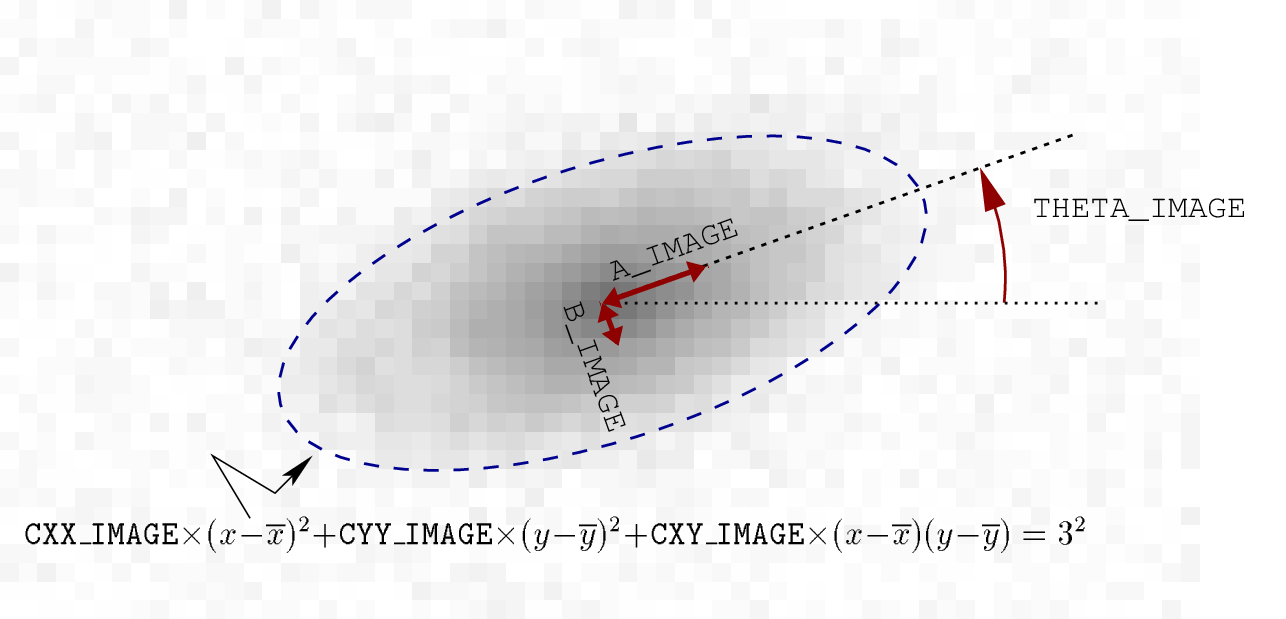

In [103]:
for (index,row),(index1,row1) in zip(df2.iterrows(),new_df.iterrows()):
    if row['dist'] > 3*max(row['r1(d)'],row['r2(d)']):
        df2.at[index, 'est'] = 'far' # event happened faraway from galaxy
    else: 
        d=ell_dist(row['r1(d)'],row['r2(d)'],row['PA'],row['RA'],row['DEC'],row1['meanra'],row1['meandec'])
        if d < 9:
            df2.at[index, 'est'] = 'in' # event happened inside galaxy
        else:
            df2.at[index, 'est'] = 'nearby' # event happened nearby galaxy

### Combine all dataframes

In [116]:
dfs=[n,sn,detections,dmdts,dfp]

{'ZTF18aaoqrau': 'WISEA J183247.32+322833.1',
 'ZTF18aapahyk': 'WISEA J183109.17+352236.2',
 'ZTF18aawbnla': 'WISEA J193815.88+181523.8',
 'ZTF18aawcdll': '2MASS J19303090+2121495',
 'ZTF18aaxijzf': 'WISEA J195350.14+201445.8',
 'ZTF18abdlssf': 'WISEA J181723.41+324640.6',
 'ZTF18abfepek': 'WISEA J180237.48+343734.7',
 'ZTF18abfwkbu': 'WISEA J183248.03+323239.0',
 'ZTF18abmkjji': 'WISEA J194718.42+202414.2',
 'ZTF18abmkovc': 'WISEA J193914.75+181639.7',
 'ZTF18abmkrcu': 'WISEA J195019.30+164108.1',
 'ZTF18abmkziw': 'WISEA J195058.56+174300.3',
 'ZTF18abmlhkf': 'WISEA J195045.25+163510.8',
 'ZTF18abmlkld': 'WISEA J194924.90+174907.7',
 'ZTF18abmlkzy': 'WISEA J195420.25+201600.4',
 'ZTF18abmlzzp': '2MASS J19465558+2229526',
 'ZTF18abmqkww': 'WISEA J195000.98+183619.0',
 'ZTF18abmyhyx': 'WISEA J191945.19+303136.9',
 'ZTF18abrtwth': 'WISEA J194906.70+185052.5',
 'ZTF18abrwbon': '2MASS J19512857+1828140',
 'ZTF18absemdc': 'WISEA J182017.04+354930.2',
 'ZTF18acaqunj': 'WISEA J200820.46-02102

In [ ]:
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs)

## Finally create multiple filters in the combined dataframe:
- filter 1: Based on stamp classifier
- filter 2: Based on location/ detections of the event
- filter 3: Based on rise time

In [ ]:
condition1=((n['probability']>=0.5)|(n['ndet_x']>1)& (n['ranking']==1))
condition2=((n['ndet_x']>1)|(n['ecl_lat']>20))&(n.gal_lat.abs() > 20) & (n.gal_A_g < 1)
n['filter1']=condition1
n['filter2']=condition2

In [ ]:
GET IMAGES USING SDSS, PANSTARRS,
IPYALADIN BEST CHOICE

In [233]:
!pip install basemap

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 KB 3.2 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 641.5 kB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 5.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:00:01
